<a href="https://colab.research.google.com/github/trie0000/external/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""DL_Basic_2025_Competition_NYUv2_baseline.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/17t7uAU0aST5aUt6sIJCqFneGlQrxFrJY

# Deep Learning 基礎講座　最終課題: NYUv2 セマンティックセグメンテーションcoarse_w=0」

## 概要
RGB画像から、画像内の各ピクセルがどのクラスに属するかを予測するセマンティックセグメンテーションタスク.

### データセット
- データセット: NYUv2 dataset
- 訓練データ: 795枚
- テストデータ: 654枚
- 入力: RGB画像 + 深度マップ（元画像サイズは可変）
- 出力: 13クラスのセグメンテーションマップ
- 評価指標: Mean IoU (Intersection over Union)

### データセットの詳細（[NYU Depth Dataset V2](https://cs.nyu.edu/~fergus/datasets/nyu_depth_v2.html)）
- 画像は屋内シーンを撮影したもので、家具や壁、床などの物体が含まれています.
- 各画像に対して13クラスのセグメンテーションラベルが提供されます.
- データは以下のディレクトリ構造で提供:
```
data/NYUv2/
├─train/
│  ├─image/      # RGB画像
│  │    000000.png
│  │    ...
│  │
│  ├─depth/      # 深度マップ
│  │    000000.png
│  │    ...
│  │
│  └─label/      # 13クラスセグメンテーション（教師ラベル）
│       000000.png
│       ...
└─test/
   ├─image/      # RGB画像
   │    000000.png
   │    ...
   │  ├─depth/   # 深度マップ
   │    000000.png
   │    ...
```

### タスクの詳細
- 入力のRGB画像と深度マップから、各ピクセルが13クラスのどれに属するかを予測するタスクです.
- 評価はMean IoUを使用します．
  - 各クラスごとにIoUを計算し、その平均を取ります.
  - IoUは以下の式で計算:
  $$IoU = \frac{TP}{TP + FP + FN}$$
    - TP: True Positive（正しく予測されたピクセル数）
    - FP: False Positive（誤って予測されたピクセル数）
    - FN: False Negative（見逃したピクセル数）

### 前処理
- 入力画像は512×512にリサイズされます.
- ピクセル値は0-1に正規化されます.
- セグメンテーションラベルは0-12の整数値（13クラス）です．
  - 255はignore index（評価から除外）

### 提出形式
- テスト画像（RGB + Depth）の各ピクセルに対してクラス（0~12）を予測したものをnumpy配列として保存されます.
- ファイル名: `submission.npy`
- 配列の形状: [テストデータ数, 高さ, 幅]
- 各ピクセルの値: 0-12の整数（予測クラス）

## 考えられる工夫の例
- 事前学習モデルの fine-tuning
    - ImageNetなどで事前学習されたモデルを本データセットでfine-tuningすることで性能向上が見込めます.
- 損失関数の再設計
    - クラスごとの出現頻度に応じて損失を補正するように損失関数を設計すると、クラス分布の不均衡に対してロバストな学習ができます.
- 画像の前処理
    - RandomResizedCrop / Flip / ColorJitter 等のデータ拡張を追加することで，汎化性能の向上が見込めます．

## 修了要件を満たす条件
- ベースラインでは，omnicampus 上での性能評価において， 38.2% となります．したがって，ベースラインである 38.2% を超えた提出のみ，修了要件として認めます．
- ベースラインから改善を加えることで， 50%以上に性能向上することを運営で確認しています．こちらを 1つの指標として取り組んでみてください．

## 注意点
- 最終的な予測モデルは，**配布している訓練データを用いて学習**（ファインチューニング含む）したものとしてください．
- 学習を行わず，**事前学習済みモデルの知識のみを利用した推論は禁止**します．
（例: ChatGPT 等の LLM に入力して推論を得るのみ）

### 事前学習モデルの利用
許可される事項
- **構成要素としての事前学習モデルの利用**: 自身で実装したアーキテクチャの一部（特徴抽出，埋め込みなど）として事前学習モデル（BERT，ViT など）を利用することは可能です．
- **ファインチューニング**: 上記の用途で利用している事前学習モデルのファインチューニングは可能です．

禁止される事項
- **タスク解決用の事前学習モデルの利用**: transformers などで提供されている，対象タスクを直接解くための事前学習モデルでそのまま推論のみ，またはファインチューニングのみで利用することは禁止とします．
  - 禁止事項の例: VQA タスクを直接解くための事前学習モデルを VQA タスクで利用する．

### データの準備
データをダウンロードした際に，google drive したため，利用するために google drive をマウントする必要があります．また， drive 上で展開することができないため，/content ディレクトリ下にコピーし "data.zip" を展開します．
google drive 上に "data.zip" が配置されていない場合は実行できません．google drive 上に "data.zip" (**831MB**) を配置することが可能であれば，"data_download.ipynb" を先に実行してください．難しい場合は，omnicampus 演習環境を利用してください．．
"""

# omnicampus 上では 4 セル目まで実行不要
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

# データダウンロード用の notebook にてgoogle drive への保存後，
# 反映に時間がかかる可能性がありますので，google drive のマウント後，
# data.zip がディレクトリ内にあることを確認してから実行してください．
# data.zip を /content 下にコピーする
!cp "/content/drive/MyDrive/data.zip" "/content"

# Commented out IPython magic to ensure Python compatibility.
# カレントディレクトリ下のファイル群を確認
# data.zip が表示されれば問題ないです
# %ls

# データを解凍する
!unzip data.zip
!mkdir data
!mv train test data/

"""omnicampus 演習環境では，data_download.ipynb のマウント，zip 化，drive へのコピーを実行しないことで，"data.zip" を解凍した形で配置されます．したがって，data ディレクトリが存在するディレクトリをカレントディレクトリとするだけで良いです．


"""

# Commented out IPython magic to ensure Python compatibility.
# omnicampus 実行用
# 以下の例では/workspace/Segmentation/split_data_scripts/omnicampus に data ディレクトリがあると想定
# %cd /workspace/Segmentation/split_data_scripts_omnicampus

# omnicampus 実行用
!pip install h5py scikit-image

"""# import library"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  data.zip
  inflating: data/train/image/000600.png  
  inflating: data/train/image/000320.png  
  inflating: data/train/image/000491.png  
  inflating: data/train/image/000502.png  
  inflating: data/train/image/000129.png  
  inflating: data/train/image/000044.png  
  inflating: data/train/image/000652.png  
  inflating: data/train/image/000919.png  
  inflating: data/train/image/000528.png  
  inflating: data/train/image/000853.png  
  inflating: data/train/image/000177.png  
  inflating: data/train/image/000584.png  
  inflating: data/train/image/001319.png  
  inflating: data/train/image/000597.png  
  inflating: data/train/image/000223.png  
  inflating: data/train/image/001350.png  
  inflating: data/train/image/000404.png  
  inflating: data/train/image/000488.png  
  inflating: data/train/image/000268.png  
  inflating: data/train/image/00048

'# import library'

In [2]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install pydensecrf
!pip install segmentation-models-pytorch diffusers transformers accelerate pydensecrf

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-fptgeoyi
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-fptgeoyi
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp312-cp312-linux_x86_64.whl size=3494529 sha256=dce71cd42494ca3b6538f9e7a58ade93e86826b7690811a792332c134ca33dd8
  Stored in directory: /tmp/pip-ephem-wheel-cache-__3yyvma/wheels/5f/63/9b/ad8357747651277615ec2094c768471e8ecde7d7b53564f24d
Successfully built pydensecrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
"""
NYUv2 VPD V9.4 - Improved Copy-Paste
====================================
V9.3からの変更点:
- Copy-Paste復活 (prob=0.3)
- Book Boost復活 (2x)
- 境界Ignore (2px) - 貼り付け境界をloss除外
- 明度調整 - Lチャンネルのみ周囲に合わせる（色味は維持）

V9.3から継承:
- Val Loss計算
- Early Stopping実質無効 (patience=30)
- FPN + PPM Decoder
"""

import os
import json
import random
import time
import datetime
import pytz
import shutil
import zipfile
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Libraries
try:
    from diffusers import StableDiffusionPipeline
    HAS_DIFFUSERS = True
except ImportError:
    HAS_DIFFUSERS = False
    print("⚠️ 'diffusers' not found")

try:
    import segmentation_models_pytorch as smp
    from segmentation_models_pytorch.losses import LovaszLoss, SoftCrossEntropyLoss
    HAS_SMP = True
except ImportError:
    HAS_SMP = False
    print("⚠️ 'segmentation_models_pytorch' not found")

# ==========================================
# 0. A100 Optimization Flags
# ==========================================
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

try:
    torch.backends.cuda.matmul.fp32_precision = 'tf32'
    torch.backends.cudnn.conv.fp32_precision = 'tf32'
except AttributeError:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# ==========================================
# 1. Configuration
# ==========================================
def get_jst_time_str():
    return datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M%S')


class Config:
    DATA_ROOT = '/content/data'
    MODEL_ID = "runwayml/stable-diffusion-v1-5"

    CLASSES = 13
    INPUT_CHANNELS = 5

    # A100 80GB設定
    IMG_SIZE = 640
    CROP_SIZE = 448
    BATCH_SIZE = 10
    NUM_WORKERS = 12
    PERSISTENT_WORKERS = True
    PIN_MEMORY = True
    USE_COMPILE = True
    COMPILE_MODE = 'reduce-overhead'

    # V9.3: Early Stopping実質無効化（全エポック回して収束傾向確認）
    EPOCHS_VPD = 30
    EARLY_STOPPING_PATIENCE = 30  # V9.3: 実質無効（全エポック回す）

    LR_BACKBONE = 5e-5
    LR_DECODER = 5e-4

    WEIGHT_DECAY = 0.01
    SEED = 42
    device = torch.device('cuda')

    # V9.4: Copy-Paste改善版
    PASTE_PROB = 0.3              # V9.4: 復活（控えめ）
    BOOK_BOOST_FACTOR = 2         # V9.4: 復活
    OTHER_BOOST_FACTOR = 1
    MIX_ORIGINAL = True
    PASTE_TARGETS = [1]           # V9.4: Booksのみ
    PASTE_BACKGROUNDS = [4, 9, 11]
    BOOK_CROP_PROB = 0.3          # V9.4: 復活（控えめ）

    # V9.4: 境界Ignore設定
    BOUNDARY_IGNORE_PIXELS = 2    # 貼り付け境界のignore幅

    # Depth
    MAX_DEPTH_VAL = 10000.0
    DEPTH_TIMESTEP_PRIOR_WEIGHT = 0.3

    # Loss
    TVERSKY_ALPHA = 0.7
    TVERSKY_BETA = 0.3
    CLASS_WEIGHTS = [1.0, 3.0, 1.0, 1.2, 1.0, 1.2, 2.0, 1.2, 1.0, 1.2, 3.0, 0.8, 1.0]

    # V9.1: FPN設定
    FPN_CHANNELS = 256
    USE_PPM = True

    # Logging
    LOG_TIMESTAMP = get_jst_time_str()
    DEBUG_DIR = f'/content/debug_vpd_v9_4_{LOG_TIMESTAMP}'
    DIAGNOSTIC_INTERVAL = 10

    CLASS_NAMES = [
        "Bed", "Books", "Ceiling", "Chair", "Floor", "Furniture",
        "Objects", "Picture", "Sofa", "Table", "TV", "Wall", "Window"
    ]

    BED, BOOKS, CEILING, CHAIR, FLOOR, FURNITURE = 0, 1, 2, 3, 4, 5
    OBJECTS, PICTURE, SOFA, TABLE, TV, WALL, WINDOW = 6, 7, 8, 9, 10, 11, 12

    GOLDEN_SAMPLES = [
        {'id': '000066', 'bbox': [407, 205, 89, 142]},
        {'id': '000072', 'bbox': [366, 412, 79, 63]},
        {'id': '000097', 'bbox': [271, 363, 51, 64]},
        {'id': '000105', 'bbox': [159, 216, 69, 20]},
        {'id': '000107', 'bbox': [244, 280, 142, 42]},
        {'id': '000109', 'bbox': [41, 285, 104, 62]},
        {'id': '000177', 'bbox': [77, 284, 69, 19]},
        {'id': '000353', 'bbox': [257, 218, 76, 31]},
    ]


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ==========================================
# 2. Augmentor (V9.4: 明度調整 + 境界Ignore)
# ==========================================
class UniversalDepthAwareAugmentorV94:
    """
    V9.4: 改善版Copy-Paste Augmentor
    - 明度調整: Lチャンネルのみ周囲に合わせる（色味は維持）
    - 境界Ignore: 貼り付け境界をlabel=255に
    """
    def __init__(self, dataset, targets, prob=0.5):
        self.banks = {cls_id: [] for cls_id in targets}
        self.targets = targets
        self.prob = prob
        self.load_golden_samples(dataset)
        self.collect_objects(dataset)

    def _adjust_luminance(self, blob_rgb, target_region):
        """
        明度のみ調整（色味は維持）
        - LAB空間のLチャンネルのみ統計転送
        - A/Bチャンネル（色味）はそのまま
        """
        # LAB変換
        blob_lab = cv2.cvtColor(blob_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
        target_lab = cv2.cvtColor(target_region, cv2.COLOR_RGB2LAB).astype(np.float32)

        # Lチャンネル（明度）のみ調整
        blob_L = blob_lab[:, :, 0]
        target_L = target_lab[:, :, 0]

        blob_mean, blob_std = blob_L.mean(), blob_L.std() + 1e-6
        tgt_mean, tgt_std = target_L.mean(), target_L.std() + 1e-6

        # 正規化 → ターゲット統計に変換
        blob_lab[:, :, 0] = (blob_L - blob_mean) / blob_std * tgt_std + tgt_mean
        blob_lab[:, :, 0] = np.clip(blob_lab[:, :, 0], 0, 255)

        return cv2.cvtColor(blob_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

    def _create_boundary_mask(self, mask, ignore_pixels=2):
        """
        境界Ignore用マスク作成
        - 元マスクを縮小して内部領域を取得
        - 境界領域（元マスク - 内部）をignoreに
        """
        kernel = np.ones((ignore_pixels * 2 + 1, ignore_pixels * 2 + 1), np.uint8)
        inner_mask = cv2.erode(mask, kernel, iterations=1)
        boundary_mask = mask.astype(bool) & ~inner_mask.astype(bool)
        return inner_mask, boundary_mask

    def load_golden_samples(self, dataset):
        if 1 in self.targets:
            print("💎 Loading Golden Samples (Books)...")
            for item in Config.GOLDEN_SAMPLES:
                id_ = item['id']
                x, y, w, h = item['bbox']
                img_path = os.path.join(dataset.img_dir, f"{id_}.png")
                depth_path = os.path.join(dataset.depth_dir, f"{id_}.png")
                label_path = os.path.join(dataset.label_dir, f"{id_}.png")

                if not os.path.exists(img_path):
                    continue

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                if depth is None:
                    depth = np.zeros(image.shape[:2], np.float32)
                depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

                edge = self._compute_edge_map(image)
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

                roi_rgb = image[y:y+h, x:x+w]
                roi_depth = depth[y:y+h, x:x+w]
                roi_edge = edge[y:y+h, x:x+w]
                blob_mask = (label[y:y+h, x:x+w] == 1).astype(np.uint8)

                if np.sum(blob_mask) == 0:
                    continue

                self.banks[1].append({
                    'rgb': roi_rgb, 'depth': roi_depth, 'edge': roi_edge,
                    'mask': blob_mask, 'mean_depth': np.mean(roi_depth),
                    'class_id': 1, 'source': 'golden'
                })
            print(f"   -> Loaded {len(self.banks[1])} golden book samples")

    def _compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def collect_objects(self, dataset):
        print(f"🛠️ Collecting objects for classes: {self.targets} ...")
        unique_ids = sorted(list(set(dataset.ids)))
        count_map = {cls_id: len(self.banks[cls_id]) for cls_id in self.targets}

        for id_ in tqdm(unique_ids, desc="Scanning"):
            label_path = os.path.join(dataset.label_dir, f"{id_}.png")
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue

            present_classes = np.unique(label)
            target_intersect = [c for c in present_classes if c in self.targets]
            if not target_intersect:
                continue

            img_path = os.path.join(dataset.img_dir, f"{id_}.png")
            depth_path = os.path.join(dataset.depth_dir, f"{id_}.png")
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
            if depth is None:
                depth = np.zeros_like(label, dtype=np.float32)
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL
            edge = self._compute_edge_map(image)

            for cls_id in target_intersect:
                mask = (label == cls_id).astype(np.uint8)
                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

                for j in range(1, num_labels):
                    area = stats[j, cv2.CC_STAT_AREA]
                    if area < 400:
                        continue
                    x = stats[j, cv2.CC_STAT_LEFT]
                    y = stats[j, cv2.CC_STAT_TOP]
                    w = stats[j, cv2.CC_STAT_WIDTH]
                    h = stats[j, cv2.CC_STAT_HEIGHT]
                    if w/h > 10.0 or h/w > 10.0:
                        continue

                    blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                    self.banks[cls_id].append({
                        'rgb': image[y:y+h, x:x+w],
                        'depth': depth[y:y+h, x:x+w],
                        'edge': edge[y:y+h, x:x+w],
                        'mask': blob_mask,
                        'mean_depth': np.mean(depth[y:y+h, x:x+w]),
                        'class_id': cls_id,
                        'source': 'collected'
                    })
                    count_map[cls_id] += 1

        print(f"✅ Collection Result: {count_map}")

    def _is_natural_position(self, label, y_t, x_t, target_cls, blob_h, blob_w):
        H, W = label.shape
        if target_cls == Config.BOOKS:
            margin = 30
            y1 = max(0, y_t - margin)
            y2 = min(H, y_t + blob_h + margin)
            x1 = max(0, x_t - margin)
            x2 = min(W, x_t + blob_w + margin)

            context = label[y1:y2, x1:x2]
            total_pixels = context.size

            if total_pixels > 0:
                wall_ratio = (context == Config.WALL).sum() / total_pixels
                floor_ratio = (context == Config.FLOOR).sum() / total_pixels
                table_ratio = (context == Config.TABLE).sum() / total_pixels

                if wall_ratio > 0.8 and y_t < H * 0.5:
                    return False
                if floor_ratio > 0.2:
                    return True
                if table_ratio > 0.2:
                    return True
                if wall_ratio > 0.3 and y_t > H * 0.6:
                    return True
        return True

    def apply(self, image, label):
        """
        V9.4: 改善版Copy-Paste
        - 明度調整: 貼り付け先の周辺領域に合わせる
        - 境界Ignore: 貼り付け境界をlabel=255に
        """
        if random.random() > self.prob:
            return image, label

        available_classes = [c for c in self.targets if len(self.banks[c]) > 0]
        if not available_classes:
            return image, label

        weights = [5.0 if c == 1 else 1.0 for c in available_classes]
        target_cls = random.choices(available_classes, weights=weights, k=1)[0]
        blob = random.choice(self.banks[target_cls])

        H, W = label.shape
        valid_backgrounds = Config.PASTE_BACKGROUNDS
        mask_bg = np.isin(label, valid_backgrounds).astype(np.uint8)
        ys, xs = np.where(mask_bg > 0)
        if len(ys) == 0:
            return image, label

        for _ in range(10):
            idx = random.randint(0, len(ys) - 1)
            y_t, x_t = ys[idx], xs[idx]
            blob_h, blob_w = blob['mask'].shape
            if self._is_natural_position(label, y_t, x_t, target_cls, blob_h, blob_w):
                break
        else:
            return image, label

        target_d = image[y_t, x_t, 3]
        source_d = blob['mean_depth']
        scale = np.clip(source_d / (target_d + 1e-6), 0.3, 2.0) if (target_d > 0.001 and source_d > 0.001) else 1.0

        blob_h, blob_w = blob['mask'].shape
        new_w, new_h = int(blob_w * scale), int(blob_h * scale)
        if new_w < 16 or new_h < 16 or new_w <= 0 or new_h <= 0:
            return image, label

        blob_rgb = cv2.resize(blob['rgb'], (new_w, new_h))
        blob_depth = cv2.resize(blob['depth'], (new_w, new_h))
        blob_edge = cv2.resize(blob['edge'], (new_w, new_h))
        blob_mask = cv2.resize(blob['mask'], (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        if target_cls in [1, 6]:
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                blob_rgb = np.rot90(blob_rgb, k)
                blob_depth = np.rot90(blob_depth, k)
                blob_edge = np.rot90(blob_edge, k)
                blob_mask = np.rot90(blob_mask, k)
        else:
            if random.random() > 0.5:
                blob_rgb = np.fliplr(blob_rgb)
                blob_depth = np.fliplr(blob_depth)
                blob_edge = np.fliplr(blob_edge)
                blob_mask = np.fliplr(blob_mask)

        new_h, new_w = blob_rgb.shape[:2]
        if new_h >= H or new_w >= W:
            return image, label

        y_t = min(y_t, H - new_h)
        x_t = min(x_t, W - new_w)
        roi_depth = image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
        if roi_depth.shape[:2] != (new_h, new_w):
            return image, label

        # V9.4: 明度調整（貼り付け先周辺領域に合わせる）
        margin_ctx = 20  # 周辺コンテキスト取得用マージン
        ctx_y1 = max(0, y_t - margin_ctx)
        ctx_y2 = min(H, y_t + new_h + margin_ctx)
        ctx_x1 = max(0, x_t - margin_ctx)
        ctx_x2 = min(W, x_t + new_w + margin_ctx)
        target_region = image[ctx_y1:ctx_y2, ctx_x1:ctx_x2, :3].astype(np.uint8)

        if target_region.size > 0 and blob_rgb.size > 0:
            blob_rgb = self._adjust_luminance(blob_rgb.astype(np.uint8), target_region)

        new_d_map = blob_depth + (target_d - np.mean(blob_depth))
        margin = 0.01
        is_in_front = new_d_map < (roi_depth + margin)
        final_mask = (blob_mask == 1) & is_in_front

        # V9.4: 境界Ignoreマスク作成
        inner_mask, boundary_mask = self._create_boundary_mask(
            final_mask.astype(np.uint8),
            Config.BOUNDARY_IGNORE_PIXELS
        )

        # 画像貼り付け（全体マスク使用）
        mask_3 = np.stack([final_mask]*3, axis=2)
        image[y_t:y_t+new_h, x_t:x_t+new_w, :3] = np.where(mask_3, blob_rgb, image[y_t:y_t+new_h, x_t:x_t+new_w, :3])
        image[y_t:y_t+new_h, x_t:x_t+new_w, 3] = np.where(final_mask, np.clip(new_d_map, 0, 1), image[y_t:y_t+new_h, x_t:x_t+new_w, 3])
        image[y_t:y_t+new_h, x_t:x_t+new_w, 4] = np.where(final_mask, blob_edge, image[y_t:y_t+new_h, x_t:x_t+new_w, 4])

        # ラベル貼り付け（内部のみクラスラベル、境界はignore=255）
        label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
            inner_mask.astype(bool),
            blob['class_id'],
            label[y_t:y_t+new_h, x_t:x_t+new_w]
        )
        label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
            boundary_mask,
            255,  # ignore_index
            label[y_t:y_t+new_h, x_t:x_t+new_w]
        )

        return image, label


# ==========================================
# 3. Dataset (V9から継承)
# ==========================================
def get_transforms_train():
    return {
        'color': A.Compose([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5)
        ]),
        'geo': A.Compose([
            A.GridDistortion(p=0.3),
            A.Perspective(p=0.3),
            A.ShiftScaleRotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                       std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
            ToTensorV2()
        ])
    }


def get_transforms_val():
    return A.Compose([
        A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                   std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ])


class NYUv2DatasetV9(Dataset):
    def __init__(self, root_dir, ids, is_train=False, transform=None, augmentor=None):
        self.root_dir = root_dir
        self.ids = list(ids)
        self.is_train = is_train
        self.transform = transform
        self.augmentor = augmentor

        self.img_dir = os.path.join(root_dir, 'train', 'image')
        self.depth_dir = os.path.join(root_dir, 'train', 'depth')
        self.label_dir = os.path.join(root_dir, 'train', 'label')

        if is_train:
            self._apply_multi_boost()

    def _apply_multi_boost(self):
        print("⚖️ Multi-Boost Strategy (V9: 2x for Books)")
        book_ids = []
        other_ids = []
        target_others = [3, 5, 6, 8, 10]
        base_ids = list(self.ids)

        for id_ in base_ids:
            label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue
            unique_cls = np.unique(label)
            if 1 in unique_cls:
                book_ids.extend([id_] * Config.BOOK_BOOST_FACTOR)
            if any(c in target_others for c in unique_cls):
                other_ids.extend([id_] * Config.OTHER_BOOST_FACTOR)

        anchor_ids = list(base_ids) if Config.MIX_ORIGINAL else []
        self.ids = book_ids + other_ids + anchor_ids
        print(f"   -> Total Train Size: {len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def get_book_centric_crop(self, image, label):
        ys, xs = np.where(label == 1)
        cs = Config.CROP_SIZE
        h, w = image.shape[:2]

        if len(ys) > 0:
            idx = random.randint(0, len(ys) - 1)
            cy, cx = ys[idx], xs[idx]
            y1 = max(0, min(h - cs, cy - cs//2 + random.randint(-50, 50)))
            x1 = max(0, min(w - cs, cx - cs//2 + random.randint(-50, 50)))
        else:
            y1 = random.randint(0, max(0, h - cs))
            x1 = random.randint(0, max(0, w - cs))

        return image[y1:y1+cs, x1:x1+cs], label[y1:y1+cs, x1:x1+cs]

    def __getitem__(self, idx):
        id_ = self.ids[idx]

        image = cv2.imread(os.path.join(self.img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(os.path.join(self.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

        if depth is None:
            depth = np.zeros(image.shape[:2], np.float32)
        else:
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

        label[~((label >= 0) & (label < Config.CLASSES))] = 255
        edge = self.compute_edge_map(image)
        combined = np.dstack([image, depth * 255.0, edge * 255.0]).astype(np.float32)

        if self.is_train:
            if self.augmentor:
                combined, label = self.augmentor.apply(combined, label)

            if random.random() < Config.BOOK_CROP_PROB:
                combined, label = self.get_book_centric_crop(combined, label)

            if self.transform:
                if isinstance(self.transform, dict):
                    rgb_aug = self.transform['color'](image=combined[:,:,:3].astype(np.uint8))['image']
                    t_geo = self.transform['geo'](image=np.dstack([rgb_aug, combined[:,:,3:]]), mask=label)
                    return t_geo['image'], t_geo['mask'].long()
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long()
        else:
            if self.transform:
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long(), id_

        return torch.from_numpy(combined.transpose(2,0,1)).float(), torch.from_numpy(label).long()


# ==========================================
# 4. VPD Backbone (V9から継承)
# ==========================================
class MultiTimestepVPDExtractor(nn.Module):
    def __init__(self, model_id, device="cuda"):
        super().__init__()
        self.device = device
        print(f"👻 Loading VPD Backbone...")

        self.pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
        self.vae = self.pipe.vae
        self.unet = self.pipe.unet
        self.text_encoder = self.pipe.text_encoder
        self.tokenizer = self.pipe.tokenizer
        self.scheduler = self.pipe.scheduler

        self.vae.requires_grad_(False)
        self.text_encoder.requires_grad_(False)

        for param in self.unet.parameters():
            param.requires_grad = False
        for param in self.unet.mid_block.parameters():
            param.requires_grad = True
        for param in self.unet.up_blocks.parameters():
            param.requires_grad = True

        self.timesteps = [0, 100, 300]

        if hasattr(self.scheduler, 'alphas_cumprod'):
            self.scheduler.alphas_cumprod = self.scheduler.alphas_cumprod.to(device)
        if hasattr(self.scheduler, 'betas'):
            self.scheduler.betas = self.scheduler.betas.to(device)
        if hasattr(self.scheduler, 'alphas'):
            self.scheduler.alphas = self.scheduler.alphas.to(device)

        with torch.no_grad():
            prompt = "indoor scene, room, furniture, realistic"
            tokens = self.tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=77)
            self.text_emb = self.text_encoder(tokens.input_ids.to(device))[0]

    def _add_noise(self, latents, t):
        noise = torch.randn_like(latents)
        t_tensor = torch.full((latents.shape[0],), t, device=latents.device, dtype=torch.long)
        return self.scheduler.add_noise(latents, noise, t_tensor)

    def _extract_features_at_timestep(self, latents, t):
        features = {}
        def make_hook(name):
            def hook(model, input, output):
                if isinstance(output, tuple):
                    output = output[0]
                features[name] = output
            return hook

        hooks = []
        hook_configs = [
            (self.unet.down_blocks[1], 'down1'),
            (self.unet.down_blocks[2], 'down2'),
            (self.unet.mid_block, 'mid'),
            (self.unet.up_blocks[1], 'up1'),
            (self.unet.up_blocks[2], 'up2')
        ]
        for module, name in hook_configs:
            hooks.append(module.register_forward_hook(make_hook(name)))

        noisy_latents = self._add_noise(latents, t) if t > 0 else latents
        t_tensor = torch.full((latents.shape[0],), t, device=self.device, dtype=torch.long)
        self.unet(noisy_latents, t_tensor, encoder_hidden_states=self.text_emb.repeat(latents.shape[0], 1, 1))

        for h in hooks:
            h.remove()
        return features

    def forward(self, x):
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        x_sd = (x * std + mean) * 2.0 - 1.0

        with torch.no_grad():
            latents = self.vae.encode(x_sd).latent_dist.mode() * 0.18215

        all_features = {}
        for t in self.timesteps:
            feats = self._extract_features_at_timestep(latents, t)
            for key, val in feats.items():
                all_features[f't{t}_{key}'] = val
        return all_features


# ==========================================
# 5. V9.1: FPN Decoder
# ==========================================
class PyramidPoolingModule(nn.Module):
    """
    PPM (Pyramid Pooling Module) - PSPNetより
    グローバルコンテキストを捉える
    """
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6], out_channels=256):
        super().__init__()
        self.stages = nn.ModuleList()
        for pool_size in pool_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, out_channels // len(pool_sizes), 1, bias=False),
                nn.BatchNorm2d(out_channels // len(pool_sizes)),
                nn.ReLU(inplace=True)
            ))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.shape[2:]
        pyramids = [x]
        for stage in self.stages:
            pyramids.append(F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False))
        return self.bottleneck(torch.cat(pyramids, dim=1))


class FPNDecoder(nn.Module):
    """
    FPN (Feature Pyramid Network) Decoder

    構造:
    - Lateral connections: 各レベルを同じチャンネル数に
    - Top-down pathway: 高レベル→低レベルに情報伝播
    - Feature fusion: 全レベルを融合
    """
    def __init__(self, in_channels_list, fpn_channels=256, num_classes=13, use_ppm=True):
        """
        Args:
            in_channels_list: 各レベルの入力チャンネル数 [down1, down2, mid, up1, up2]
            fpn_channels: FPN中間チャンネル数
            num_classes: 出力クラス数
            use_ppm: Pyramid Pooling Moduleを使うか
        """
        super().__init__()

        self.num_levels = len(in_channels_list)

        # Lateral connections (1x1 conv)
        self.lateral_convs = nn.ModuleList()
        for in_ch in in_channels_list:
            self.lateral_convs.append(nn.Sequential(
                nn.Conv2d(in_ch, fpn_channels, 1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        # Top-down refinement (3x3 conv after add)
        self.fpn_convs = nn.ModuleList()
        for _ in range(self.num_levels):
            self.fpn_convs.append(nn.Sequential(
                nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        # PPM for global context (最上位レベルに適用)
        self.use_ppm = use_ppm
        if use_ppm:
            self.ppm = PyramidPoolingModule(fpn_channels, out_channels=fpn_channels)

        # Feature fusion
        fusion_in_channels = fpn_channels * self.num_levels
        self.fusion = nn.Sequential(
            nn.Conv2d(fusion_in_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
        )

        # Segmentation head
        self.seg_head = nn.Conv2d(fpn_channels, num_classes, 1)

    def forward(self, features):
        """
        Args:
            features: list of tensors [down1, down2, mid, up1, up2]
                      各サイズは異なる可能性あり
        Returns:
            logits: [B, num_classes, H, W]
        """
        # Lateral connections
        laterals = []
        for i, feat in enumerate(features):
            laterals.append(self.lateral_convs[i](feat))

        # Top-down pathway (高レベル→低レベル)
        # features順: down1(大) -> down2 -> mid(小) -> up1 -> up2(大)
        # mid(index=2)が最小なので、そこから両方向に伝播

        # サイズでソート（小→大の順にtop-down）
        sizes = [f.shape[2:] for f in laterals]

        # 最小解像度のインデックスを見つける
        min_idx = min(range(len(sizes)), key=lambda i: sizes[i][0] * sizes[i][1])

        # Top-down: 最小から他へ
        fpn_outs = [None] * self.num_levels

        # まず最小解像度を処理
        fpn_outs[min_idx] = self.fpn_convs[min_idx](laterals[min_idx])

        # PPMを最小解像度に適用
        if self.use_ppm:
            fpn_outs[min_idx] = self.ppm(fpn_outs[min_idx])

        # 他のレベルにtop-down
        for i in range(self.num_levels):
            if i == min_idx:
                continue

            # 最小解像度からの特徴をアップサンプル
            upsampled = F.interpolate(fpn_outs[min_idx], size=sizes[i],
                                      mode='bilinear', align_corners=False)
            # 足し合わせて3x3 conv
            fpn_outs[i] = self.fpn_convs[i](laterals[i] + upsampled)

        # 全レベルを最大解像度にアップサンプルして結合
        max_size = max(sizes, key=lambda s: s[0] * s[1])
        upsampled_outs = []
        for out in fpn_outs:
            if out.shape[2:] != max_size:
                out = F.interpolate(out, size=max_size, mode='bilinear', align_corners=False)
            upsampled_outs.append(out)

        # Concat & Fusion
        fused = self.fusion(torch.cat(upsampled_outs, dim=1))

        # Segmentation
        logits = self.seg_head(fused)

        return logits


# ==========================================
# 6. V9.1: VPD + FPN Model
# ==========================================
class DepthAdaptiveTimestepFusion(nn.Module):
    """Depth-Timestep融合 (V9から継承)"""
    def __init__(self, feat_channels=256, prior_weight=None):
        super().__init__()
        self.prior_weight = prior_weight if prior_weight is not None else Config.DEPTH_TIMESTEP_PRIOR_WEIGHT

        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1),
        )
        self.base_weights = nn.Parameter(torch.ones(3) / 3)
        self.confidence_threshold = 0.02

    def _compute_prior_weights(self, depth):
        w_t0 = 1.0 - depth
        w_t100 = torch.exp(-((depth - 0.5) ** 2) / 0.1)
        w_t300 = depth
        prior = torch.cat([w_t0, w_t100, w_t300], dim=1)
        prior = prior / (prior.sum(dim=1, keepdim=True) + 1e-6)
        return prior

    def forward(self, depth, feat_t0, feat_t100, feat_t300):
        B, C, H, W = feat_t0.shape
        depth_resized = F.interpolate(depth, size=(H, W), mode='bilinear', align_corners=False)

        learned_weights = F.softmax(self.depth_encoder(depth_resized), dim=1)
        prior_weights = self._compute_prior_weights(depth_resized)
        depth_valid = (depth_resized > self.confidence_threshold).float()
        uniform_weights = F.softmax(self.base_weights, dim=0).view(1, 3, 1, 1).expand(B, 3, H, W)

        combined_weights = (1 - self.prior_weight) * learned_weights + self.prior_weight * prior_weights
        final_weights = depth_valid * combined_weights + (1 - depth_valid) * uniform_weights

        fused = (final_weights[:, 0:1] * feat_t0 +
                 final_weights[:, 1:2] * feat_t100 +
                 final_weights[:, 2:3] * feat_t300)

        return fused, final_weights


class DepthInvalidityFeature(nn.Module):
    """深度無効領域の特徴 (V9から継承)"""
    def __init__(self, out_channels=16):
        super().__init__()
        self.register_buffer('sobel_x', torch.tensor([
            [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))
        self.register_buffer('sobel_y', torch.tensor([
            [-1, -2, -1], [0, 0, 0], [1, 2, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
        )

    def forward(self, depth):
        if depth.dim() == 3:
            depth = depth.unsqueeze(1)
        invalid_mask = ((depth < 0.02) | (depth > 0.98)).float()
        invalid_edge = self._compute_edge(invalid_mask)
        depth_noise = self._local_variance(depth)
        depth_edge = self._compute_edge(depth)
        boundary_uncertainty = depth_edge * depth_noise
        combined = torch.cat([invalid_mask, invalid_edge, depth_noise, boundary_uncertainty], dim=1)
        return self.conv(combined)

    def _compute_edge(self, x):
        gx = F.conv2d(x, self.sobel_x, padding=1)
        gy = F.conv2d(x, self.sobel_y, padding=1)
        return torch.sqrt(gx**2 + gy**2 + 1e-6)

    def _local_variance(self, x, kernel_size=5):
        padding = kernel_size // 2
        mean = F.avg_pool2d(x, kernel_size, stride=1, padding=padding)
        sq_mean = F.avg_pool2d(x**2, kernel_size, stride=1, padding=padding)
        return torch.clamp(sq_mean - mean**2, min=0)


class VPDSegmentationModelV91(nn.Module):
    """
    V9.1: VPD + FPN Decoder

    変更点:
    - デコーダをConv×3 → FPNに変更
    - PPM (Pyramid Pooling Module) 追加
    - Refinement moduleは維持
    """
    def __init__(self, num_classes=13):
        super().__init__()

        self.backbone = MultiTimestepVPDExtractor(Config.MODEL_ID, device=Config.device)

        # 各レベルの入力チャンネル数
        # down1: 640, down2: 1280, mid: 1280, up1: 1280, up2: 640
        in_channels_vpd = [640, 1280, 1280, 1280, 640]
        proj_channels = Config.FPN_CHANNELS  # 256

        # VPD特徴を投影するレイヤー
        self.proj_layers = nn.ModuleList([
            nn.Sequential(nn.Conv2d(ch, proj_channels, 1), nn.BatchNorm2d(proj_channels), nn.ReLU())
            for ch in in_channels_vpd
        ])

        # Depth-Timestep Fusion (各レベル)
        self.depth_fusions = nn.ModuleList([
            DepthAdaptiveTimestepFusion(proj_channels) for _ in range(5)
        ])

        # FPN Decoder
        self.fpn_decoder = FPNDecoder(
            in_channels_list=[proj_channels] * 5,
            fpn_channels=Config.FPN_CHANNELS,
            num_classes=num_classes,
            use_ppm=Config.USE_PPM
        )

        # Depth invalidity features
        self.depth_invalidity = DepthInvalidityFeature(16)

        # Refinement module
        self.refinement = nn.Sequential(
            nn.Conv2d(num_classes + 5 + 16, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, num_classes, 1)
        )
        nn.init.constant_(self.refinement[-1].weight, 0)
        nn.init.constant_(self.refinement[-1].bias, 0)

    def forward(self, x):
        rgb, depth = x[:, :3], x[:, 3:4]

        # VPD特徴抽出
        feats = self.backbone(rgb)

        # 各レベルでTimestep融合
        layer_names = ['down1', 'down2', 'mid', 'up1', 'up2']
        fused_features = []

        for i, name in enumerate(layer_names):
            f0 = self.proj_layers[i](feats[f't0_{name}'].float())
            f100 = self.proj_layers[i](feats[f't100_{name}'].float())
            f300 = self.proj_layers[i](feats[f't300_{name}'].float())
            fused, _ = self.depth_fusions[i](depth, f0, f100, f300)
            fused_features.append(fused)

        # FPN Decoder
        logits = self.fpn_decoder(fused_features)

        # 入力サイズにリサイズ
        logits = F.interpolate(logits, size=x.shape[2:], mode='bilinear', align_corners=False)

        # Refinement
        depth_inv = self.depth_invalidity(depth)
        fusion_input = torch.cat([logits, x, depth_inv], dim=1)
        refined = logits + self.refinement(fusion_input)

        return refined


# ==========================================
# 7. Loss (V9から継承)
# ==========================================
class HybridLossV9(nn.Module):
    def __init__(self, class_weights, device, alpha=0.3, beta=0.7, ignore_index=255):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.weights = torch.tensor(class_weights).float().to(device)
        self.ignore_index = ignore_index
        self.ce = SoftCrossEntropyLoss(smooth_factor=0.1, ignore_index=ignore_index)
        self.lovasz = LovaszLoss(mode='multiclass', ignore_index=ignore_index)

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        lovasz_loss = self.lovasz(logits, targets)

        probs = F.softmax(logits, dim=1)
        with torch.no_grad():
            targets_masked = targets.clone()
            targets_masked[targets_masked == self.ignore_index] = 0
            true_1_hot = F.one_hot(targets_masked, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()
            valid_mask = (targets != self.ignore_index).float().unsqueeze(1)
            true_1_hot = true_1_hot * valid_mask

        probs = probs * valid_mask
        tp = torch.sum(probs * true_1_hot, dim=(0, 2, 3))
        fp = torch.sum(probs * (1 - true_1_hot), dim=(0, 2, 3))
        fn = torch.sum((1 - probs) * true_1_hot, dim=(0, 2, 3))
        tversky_score = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
        tversky_loss = (1 - tversky_score) * self.weights

        return 0.4 * ce_loss + 0.3 * tversky_loss.mean() + 0.3 * lovasz_loss


# ==========================================
# 8. Training with Early Stopping (V9.2: Val Loss)
# ==========================================
def compute_metrics(all_data, num_classes):
    class_tp = np.zeros(num_classes)
    class_fp = np.zeros(num_classes)
    class_fn = np.zeros(num_classes)

    books_tp = books_fp = books_fn = 0
    strict_tp = strict_fp = 0
    fp_conf, fn_conf = [], []

    for d in all_data:
        valid = d['mask'] != 255
        m = d['mask'][valid]
        p = d['pred'][valid]
        bp = d['probs'][1][valid]

        for c in range(num_classes):
            class_tp[c] += ((p == c) & (m == c)).sum()
            class_fp[c] += ((p == c) & (m != c)).sum()
            class_fn[c] += ((p != c) & (m == c)).sum()

        books_tp += ((p == 1) & (m == 1)).sum()
        books_fp += ((p == 1) & (m != 1)).sum()
        books_fn += ((p != 1) & (m == 1)).sum()

        high_conf = bp > 0.9
        strict_tp += ((p == 1) & (m == 1) & high_conf).sum()
        strict_fp += ((p == 1) & (m != 1) & high_conf).sum()

        fp_mask = (p == 1) & (m != 1)
        fn_mask = (p != 1) & (m == 1)
        if fp_mask.sum() > 0:
            fp_conf.extend(bp[fp_mask].tolist()[:100])
        if fn_mask.sum() > 0:
            fn_conf.extend(bp[fn_mask].tolist()[:100])

    class_ious = []
    for c in range(num_classes):
        denom = class_tp[c] + class_fp[c] + class_fn[c]
        if denom > 0:
            class_ious.append(class_tp[c] / denom)
        else:
            class_ious.append(np.nan)

    return {
        'miou': float(np.nanmean(class_ious)),
        'class_ious': [float(x) if not np.isnan(x) else 0.0 for x in class_ious],
        'books': {
            'iou': float(books_tp / (books_tp + books_fp + books_fn + 1e-6)),
            'precision': float(books_tp / (books_tp + books_fp + 1e-6)),
            'recall': float(books_tp / (books_tp + books_fn + 1e-6)),
            'strict_iou': float(strict_tp / (strict_tp + strict_fp + books_fn + 1e-6)),
            'strict_precision': float(strict_tp / (strict_tp + strict_fp + 1e-6)),
            'fp_conf': float(np.mean(fp_conf)) if fp_conf else 0,
            'fn_conf': float(np.mean(fn_conf)) if fn_conf else 0
        }
    }


# ==========================================
# V9.2: Val Loss計算を追加
# ==========================================
def collect_validation_data(model, val_loader, criterion, device):
    """
    V9.2: Val Loss計算を追加

    Returns:
        all_data: 予測結果リスト
        val_loss: 平均Val Loss
    """
    model.eval()
    all_data = []
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, masks, ids in val_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(images)
                # V9.2: Loss計算追加
                loss = criterion(outputs, masks)

            total_loss += loss.item()
            num_batches += 1

            probs = F.softmax(outputs.float(), dim=1)
            preds = outputs.argmax(dim=1)

            for i in range(len(masks)):
                all_data.append({
                    'id': ids[i],
                    'mask': masks[i].cpu().numpy(),
                    'pred': preds[i].cpu().numpy(),
                    'probs': probs[i].cpu().numpy()
                })

    val_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return all_data, val_loss


# ==========================================
# V9.2: Early Stopping (Val Loss用 - 低いほど良い)
# ==========================================
class EarlyStopping:
    """
    V9.2: Val Lossベースに変更
    - Loss監視なので「低いほど良い」
    - best_score初期値はinf
    """
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')  # V9.2: 初期値をinfに
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Args:
            val_loss: 検証ロス（低いほど良い）
        Returns:
            bool: 早期停止すべきか
        """
        # V9.2: ロジック反転（低いほど良い）
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


def train_vpd_v94(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, debug_dir):
    """
    V9.4: VPD Training - Improved Copy-Paste

    変更点:
    - Copy-Paste復活（明度調整 + 境界Ignore）
    - Book Boost復活
    """
    logs_dir = os.path.join(debug_dir, 'logs', 'vpd')
    models_dir = os.path.join(debug_dir, 'models')
    os.makedirs(logs_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)

    # V9.2: Val Lossベースに変更
    early_stopping = EarlyStopping(patience=Config.EARLY_STOPPING_PATIENCE)

    best_miou = 0
    best_books = 0
    log_file = os.path.join(logs_dir, 'training_logs.jsonl')

    for epoch in range(epochs):
        epoch_start = time.time()

        # Train
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"[VPD V9.4] Epoch {epoch+1}/{epochs}", leave=False):
            images = images.to(Config.device, non_blocking=True)
            masks = masks.to(Config.device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(images)
                loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # V9.2: Validate with Loss計算
        all_data, val_loss = collect_validation_data(model, val_loader, criterion, Config.device)
        metrics = compute_metrics(all_data, Config.CLASSES)

        epoch_time = time.time() - epoch_start

        # V9.2: Console出力にVal Loss追加
        print(f"\n[{get_jst_time_str()}] Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.1f}s")
        print(f"Val mIoU: {metrics['miou']:.4f}")
        print(f"Books [1] -> IoU: {metrics['books']['iou']:.4f} (Strict: {metrics['books']['strict_iou']:.4f})")
        print(f"          -> Prec: {metrics['books']['precision']:.4f} | Rec: {metrics['books']['recall']:.4f}")
        print("Class-wise IoU:")
        for i, name in enumerate(Config.CLASS_NAMES):
            print(f"  {name:10s}: {metrics['class_ious'][i]:.4f}")

        # V9.2: ログにval_loss追加
        epoch_log = {
            'epoch': epoch + 1,
            'timestamp': get_jst_time_str(),
            'train_loss': avg_train_loss,
            'val_loss': val_loss,  # V9.2: 追加
            'val_miou': metrics['miou'],
            'class_ious': metrics['class_ious'],
            'books': metrics['books'],
            'time': epoch_time
        }

        with open(log_file, 'a') as f:
            f.write(json.dumps(epoch_log) + '\n')

        # Best model保存 (torch.compile対応)
        # V9.2: Best Model保存はmIoU維持
        state_dict = model._orig_mod.state_dict() if hasattr(model, '_orig_mod') else model.state_dict()

        if metrics['miou'] > best_miou:
            best_miou = metrics['miou']
            torch.save(state_dict, os.path.join(models_dir, 'best_vpd_miou.pth'))
            print(">>> Best mIoU Model Saved!")

        if metrics['books']['iou'] > best_books:
            best_books = metrics['books']['iou']
            torch.save(state_dict, os.path.join(models_dir, 'best_vpd_books.pth'))
            print(">>> Best Books Model Saved!")

        # V9.2: Early StoppingをVal Lossベースに変更
        if early_stopping(val_loss):
            print(f"\n⚠️ Early Stopping triggered at epoch {epoch+1}")
            print(f"   Val Loss not improved for {Config.EARLY_STOPPING_PATIENCE} epochs")
            print(f"   Best Val Loss: {early_stopping.best_loss:.4f}")
            break

        scheduler.step()

    # 最終保存 (torch.compile対応)
    state_dict = model._orig_mod.state_dict() if hasattr(model, '_orig_mod') else model.state_dict()
    torch.save(state_dict, os.path.join(models_dir, 'final_vpd.pth'))

    return best_miou, best_books


# ==========================================
# 9. Main
# ==========================================
def main():
    set_seed(Config.SEED)
    os.makedirs(Config.DEBUG_DIR, exist_ok=True)
    os.makedirs(os.path.join(Config.DEBUG_DIR, 'models'), exist_ok=True)

    print(f"[{get_jst_time_str()}] 🚀 VPD V9.4 Training - Improved Copy-Paste")
    print(f"Debug Dir: {Config.DEBUG_DIR}")
    print()
    print("=" * 60)
    print("V9.4 Configuration (Changes from V9.3)")
    print("=" * 60)
    print(f"  NEW: Copy-Paste復活 (prob={Config.PASTE_PROB})")
    print(f"  NEW: Book Boost復活 ({Config.BOOK_BOOST_FACTOR}x)")
    print(f"  NEW: 明度調整 (Lチャンネルのみ)")
    print(f"  NEW: 境界Ignore ({Config.BOUNDARY_IGNORE_PIXELS}px)")
    print(f"  KEEP: Val Loss計算")
    print(f"  KEEP: Decoder = FPN + PPM")
    print(f"  FPN Channels:      {Config.FPN_CHANNELS}")
    print(f"  Epochs:            {Config.EPOCHS_VPD}")
    print(f"  Resolution:        {Config.IMG_SIZE}")
    print(f"  Batch Size:        {Config.BATCH_SIZE}")
    print("=" * 60)

    # Data split
    img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
    all_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.png')])
    random.shuffle(all_ids)
    n_val = int(len(all_ids) * 0.1)
    val_ids, train_ids = all_ids[:n_val], all_ids[n_val:]

    with open(os.path.join(Config.DEBUG_DIR, 'data_split.json'), 'w') as f:
        json.dump({'train_ids': train_ids, 'val_ids': val_ids}, f)

    config_dict = {k: v for k, v in vars(Config).items() if not k.startswith('_') and not callable(v)}
    config_dict['device'] = str(Config.device)
    with open(os.path.join(Config.DEBUG_DIR, 'config.json'), 'w') as f:
        json.dump(config_dict, f, indent=2, default=str)

    print(f"Train: {len(train_ids)}, Val: {len(val_ids)}")

    if not HAS_DIFFUSERS:
        print("❌ diffusers not available")
        return

    print("\n" + "="*60)
    print("VPD V9.4 Training - Improved Copy-Paste")
    print("="*60)

    # Dataset (V9.4: 改善版Augmentor使用)
    temp_ds = NYUv2DatasetV9(Config.DATA_ROOT, train_ids, is_train=False)
    augmentor = UniversalDepthAwareAugmentorV94(temp_ds, targets=Config.PASTE_TARGETS, prob=Config.PASTE_PROB)

    train_ds = NYUv2DatasetV9(
        Config.DATA_ROOT, train_ids, is_train=True,
        transform=get_transforms_train(), augmentor=augmentor
    )
    val_ds = NYUv2DatasetV9(
        Config.DATA_ROOT, val_ids, is_train=False,
        transform=get_transforms_val()
    )

    train_loader = DataLoader(
        train_ds, batch_size=Config.BATCH_SIZE, shuffle=True,
        num_workers=Config.NUM_WORKERS, pin_memory=Config.PIN_MEMORY,
        persistent_workers=Config.PERSISTENT_WORKERS,
        prefetch_factor=2
    )
    val_loader = DataLoader(
        val_ds, batch_size=Config.BATCH_SIZE, shuffle=False,
        num_workers=Config.NUM_WORKERS, pin_memory=Config.PIN_MEMORY,
        persistent_workers=Config.PERSISTENT_WORKERS
    )

    # Model
    model = VPDSegmentationModelV91(num_classes=Config.CLASSES).to(Config.device)

    # Parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"📊 Parameters: {total_params/1e6:.1f}M total, {trainable_params/1e6:.1f}M trainable")

    # torch.compile
    if Config.USE_COMPILE and hasattr(torch, 'compile'):
        print(f"🔧 Applying torch.compile (mode={Config.COMPILE_MODE})...")
        model = torch.compile(model, mode=Config.COMPILE_MODE)

    # Optimizer
    backbone_ids = set(map(id, model.backbone.parameters()))
    backbone_params = [p for p in model.parameters() if p.requires_grad and id(p) in backbone_ids]
    decoder_params = [p for p in model.parameters() if p.requires_grad and id(p) not in backbone_ids]

    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': Config.LR_BACKBONE},
        {'params': decoder_params, 'lr': Config.LR_DECODER}
    ], weight_decay=Config.WEIGHT_DECAY)

    criterion = HybridLossV9(Config.CLASS_WEIGHTS, Config.device,
                              alpha=Config.TVERSKY_ALPHA, beta=Config.TVERSKY_BETA)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.EPOCHS_VPD, eta_min=1e-7)

    # V9.4: Train with improved Copy-Paste
    best_miou, best_books = train_vpd_v94(model, train_loader, val_loader,
                                           criterion, optimizer, scheduler,
                                           Config.EPOCHS_VPD, Config.DEBUG_DIR)

    # Summary
    print(f"\n{'='*60}")
    print("🎉 VPD V9.4 Training Complete!")
    print(f"{'='*60}")
    print(f"  Best mIoU: {best_miou:.4f}")
    print(f"  Best Books IoU: {best_books:.4f}")
    print(f"  Models: {Config.DEBUG_DIR}/models/")


if __name__ == '__main__':
    if os.path.exists(Config.DATA_ROOT):
        torch.cuda.empty_cache()
        main()

In [2]:
"""
NYUv2 VPD V9.4S - Improved Copy-Paste + Synthetic Books
  Best mIoU: 0.7572
  Best Books IoU: 0.4166
  Models: /content/debug_vpd_v9_4s_20260113_090803/models/
=======================================================
V9.4からの変更点:
- 合成本（Synthetic Books）サポート追加

V9.4から継承:
- Copy-Paste (prob=0.3)
- Book Boost (2x)
- 境界Ignore (2px)
- 明度調整 - Lチャンネルのみ
- FPN + PPM Decoder
- Val Loss計算
"""

import os
import json
import random
import time
import datetime
import pytz
import shutil
import zipfile
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Libraries
try:
    from diffusers import StableDiffusionPipeline
    HAS_DIFFUSERS = True
except ImportError:
    HAS_DIFFUSERS = False
    print("⚠️ 'diffusers' not found")

try:
    import segmentation_models_pytorch as smp
    from segmentation_models_pytorch.losses import LovaszLoss, SoftCrossEntropyLoss
    HAS_SMP = True
except ImportError:
    HAS_SMP = False
    print("⚠️ 'segmentation_models_pytorch' not found")

# ==========================================
# 0. A100 Optimization Flags
# ==========================================
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

try:
    torch.backends.cuda.matmul.fp32_precision = 'tf32'
    torch.backends.cudnn.conv.fp32_precision = 'tf32'
except AttributeError:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# ==========================================
# 1. Configuration
# ==========================================
def get_jst_time_str():
    return datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M%S')


class Config:
    DATA_ROOT = '/content/data'
    MODEL_ID = "runwayml/stable-diffusion-v1-5"

    CLASSES = 13
    INPUT_CHANNELS = 5

    # A100 80GB設定
    IMG_SIZE = 640
    CROP_SIZE = 448
    BATCH_SIZE = 10
    NUM_WORKERS = 12
    PERSISTENT_WORKERS = True
    PIN_MEMORY = True
    USE_COMPILE = True
    COMPILE_MODE = 'reduce-overhead'

    EPOCHS_VPD = 30
    EARLY_STOPPING_PATIENCE = 30

    LR_BACKBONE = 5e-5
    LR_DECODER = 5e-4

    WEIGHT_DECAY = 0.01
    SEED = 42
    device = torch.device('cuda')

    # Copy-Paste設定
    PASTE_PROB = 0.3
    BOOK_BOOST_FACTOR = 2
    OTHER_BOOST_FACTOR = 1
    MIX_ORIGINAL = True
    PASTE_TARGETS = [1]
    PASTE_BACKGROUNDS = [4, 9, 11]
    BOOK_CROP_PROB = 0.3
    BOUNDARY_IGNORE_PIXELS = 2

    # V9.4S: 合成本設定
    SYNTHETIC_BOOKS_DIR = '/content/data/synthetic_books'
    USE_SYNTHETIC_BOOKS = True
    SYNTHETIC_BOOKS_RATIO = 0.7  # 合成本を使う確率

    # Depth
    MAX_DEPTH_VAL = 10000.0
    DEPTH_TIMESTEP_PRIOR_WEIGHT = 0.3

    # Loss
    TVERSKY_ALPHA = 0.7
    TVERSKY_BETA = 0.3
    CLASS_WEIGHTS = [1.0, 3.0, 1.0, 1.2, 1.0, 1.2, 2.0, 1.2, 1.0, 1.2, 3.0, 0.8, 1.0]

    # FPN設定
    FPN_CHANNELS = 256
    USE_PPM = True

    # Logging
    LOG_TIMESTAMP = get_jst_time_str()
    DEBUG_DIR = f'/content/debug_vpd_v9_4s_{LOG_TIMESTAMP}'
    DIAGNOSTIC_INTERVAL = 10

    CLASS_NAMES = [
        "Bed", "Books", "Ceiling", "Chair", "Floor", "Furniture",
        "Objects", "Picture", "Sofa", "Table", "TV", "Wall", "Window"
    ]

    BED, BOOKS, CEILING, CHAIR, FLOOR, FURNITURE = 0, 1, 2, 3, 4, 5
    OBJECTS, PICTURE, SOFA, TABLE, TV, WALL, WINDOW = 6, 7, 8, 9, 10, 11, 12

    GOLDEN_SAMPLES = [
        {'id': '000066', 'bbox': [407, 205, 89, 142]},
        {'id': '000072', 'bbox': [366, 412, 79, 63]},
        {'id': '000097', 'bbox': [271, 363, 51, 64]},
        {'id': '000105', 'bbox': [159, 216, 69, 20]},
        {'id': '000107', 'bbox': [244, 280, 142, 42]},
        {'id': '000109', 'bbox': [41, 285, 104, 62]},
        {'id': '000177', 'bbox': [77, 284, 69, 19]},
        {'id': '000353', 'bbox': [257, 218, 76, 31]},
    ]


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ==========================================
# 2. Augmentor (V9.4S: 合成本サポート追加)
# ==========================================
class UniversalDepthAwareAugmentorV94S:
    """
    V9.4S: Copy-Paste Augmentor + Synthetic Books

    機能:
    - Golden Samples読み込み
    - データセットからのBlob収集
    - 合成本読み込み (NEW)
    - 明度調整 (Lチャンネルのみ)
    - 境界Ignore
    """
    def __init__(self, dataset, targets, prob=0.5):
        self.banks = {cls_id: [] for cls_id in targets}
        self.synthetic_books = []  # V9.4S: 合成本用
        self.targets = targets
        self.prob = prob
        self.dataset = dataset

    def load_golden_samples(self, dataset):
        """Golden Samples読み込み"""
        if 1 not in self.targets:
            return

        print("💎 Loading Golden Samples (Books)...")
        for item in Config.GOLDEN_SAMPLES:
            id_ = item['id']
            x, y, w, h = item['bbox']
            img_path = os.path.join(dataset.img_dir, f"{id_}.png")
            depth_path = os.path.join(dataset.depth_dir, f"{id_}.png")
            label_path = os.path.join(dataset.label_dir, f"{id_}.png")

            if not os.path.exists(img_path):
                continue

            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
            if depth is None:
                depth = np.zeros(image.shape[:2], np.float32)
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

            edge = self._compute_edge_map(image)
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

            roi_rgb = image[y:y+h, x:x+w]
            roi_depth = depth[y:y+h, x:x+w]
            roi_edge = edge[y:y+h, x:x+w]
            blob_mask = (label[y:y+h, x:x+w] == 1).astype(np.uint8)

            if np.sum(blob_mask) == 0:
                continue

            self.banks[1].append({
                'rgb': roi_rgb, 'depth': roi_depth, 'edge': roi_edge,
                'mask': blob_mask, 'mean_depth': np.mean(roi_depth),
                'class_id': 1, 'source': 'golden'
            })
        print(f"   -> Loaded {len(self.banks[1])} golden book samples")

    def load_synthetic_books(self):
        """V9.4S: 合成本読み込み"""
        if not Config.USE_SYNTHETIC_BOOKS:
            return

        rgb_dir = os.path.join(Config.SYNTHETIC_BOOKS_DIR, 'rgb')
        mask_dir = os.path.join(Config.SYNTHETIC_BOOKS_DIR, 'mask')

        if not os.path.exists(rgb_dir):
            print(f"⚠️ Synthetic books not found: {rgb_dir}")
            return

        print("📚 Loading Synthetic Books...")

        rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])
        loaded = 0

        for fname in rgb_files:
            rgb_path = os.path.join(rgb_dir, fname)
            mask_path = os.path.join(mask_dir, fname)

            if not os.path.exists(mask_path):
                continue

            rgb = cv2.imread(rgb_path)
            if rgb is None:
                continue
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            mask = (mask > 127).astype(np.uint8)

            if np.sum(mask) < 100:
                continue

            # 深度は中間値を仮定
            h, w = rgb.shape[:2]
            depth = np.ones((h, w), dtype=np.float32) * 0.5
            edge = self._compute_edge_map(rgb)

            self.synthetic_books.append({
                'rgb': rgb,
                'depth': depth,
                'edge': edge,
                'mask': mask,
                'mean_depth': 0.5,
                'class_id': 1,
                'source': 'synthetic'
            })
            loaded += 1

        print(f"   -> Loaded {loaded} synthetic books")

    def shuffle_synthetic_books(self):
        """エポック開始時に合成本をシャッフル"""
        if self.synthetic_books:
            random.shuffle(self.synthetic_books)

    def _compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def _adjust_luminance(self, blob_rgb, target_region):
        """明度のみ調整（色味は維持）"""
        blob_lab = cv2.cvtColor(blob_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
        target_lab = cv2.cvtColor(target_region, cv2.COLOR_RGB2LAB).astype(np.float32)

        blob_L = blob_lab[:, :, 0]
        target_L = target_lab[:, :, 0]

        blob_mean, blob_std = blob_L.mean(), blob_L.std() + 1e-6
        tgt_mean, tgt_std = target_L.mean(), target_L.std() + 1e-6

        blob_lab[:, :, 0] = (blob_L - blob_mean) / blob_std * tgt_std + tgt_mean
        blob_lab[:, :, 0] = np.clip(blob_lab[:, :, 0], 0, 255)

        return cv2.cvtColor(blob_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

    def _create_boundary_mask(self, mask, ignore_pixels=2):
        """境界Ignore用マスク作成"""
        kernel = np.ones((ignore_pixels * 2 + 1, ignore_pixels * 2 + 1), np.uint8)
        inner_mask = cv2.erode(mask, kernel, iterations=1)
        boundary_mask = mask.astype(bool) & ~inner_mask.astype(bool)
        return inner_mask, boundary_mask

    def collect_blobs(self, dataset):
        """データセットからBlob収集"""
        print(f"🛠️ Collecting blobs for classes: {self.targets} ...")
        unique_ids = sorted(list(set(dataset.ids)))
        count_map = {cls_id: len(self.banks[cls_id]) for cls_id in self.targets}

        for id_ in tqdm(unique_ids, desc="Scanning"):
            label_path = os.path.join(dataset.label_dir, f"{id_}.png")
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue

            present_classes = np.unique(label)
            target_intersect = [c for c in present_classes if c in self.targets]
            if not target_intersect:
                continue

            img_path = os.path.join(dataset.img_dir, f"{id_}.png")
            depth_path = os.path.join(dataset.depth_dir, f"{id_}.png")
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
            if depth is None:
                depth = np.zeros_like(label, dtype=np.float32)
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL
            edge = self._compute_edge_map(image)

            for cls_id in target_intersect:
                mask = (label == cls_id).astype(np.uint8)
                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

                for j in range(1, num_labels):
                    area = stats[j, cv2.CC_STAT_AREA]
                    if area < 400:
                        continue
                    x = stats[j, cv2.CC_STAT_LEFT]
                    y = stats[j, cv2.CC_STAT_TOP]
                    w = stats[j, cv2.CC_STAT_WIDTH]
                    h = stats[j, cv2.CC_STAT_HEIGHT]
                    if w/h > 10.0 or h/w > 10.0:
                        continue

                    blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                    self.banks[cls_id].append({
                        'rgb': image[y:y+h, x:x+w],
                        'depth': depth[y:y+h, x:x+w],
                        'edge': edge[y:y+h, x:x+w],
                        'mask': blob_mask,
                        'mean_depth': np.mean(depth[y:y+h, x:x+w]),
                        'class_id': cls_id,
                        'source': 'collected'
                    })
                    count_map[cls_id] += 1

        print(f"✅ Collection Result: {count_map}")
        if self.synthetic_books:
            print(f"   + {len(self.synthetic_books)} synthetic books")

    def _is_natural_position(self, label, y_t, x_t, target_cls, blob_h, blob_w):
        H, W = label.shape
        if target_cls == Config.BOOKS:
            margin = 30
            y1 = max(0, y_t - margin)
            y2 = min(H, y_t + blob_h + margin)
            x1 = max(0, x_t - margin)
            x2 = min(W, x_t + blob_w + margin)

            context = label[y1:y2, x1:x2]
            total_pixels = context.size

            if total_pixels > 0:
                wall_ratio = (context == Config.WALL).sum() / total_pixels
                floor_ratio = (context == Config.FLOOR).sum() / total_pixels
                table_ratio = (context == Config.TABLE).sum() / total_pixels

                if wall_ratio > 0.8 and y_t < H * 0.5:
                    return False
                if floor_ratio > 0.2:
                    return True
                if table_ratio > 0.2:
                    return True
                if wall_ratio > 0.3 and y_t > H * 0.6:
                    return True
        return True

    def _select_blob(self, target_cls):
        """V9.4S: 合成本または実データからBlob選択"""
        use_synthetic = (
            target_cls == 1 and
            self.synthetic_books and
            random.random() < Config.SYNTHETIC_BOOKS_RATIO
        )

        if use_synthetic:
            return random.choice(self.synthetic_books)
        elif len(self.banks[target_cls]) > 0:
            return random.choice(self.banks[target_cls])
        else:
            return None

    def apply(self, image, label):
        """Copy-Paste適用"""
        if random.random() > self.prob:
            return image, label

        available_classes = [c for c in self.targets if len(self.banks[c]) > 0 or (c == 1 and self.synthetic_books)]
        if not available_classes:
            return image, label

        weights = [5.0 if c == 1 else 1.0 for c in available_classes]
        target_cls = random.choices(available_classes, weights=weights, k=1)[0]

        # V9.4S: 合成本または実データから選択
        blob = self._select_blob(target_cls)
        if blob is None:
            return image, label

        H, W = label.shape
        valid_backgrounds = Config.PASTE_BACKGROUNDS
        mask_bg = np.isin(label, valid_backgrounds).astype(np.uint8)
        ys, xs = np.where(mask_bg > 0)
        if len(ys) == 0:
            return image, label

        for _ in range(10):
            idx = random.randint(0, len(ys) - 1)
            y_t, x_t = ys[idx], xs[idx]
            blob_h, blob_w = blob['mask'].shape
            if self._is_natural_position(label, y_t, x_t, target_cls, blob_h, blob_w):
                break
        else:
            return image, label

        target_d = image[y_t, x_t, 3]
        source_d = blob['mean_depth']
        scale = np.clip(source_d / (target_d + 1e-6), 0.3, 2.0) if (target_d > 0.001 and source_d > 0.001) else 1.0

        blob_h, blob_w = blob['mask'].shape
        new_w, new_h = int(blob_w * scale), int(blob_h * scale)
        if new_w < 16 or new_h < 16 or new_w <= 0 or new_h <= 0:
            return image, label

        blob_rgb = cv2.resize(blob['rgb'], (new_w, new_h))
        blob_depth = cv2.resize(blob['depth'], (new_w, new_h))
        blob_edge = cv2.resize(blob['edge'], (new_w, new_h))
        blob_mask = cv2.resize(blob['mask'], (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        if target_cls in [1, 6]:
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                blob_rgb = np.rot90(blob_rgb, k)
                blob_depth = np.rot90(blob_depth, k)
                blob_edge = np.rot90(blob_edge, k)
                blob_mask = np.rot90(blob_mask, k)
        else:
            if random.random() > 0.5:
                blob_rgb = np.fliplr(blob_rgb)
                blob_depth = np.fliplr(blob_depth)
                blob_edge = np.fliplr(blob_edge)
                blob_mask = np.fliplr(blob_mask)

        new_h, new_w = blob_rgb.shape[:2]
        if new_h >= H or new_w >= W:
            return image, label

        y_t = min(y_t, H - new_h)
        x_t = min(x_t, W - new_w)
        roi_depth = image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
        if roi_depth.shape[:2] != (new_h, new_w):
            return image, label

        # 明度調整
        margin_ctx = 20
        ctx_y1 = max(0, y_t - margin_ctx)
        ctx_y2 = min(H, y_t + new_h + margin_ctx)
        ctx_x1 = max(0, x_t - margin_ctx)
        ctx_x2 = min(W, x_t + new_w + margin_ctx)
        target_region = image[ctx_y1:ctx_y2, ctx_x1:ctx_x2, :3].astype(np.uint8)

        if target_region.size > 0 and blob_rgb.size > 0:
            blob_rgb = self._adjust_luminance(blob_rgb.astype(np.uint8), target_region)

        new_d_map = blob_depth + (target_d - np.mean(blob_depth))
        margin = 0.01
        is_in_front = new_d_map < (roi_depth + margin)
        final_mask = (blob_mask == 1) & is_in_front

        # 境界Ignoreマスク作成
        inner_mask, boundary_mask = self._create_boundary_mask(
            final_mask.astype(np.uint8),
            Config.BOUNDARY_IGNORE_PIXELS
        )

        # 画像貼り付け
        mask_3 = np.stack([final_mask]*3, axis=2)
        image[y_t:y_t+new_h, x_t:x_t+new_w, :3] = np.where(mask_3, blob_rgb, image[y_t:y_t+new_h, x_t:x_t+new_w, :3])
        image[y_t:y_t+new_h, x_t:x_t+new_w, 3] = np.where(final_mask, np.clip(new_d_map, 0, 1), image[y_t:y_t+new_h, x_t:x_t+new_w, 3])
        image[y_t:y_t+new_h, x_t:x_t+new_w, 4] = np.where(final_mask, blob_edge, image[y_t:y_t+new_h, x_t:x_t+new_w, 4])

        # ラベル貼り付け（内部のみクラスラベル、境界はignore=255）
        label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
            inner_mask.astype(bool),
            blob['class_id'],
            label[y_t:y_t+new_h, x_t:x_t+new_w]
        )
        label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
            boundary_mask,
            255,
            label[y_t:y_t+new_h, x_t:x_t+new_w]
        )

        return image, label


# ==========================================
# 3. Dataset
# ==========================================
def get_transforms_train():
    return {
        'color': A.Compose([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5)
        ]),
        'geo': A.Compose([
            A.GridDistortion(p=0.3),
            A.Perspective(p=0.3),
            A.ShiftScaleRotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                       std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
            ToTensorV2()
        ])
    }


def get_transforms_val():
    return A.Compose([
        A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                   std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ])


class NYUv2DatasetV94S(Dataset):
    def __init__(self, root_dir, ids, is_train=False, transform=None, augmentor=None):
        self.root_dir = root_dir
        self.ids = list(ids)
        self.is_train = is_train
        self.transform = transform
        self.augmentor = augmentor

        self.img_dir = os.path.join(root_dir, 'train', 'image')
        self.depth_dir = os.path.join(root_dir, 'train', 'depth')
        self.label_dir = os.path.join(root_dir, 'train', 'label')

        if is_train:
            self._apply_multi_boost()

    def _apply_multi_boost(self):
        print("⚖️ Multi-Boost Strategy (2x for Books)")
        book_ids = []
        other_ids = []
        target_others = [3, 5, 6, 8, 10]
        base_ids = list(self.ids)

        for id_ in base_ids:
            label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue
            unique_cls = np.unique(label)
            if 1 in unique_cls:
                book_ids.extend([id_] * Config.BOOK_BOOST_FACTOR)
            if any(c in target_others for c in unique_cls):
                other_ids.extend([id_] * Config.OTHER_BOOST_FACTOR)

        anchor_ids = list(base_ids) if Config.MIX_ORIGINAL else []
        self.ids = book_ids + other_ids + anchor_ids
        print(f"   -> Total Train Size: {len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def get_book_centric_crop(self, image, label):
        ys, xs = np.where(label == 1)
        cs = Config.CROP_SIZE
        h, w = image.shape[:2]

        if len(ys) > 0:
            idx = random.randint(0, len(ys) - 1)
            cy, cx = ys[idx], xs[idx]
            y1 = max(0, min(h - cs, cy - cs//2 + random.randint(-50, 50)))
            x1 = max(0, min(w - cs, cx - cs//2 + random.randint(-50, 50)))
        else:
            y1 = random.randint(0, max(0, h - cs))
            x1 = random.randint(0, max(0, w - cs))

        return image[y1:y1+cs, x1:x1+cs], label[y1:y1+cs, x1:x1+cs]

    def __getitem__(self, idx):
        id_ = self.ids[idx]

        image = cv2.imread(os.path.join(self.img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(os.path.join(self.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

        if depth is None:
            depth = np.zeros(image.shape[:2], np.float32)
        else:
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

        label[~((label >= 0) & (label < Config.CLASSES))] = 255
        edge = self.compute_edge_map(image)
        combined = np.dstack([image, depth * 255.0, edge * 255.0]).astype(np.float32)

        if self.is_train:
            if self.augmentor:
                combined, label = self.augmentor.apply(combined, label)

            if random.random() < Config.BOOK_CROP_PROB:
                combined, label = self.get_book_centric_crop(combined, label)

            if self.transform:
                if isinstance(self.transform, dict):
                    rgb_aug = self.transform['color'](image=combined[:,:,:3].astype(np.uint8))['image']
                    t_geo = self.transform['geo'](image=np.dstack([rgb_aug, combined[:,:,3:]]), mask=label)
                    return t_geo['image'], t_geo['mask'].long()
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long()
        else:
            if self.transform:
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long(), id_

        return torch.from_numpy(combined.transpose(2,0,1)).float(), torch.from_numpy(label).long()


# ==========================================
# 4. VPD Backbone
# ==========================================
class MultiTimestepVPDExtractor(nn.Module):
    def __init__(self, model_id, device="cuda"):
        super().__init__()
        self.device = device
        print(f"👻 Loading VPD Backbone...")

        self.pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
        self.vae = self.pipe.vae
        self.unet = self.pipe.unet
        self.text_encoder = self.pipe.text_encoder
        self.tokenizer = self.pipe.tokenizer
        self.scheduler = self.pipe.scheduler

        self.vae.requires_grad_(False)
        self.text_encoder.requires_grad_(False)

        for param in self.unet.parameters():
            param.requires_grad = False
        for param in self.unet.mid_block.parameters():
            param.requires_grad = True
        for param in self.unet.up_blocks.parameters():
            param.requires_grad = True

        self.timesteps = [0, 100, 300]

        if hasattr(self.scheduler, 'alphas_cumprod'):
            self.scheduler.alphas_cumprod = self.scheduler.alphas_cumprod.to(device)
        if hasattr(self.scheduler, 'betas'):
            self.scheduler.betas = self.scheduler.betas.to(device)
        if hasattr(self.scheduler, 'alphas'):
            self.scheduler.alphas = self.scheduler.alphas.to(device)

        with torch.no_grad():
            prompt = "indoor scene, room, furniture, realistic"
            tokens = self.tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=77)
            self.text_emb = self.text_encoder(tokens.input_ids.to(device))[0]

    def _add_noise(self, latents, t):
        noise = torch.randn_like(latents)
        t_tensor = torch.full((latents.shape[0],), t, device=latents.device, dtype=torch.long)
        return self.scheduler.add_noise(latents, noise, t_tensor)

    def _extract_features_at_timestep(self, latents, t):
        features = {}
        def make_hook(name):
            def hook(model, input, output):
                if isinstance(output, tuple):
                    output = output[0]
                features[name] = output
            return hook

        hooks = []
        hook_configs = [
            (self.unet.down_blocks[1], 'down1'),
            (self.unet.down_blocks[2], 'down2'),
            (self.unet.mid_block, 'mid'),
            (self.unet.up_blocks[1], 'up1'),
            (self.unet.up_blocks[2], 'up2')
        ]
        for module, name in hook_configs:
            hooks.append(module.register_forward_hook(make_hook(name)))

        noisy_latents = self._add_noise(latents, t) if t > 0 else latents
        t_tensor = torch.full((latents.shape[0],), t, device=self.device, dtype=torch.long)
        self.unet(noisy_latents, t_tensor, encoder_hidden_states=self.text_emb.repeat(latents.shape[0], 1, 1))

        for h in hooks:
            h.remove()
        return features

    def forward(self, x):
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        x_sd = (x * std + mean) * 2.0 - 1.0

        with torch.no_grad():
            latents = self.vae.encode(x_sd).latent_dist.mode() * 0.18215

        all_features = {}
        for t in self.timesteps:
            feats = self._extract_features_at_timestep(latents, t)
            for key, val in feats.items():
                all_features[f't{t}_{key}'] = val
        return all_features


# ==========================================
# 5. FPN Decoder
# ==========================================
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6], out_channels=256):
        super().__init__()
        self.stages = nn.ModuleList()
        for pool_size in pool_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, out_channels // len(pool_sizes), 1, bias=False),
                nn.BatchNorm2d(out_channels // len(pool_sizes)),
                nn.ReLU(inplace=True)
            ))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.shape[2:]
        pyramids = [x]
        for stage in self.stages:
            pyramids.append(F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False))
        return self.bottleneck(torch.cat(pyramids, dim=1))


class FPNDecoder(nn.Module):
    def __init__(self, in_channels_list, fpn_channels=256, num_classes=13, use_ppm=True):
        super().__init__()
        self.num_levels = len(in_channels_list)

        self.lateral_convs = nn.ModuleList()
        for in_ch in in_channels_list:
            self.lateral_convs.append(nn.Sequential(
                nn.Conv2d(in_ch, fpn_channels, 1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.fpn_convs = nn.ModuleList()
        for _ in range(self.num_levels):
            self.fpn_convs.append(nn.Sequential(
                nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.use_ppm = use_ppm
        if use_ppm:
            self.ppm = PyramidPoolingModule(fpn_channels, out_channels=fpn_channels)

        fusion_in_channels = fpn_channels * self.num_levels
        self.fusion = nn.Sequential(
            nn.Conv2d(fusion_in_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
        )

        self.seg_head = nn.Conv2d(fpn_channels, num_classes, 1)

    def forward(self, features):
        laterals = []
        for i, feat in enumerate(features):
            laterals.append(self.lateral_convs[i](feat))

        sizes = [f.shape[2:] for f in laterals]
        min_idx = min(range(len(sizes)), key=lambda i: sizes[i][0] * sizes[i][1])

        fpn_outs = [None] * self.num_levels
        fpn_outs[min_idx] = self.fpn_convs[min_idx](laterals[min_idx])

        if self.use_ppm:
            fpn_outs[min_idx] = self.ppm(fpn_outs[min_idx])

        for i in range(self.num_levels):
            if i == min_idx:
                continue
            upsampled = F.interpolate(fpn_outs[min_idx], size=sizes[i], mode='bilinear', align_corners=False)
            fpn_outs[i] = self.fpn_convs[i](laterals[i] + upsampled)

        max_size = max(sizes, key=lambda s: s[0] * s[1])
        upsampled_outs = []
        for out in fpn_outs:
            if out.shape[2:] != max_size:
                out = F.interpolate(out, size=max_size, mode='bilinear', align_corners=False)
            upsampled_outs.append(out)

        fused = self.fusion(torch.cat(upsampled_outs, dim=1))
        logits = self.seg_head(fused)

        return logits


# ==========================================
# 6. Full Model
# ==========================================
class DepthAdaptiveTimestepFusion(nn.Module):
    def __init__(self, feat_channels=256, prior_weight=None):
        super().__init__()
        self.prior_weight = prior_weight if prior_weight is not None else Config.DEPTH_TIMESTEP_PRIOR_WEIGHT

        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1),
        )
        self.base_weights = nn.Parameter(torch.ones(3) / 3)
        self.confidence_threshold = 0.02

    def _compute_prior_weights(self, depth):
        w_t0 = 1.0 - depth
        w_t100 = torch.exp(-((depth - 0.5) ** 2) / 0.1)
        w_t300 = depth
        prior = torch.cat([w_t0, w_t100, w_t300], dim=1)
        prior = prior / (prior.sum(dim=1, keepdim=True) + 1e-6)
        return prior

    def forward(self, depth, feat_t0, feat_t100, feat_t300):
        B, C, H, W = feat_t0.shape
        depth_resized = F.interpolate(depth, size=(H, W), mode='bilinear', align_corners=False)

        learned_weights = F.softmax(self.depth_encoder(depth_resized), dim=1)
        prior_weights = self._compute_prior_weights(depth_resized)
        depth_valid = (depth_resized > self.confidence_threshold).float()
        uniform_weights = F.softmax(self.base_weights, dim=0).view(1, 3, 1, 1).expand(B, 3, H, W)

        combined_weights = (1 - self.prior_weight) * learned_weights + self.prior_weight * prior_weights
        final_weights = depth_valid * combined_weights + (1 - depth_valid) * uniform_weights

        fused = (final_weights[:, 0:1] * feat_t0 +
                 final_weights[:, 1:2] * feat_t100 +
                 final_weights[:, 2:3] * feat_t300)

        return fused, final_weights


class DepthInvalidityFeature(nn.Module):
    def __init__(self, out_channels=16):
        super().__init__()
        self.register_buffer('sobel_x', torch.tensor([
            [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))
        self.register_buffer('sobel_y', torch.tensor([
            [-1, -2, -1], [0, 0, 0], [1, 2, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
        )

    def forward(self, depth):
        if depth.dim() == 3:
            depth = depth.unsqueeze(1)
        invalid_mask = ((depth < 0.02) | (depth > 0.98)).float()
        invalid_edge = self._compute_edge(invalid_mask)
        depth_noise = self._local_variance(depth)
        depth_edge = self._compute_edge(depth)
        boundary_uncertainty = depth_edge * depth_noise
        combined = torch.cat([invalid_mask, invalid_edge, depth_noise, boundary_uncertainty], dim=1)
        return self.conv(combined)

    def _compute_edge(self, x):
        gx = F.conv2d(x, self.sobel_x, padding=1)
        gy = F.conv2d(x, self.sobel_y, padding=1)
        return torch.sqrt(gx**2 + gy**2 + 1e-6)

    def _local_variance(self, x, kernel_size=5):
        padding = kernel_size // 2
        mean = F.avg_pool2d(x, kernel_size, stride=1, padding=padding)
        sq_mean = F.avg_pool2d(x**2, kernel_size, stride=1, padding=padding)
        return torch.clamp(sq_mean - mean**2, min=0)


class VPDSegmentationModelV94S(nn.Module):
    def __init__(self, num_classes=13):
        super().__init__()

        self.backbone = MultiTimestepVPDExtractor(Config.MODEL_ID, device=Config.device)

        in_channels_vpd = [640, 1280, 1280, 1280, 640]
        proj_channels = Config.FPN_CHANNELS

        self.proj_layers = nn.ModuleList([
            nn.Sequential(nn.Conv2d(ch, proj_channels, 1), nn.BatchNorm2d(proj_channels), nn.ReLU())
            for ch in in_channels_vpd
        ])

        self.depth_fusions = nn.ModuleList([
            DepthAdaptiveTimestepFusion(proj_channels) for _ in range(5)
        ])

        self.fpn_decoder = FPNDecoder(
            in_channels_list=[proj_channels] * 5,
            fpn_channels=Config.FPN_CHANNELS,
            num_classes=num_classes,
            use_ppm=Config.USE_PPM
        )

        self.depth_invalidity = DepthInvalidityFeature(16)

        self.refinement = nn.Sequential(
            nn.Conv2d(num_classes + 5 + 16, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, num_classes, 1)
        )
        nn.init.constant_(self.refinement[-1].weight, 0)
        nn.init.constant_(self.refinement[-1].bias, 0)

    def forward(self, x):
        rgb, depth = x[:, :3], x[:, 3:4]

        feats = self.backbone(rgb)

        layer_names = ['down1', 'down2', 'mid', 'up1', 'up2']
        fused_features = []

        for i, name in enumerate(layer_names):
            f0 = self.proj_layers[i](feats[f't0_{name}'].float())
            f100 = self.proj_layers[i](feats[f't100_{name}'].float())
            f300 = self.proj_layers[i](feats[f't300_{name}'].float())
            fused, _ = self.depth_fusions[i](depth, f0, f100, f300)
            fused_features.append(fused)

        logits = self.fpn_decoder(fused_features)
        logits = F.interpolate(logits, size=x.shape[2:], mode='bilinear', align_corners=False)

        depth_inv = self.depth_invalidity(depth)
        fusion_input = torch.cat([logits, x, depth_inv], dim=1)
        refined = logits + self.refinement(fusion_input)

        return refined


# ==========================================
# 7. Loss
# ==========================================
class HybridLossV94S(nn.Module):
    def __init__(self, class_weights, device, alpha=0.3, beta=0.7, ignore_index=255):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.weights = torch.tensor(class_weights).float().to(device)
        self.ignore_index = ignore_index
        self.ce = SoftCrossEntropyLoss(smooth_factor=0.1, ignore_index=ignore_index)
        self.lovasz = LovaszLoss(mode='multiclass', ignore_index=ignore_index)

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        lovasz_loss = self.lovasz(logits, targets)

        probs = F.softmax(logits, dim=1)
        with torch.no_grad():
            targets_masked = targets.clone()
            targets_masked[targets_masked == self.ignore_index] = 0
            true_1_hot = F.one_hot(targets_masked, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()
            valid_mask = (targets != self.ignore_index).float().unsqueeze(1)
            true_1_hot = true_1_hot * valid_mask

        probs = probs * valid_mask
        tp = torch.sum(probs * true_1_hot, dim=(0, 2, 3))
        fp = torch.sum(probs * (1 - true_1_hot), dim=(0, 2, 3))
        fn = torch.sum((1 - probs) * true_1_hot, dim=(0, 2, 3))
        tversky_score = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
        tversky_loss = (1 - tversky_score) * self.weights

        return 0.4 * ce_loss + 0.3 * tversky_loss.mean() + 0.3 * lovasz_loss


# ==========================================
# 8. Training Functions
# ==========================================
def compute_metrics(all_data, num_classes):
    class_tp = np.zeros(num_classes)
    class_fp = np.zeros(num_classes)
    class_fn = np.zeros(num_classes)

    books_tp = books_fp = books_fn = 0
    strict_tp = strict_fp = 0
    fp_conf, fn_conf = [], []

    for d in all_data:
        valid = d['mask'] != 255
        m = d['mask'][valid]
        p = d['pred'][valid]
        bp = d['probs'][1][valid]

        for c in range(num_classes):
            class_tp[c] += ((p == c) & (m == c)).sum()
            class_fp[c] += ((p == c) & (m != c)).sum()
            class_fn[c] += ((p != c) & (m == c)).sum()

        books_tp += ((p == 1) & (m == 1)).sum()
        books_fp += ((p == 1) & (m != 1)).sum()
        books_fn += ((p != 1) & (m == 1)).sum()

        high_conf = bp > 0.9
        strict_tp += ((p == 1) & (m == 1) & high_conf).sum()
        strict_fp += ((p == 1) & (m != 1) & high_conf).sum()

        fp_mask = (p == 1) & (m != 1)
        fn_mask = (p != 1) & (m == 1)
        if fp_mask.sum() > 0:
            fp_conf.extend(bp[fp_mask].tolist()[:100])
        if fn_mask.sum() > 0:
            fn_conf.extend(bp[fn_mask].tolist()[:100])

    class_ious = []
    class_prec = []
    class_rec = []
    for c in range(num_classes):
        denom = class_tp[c] + class_fp[c] + class_fn[c]
        if denom > 0:
            class_ious.append(class_tp[c] / denom)
        else:
            class_ious.append(np.nan)
        class_prec.append(class_tp[c] / (class_tp[c] + class_fp[c] + 1e-6))
        class_rec.append(class_tp[c] / (class_tp[c] + class_fn[c] + 1e-6))

    return {
        'miou': float(np.nanmean(class_ious)),
        'class_ious': [float(x) if not np.isnan(x) else 0.0 for x in class_ious],
        'class_precision': [float(x) for x in class_prec],
        'class_recall': [float(x) for x in class_rec],
        'books': {
            'iou': float(books_tp / (books_tp + books_fp + books_fn + 1e-6)),
            'precision': float(books_tp / (books_tp + books_fp + 1e-6)),
            'recall': float(books_tp / (books_tp + books_fn + 1e-6)),
            'strict_iou': float(strict_tp / (strict_tp + strict_fp + books_fn + 1e-6)),
            'strict_precision': float(strict_tp / (strict_tp + strict_fp + 1e-6)),
            'fp_conf': float(np.mean(fp_conf)) if fp_conf else 0,
            'fn_conf': float(np.mean(fn_conf)) if fn_conf else 0
        }
    }


def collect_validation_data(model, val_loader, criterion, device):
    model.eval()
    all_data = []
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, masks, ids in val_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(images)
                loss = criterion(outputs, masks)

            total_loss += loss.item()
            num_batches += 1

            probs = F.softmax(outputs.float(), dim=1)
            preds = outputs.argmax(dim=1)

            for i in range(len(masks)):
                all_data.append({
                    'id': ids[i],
                    'mask': masks[i].cpu().numpy(),
                    'pred': preds[i].cpu().numpy(),
                    'probs': probs[i].cpu().numpy()
                })

    val_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return all_data, val_loss


class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


def train_vpd_v94s(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, debug_dir):
    logs_dir = os.path.join(debug_dir, 'logs', 'vpd')
    models_dir = os.path.join(debug_dir, 'models')
    os.makedirs(logs_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)

    early_stopping = EarlyStopping(patience=Config.EARLY_STOPPING_PATIENCE)

    best_miou = 0
    best_books = 0
    log_file = os.path.join(logs_dir, 'training_logs.jsonl')

    for epoch in range(epochs):
        epoch_start = time.time()

        # V9.4S: エポック開始時に合成本シャッフル
        if hasattr(train_loader.dataset, 'augmentor') and train_loader.dataset.augmentor:
            if hasattr(train_loader.dataset.augmentor, 'shuffle_synthetic_books'):
                train_loader.dataset.augmentor.shuffle_synthetic_books()

        # Train
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"[VPD V9.4S] Epoch {epoch+1}/{epochs}", leave=False):
            images = images.to(Config.device, non_blocking=True)
            masks = masks.to(Config.device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(images)
                loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validate
        all_data, val_loss = collect_validation_data(model, val_loader, criterion, Config.device)
        metrics = compute_metrics(all_data, Config.CLASSES)

        epoch_time = time.time() - epoch_start

        # Console output
        print(f"\n[{get_jst_time_str()}] Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.1f}s")
        print(f"Val mIoU: {metrics['miou']:.4f}")
        print(f"Books [1] -> IoU: {metrics['books']['iou']:.4f} (Strict: {metrics['books']['strict_iou']:.4f})")
        print(f"          -> Prec: {metrics['books']['precision']:.4f} | Rec: {metrics['books']['recall']:.4f}")

        # 全クラスのIoU・適合率・再現率
        print("\nClass-wise Metrics:")
        print(f"  {'Class':<12} {'IoU':>8} {'Prec':>8} {'Recall':>8}")
        print(f"  {'-'*40}")
        for i, name in enumerate(Config.CLASS_NAMES):
            print(f"  {name:<12} {metrics['class_ious'][i]:>8.4f} {metrics['class_precision'][i]:>8.4f} {metrics['class_recall'][i]:>8.4f}")

        # Log
        epoch_log = {
            'epoch': epoch + 1,
            'timestamp': get_jst_time_str(),
            'train_loss': avg_train_loss,
            'val_loss': val_loss,
            'val_miou': metrics['miou'],
            'class_ious': metrics['class_ious'],
            'class_precision': metrics['class_precision'],
            'class_recall': metrics['class_recall'],
            'books': metrics['books'],
            'time': epoch_time
        }

        with open(log_file, 'a') as f:
            f.write(json.dumps(epoch_log) + '\n')

        # Best model保存
        state_dict = model._orig_mod.state_dict() if hasattr(model, '_orig_mod') else model.state_dict()

        if metrics['miou'] > best_miou:
            best_miou = metrics['miou']
            torch.save(state_dict, os.path.join(models_dir, 'best_vpd_miou.pth'))
            print(">>> Best mIoU Model Saved!")

        if metrics['books']['iou'] > best_books:
            best_books = metrics['books']['iou']
            torch.save(state_dict, os.path.join(models_dir, 'best_vpd_books.pth'))
            print(">>> Best Books Model Saved!")

        # Early Stopping
        if early_stopping(val_loss):
            print(f"\n⚠️ Early Stopping triggered at epoch {epoch+1}")
            print(f"   Val Loss not improved for {Config.EARLY_STOPPING_PATIENCE} epochs")
            print(f"   Best Val Loss: {early_stopping.best_loss:.4f}")
            break

        scheduler.step()

    # 最終保存
    state_dict = model._orig_mod.state_dict() if hasattr(model, '_orig_mod') else model.state_dict()
    torch.save(state_dict, os.path.join(models_dir, 'final_vpd.pth'))

    return best_miou, best_books


# ==========================================
# 9. Main
# ==========================================
def main():
    set_seed(Config.SEED)
    os.makedirs(Config.DEBUG_DIR, exist_ok=True)
    os.makedirs(os.path.join(Config.DEBUG_DIR, 'models'), exist_ok=True)

    print(f"[{get_jst_time_str()}] 🚀 VPD V9.4S Training - Copy-Paste + Synthetic Books")
    print(f"Debug Dir: {Config.DEBUG_DIR}")
    print()
    print("=" * 60)
    print("V9.4S Configuration")
    print("=" * 60)
    print(f"  Copy-Paste:        prob={Config.PASTE_PROB}")
    print(f"  Book Boost:        {Config.BOOK_BOOST_FACTOR}x")
    print(f"  明度調整:          Lチャンネルのみ")
    print(f"  境界Ignore:        {Config.BOUNDARY_IGNORE_PIXELS}px")
    print(f"  Synthetic Books:   {Config.USE_SYNTHETIC_BOOKS}")
    print(f"  Synthetic Ratio:   {Config.SYNTHETIC_BOOKS_RATIO}")
    print(f"  Decoder:           FPN + PPM")
    print(f"  FPN Channels:      {Config.FPN_CHANNELS}")
    print(f"  Epochs:            {Config.EPOCHS_VPD}")
    print(f"  Resolution:        {Config.IMG_SIZE}")
    print(f"  Batch Size:        {Config.BATCH_SIZE}")
    print("=" * 60)

    # Data split
    img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
    all_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.png')])
    random.shuffle(all_ids)
    n_val = int(len(all_ids) * 0.1)
    val_ids, train_ids = all_ids[:n_val], all_ids[n_val:]

    with open(os.path.join(Config.DEBUG_DIR, 'data_split.json'), 'w') as f:
        json.dump({'train_ids': train_ids, 'val_ids': val_ids}, f)

    config_dict = {k: v for k, v in vars(Config).items() if not k.startswith('_') and not callable(v)}
    config_dict['device'] = str(Config.device)
    with open(os.path.join(Config.DEBUG_DIR, 'config.json'), 'w') as f:
        json.dump(config_dict, f, indent=2, default=str)

    print(f"Train: {len(train_ids)}, Val: {len(val_ids)}")

    if not HAS_DIFFUSERS:
        print("❌ diffusers not available")
        return

    print("\n" + "="*60)
    print("VPD V9.4S Training")
    print("="*60)

    # Dataset & Augmentor
    temp_ds = NYUv2DatasetV94S(Config.DATA_ROOT, train_ids, is_train=False)
    augmentor = UniversalDepthAwareAugmentorV94S(temp_ds, targets=Config.PASTE_TARGETS, prob=Config.PASTE_PROB)
    augmentor.load_golden_samples(temp_ds)
    augmentor.collect_blobs(temp_ds)
    augmentor.load_synthetic_books()  # V9.4S: 合成本読み込み

    train_ds = NYUv2DatasetV94S(
        Config.DATA_ROOT, train_ids, is_train=True,
        transform=get_transforms_train(), augmentor=augmentor
    )
    val_ds = NYUv2DatasetV94S(
        Config.DATA_ROOT, val_ids, is_train=False,
        transform=get_transforms_val()
    )

    train_loader = DataLoader(
        train_ds, batch_size=Config.BATCH_SIZE, shuffle=True,
        num_workers=Config.NUM_WORKERS, pin_memory=Config.PIN_MEMORY,
        persistent_workers=Config.PERSISTENT_WORKERS,
        prefetch_factor=2
    )
    val_loader = DataLoader(
        val_ds, batch_size=Config.BATCH_SIZE, shuffle=False,
        num_workers=Config.NUM_WORKERS, pin_memory=Config.PIN_MEMORY,
        persistent_workers=Config.PERSISTENT_WORKERS
    )

    # Model
    model = VPDSegmentationModelV94S(num_classes=Config.CLASSES).to(Config.device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"📊 Parameters: {total_params/1e6:.1f}M total, {trainable_params/1e6:.1f}M trainable")

    if Config.USE_COMPILE and hasattr(torch, 'compile'):
        print(f"🔧 Applying torch.compile (mode={Config.COMPILE_MODE})...")
        model = torch.compile(model, mode=Config.COMPILE_MODE)

    # Optimizer
    backbone_ids = set(map(id, model.backbone.parameters()))
    backbone_params = [p for p in model.parameters() if p.requires_grad and id(p) in backbone_ids]
    decoder_params = [p for p in model.parameters() if p.requires_grad and id(p) not in backbone_ids]

    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': Config.LR_BACKBONE},
        {'params': decoder_params, 'lr': Config.LR_DECODER}
    ], weight_decay=Config.WEIGHT_DECAY)

    criterion = HybridLossV94S(Config.CLASS_WEIGHTS, Config.device,
                               alpha=Config.TVERSKY_ALPHA, beta=Config.TVERSKY_BETA)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.EPOCHS_VPD, eta_min=1e-7)

    # Train
    best_miou, best_books = train_vpd_v94s(model, train_loader, val_loader,
                                            criterion, optimizer, scheduler,
                                            Config.EPOCHS_VPD, Config.DEBUG_DIR)

    # Summary
    print(f"\n{'='*60}")
    print("🎉 VPD V9.4S Training Complete!")
    print(f"{'='*60}")
    print(f"  Best mIoU: {best_miou:.4f}")
    print(f"  Best Books IoU: {best_books:.4f}")
    print(f"  Models: {Config.DEBUG_DIR}/models/")


if __name__ == '__main__':
    if os.path.exists(Config.DATA_ROOT):
        torch.cuda.empty_cache()
        main()

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


[20260113_090803] 🚀 VPD V9.4S Training - Copy-Paste + Synthetic Books
Debug Dir: /content/debug_vpd_v9_4s_20260113_090803

V9.4S Configuration
  Copy-Paste:        prob=0.3
  Book Boost:        2x
  明度調整:          Lチャンネルのみ
  境界Ignore:        2px
  Synthetic Books:   True
  Synthetic Ratio:   0.7
  Decoder:           FPN + PPM
  FPN Channels:      256
  Epochs:            30
  Resolution:        640
  Batch Size:        10
Train: 716, Val: 79

VPD V9.4S Training
💎 Loading Golden Samples (Books)...
   -> Loaded 8 golden book samples
🛠️ Collecting blobs for classes: [1] ...


Scanning: 100%|██████████| 716/716 [00:06<00:00, 105.95it/s]


✅ Collection Result: {1: 340}
📚 Loading Synthetic Books...
   -> Loaded 200 synthetic books
⚖️ Multi-Boost Strategy (2x for Books)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


   -> Total Train Size: 1688
👻 Loading VPD Backbone...


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

📊 Parameters: 1075.7M total, 617.3M trainable
🔧 Applying torch.compile (mode=reduce-overhead)...


[VPD V9.4S] Epoch 1/30:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_dynamo/variables/functions.py:1692: UserWarning: Dynamo detected a call to a `functools.lru_cache`-wrapped function. Dynamo ignores the cache wrapper and directly traces the wrapped function. Silent incorrectness is only a *potential* risk, not something we have observed. Enable TORCH_LOGS="+dynamo" for a DEBUG stack trace.
  torch._dynamo.utils.warn_once(msg)
W0113 00:12:00.399000 4507 torch/_dynamo/variables/builtin.py:1043] [6/0] incorrect arg count <bound method BuiltinVariable._call_min_max of BuiltinVariable(min)> got an unexpected keyword argument 'key' and no constant handler
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
W0


[20260113_093259] Epoch 1/30
Train Loss: 0.7787 | Val Loss: 0.6600 | Time: 1471.0s
Val mIoU: 0.6289
Books [1] -> IoU: 0.3072 (Strict: 0.4155)
          -> Prec: 0.3719 | Rec: 0.6382

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6530   0.6999   0.9070
  Books          0.3072   0.3719   0.6382
  Ceiling        0.8022   0.8737   0.9074
  Chair          0.6664   0.7551   0.8501
  Floor          0.9280   0.9676   0.9577
  Furniture      0.6790   0.8112   0.8064
  Objects        0.5582   0.7782   0.6639
  Picture        0.5473   0.6615   0.7602
  Sofa           0.5990   0.7329   0.7664
  Table          0.5723   0.7943   0.6718
  TV             0.3131   0.3176   0.9564
  Wall           0.8505   0.9167   0.9217
  Window         0.6997   0.8225   0.8241
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_093729] Epoch 2/30
Train Loss: 0.6127 | Val Loss: 0.6327 | Time: 250.1s
Val mIoU: 0.6670
Books [1] -> IoU: 0.3176 (Strict: 0.4432)
          -> Prec: 0.3369 | Rec: 0.8468

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6755   0.7385   0.8880
  Books          0.3176   0.3369   0.8468
  Ceiling        0.7831   0.9196   0.8406
  Chair          0.7356   0.8315   0.8644
  Floor          0.9323   0.9828   0.9477
  Furniture      0.7027   0.8458   0.8060
  Objects        0.6020   0.7324   0.7718
  Picture        0.6368   0.7299   0.8332
  Sofa           0.6681   0.8176   0.7850
  Table          0.5628   0.8440   0.6281
  TV             0.6104   0.8221   0.7032
  Wall           0.8304   0.9318   0.8842
  Window         0.6144   0.6600   0.8989
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_094105] Epoch 3/30
Train Loss: 0.5590 | Val Loss: 0.6286 | Time: 193.1s
Val mIoU: 0.6530
Books [1] -> IoU: 0.2374 (Strict: 0.3625)
          -> Prec: 0.2440 | Rec: 0.8982

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6824   0.7550   0.8765
  Books          0.2374   0.2440   0.8982
  Ceiling        0.8128   0.9249   0.8702
  Chair          0.7731   0.8516   0.8934
  Floor          0.9202   0.9881   0.9306
  Furniture      0.7174   0.8678   0.8054
  Objects        0.6170   0.7009   0.8375
  Picture        0.4732   0.6868   0.6035
  Sofa           0.6766   0.7995   0.8149
  Table          0.5881   0.7785   0.7063
  TV             0.4541   0.8216   0.5038
  Wall           0.8363   0.9299   0.8926
  Window         0.7003   0.8414   0.8068



[20260113_094418] Epoch 4/30
Train Loss: 0.5442 | Val Loss: 0.5868 | Time: 193.4s
Val mIoU: 0.7080
Books [1] -> IoU: 0.2611 (Strict: 0.3572)
          -> Prec: 0.3086 | Rec: 0.6290

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6772   0.7034   0.9478
  Books          0.2611   0.3086   0.6290
  Ceiling        0.8354   0.9088   0.9119
  Chair          0.7661   0.8486   0.8874
  Floor          0.9437   0.9751   0.9671
  Furniture      0.7155   0.8733   0.7984
  Objects        0.6521   0.7737   0.8058
  Picture        0.6632   0.8465   0.7538
  Sofa           0.6470   0.8355   0.7415
  Table          0.5724   0.6806   0.7825
  TV             0.8952   0.9305   0.9593
  Wall           0.8667   0.9344   0.9228
  Window         0.7081   0.8485   0.8105
>>> Best mIoU Model Saved!



[20260113_094743] Epoch 5/30
Train Loss: 0.5088 | Val Loss: 0.6041 | Time: 196.2s
Val mIoU: 0.6624
Books [1] -> IoU: 0.2326 (Strict: 0.3168)
          -> Prec: 0.2371 | Rec: 0.9240

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7277   0.7885   0.9042
  Books          0.2326   0.2371   0.9240
  Ceiling        0.8443   0.8929   0.9395
  Chair          0.7355   0.8203   0.8767
  Floor          0.9471   0.9711   0.9746
  Furniture      0.6987   0.8496   0.7973
  Objects        0.6504   0.7986   0.7781
  Picture        0.6390   0.7903   0.7695
  Sofa           0.6199   0.7776   0.7535
  Table          0.5712   0.7804   0.6806
  TV             0.3689   0.3860   0.8927
  Wall           0.8662   0.9239   0.9327
  Window         0.7093   0.8370   0.8230



[20260113_095056] Epoch 6/30
Train Loss: 0.4911 | Val Loss: 0.5944 | Time: 193.2s
Val mIoU: 0.6991
Books [1] -> IoU: 0.2940 (Strict: 0.3772)
          -> Prec: 0.3061 | Rec: 0.8814

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6847   0.7259   0.9235
  Books          0.2940   0.3061   0.8814
  Ceiling        0.8644   0.9608   0.8960
  Chair          0.7731   0.8549   0.8898
  Floor          0.9468   0.9776   0.9678
  Furniture      0.7181   0.8843   0.7925
  Objects        0.6474   0.7667   0.8063
  Picture        0.6826   0.7341   0.9068
  Sofa           0.6319   0.7600   0.7894
  Table          0.6305   0.8115   0.7386
  TV             0.6533   0.8566   0.7335
  Wall           0.8631   0.9249   0.9281
  Window         0.6988   0.8560   0.7918



[20260113_095409] Epoch 7/30
Train Loss: 0.4654 | Val Loss: 0.5983 | Time: 193.0s
Val mIoU: 0.6797
Books [1] -> IoU: 0.2593 (Strict: 0.2515)
          -> Prec: 0.2709 | Rec: 0.8575

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6980   0.7513   0.9078
  Books          0.2593   0.2709   0.8575
  Ceiling        0.8423   0.8854   0.9454
  Chair          0.7042   0.9026   0.7621
  Floor          0.9440   0.9771   0.9653
  Furniture      0.7061   0.8137   0.8422
  Objects        0.6439   0.8096   0.7588
  Picture        0.6356   0.8154   0.7424
  Sofa           0.6288   0.7515   0.7938
  Table          0.6052   0.7402   0.7683
  TV             0.5812   0.6219   0.8987
  Wall           0.8612   0.9336   0.9174
  Window         0.7259   0.8373   0.8451



[20260113_095722] Epoch 8/30
Train Loss: 0.4767 | Val Loss: 0.5873 | Time: 193.4s
Val mIoU: 0.7063
Books [1] -> IoU: 0.2557 (Strict: 0.2885)
          -> Prec: 0.3002 | Rec: 0.6332

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6862   0.7307   0.9185
  Books          0.2557   0.3002   0.6332
  Ceiling        0.8335   0.9056   0.9129
  Chair          0.7737   0.9214   0.8284
  Floor          0.9437   0.9870   0.9556
  Furniture      0.7233   0.8709   0.8102
  Objects        0.6590   0.7375   0.8609
  Picture        0.6467   0.8555   0.7259
  Sofa           0.6824   0.7917   0.8318
  Table          0.7017   0.8598   0.7923
  TV             0.6181   0.7004   0.8401
  Wall           0.8796   0.9650   0.9085
  Window         0.7782   0.8452   0.9076



[20260113_100035] Epoch 9/30
Train Loss: 0.4552 | Val Loss: 0.5780 | Time: 192.6s
Val mIoU: 0.7108
Books [1] -> IoU: 0.3195 (Strict: 0.4516)
          -> Prec: 0.3461 | Rec: 0.8061

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7075   0.7570   0.9153
  Books          0.3195   0.3461   0.8061
  Ceiling        0.8501   0.9228   0.9153
  Chair          0.8001   0.9341   0.8479
  Floor          0.9380   0.9792   0.9571
  Furniture      0.7632   0.8747   0.8569
  Objects        0.6553   0.7798   0.8041
  Picture        0.5905   0.7863   0.7035
  Sofa           0.6831   0.7444   0.8924
  Table          0.6671   0.7984   0.8022
  TV             0.6792   0.9071   0.7299
  Wall           0.8699   0.9442   0.9171
  Window         0.7167   0.8172   0.8534
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_100406] Epoch 10/30
Train Loss: 0.4520 | Val Loss: 0.5484 | Time: 192.4s
Val mIoU: 0.7382
Books [1] -> IoU: 0.2870 (Strict: 0.3254)
          -> Prec: 0.3057 | Rec: 0.8248

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6794   0.7458   0.8842
  Books          0.2870   0.3057   0.8248
  Ceiling        0.8355   0.9123   0.9085
  Chair          0.7979   0.9302   0.8487
  Floor          0.9516   0.9783   0.9721
  Furniture      0.7565   0.8786   0.8448
  Objects        0.6968   0.8383   0.8051
  Picture        0.6939   0.7565   0.8935
  Sofa           0.7018   0.8253   0.8244
  Table          0.6673   0.8005   0.8004
  TV             0.8468   0.9098   0.9244
  Wall           0.8994   0.9469   0.9472
  Window         0.7832   0.8502   0.9085
>>> Best mIoU Model Saved!



[20260113_100726] Epoch 11/30
Train Loss: 0.4153 | Val Loss: 0.5515 | Time: 193.2s
Val mIoU: 0.7329
Books [1] -> IoU: 0.2328 (Strict: 0.3085)
          -> Prec: 0.2371 | Rec: 0.9271

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6893   0.7443   0.9032
  Books          0.2328   0.2371   0.9271
  Ceiling        0.8369   0.9141   0.9084
  Chair          0.7771   0.9383   0.8189
  Floor          0.9464   0.9802   0.9648
  Furniture      0.7603   0.8854   0.8432
  Objects        0.7050   0.8410   0.8134
  Picture        0.7047   0.7530   0.9166
  Sofa           0.6700   0.7695   0.8383
  Table          0.6709   0.8430   0.7666
  TV             0.8546   0.9046   0.9393
  Wall           0.8927   0.9469   0.9398
  Window         0.7872   0.8321   0.9358



[20260113_101040] Epoch 12/30
Train Loss: 0.4174 | Val Loss: 0.5532 | Time: 193.2s
Val mIoU: 0.7217
Books [1] -> IoU: 0.3286 (Strict: 0.3646)
          -> Prec: 0.3584 | Rec: 0.7984

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6862   0.7286   0.9218
  Books          0.3286   0.3584   0.7984
  Ceiling        0.8258   0.9026   0.9067
  Chair          0.8094   0.9441   0.8501
  Floor          0.9511   0.9781   0.9718
  Furniture      0.7530   0.8729   0.8458
  Objects        0.6944   0.7970   0.8437
  Picture        0.7418   0.8236   0.8818
  Sofa           0.7004   0.8054   0.8430
  Table          0.6601   0.8737   0.7298
  TV             0.5570   0.9131   0.5881
  Wall           0.8894   0.9533   0.9299
  Window         0.7853   0.8574   0.9033
>>> Best Books Model Saved!



[20260113_101359] Epoch 13/30
Train Loss: 0.4094 | Val Loss: 0.5549 | Time: 193.1s
Val mIoU: 0.7377
Books [1] -> IoU: 0.3043 (Strict: 0.3753)
          -> Prec: 0.3188 | Rec: 0.8699

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7590   0.8183   0.9129
  Books          0.3043   0.3188   0.8699
  Ceiling        0.8499   0.9077   0.9304
  Chair          0.7980   0.8881   0.8872
  Floor          0.9506   0.9761   0.9733
  Furniture      0.7352   0.8634   0.8320
  Objects        0.6878   0.8248   0.8054
  Picture        0.7504   0.8308   0.8858
  Sofa           0.7725   0.8560   0.8879
  Table          0.6936   0.8344   0.8042
  TV             0.6778   0.9966   0.6794
  Wall           0.8793   0.9274   0.9442
  Window         0.7316   0.8482   0.8419



[20260113_101712] Epoch 14/30
Train Loss: 0.4027 | Val Loss: 0.5728 | Time: 192.1s
Val mIoU: 0.7010
Books [1] -> IoU: 0.2978 (Strict: 0.0558)
          -> Prec: 0.3885 | Rec: 0.5606

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7430   0.7759   0.9461
  Books          0.2978   0.3885   0.5606
  Ceiling        0.8359   0.9092   0.9121
  Chair          0.7562   0.9043   0.8220
  Floor          0.9471   0.9662   0.9795
  Furniture      0.7292   0.8293   0.8580
  Objects        0.6493   0.8333   0.7461
  Picture        0.6969   0.7832   0.8634
  Sofa           0.6550   0.7953   0.7878
  Table          0.6856   0.8426   0.7863
  TV             0.4418   0.5387   0.7108
  Wall           0.8903   0.9431   0.9408
  Window         0.7843   0.8494   0.9110



[20260113_102024] Epoch 15/30
Train Loss: 0.3921 | Val Loss: 0.5756 | Time: 192.2s
Val mIoU: 0.7233
Books [1] -> IoU: 0.3943 (Strict: 0.6446)
          -> Prec: 0.4214 | Rec: 0.8600

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7560   0.7923   0.9429
  Books          0.3943   0.4214   0.8600
  Ceiling        0.8318   0.8796   0.9387
  Chair          0.7855   0.9273   0.8371
  Floor          0.9445   0.9736   0.9693
  Furniture      0.7401   0.8810   0.8223
  Objects        0.6715   0.7894   0.8181
  Picture        0.7129   0.8256   0.8393
  Sofa           0.7751   0.8099   0.9476
  Table          0.7009   0.8796   0.7752
  TV             0.4302   0.6751   0.5425
  Wall           0.8774   0.9352   0.9342
  Window         0.7831   0.8488   0.9101
>>> Best Books Model Saved!



[20260113_102344] Epoch 16/30
Train Loss: 0.3845 | Val Loss: 0.5599 | Time: 193.2s
Val mIoU: 0.7299
Books [1] -> IoU: 0.3628 (Strict: 0.5697)
          -> Prec: 0.3992 | Rec: 0.7988

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7579   0.8317   0.8951
  Books          0.3628   0.3992   0.7988
  Ceiling        0.8253   0.9113   0.8974
  Chair          0.7985   0.9268   0.8522
  Floor          0.9489   0.9762   0.9714
  Furniture      0.7741   0.8781   0.8673
  Objects        0.6774   0.7841   0.8326
  Picture        0.6743   0.8575   0.7593
  Sofa           0.7468   0.7704   0.9606
  Table          0.6979   0.8622   0.7855
  TV             0.5340   0.9686   0.5434
  Wall           0.8834   0.9453   0.9309
  Window         0.8071   0.9020   0.8847



[20260113_102657] Epoch 17/30
Train Loss: 0.3788 | Val Loss: 0.5526 | Time: 192.6s
Val mIoU: 0.7398
Books [1] -> IoU: 0.3738 (Strict: 0.4467)
          -> Prec: 0.4090 | Rec: 0.8127

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7608   0.8207   0.9124
  Books          0.3738   0.4090   0.8127
  Ceiling        0.8542   0.9637   0.8827
  Chair          0.7635   0.8970   0.8369
  Floor          0.9463   0.9765   0.9684
  Furniture      0.7637   0.8633   0.8687
  Objects        0.6923   0.8230   0.8133
  Picture        0.7115   0.8282   0.8347
  Sofa           0.7033   0.8062   0.8464
  Table          0.7172   0.8440   0.8269
  TV             0.7049   0.9601   0.7261
  Wall           0.8804   0.9348   0.9379
  Window         0.7458   0.8533   0.8554
>>> Best mIoU Model Saved!



[20260113_103017] Epoch 18/30
Train Loss: 0.3725 | Val Loss: 0.5638 | Time: 192.7s
Val mIoU: 0.7126
Books [1] -> IoU: 0.3897 (Strict: 0.5169)
          -> Prec: 0.4398 | Rec: 0.7738

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7464   0.7924   0.9277
  Books          0.3897   0.4398   0.7738
  Ceiling        0.8311   0.9037   0.9119
  Chair          0.7795   0.8797   0.8724
  Floor          0.9478   0.9768   0.9697
  Furniture      0.7540   0.8702   0.8495
  Objects        0.6863   0.8174   0.8106
  Picture        0.7164   0.8515   0.8187
  Sofa           0.6625   0.8120   0.7826
  Table          0.7088   0.8184   0.8411
  TV             0.3627   0.9904   0.3640
  Wall           0.8898   0.9422   0.9411
  Window         0.7889   0.8447   0.9226



[20260113_103330] Epoch 19/30
Train Loss: 0.3642 | Val Loss: 0.5425 | Time: 192.5s
Val mIoU: 0.7377
Books [1] -> IoU: 0.3625 (Strict: 0.4525)
          -> Prec: 0.3887 | Rec: 0.8433

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7455   0.7840   0.9382
  Books          0.3625   0.3887   0.8433
  Ceiling        0.8183   0.9040   0.8962
  Chair          0.7780   0.8586   0.8924
  Floor          0.9481   0.9839   0.9630
  Furniture      0.7748   0.8707   0.8756
  Objects        0.6999   0.8436   0.8043
  Picture        0.7484   0.8277   0.8866
  Sofa           0.6540   0.8079   0.7744
  Table          0.7211   0.8501   0.8261
  TV             0.6415   0.9966   0.6429
  Wall           0.8966   0.9487   0.9422
  Window         0.8018   0.8576   0.9249



[20260113_103642] Epoch 20/30
Train Loss: 0.3625 | Val Loss: 0.5561 | Time: 192.8s
Val mIoU: 0.7394
Books [1] -> IoU: 0.3509 (Strict: 0.3487)
          -> Prec: 0.3932 | Rec: 0.7656

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7685   0.8075   0.9409
  Books          0.3509   0.3932   0.7656
  Ceiling        0.8319   0.8987   0.9180
  Chair          0.7858   0.8885   0.8718
  Floor          0.9399   0.9839   0.9545
  Furniture      0.7734   0.8531   0.8922
  Objects        0.6851   0.8385   0.7893
  Picture        0.7334   0.8308   0.8622
  Sofa           0.7552   0.7938   0.9396
  Table          0.7323   0.9137   0.7867
  TV             0.6290   0.9943   0.6313
  Wall           0.8778   0.9316   0.9383
  Window         0.7485   0.8608   0.8516



[20260113_103955] Epoch 21/30
Train Loss: 0.3532 | Val Loss: 0.5484 | Time: 192.7s
Val mIoU: 0.7276
Books [1] -> IoU: 0.3291 (Strict: 0.4467)
          -> Prec: 0.3629 | Rec: 0.7795

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7670   0.8049   0.9422
  Books          0.3291   0.3629   0.7795
  Ceiling        0.8379   0.9100   0.9136
  Chair          0.8086   0.9131   0.8760
  Floor          0.9531   0.9799   0.9721
  Furniture      0.7693   0.8444   0.8964
  Objects        0.6945   0.8624   0.7810
  Picture        0.7275   0.8722   0.8144
  Sofa           0.7085   0.8021   0.8585
  Table          0.7401   0.8784   0.8246
  TV             0.4537   0.9974   0.4543
  Wall           0.8885   0.9362   0.9459
  Window         0.7813   0.8594   0.8958



[20260113_104308] Epoch 22/30
Train Loss: 0.3494 | Val Loss: 0.5476 | Time: 192.6s
Val mIoU: 0.7479
Books [1] -> IoU: 0.4166 (Strict: 0.0491)
          -> Prec: 0.5330 | Rec: 0.6560

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7550   0.8039   0.9255
  Books          0.4166   0.5330   0.6560
  Ceiling        0.8205   0.9136   0.8895
  Chair          0.7787   0.8686   0.8827
  Floor          0.9479   0.9806   0.9660
  Furniture      0.7819   0.8565   0.8998
  Objects        0.7055   0.8668   0.7913
  Picture        0.7161   0.8060   0.8653
  Sofa           0.6536   0.8107   0.7713
  Table          0.7376   0.8767   0.8230
  TV             0.7162   0.9620   0.7370
  Wall           0.8947   0.9448   0.9441
  Window         0.7990   0.8478   0.9328
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_104639] Epoch 23/30
Train Loss: 0.3490 | Val Loss: 0.5397 | Time: 192.7s
Val mIoU: 0.7442
Books [1] -> IoU: 0.3654 (Strict: 0.5096)
          -> Prec: 0.3938 | Rec: 0.8356

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7747   0.8228   0.9299
  Books          0.3654   0.3938   0.8356
  Ceiling        0.8300   0.9129   0.9014
  Chair          0.7928   0.8722   0.8970
  Floor          0.9511   0.9805   0.9694
  Furniture      0.7698   0.8522   0.8884
  Objects        0.7046   0.8480   0.8065
  Picture        0.7286   0.8643   0.8227
  Sofa           0.6473   0.8120   0.7615
  Table          0.7121   0.9056   0.7691
  TV             0.7144   0.9652   0.7333
  Wall           0.8944   0.9434   0.9451
  Window         0.7897   0.8414   0.9279



[20260113_104952] Epoch 24/30
Train Loss: 0.3455 | Val Loss: 0.5235 | Time: 192.9s
Val mIoU: 0.7572
Books [1] -> IoU: 0.3551 (Strict: 0.3895)
          -> Prec: 0.3849 | Rec: 0.8211

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7755   0.8240   0.9295
  Books          0.3551   0.3849   0.8211
  Ceiling        0.8598   0.9581   0.8934
  Chair          0.8191   0.9241   0.8782
  Floor          0.9544   0.9803   0.9731
  Furniture      0.7708   0.8593   0.8822
  Objects        0.7061   0.8571   0.8003
  Picture        0.7290   0.8548   0.8320
  Sofa           0.6948   0.8011   0.8397
  Table          0.7134   0.8706   0.7980
  TV             0.7713   0.9635   0.7945
  Wall           0.8988   0.9394   0.9542
  Window         0.7958   0.8558   0.9190
>>> Best mIoU Model Saved!



[20260113_105313] Epoch 25/30
Train Loss: 0.3455 | Val Loss: 0.5347 | Time: 195.6s
Val mIoU: 0.7437
Books [1] -> IoU: 0.3375 (Strict: 0.3962)
          -> Prec: 0.3634 | Rec: 0.8259

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7680   0.8235   0.9193
  Books          0.3375   0.3634   0.8259
  Ceiling        0.8257   0.9161   0.8933
  Chair          0.7918   0.8753   0.8925
  Floor          0.9577   0.9790   0.9778
  Furniture      0.7796   0.8752   0.8772
  Objects        0.7088   0.8442   0.8155
  Picture        0.7306   0.8545   0.8343
  Sofa           0.6511   0.8273   0.7535
  Table          0.7359   0.8777   0.8199
  TV             0.7219   0.9599   0.7444
  Wall           0.8907   0.9371   0.9473
  Window         0.7688   0.8437   0.8965



[20260113_105626] Epoch 26/30
Train Loss: 0.3445 | Val Loss: 0.5373 | Time: 192.6s
Val mIoU: 0.7426
Books [1] -> IoU: 0.3264 (Strict: 0.3972)
          -> Prec: 0.3487 | Rec: 0.8363

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7675   0.8188   0.9245
  Books          0.3264   0.3487   0.8363
  Ceiling        0.8333   0.9141   0.9041
  Chair          0.7839   0.8807   0.8770
  Floor          0.9546   0.9767   0.9769
  Furniture      0.7706   0.8737   0.8672
  Objects        0.7029   0.8539   0.7989
  Picture        0.7445   0.8520   0.8551
  Sofa           0.6590   0.7931   0.7957
  Table          0.7242   0.8575   0.8233
  TV             0.7261   0.9785   0.7379
  Wall           0.8883   0.9301   0.9519
  Window         0.7723   0.8519   0.8921



[20260113_105938] Epoch 27/30
Train Loss: 0.3337 | Val Loss: 0.5368 | Time: 192.4s
Val mIoU: 0.7431
Books [1] -> IoU: 0.3386 (Strict: 0.3857)
          -> Prec: 0.3653 | Rec: 0.8221

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7533   0.8092   0.9159
  Books          0.3386   0.3653   0.8221
  Ceiling        0.8092   0.9143   0.8757
  Chair          0.7909   0.8918   0.8748
  Floor          0.9535   0.9782   0.9742
  Furniture      0.7709   0.8726   0.8688
  Objects        0.7027   0.8219   0.8289
  Picture        0.7294   0.8522   0.8350
  Sofa           0.6494   0.7952   0.7798
  Table          0.7280   0.9193   0.7777
  TV             0.7365   0.9428   0.7710
  Wall           0.8961   0.9461   0.9444
  Window         0.8020   0.8552   0.9281



[20260113_110251] Epoch 28/30
Train Loss: 0.3382 | Val Loss: 0.5252 | Time: 192.8s
Val mIoU: 0.7550
Books [1] -> IoU: 0.2993 (Strict: 0.3513)
          -> Prec: 0.3171 | Rec: 0.8419

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7666   0.8140   0.9294
  Books          0.2993   0.3171   0.8419
  Ceiling        0.8268   0.9151   0.8955
  Chair          0.8044   0.9035   0.8800
  Floor          0.9555   0.9791   0.9755
  Furniture      0.7714   0.8711   0.8708
  Objects        0.7098   0.8496   0.8118
  Picture        0.7624   0.8627   0.8676
  Sofa           0.6709   0.7974   0.8088
  Table          0.7205   0.9019   0.7817
  TV             0.8348   0.9608   0.8642
  Wall           0.8960   0.9388   0.9515
  Window         0.7962   0.8537   0.9220



[20260113_110604] Epoch 29/30
Train Loss: 0.3427 | Val Loss: 0.5288 | Time: 193.4s
Val mIoU: 0.7488
Books [1] -> IoU: 0.3204 (Strict: 0.3732)
          -> Prec: 0.3444 | Rec: 0.8215

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7576   0.8087   0.9230
  Books          0.3204   0.3444   0.8215
  Ceiling        0.8286   0.9132   0.8994
  Chair          0.7970   0.8952   0.8790
  Floor          0.9556   0.9763   0.9782
  Furniture      0.7792   0.8693   0.8827
  Objects        0.7093   0.8485   0.8121
  Picture        0.7321   0.8495   0.8412
  Sofa           0.6499   0.7891   0.7866
  Table          0.7216   0.9096   0.7773
  TV             0.7812   0.9667   0.8028
  Wall           0.8996   0.9456   0.9487
  Window         0.8029   0.8526   0.9323



[20260113_110917] Epoch 30/30
Train Loss: 0.3344 | Val Loss: 0.5323 | Time: 192.5s
Val mIoU: 0.7478
Books [1] -> IoU: 0.3307 (Strict: 0.3847)
          -> Prec: 0.3570 | Rec: 0.8183

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7611   0.8146   0.9205
  Books          0.3307   0.3570   0.8183
  Ceiling        0.8207   0.9144   0.8890
  Chair          0.7927   0.8885   0.8803
  Floor          0.9514   0.9774   0.9729
  Furniture      0.7732   0.8624   0.8820
  Objects        0.7020   0.8438   0.8068
  Picture        0.7309   0.8498   0.8393
  Sofa           0.6393   0.7886   0.7715
  Table          0.7379   0.9016   0.8026
  TV             0.7931   0.9601   0.8201
  Wall           0.8946   0.9435   0.9452
  Window         0.7938   0.8528   0.9199

🎉 VPD V9.4S Training Complete!
  Best mIoU: 0.7572
  Best Books IoU: 0.4166
  Models: /content/debug_vpd_v9_4s_20260113_090803/models/


In [ ]:
"""
NYUv2 VPD V9.4 Final - Full Training + TTA Submission
======================================================
最終提出用:
- 全学習データ（train + val）で学習
- TTA推論でテストデータ評価
- submission.npy + ZIP作成

V9.4の特徴:
- Copy-Paste (prob=0.3, 明度調整 + 境界Ignore)
- Book Boost (2x)
- FPN + PPM Decoder
- 5ch入力 (RGB + Depth + Edge)
"""

import os
import json
import random
import time
import datetime
import pytz
import zipfile
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Libraries
try:
    from diffusers import StableDiffusionPipeline
    HAS_DIFFUSERS = True
except ImportError:
    HAS_DIFFUSERS = False
    print("⚠️ 'diffusers' not found")

try:
    import segmentation_models_pytorch as smp
    from segmentation_models_pytorch.losses import LovaszLoss, SoftCrossEntropyLoss
    HAS_SMP = True
except ImportError:
    HAS_SMP = False
    print("⚠️ 'segmentation_models_pytorch' not found")

# ==========================================
# 0. A100 Optimization Flags
# ==========================================
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

try:
    torch.backends.cuda.matmul.fp32_precision = 'tf32'
    torch.backends.cudnn.conv.fp32_precision = 'tf32'
except AttributeError:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# ==========================================
# 1. Configuration
# ==========================================
def get_jst_time_str():
    return datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M%S')


class Config:
    DATA_ROOT = '/content/data'
    MODEL_ID = "runwayml/stable-diffusion-v1-5"

    CLASSES = 13
    INPUT_CHANNELS = 5

    # A100 80GB設定
    IMG_SIZE = 640
    CROP_SIZE = 448
    BATCH_SIZE = 10
    NUM_WORKERS = 12
    PERSISTENT_WORKERS = True
    PIN_MEMORY = True
    USE_COMPILE = True
    COMPILE_MODE = 'reduce-overhead'

    # 全データ学習用設定
    EPOCHS = 30  # 全エポック回す

    LR_BACKBONE = 5e-5
    LR_DECODER = 5e-4

    WEIGHT_DECAY = 0.01
    SEED = 42
    device = torch.device('cuda')

    # V9.4: Copy-Paste改善版
    PASTE_PROB = 0.3
    BOOK_BOOST_FACTOR = 2
    OTHER_BOOST_FACTOR = 1
    MIX_ORIGINAL = True
    PASTE_TARGETS = [1]
    PASTE_BACKGROUNDS = [4, 9, 11]
    BOOK_CROP_PROB = 0.3
    BOUNDARY_IGNORE_PIXELS = 2

    # Depth
    MAX_DEPTH_VAL = 10000.0
    DEPTH_TIMESTEP_PRIOR_WEIGHT = 0.3

    # Loss
    TVERSKY_ALPHA = 0.7
    TVERSKY_BETA = 0.3
    CLASS_WEIGHTS = [1.0, 3.0, 1.0, 1.2, 1.0, 1.2, 2.0, 1.2, 1.0, 1.2, 3.0, 0.8, 1.0]

    # FPN設定
    FPN_CHANNELS = 256
    USE_PPM = True

    # TTA設定
    TTA_SCALES = [0.75, 1.0, 1.25, 1.5]
    TTA_HFLIP = True

    # Logging
    LOG_TIMESTAMP = get_jst_time_str()
    DEBUG_DIR = f'/content/debug_vpd_v9_4_final_{LOG_TIMESTAMP}'

    CLASS_NAMES = [
        "Bed", "Books", "Ceiling", "Chair", "Floor", "Furniture",
        "Objects", "Picture", "Sofa", "Table", "TV", "Wall", "Window"
    ]

    BED, BOOKS, CEILING, CHAIR, FLOOR, FURNITURE = 0, 1, 2, 3, 4, 5
    OBJECTS, PICTURE, SOFA, TABLE, TV, WALL, WINDOW = 6, 7, 8, 9, 10, 11, 12

    GOLDEN_SAMPLES = [
        {'id': '000066', 'bbox': [407, 205, 89, 142]},
        {'id': '000072', 'bbox': [366, 412, 79, 63]},
        {'id': '000097', 'bbox': [271, 363, 51, 64]},
        {'id': '000105', 'bbox': [159, 216, 69, 20]},
        {'id': '000107', 'bbox': [244, 280, 142, 42]},
        {'id': '000109', 'bbox': [41, 285, 104, 62]},
        {'id': '000177', 'bbox': [77, 284, 69, 19]},
        {'id': '000353', 'bbox': [257, 218, 76, 31]},
    ]


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ==========================================
# 2. Augmentor (V9.4)
# ==========================================
class UniversalDepthAwareAugmentorV94:
    def __init__(self, dataset, targets, prob=0.5):
        self.banks = {cls_id: [] for cls_id in targets}
        self.targets = targets
        self.prob = prob
        self.load_golden_samples(dataset)
        self.collect_objects(dataset)

    def _adjust_luminance(self, blob_rgb, target_region):
        blob_lab = cv2.cvtColor(blob_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
        target_lab = cv2.cvtColor(target_region, cv2.COLOR_RGB2LAB).astype(np.float32)

        blob_L = blob_lab[:, :, 0]
        target_L = target_lab[:, :, 0]

        blob_mean, blob_std = blob_L.mean(), blob_L.std() + 1e-6
        tgt_mean, tgt_std = target_L.mean(), target_L.std() + 1e-6

        blob_lab[:, :, 0] = (blob_L - blob_mean) / blob_std * tgt_std + tgt_mean
        blob_lab[:, :, 0] = np.clip(blob_lab[:, :, 0], 0, 255)

        return cv2.cvtColor(blob_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

    def _create_boundary_mask(self, mask, ignore_pixels=2):
        kernel = np.ones((ignore_pixels * 2 + 1, ignore_pixels * 2 + 1), np.uint8)
        inner_mask = cv2.erode(mask, kernel, iterations=1)
        boundary_mask = mask.astype(bool) & ~inner_mask.astype(bool)
        return inner_mask, boundary_mask

    def load_golden_samples(self, dataset):
        if 1 in self.targets:
            print("💎 Loading Golden Samples (Books)...")
            for item in Config.GOLDEN_SAMPLES:
                id_ = item['id']
                x, y, w, h = item['bbox']
                img_path = os.path.join(dataset.img_dir, f"{id_}.png")
                depth_path = os.path.join(dataset.depth_dir, f"{id_}.png")
                label_path = os.path.join(dataset.label_dir, f"{id_}.png")

                if not os.path.exists(img_path):
                    continue

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                if depth is None:
                    depth = np.zeros(image.shape[:2], np.float32)
                depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

                edge = self._compute_edge_map(image)
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

                roi_rgb = image[y:y+h, x:x+w]
                roi_depth = depth[y:y+h, x:x+w]
                roi_edge = edge[y:y+h, x:x+w]
                blob_mask = (label[y:y+h, x:x+w] == 1).astype(np.uint8)

                if np.sum(blob_mask) == 0:
                    continue

                self.banks[1].append({
                    'rgb': roi_rgb, 'depth': roi_depth, 'edge': roi_edge,
                    'mask': blob_mask, 'mean_depth': np.mean(roi_depth),
                    'class_id': 1, 'source': 'golden'
                })
            print(f"   -> Loaded {len(self.banks[1])} golden book samples")

    def _compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def collect_objects(self, dataset):
        print(f"🛠️ Collecting objects for classes: {self.targets} ...")
        unique_ids = sorted(list(set(dataset.ids)))
        count_map = {cls_id: len(self.banks[cls_id]) for cls_id in self.targets}

        for id_ in tqdm(unique_ids, desc="Scanning"):
            label_path = os.path.join(dataset.label_dir, f"{id_}.png")
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue

            present_classes = np.unique(label)
            target_intersect = [c for c in present_classes if c in self.targets]
            if not target_intersect:
                continue

            img_path = os.path.join(dataset.img_dir, f"{id_}.png")
            depth_path = os.path.join(dataset.depth_dir, f"{id_}.png")
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
            if depth is None:
                depth = np.zeros_like(label, dtype=np.float32)
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL
            edge = self._compute_edge_map(image)

            for cls_id in target_intersect:
                mask = (label == cls_id).astype(np.uint8)
                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

                for j in range(1, num_labels):
                    area = stats[j, cv2.CC_STAT_AREA]
                    if area < 400:
                        continue
                    x = stats[j, cv2.CC_STAT_LEFT]
                    y = stats[j, cv2.CC_STAT_TOP]
                    w = stats[j, cv2.CC_STAT_WIDTH]
                    h = stats[j, cv2.CC_STAT_HEIGHT]
                    if w/h > 10.0 or h/w > 10.0:
                        continue

                    blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                    self.banks[cls_id].append({
                        'rgb': image[y:y+h, x:x+w],
                        'depth': depth[y:y+h, x:x+w],
                        'edge': edge[y:y+h, x:x+w],
                        'mask': blob_mask,
                        'mean_depth': np.mean(depth[y:y+h, x:x+w]),
                        'class_id': cls_id,
                        'source': 'collected'
                    })
                    count_map[cls_id] += 1

        print(f"✅ Collection Result: {count_map}")

    def _is_natural_position(self, label, y_t, x_t, target_cls, blob_h, blob_w):
        H, W = label.shape
        if target_cls == Config.BOOKS:
            margin = 30
            y1 = max(0, y_t - margin)
            y2 = min(H, y_t + blob_h + margin)
            x1 = max(0, x_t - margin)
            x2 = min(W, x_t + blob_w + margin)

            context = label[y1:y2, x1:x2]
            total_pixels = context.size

            if total_pixels > 0:
                wall_ratio = (context == Config.WALL).sum() / total_pixels
                floor_ratio = (context == Config.FLOOR).sum() / total_pixels
                table_ratio = (context == Config.TABLE).sum() / total_pixels

                if wall_ratio > 0.8 and y_t < H * 0.5:
                    return False
                if floor_ratio > 0.2:
                    return True
                if table_ratio > 0.2:
                    return True
                if wall_ratio > 0.3 and y_t > H * 0.6:
                    return True
        return True

    def apply(self, image, label):
        if random.random() > self.prob:
            return image, label

        available_classes = [c for c in self.targets if len(self.banks[c]) > 0]
        if not available_classes:
            return image, label

        weights = [5.0 if c == 1 else 1.0 for c in available_classes]
        target_cls = random.choices(available_classes, weights=weights, k=1)[0]
        blob = random.choice(self.banks[target_cls])

        H, W = label.shape
        valid_backgrounds = Config.PASTE_BACKGROUNDS
        mask_bg = np.isin(label, valid_backgrounds).astype(np.uint8)
        ys, xs = np.where(mask_bg > 0)
        if len(ys) == 0:
            return image, label

        for _ in range(10):
            idx = random.randint(0, len(ys) - 1)
            y_t, x_t = ys[idx], xs[idx]
            blob_h, blob_w = blob['mask'].shape
            if self._is_natural_position(label, y_t, x_t, target_cls, blob_h, blob_w):
                break
        else:
            return image, label

        target_d = image[y_t, x_t, 3]
        source_d = blob['mean_depth']
        scale = np.clip(source_d / (target_d + 1e-6), 0.3, 2.0) if (target_d > 0.001 and source_d > 0.001) else 1.0

        blob_h, blob_w = blob['mask'].shape
        new_w, new_h = int(blob_w * scale), int(blob_h * scale)
        if new_w < 16 or new_h < 16 or new_w <= 0 or new_h <= 0:
            return image, label

        blob_rgb = cv2.resize(blob['rgb'], (new_w, new_h))
        blob_depth = cv2.resize(blob['depth'], (new_w, new_h))
        blob_edge = cv2.resize(blob['edge'], (new_w, new_h))
        blob_mask = cv2.resize(blob['mask'], (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        if target_cls in [1, 6]:
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                blob_rgb = np.rot90(blob_rgb, k)
                blob_depth = np.rot90(blob_depth, k)
                blob_edge = np.rot90(blob_edge, k)
                blob_mask = np.rot90(blob_mask, k)
        else:
            if random.random() > 0.5:
                blob_rgb = np.fliplr(blob_rgb)
                blob_depth = np.fliplr(blob_depth)
                blob_edge = np.fliplr(blob_edge)
                blob_mask = np.fliplr(blob_mask)

        new_h, new_w = blob_rgb.shape[:2]
        if new_h >= H or new_w >= W:
            return image, label

        y_t = min(y_t, H - new_h)
        x_t = min(x_t, W - new_w)
        roi_depth = image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
        if roi_depth.shape[:2] != (new_h, new_w):
            return image, label

        margin_ctx = 20
        ctx_y1 = max(0, y_t - margin_ctx)
        ctx_y2 = min(H, y_t + new_h + margin_ctx)
        ctx_x1 = max(0, x_t - margin_ctx)
        ctx_x2 = min(W, x_t + new_w + margin_ctx)
        target_region = image[ctx_y1:ctx_y2, ctx_x1:ctx_x2, :3].astype(np.uint8)

        if target_region.size > 0 and blob_rgb.size > 0:
            blob_rgb = self._adjust_luminance(blob_rgb.astype(np.uint8), target_region)

        new_d_map = blob_depth + (target_d - np.mean(blob_depth))
        margin = 0.01
        is_in_front = new_d_map < (roi_depth + margin)
        final_mask = (blob_mask == 1) & is_in_front

        inner_mask, boundary_mask = self._create_boundary_mask(
            final_mask.astype(np.uint8),
            Config.BOUNDARY_IGNORE_PIXELS
        )

        mask_3 = np.stack([final_mask]*3, axis=2)
        image[y_t:y_t+new_h, x_t:x_t+new_w, :3] = np.where(mask_3, blob_rgb, image[y_t:y_t+new_h, x_t:x_t+new_w, :3])
        image[y_t:y_t+new_h, x_t:x_t+new_w, 3] = np.where(final_mask, np.clip(new_d_map, 0, 1), image[y_t:y_t+new_h, x_t:x_t+new_w, 3])
        image[y_t:y_t+new_h, x_t:x_t+new_w, 4] = np.where(final_mask, blob_edge, image[y_t:y_t+new_h, x_t:x_t+new_w, 4])

        label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
            inner_mask.astype(bool),
            blob['class_id'],
            label[y_t:y_t+new_h, x_t:x_t+new_w]
        )
        label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
            boundary_mask,
            255,
            label[y_t:y_t+new_h, x_t:x_t+new_w]
        )

        return image, label


# ==========================================
# 3. Dataset
# ==========================================
def get_transforms_train():
    return {
        'color': A.Compose([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5)
        ]),
        'geo': A.Compose([
            A.GridDistortion(p=0.3),
            A.Perspective(p=0.3),
            A.ShiftScaleRotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                       std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
            ToTensorV2()
        ])
    }


class NYUv2DatasetV9(Dataset):
    def __init__(self, root_dir, ids, is_train=False, transform=None, augmentor=None):
        self.root_dir = root_dir
        self.ids = list(ids)
        self.is_train = is_train
        self.transform = transform
        self.augmentor = augmentor

        self.img_dir = os.path.join(root_dir, 'train', 'image')
        self.depth_dir = os.path.join(root_dir, 'train', 'depth')
        self.label_dir = os.path.join(root_dir, 'train', 'label')

        if is_train:
            self._apply_multi_boost()

    def _apply_multi_boost(self):
        print("⚖️ Multi-Boost Strategy (2x for Books)")
        book_ids = []
        other_ids = []
        target_others = [3, 5, 6, 8, 10]
        base_ids = list(self.ids)

        for id_ in base_ids:
            label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue
            unique_cls = np.unique(label)
            if 1 in unique_cls:
                book_ids.extend([id_] * Config.BOOK_BOOST_FACTOR)
            if any(c in target_others for c in unique_cls):
                other_ids.extend([id_] * Config.OTHER_BOOST_FACTOR)

        anchor_ids = list(base_ids) if Config.MIX_ORIGINAL else []
        self.ids = book_ids + other_ids + anchor_ids
        print(f"   -> Total Train Size: {len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def get_book_centric_crop(self, image, label):
        ys, xs = np.where(label == 1)
        cs = Config.CROP_SIZE
        h, w = image.shape[:2]

        if len(ys) > 0:
            idx = random.randint(0, len(ys) - 1)
            cy, cx = ys[idx], xs[idx]
            y1 = max(0, min(h - cs, cy - cs//2 + random.randint(-50, 50)))
            x1 = max(0, min(w - cs, cx - cs//2 + random.randint(-50, 50)))
        else:
            y1 = random.randint(0, max(0, h - cs))
            x1 = random.randint(0, max(0, w - cs))

        return image[y1:y1+cs, x1:x1+cs], label[y1:y1+cs, x1:x1+cs]

    def __getitem__(self, idx):
        id_ = self.ids[idx]

        image = cv2.imread(os.path.join(self.img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(os.path.join(self.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

        if depth is None:
            depth = np.zeros(image.shape[:2], np.float32)
        else:
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

        label[~((label >= 0) & (label < Config.CLASSES))] = 255
        edge = self.compute_edge_map(image)
        combined = np.dstack([image, depth * 255.0, edge * 255.0]).astype(np.float32)

        if self.is_train:
            if self.augmentor:
                combined, label = self.augmentor.apply(combined, label)

            if random.random() < Config.BOOK_CROP_PROB:
                combined, label = self.get_book_centric_crop(combined, label)

            if self.transform:
                if isinstance(self.transform, dict):
                    rgb_aug = self.transform['color'](image=combined[:,:,:3].astype(np.uint8))['image']
                    t_geo = self.transform['geo'](image=np.dstack([rgb_aug, combined[:,:,3:]]), mask=label)
                    return t_geo['image'], t_geo['mask'].long()
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long()

        return torch.from_numpy(combined.transpose(2,0,1)).float(), torch.from_numpy(label).long()


# ==========================================
# 4. VPD Backbone
# ==========================================
class MultiTimestepVPDExtractor(nn.Module):
    def __init__(self, model_id, device="cuda"):
        super().__init__()
        self.device = device
        print("👻 Loading VPD Backbone...")

        self.pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
        self.vae = self.pipe.vae
        self.unet = self.pipe.unet
        self.text_encoder = self.pipe.text_encoder
        self.tokenizer = self.pipe.tokenizer
        self.scheduler = self.pipe.scheduler

        self.vae.requires_grad_(False)
        self.text_encoder.requires_grad_(False)

        for param in self.unet.parameters():
            param.requires_grad = False
        for param in self.unet.mid_block.parameters():
            param.requires_grad = True
        for param in self.unet.up_blocks.parameters():
            param.requires_grad = True

        self.timesteps = [0, 100, 300]

        if hasattr(self.scheduler, 'alphas_cumprod'):
            self.scheduler.alphas_cumprod = self.scheduler.alphas_cumprod.to(device)
        if hasattr(self.scheduler, 'betas'):
            self.scheduler.betas = self.scheduler.betas.to(device)
        if hasattr(self.scheduler, 'alphas'):
            self.scheduler.alphas = self.scheduler.alphas.to(device)

        with torch.no_grad():
            prompt = "indoor scene, room, furniture, realistic"
            tokens = self.tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=77)
            self.text_emb = self.text_encoder(tokens.input_ids.to(device))[0]

    def _add_noise(self, latents, t):
        noise = torch.randn_like(latents)
        t_tensor = torch.full((latents.shape[0],), t, device=latents.device, dtype=torch.long)
        return self.scheduler.add_noise(latents, noise, t_tensor)

    def _extract_features_at_timestep(self, latents, t):
        features = {}
        def make_hook(name):
            def hook(model, input, output):
                if isinstance(output, tuple):
                    output = output[0]
                features[name] = output
            return hook

        hooks = []
        hook_configs = [
            (self.unet.down_blocks[1], 'down1'),
            (self.unet.down_blocks[2], 'down2'),
            (self.unet.mid_block, 'mid'),
            (self.unet.up_blocks[1], 'up1'),
            (self.unet.up_blocks[2], 'up2')
        ]
        for module, name in hook_configs:
            hooks.append(module.register_forward_hook(make_hook(name)))

        noisy_latents = self._add_noise(latents, t) if t > 0 else latents
        t_tensor = torch.full((latents.shape[0],), t, device=self.device, dtype=torch.long)
        self.unet(noisy_latents, t_tensor, encoder_hidden_states=self.text_emb.repeat(latents.shape[0], 1, 1))

        for h in hooks:
            h.remove()
        return features

    def forward(self, x):
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        x_sd = (x * std + mean) * 2.0 - 1.0

        with torch.no_grad():
            latents = self.vae.encode(x_sd).latent_dist.mode() * 0.18215

        all_features = {}
        for t in self.timesteps:
            feats = self._extract_features_at_timestep(latents, t)
            for key, val in feats.items():
                all_features[f't{t}_{key}'] = val
        return all_features


# ==========================================
# 5. FPN Decoder
# ==========================================
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6], out_channels=256):
        super().__init__()
        self.stages = nn.ModuleList()
        for pool_size in pool_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, out_channels // len(pool_sizes), 1, bias=False),
                nn.BatchNorm2d(out_channels // len(pool_sizes)),
                nn.ReLU(inplace=True)
            ))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.shape[2:]
        pyramids = [x]
        for stage in self.stages:
            pyramids.append(F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False))
        return self.bottleneck(torch.cat(pyramids, dim=1))


class FPNDecoder(nn.Module):
    def __init__(self, in_channels_list, fpn_channels=256, num_classes=13, use_ppm=True):
        super().__init__()

        self.num_levels = len(in_channels_list)

        self.lateral_convs = nn.ModuleList()
        for in_ch in in_channels_list:
            self.lateral_convs.append(nn.Sequential(
                nn.Conv2d(in_ch, fpn_channels, 1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.fpn_convs = nn.ModuleList()
        for _ in range(self.num_levels):
            self.fpn_convs.append(nn.Sequential(
                nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.use_ppm = use_ppm
        if use_ppm:
            self.ppm = PyramidPoolingModule(fpn_channels, out_channels=fpn_channels)

        fusion_in_channels = fpn_channels * self.num_levels
        self.fusion = nn.Sequential(
            nn.Conv2d(fusion_in_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
        )

        self.seg_head = nn.Conv2d(fpn_channels, num_classes, 1)

    def forward(self, features):
        laterals = []
        for i, feat in enumerate(features):
            laterals.append(self.lateral_convs[i](feat))

        sizes = [f.shape[2:] for f in laterals]
        min_idx = min(range(len(sizes)), key=lambda i: sizes[i][0] * sizes[i][1])

        fpn_outs = [None] * self.num_levels
        fpn_outs[min_idx] = self.fpn_convs[min_idx](laterals[min_idx])

        if self.use_ppm:
            fpn_outs[min_idx] = self.ppm(fpn_outs[min_idx])

        for i in range(self.num_levels):
            if i == min_idx:
                continue
            upsampled = F.interpolate(fpn_outs[min_idx], size=sizes[i], mode='bilinear', align_corners=False)
            fpn_outs[i] = self.fpn_convs[i](laterals[i] + upsampled)

        max_size = max(sizes, key=lambda s: s[0] * s[1])
        upsampled_outs = []
        for out in fpn_outs:
            if out.shape[2:] != max_size:
                out = F.interpolate(out, size=max_size, mode='bilinear', align_corners=False)
            upsampled_outs.append(out)

        fused = self.fusion(torch.cat(upsampled_outs, dim=1))
        logits = self.seg_head(fused)

        return logits


# ==========================================
# 6. Model Components
# ==========================================
class DepthAdaptiveTimestepFusion(nn.Module):
    def __init__(self, feat_channels=256, prior_weight=None):
        super().__init__()
        self.prior_weight = prior_weight if prior_weight is not None else Config.DEPTH_TIMESTEP_PRIOR_WEIGHT

        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1),
        )
        self.base_weights = nn.Parameter(torch.ones(3) / 3)
        self.confidence_threshold = 0.02

    def _compute_prior_weights(self, depth):
        w_t0 = 1.0 - depth
        w_t100 = torch.exp(-((depth - 0.5) ** 2) / 0.1)
        w_t300 = depth
        prior = torch.cat([w_t0, w_t100, w_t300], dim=1)
        prior = prior / (prior.sum(dim=1, keepdim=True) + 1e-6)
        return prior

    def forward(self, depth, feat_t0, feat_t100, feat_t300):
        B, C, H, W = feat_t0.shape
        depth_resized = F.interpolate(depth, size=(H, W), mode='bilinear', align_corners=False)

        learned_weights = F.softmax(self.depth_encoder(depth_resized), dim=1)
        prior_weights = self._compute_prior_weights(depth_resized)
        depth_valid = (depth_resized > self.confidence_threshold).float()
        uniform_weights = F.softmax(self.base_weights, dim=0).view(1, 3, 1, 1).expand(B, 3, H, W)

        combined_weights = (1 - self.prior_weight) * learned_weights + self.prior_weight * prior_weights
        final_weights = depth_valid * combined_weights + (1 - depth_valid) * uniform_weights

        fused = (final_weights[:, 0:1] * feat_t0 +
                 final_weights[:, 1:2] * feat_t100 +
                 final_weights[:, 2:3] * feat_t300)

        return fused, final_weights


class DepthInvalidityFeature(nn.Module):
    def __init__(self, out_channels=16):
        super().__init__()
        self.register_buffer('sobel_x', torch.tensor([
            [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))
        self.register_buffer('sobel_y', torch.tensor([
            [-1, -2, -1], [0, 0, 0], [1, 2, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
        )

    def forward(self, depth):
        if depth.dim() == 3:
            depth = depth.unsqueeze(1)
        invalid_mask = ((depth < 0.02) | (depth > 0.98)).float()
        invalid_edge = self._compute_edge(invalid_mask)
        depth_noise = self._local_variance(depth)
        depth_edge = self._compute_edge(depth)
        boundary_uncertainty = depth_edge * depth_noise
        combined = torch.cat([invalid_mask, invalid_edge, depth_noise, boundary_uncertainty], dim=1)
        return self.conv(combined)

    def _compute_edge(self, x):
        gx = F.conv2d(x, self.sobel_x, padding=1)
        gy = F.conv2d(x, self.sobel_y, padding=1)
        return torch.sqrt(gx**2 + gy**2 + 1e-6)

    def _local_variance(self, x, kernel_size=5):
        padding = kernel_size // 2
        mean = F.avg_pool2d(x, kernel_size, stride=1, padding=padding)
        sq_mean = F.avg_pool2d(x**2, kernel_size, stride=1, padding=padding)
        return torch.clamp(sq_mean - mean**2, min=0)


class VPDSegmentationModelV91(nn.Module):
    def __init__(self, num_classes=13):
        super().__init__()

        self.backbone = MultiTimestepVPDExtractor(Config.MODEL_ID, device=Config.device)

        in_channels_vpd = [640, 1280, 1280, 1280, 640]
        proj_channels = Config.FPN_CHANNELS

        self.proj_layers = nn.ModuleList([
            nn.Sequential(nn.Conv2d(ch, proj_channels, 1), nn.BatchNorm2d(proj_channels), nn.ReLU())
            for ch in in_channels_vpd
        ])

        self.depth_fusions = nn.ModuleList([
            DepthAdaptiveTimestepFusion(proj_channels) for _ in range(5)
        ])

        self.fpn_decoder = FPNDecoder(
            in_channels_list=[proj_channels] * 5,
            fpn_channels=Config.FPN_CHANNELS,
            num_classes=num_classes,
            use_ppm=Config.USE_PPM
        )

        self.depth_invalidity = DepthInvalidityFeature(16)

        self.refinement = nn.Sequential(
            nn.Conv2d(num_classes + 5 + 16, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, num_classes, 1)
        )
        nn.init.constant_(self.refinement[-1].weight, 0)
        nn.init.constant_(self.refinement[-1].bias, 0)

    def forward(self, x):
        rgb, depth = x[:, :3], x[:, 3:4]

        feats = self.backbone(rgb)

        layer_names = ['down1', 'down2', 'mid', 'up1', 'up2']
        fused_features = []

        for i, name in enumerate(layer_names):
            f0 = self.proj_layers[i](feats[f't0_{name}'].float())
            f100 = self.proj_layers[i](feats[f't100_{name}'].float())
            f300 = self.proj_layers[i](feats[f't300_{name}'].float())
            fused, _ = self.depth_fusions[i](depth, f0, f100, f300)
            fused_features.append(fused)

        logits = self.fpn_decoder(fused_features)
        logits = F.interpolate(logits, size=x.shape[2:], mode='bilinear', align_corners=False)

        depth_inv = self.depth_invalidity(depth)
        fusion_input = torch.cat([logits, x, depth_inv], dim=1)
        refined = logits + self.refinement(fusion_input)

        return refined


# ==========================================
# 7. Loss
# ==========================================
class HybridLossV9(nn.Module):
    def __init__(self, class_weights, device, alpha=0.3, beta=0.7, ignore_index=255):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.weights = torch.tensor(class_weights).float().to(device)
        self.ignore_index = ignore_index
        self.ce = SoftCrossEntropyLoss(smooth_factor=0.1, ignore_index=ignore_index)
        self.lovasz = LovaszLoss(mode='multiclass', ignore_index=ignore_index)

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        lovasz_loss = self.lovasz(logits, targets)

        probs = F.softmax(logits, dim=1)
        with torch.no_grad():
            targets_masked = targets.clone()
            targets_masked[targets_masked == self.ignore_index] = 0
            true_1_hot = F.one_hot(targets_masked, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()
            valid_mask = (targets != self.ignore_index).float().unsqueeze(1)
            true_1_hot = true_1_hot * valid_mask

        probs = probs * valid_mask
        tp = torch.sum(probs * true_1_hot, dim=(0, 2, 3))
        fp = torch.sum(probs * (1 - true_1_hot), dim=(0, 2, 3))
        fn = torch.sum((1 - probs) * true_1_hot, dim=(0, 2, 3))
        tversky_score = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
        tversky_loss = (1 - tversky_score) * self.weights

        return 0.4 * ce_loss + 0.3 * tversky_loss.mean() + 0.3 * lovasz_loss


# ==========================================
# 8. Training (Full Data)
# ==========================================
def train_full_data(model, train_loader, criterion, optimizer, scheduler, epochs, debug_dir):
    """全データで学習（validation なし）"""
    models_dir = os.path.join(debug_dir, 'models')
    os.makedirs(models_dir, exist_ok=True)

    log_file = os.path.join(debug_dir, 'training_logs.jsonl')

    for epoch in range(epochs):
        epoch_start = time.time()

        model.train()
        train_loss = 0

        pbar = tqdm(train_loader, desc=f"[Full Train] Epoch {epoch+1}/{epochs}", leave=False)
        for images, masks in pbar:
            images = images.to(Config.device, non_blocking=True)
            masks = masks.to(Config.device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(images)
                loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / len(train_loader)
        epoch_time = time.time() - epoch_start

        print(f"\n[{get_jst_time_str()}] Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Time: {epoch_time:.1f}s")

        # ログ保存
        epoch_log = {
            'epoch': epoch + 1,
            'timestamp': get_jst_time_str(),
            'train_loss': avg_train_loss,
            'time': epoch_time
        }
        with open(log_file, 'a') as f:
            f.write(json.dumps(epoch_log) + '\n')

        # 5エポックごとにチェックポイント保存
        if (epoch + 1) % 5 == 0:
            state_dict = model._orig_mod.state_dict() if hasattr(model, '_orig_mod') else model.state_dict()
            torch.save(state_dict, os.path.join(models_dir, f'checkpoint_epoch{epoch+1}.pth'))
            print(f">>> Checkpoint saved (epoch {epoch+1})")

        scheduler.step()

    # 最終モデル保存
    state_dict = model._orig_mod.state_dict() if hasattr(model, '_orig_mod') else model.state_dict()
    torch.save(state_dict, os.path.join(models_dir, 'final_model.pth'))
    print(">>> Final model saved")

    return avg_train_loss


# ==========================================
# 9. Test Dataset
# ==========================================
class NYUv2TestDataset(Dataset):
    def __init__(self, root_dir, img_size=640):
        self.root_dir = root_dir
        self.img_size = img_size

        self.img_dir = os.path.join(root_dir, 'test', 'image')
        self.depth_dir = os.path.join(root_dir, 'test', 'depth')

        self.ids = sorted([
            os.path.splitext(f)[0]
            for f in os.listdir(self.img_dir)
            if f.endswith('.png')
        ])

        print(f"📂 Test samples: {len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def __getitem__(self, idx):
        id_ = self.ids[idx]

        image = cv2.imread(os.path.join(self.img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        depth = cv2.imread(os.path.join(self.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        if depth is None:
            depth = np.zeros(image.shape[:2], np.float32)
        else:
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

        edge = self.compute_edge_map(image)
        orig_h, orig_w = image.shape[:2]

        combined = np.dstack([
            image,
            depth * 255.0,
            edge * 255.0
        ]).astype(np.float32)

        return combined, id_, (orig_h, orig_w)


# ==========================================
# 10. TTA Predictor
# ==========================================
class TTAPredictor:
    def __init__(self, model, device, scales=[0.75, 1.0, 1.25, 1.5], use_hflip=True):
        self.model = model
        self.device = device
        self.scales = scales
        self.use_hflip = use_hflip

        self.mean = np.array([0.485, 0.456, 0.406, 0.5, 0.5])
        self.std = np.array([0.229, 0.224, 0.225, 0.5, 0.5])

    def normalize(self, image):
        image = image / 255.0
        image = (image - self.mean) / self.std
        return image

    def predict_single_scale(self, image, scale, flip=False):
        h, w = image.shape[:2]
        new_h, new_w = int(h * scale), int(w * scale)

        scaled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        if flip:
            scaled = np.fliplr(scaled).copy()

        normalized = self.normalize(scaled)
        tensor = torch.from_numpy(normalized.transpose(2, 0, 1)).float().unsqueeze(0)
        tensor = tensor.to(self.device)

        with torch.no_grad():
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                logits = self.model(tensor)

        probs = F.softmax(logits, dim=1)
        probs = F.interpolate(probs, size=(h, w), mode='bilinear', align_corners=False)

        if flip:
            probs = torch.flip(probs, dims=[3])

        return probs

    def predict(self, image, orig_size=None):
        h, w = image.shape[:2]

        all_probs = []

        for scale in self.scales:
            probs = self.predict_single_scale(image, scale, flip=False)
            all_probs.append(probs)

            if self.use_hflip:
                probs_flip = self.predict_single_scale(image, scale, flip=True)
                all_probs.append(probs_flip)

        mean_probs = torch.stack(all_probs, dim=0).mean(dim=0)

        if orig_size is not None:
            mean_probs = F.interpolate(mean_probs, size=orig_size, mode='bilinear', align_corners=False)

        pred = mean_probs.argmax(dim=1).squeeze(0).cpu().numpy()

        return pred, mean_probs.squeeze(0).cpu().numpy()


# ==========================================
# 11. Main
# ==========================================
def main():
    set_seed(Config.SEED)
    os.makedirs(Config.DEBUG_DIR, exist_ok=True)
    os.makedirs(os.path.join(Config.DEBUG_DIR, 'models'), exist_ok=True)

    print("=" * 60)
    print(f"[{get_jst_time_str()}] 🚀 VPD V9.4 Final - Full Training + TTA Submission")
    print("=" * 60)
    print(f"Debug Dir: {Config.DEBUG_DIR}")
    print()
    print("Configuration:")
    print(f"  - Epochs: {Config.EPOCHS}")
    print(f"  - Full train data (no validation split)")
    print(f"  - TTA Scales: {Config.TTA_SCALES}")
    print(f"  - TTA HFlip: {Config.TTA_HFLIP}")
    print("=" * 60)

    if not HAS_DIFFUSERS or not HAS_SMP:
        print("❌ Required packages not found")
        return

    # ==========================================
    # Phase 1: Full Data Training
    # ==========================================
    print("\n" + "=" * 60)
    print("Phase 1: Full Data Training")
    print("=" * 60)

    # 全学習データを使用（val分割なし）
    img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
    all_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.png')])
    print(f"Total training samples: {len(all_ids)}")

    # Dataset準備
    temp_ds = NYUv2DatasetV9(Config.DATA_ROOT, all_ids, is_train=False)
    augmentor = UniversalDepthAwareAugmentorV94(temp_ds, targets=Config.PASTE_TARGETS, prob=Config.PASTE_PROB)

    train_ds = NYUv2DatasetV9(
        Config.DATA_ROOT, all_ids, is_train=True,
        transform=get_transforms_train(), augmentor=augmentor
    )

    train_loader = DataLoader(
        train_ds, batch_size=Config.BATCH_SIZE, shuffle=True,
        num_workers=Config.NUM_WORKERS, pin_memory=Config.PIN_MEMORY,
        persistent_workers=Config.PERSISTENT_WORKERS,
        prefetch_factor=2
    )

    # Model
    model = VPDSegmentationModelV91(num_classes=Config.CLASSES).to(Config.device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"📊 Parameters: {total_params/1e6:.1f}M total, {trainable_params/1e6:.1f}M trainable")

    # torch.compile
    if Config.USE_COMPILE and hasattr(torch, 'compile'):
        print(f"🔧 Applying torch.compile (mode={Config.COMPILE_MODE})...")
        model = torch.compile(model, mode=Config.COMPILE_MODE)

    # Optimizer
    backbone_ids = set(map(id, model.backbone.parameters()))
    backbone_params = [p for p in model.parameters() if p.requires_grad and id(p) in backbone_ids]
    decoder_params = [p for p in model.parameters() if p.requires_grad and id(p) not in backbone_ids]

    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': Config.LR_BACKBONE},
        {'params': decoder_params, 'lr': Config.LR_DECODER}
    ], weight_decay=Config.WEIGHT_DECAY)

    criterion = HybridLossV9(Config.CLASS_WEIGHTS, Config.device,
                              alpha=Config.TVERSKY_ALPHA, beta=Config.TVERSKY_BETA)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.EPOCHS, eta_min=1e-7)

    # Training
    final_loss = train_full_data(model, train_loader, criterion, optimizer, scheduler,
                                  Config.EPOCHS, Config.DEBUG_DIR)

    print(f"\n✅ Training Complete! Final Loss: {final_loss:.4f}")

    # ==========================================
    # Phase 2: TTA Inference on Test Data
    # ==========================================
    print("\n" + "=" * 60)
    print("Phase 2: TTA Inference on Test Data")
    print("=" * 60)

    # モデルをevalモードに
    model.eval()

    # テストデータセット
    test_dataset = NYUv2TestDataset(Config.DATA_ROOT, img_size=Config.IMG_SIZE)

    if len(test_dataset) == 0:
        print("❌ No test images found")
        return

    # TTA Predictor
    tta_predictor = TTAPredictor(
        model,
        Config.device,
        scales=Config.TTA_SCALES,
        use_hflip=Config.TTA_HFLIP
    )

    n_aug = len(Config.TTA_SCALES) * (2 if Config.TTA_HFLIP else 1)
    print(f"TTA: {n_aug} augmentations per image")

    # 推論
    print(f"\n🚀 Running TTA inference on {len(test_dataset)} test images...")

    all_predictions = {}

    for idx in tqdm(range(len(test_dataset)), desc="TTA Inference"):
        combined, id_, orig_size = test_dataset[idx]
        pred, _ = tta_predictor.predict(combined, orig_size=orig_size)
        all_predictions[id_] = pred.astype(np.uint8)

    # ==========================================
    # Phase 3: Create Submission
    # ==========================================
    print("\n" + "=" * 60)
    print("Phase 3: Create Submission")
    print("=" * 60)

    # IDでソートして配列化
    sorted_ids = sorted(all_predictions.keys())
    predictions_array = np.array([all_predictions[id_] for id_ in sorted_ids])

    # submission.npy 保存
    submission_path = '/content/submission.npy'
    np.save(submission_path, predictions_array)
    print(f"✅ Saved: {submission_path}")
    print(f"   Shape: {predictions_array.shape}")

    # IDリスト保存
    ids_path = os.path.join(Config.DEBUG_DIR, 'submission_ids.json')
    with open(ids_path, 'w') as f:
        json.dump(sorted_ids, f)

    # ZIP圧縮
    zip_path = '/content/submission.zip'
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(submission_path, 'submission.npy')

    zip_size = os.path.getsize(zip_path) / (1024 * 1024)
    npy_size = os.path.getsize(submission_path) / (1024 * 1024)

    print(f"✅ Saved: {zip_path}")

    # ==========================================
    # Summary
    # ==========================================
    print("\n" + "=" * 60)
    print("🎉 All Done!")
    print("=" * 60)
    print(f"  Training:")
    print(f"    - Epochs: {Config.EPOCHS}")
    print(f"    - Samples: {len(all_ids)} (full data)")
    print(f"    - Final Loss: {final_loss:.4f}")
    print(f"  Inference:")
    print(f"    - Test samples: {len(test_dataset)}")
    print(f"    - TTA augmentations: {n_aug}")
    print(f"  Output:")
    print(f"    - submission.npy: {npy_size:.2f} MB")
    print(f"    - submission.zip: {zip_size:.2f} MB")
    print(f"    - Shape: {predictions_array.shape}")
    print(f"  Model:")
    print(f"    - {Config.DEBUG_DIR}/models/final_model.pth")


if __name__ == '__main__':
    if os.path.exists(Config.DATA_ROOT):
        torch.cuda.empty_cache()
        main()

In [4]:
!pip install rembg[gpu] onnxruntime-gpu

INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 143.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 138.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.1 MB/s eta

📚 Synthetic Books Generator for NYUv2
  Output Dir:     /content/data/synthetic_books
  Target Images:  200
  Image Size:     512x512
  Extraction:     rembg (U²-Net)
  Depth Method:   MiDaS DPT-Large
  Prompts:        27 variations


🔧 Loading rembg (U²-Net background removal)...


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 261GB/s]
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


🔧 Loading Stable Diffusion 1.5...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


🔧 Loading MiDaS for depth estimation...


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:15<00:00, 89.9MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master



🚀 Starting generation: 200 images
   Output dir: /content/data/synthetic_books
   Extraction: rembg (U²-Net)
------------------------------------------------------------
[  1] SD... rembg... ✅ syn_0000 (47%) | 1/200
[  2] SD... rembg... ✅ syn_0001 (65%) | 2/200
[  3] SD... rembg... ✅ syn_0002 (61%) | 3/200
[  4] SD... rembg... ✅ syn_0003 (23%) | 4/200
[  5] SD... rembg... ✅ syn_0004 (21%) | 5/200
[  6] SD... rembg... ✅ syn_0005 (27%) | 6/200
[  7] SD... rembg... ❌ too_few_books
[  8] SD... rembg... ✅ syn_0006 (59%) | 7/200
[  9] SD... rembg... ❌ too_few_books
[ 10] SD... rembg... ✅ syn_0007 (51%) | 8/200
[ 11] SD... rembg... ✅ syn_0008 (47%) | 9/200
[ 12] SD... rembg... ✅ syn_0009 (40%) | 10/200
[ 13] SD... rembg... ✅ syn_0010 (37%) | 11/200
[ 14] SD... rembg... ✅ syn_0011 (40%) | 12/200
[ 15] SD... rembg... ✅ syn_0012 (13%) | 13/200
[ 16] SD... rembg... ✅ syn_0013 (47%) | 14/200
[ 17] SD... rembg... ✅ syn_0014 (23%) | 15/200
[ 18] SD... rembg... ✅ syn_0015 (44%) | 16/200
[ 19] SD... 

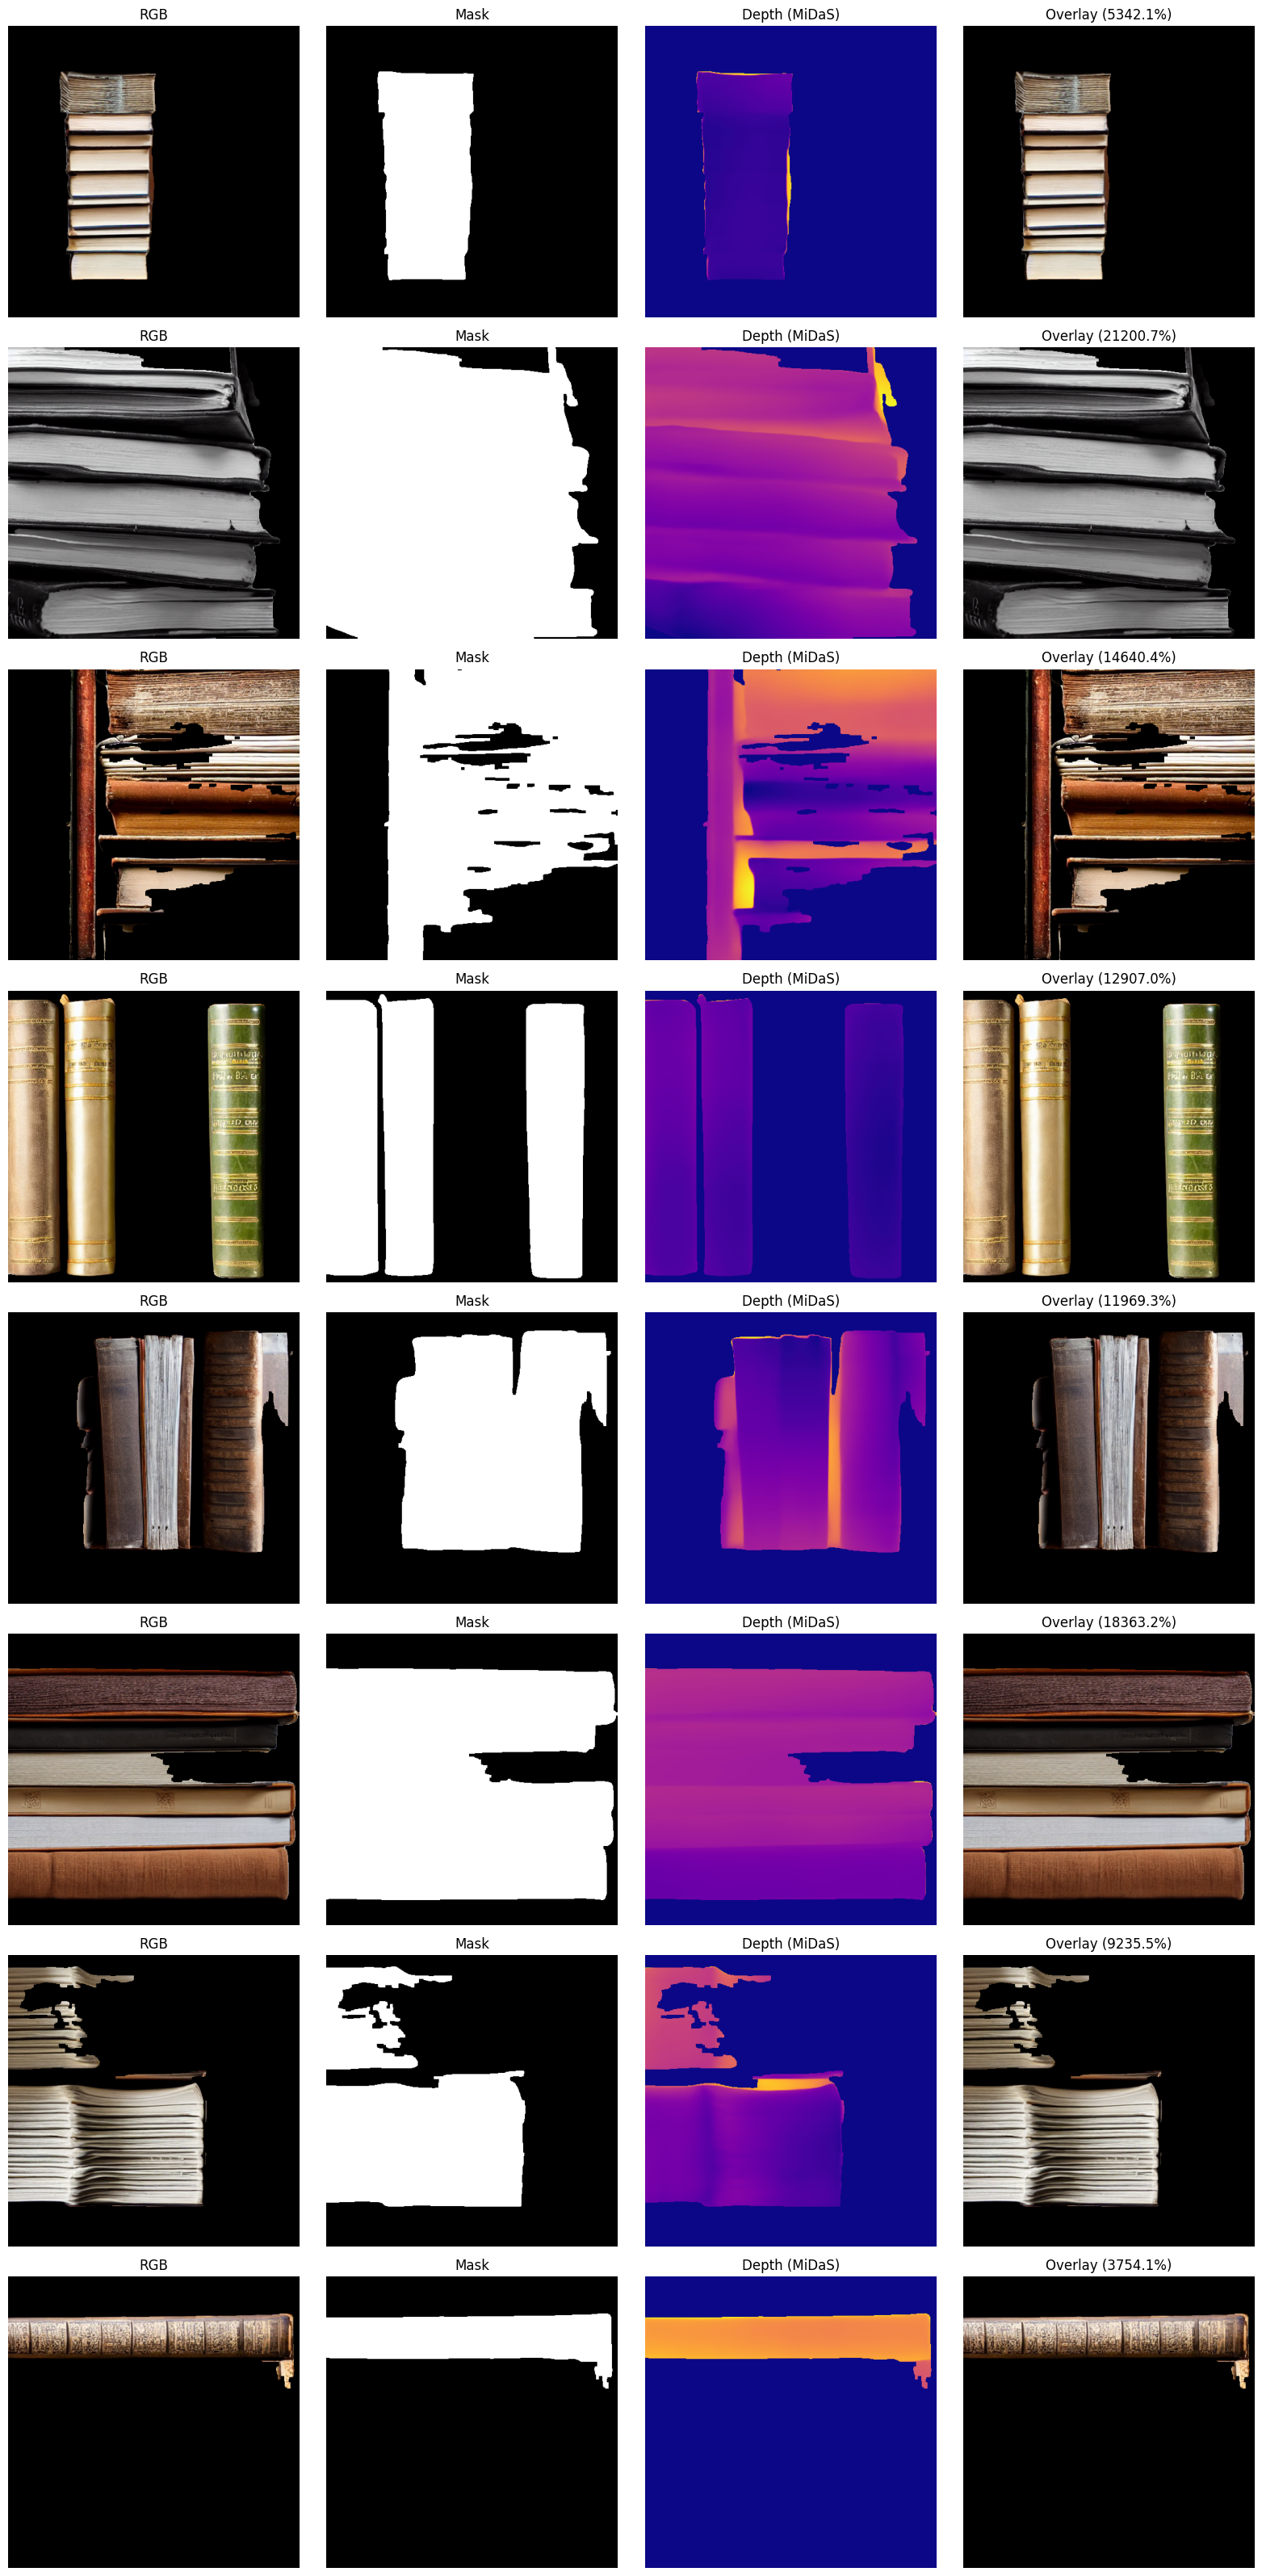

📊 Preview saved to /content/data/synthetic_books/samples_preview.png

🎉 Generation Complete!
   Images: 200
   Directory: /content/data/synthetic_books


In [1]:
"""
Synthetic Books Generator for NYUv2
====================================
1. SDで「白背景の本」を生成（商品撮影スタイル）
2. rembg (U²-Net) で背景を削除

rembgの特徴:
- 色指定で抜くより圧倒的に高精度
- 前景オブジェクトを認識して抽出
- 背景色に依存しない

使い方:
    !pip install rembg[gpu] onnxruntime-gpu
    exec(open('generate_synthetic_books.py').read())
"""

import os
import random
import numpy as np
import cv2
import torch
from PIL import Image
from tqdm import tqdm

# ====== 設定 ======
OUTPUT_DIR = '/content/data/synthetic_books'
NUM_IMAGES = 200
IMAGE_SIZE = 512
SEED = 42
USE_MIDAS_DEPTH = True

# 様々な状態の本（白背景 + rembgで抽出）
PROMPTS = [
    # === 単体 ===
    "photo of a book, white background, studio lighting",
    "single hardcover book, white background, product photography",
    "one paperback book lying flat, white background, studio shot",

    # === 積み重ね（stack/pile） ===
    "stack of books, white background, studio lighting",
    "pile of textbooks stacked, white background, product photo",
    "tall stack of hardcover books, white background, professional",
    "messy pile of books, white background, studio shot",
    "neat stack of three books, white background, product photography",
    "books stacked horizontally, white background, studio lighting",

    # === 並べた状態（row/line） ===
    "row of books standing upright, white background, studio photo",
    "books lined up vertically, white background, product shot",
    "several books standing in a row, white background, professional",
    "book spines in a line, white background, studio lighting",

    # === 本棚風（bookshelf style） ===
    "books on shelf, white background, studio lighting, isolated",
    "bookshelf section with books, white background, product photo",
    "books arranged like bookshelf, white background, professional",
    "library books standing, white background, studio shot",

    # === 複数冊の組み合わせ ===
    "two books leaning against each other, white background, studio",
    "three books at different angles, white background, product photo",
    "books scattered arrangement, white background, studio lighting",
    "open book with closed books, white background, professional",

    # === スタイルバリエーション ===
    "vintage old books stacked, white background, antique style",
    "colorful children books pile, white background, bright colors",
    "academic textbooks row, white background, educational",
    "leather bound books, white background, classic style",
    "modern paperbacks stacked, white background, contemporary",
    "thick reference books, white background, dictionary style",
]

NEGATIVE_PROMPT = (
    "person, hand, human, fingers, "
    "colored background, gradient background, "
    "blurry, low quality, watermark, "
    "cartoon, anime, illustration, 3d render"
)


def setup_sd_pipeline():
    """Stable Diffusion 1.5 パイプラインをセットアップ"""
    from diffusers import StableDiffusionPipeline
    import logging

    # ログレベルを下げてノイズを減らす
    logging.getLogger("diffusers").setLevel(logging.WARNING)

    print("🔧 Loading Stable Diffusion 1.5...")
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None
    ).to("cuda")

    # メモリ最適化
    pipe.enable_attention_slicing()

    # プログレスバーを無効化
    pipe.set_progress_bar_config(disable=True)

    return pipe


def setup_midas():
    """MiDaS深度推定モデルをセットアップ"""
    print("🔧 Loading MiDaS for depth estimation...")

    # MiDaS v3 DPT-Large (高精度)
    midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
    midas.eval().to("cuda")

    # Transform
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform = midas_transforms.dpt_transform

    return midas, transform


def estimate_depth_midas(image_np, midas, transform):
    """
    MiDaSで深度を推定

    Args:
        image_np: RGB numpy array (H, W, 3), uint8
        midas: MiDaSモデル
        transform: MiDaS transform

    Returns:
        depth: 正規化された深度マップ (H, W), 0-1
    """
    # numpy array (uint8) をそのまま使用
    # MiDaS transformは (H, W, 3) のnumpy配列を期待
    input_batch = transform(image_np).to("cuda")

    # transformの出力が辞書の場合
    if isinstance(input_batch, dict):
        input_batch = input_batch["image"]

    # バッチ次元追加
    if input_batch.dim() == 3:
        input_batch = input_batch.unsqueeze(0)

    # 推定
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image_np.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth = prediction.cpu().numpy()

    # 正規化 (0-1)
    depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)

    # MiDaSは近い=大、NYUv2は近い=小なので反転
    depth = 1.0 - depth

    return depth.astype(np.float32)


def setup_rembg():
    """rembg (U²-Net) をセットアップ"""
    try:
        from rembg import new_session
        print("🔧 Loading rembg (U²-Net background removal)...")
        session = new_session("u2net")
        return session
    except ImportError as e:
        print(f"⚠️ rembg not installed: {e}")
        print("   Run: !pip install rembg[gpu] onnxruntime-gpu")
        return None


def extract_books_with_rembg(image_np, rembg_session):
    """
    rembg (U²-Net) で前景（本）を抽出

    Args:
        image_np: RGB numpy array (H, W, 3)
        rembg_session: rembgセッション

    Returns:
        mask: Binary mask (H, W), 1=Books, 0=Background
    """
    from rembg import remove

    # PIL Imageに変換
    pil_img = Image.fromarray(image_np)

    # 背景除去（RGBA出力）
    result = remove(pil_img, session=rembg_session)
    result_np = np.array(result)

    # アルファチャンネルからマスク取得
    if result_np.shape[2] == 4:
        alpha = result_np[:, :, 3]
        mask = (alpha > 128).astype(np.uint8)
    else:
        # アルファがない場合
        mask = np.ones(image_np.shape[:2], dtype=np.uint8)

    # モルフォロジー処理でクリーンアップ
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # 穴を埋める
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # ノイズ除去

    # 小領域除去
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    min_area = mask.shape[0] * mask.shape[1] * 0.01  # 1%以上
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_area:
            mask[labels == i] = 0

    return mask


def compute_edge_map(image_np):
    """エッジマップを計算"""
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge = np.sqrt(sobel_x**2 + sobel_y**2)
    edge = cv2.normalize(edge, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return edge


def validate_generated_image(image_np, mask):
    """生成画像の品質チェック"""

    book_ratio = mask.sum() / mask.size

    # 閾値: 10%〜85%
    if book_ratio < 0.10:
        return False, "too_few_books"

    if book_ratio > 0.85:
        return False, "too_many_books"

    # 連結成分チェック
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    valid_components = 0
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area > 500:
            valid_components += 1

    if valid_components == 0:
        return False, "no_valid_book_shape"

    return True, "ok"


def generate_synthetic_books(sd_pipe, midas, midas_transform, rembg_session, num_images, output_dir):
    """合成本画像を生成"""

    os.makedirs(os.path.join(output_dir, 'rgb'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'mask'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'depth'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'edge'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'visualize'), exist_ok=True)

    random.seed(SEED)
    torch.manual_seed(SEED)

    generated = 0
    attempts = 0
    max_attempts = num_images * 5

    stats = {
        'too_few_books': 0,
        'too_many_books': 0,
        'no_valid_book_shape': 0,
        'ok': 0
    }

    print(f"\n🚀 Starting generation: {num_images} images")
    print(f"   Output dir: {output_dir}")
    print(f"   Extraction: rembg (U²-Net)")
    print("-" * 60)

    while generated < num_images and attempts < max_attempts:
        attempts += 1

        prompt = random.choice(PROMPTS)
        generator = torch.Generator("cuda").manual_seed(SEED + attempts)
        guidance = random.uniform(7.5, 9.0)
        steps = random.randint(25, 35)

        print(f"[{attempts:3d}] SD...", end=" ")

        try:
            # === SD生成 ===
            with torch.no_grad():
                result = sd_pipe(
                    prompt=prompt,
                    negative_prompt=NEGATIVE_PROMPT,
                    num_inference_steps=steps,
                    guidance_scale=guidance,
                    height=IMAGE_SIZE,
                    width=IMAGE_SIZE,
                    generator=generator,
                )

            image = result.images[0]
            image_np = np.array(image)

            # === rembgで本を抽出 ===
            print("rembg...", end=" ")
            mask = extract_books_with_rembg(image_np, rembg_session)

            # === 品質チェック ===
            is_valid, reason = validate_generated_image(image_np, mask)
            stats[reason] += 1

            if not is_valid:
                print(f"❌ {reason}")
                continue

            # === 背景を黒に置換 ===
            image_with_black_bg = image_np.copy()
            image_with_black_bg[mask == 0] = 0

            # === 深度推定 (MiDaS) ===
            if USE_MIDAS_DEPTH and midas is not None:
                depth = estimate_depth_midas(image_np, midas, midas_transform)
                depth[mask == 0] = 0
            else:
                depth = np.ones_like(mask, dtype=np.float32) * 0.5
                depth[mask == 0] = 0

            # === エッジマップ ===
            edge = compute_edge_map(image_np)

            # === 保存 ===
            idx = f"syn_{generated:04d}"

            # RGB: 背景を黒にした画像
            image_bgr = cv2.cvtColor(image_with_black_bg, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(output_dir, 'rgb', f'{idx}.png'), image_bgr)
            cv2.imwrite(os.path.join(output_dir, 'mask', f'{idx}.png'), mask * 255)
            cv2.imwrite(os.path.join(output_dir, 'depth', f'{idx}.png'),
                        (depth * 65535).astype(np.uint16))
            cv2.imwrite(os.path.join(output_dir, 'edge', f'{idx}.png'), edge)

            # === 可視化画像を保存 ===
            # 元画像 | マスク | 抽出結果（背景シアン）
            mask_3d = mask[:, :, None]
            cyan_bg = np.zeros_like(image_np)
            cyan_bg[:, :, 1] = 255
            cyan_bg[:, :, 2] = 255
            masked_cyan = np.where(mask_3d == 1, image_np, cyan_bg).astype(np.uint8)

            mask_vis = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2RGB)
            comparison = np.hstack([image_np, mask_vis, masked_cyan])
            comparison_bgr = cv2.cvtColor(comparison, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(output_dir, 'visualize', f'{idx}.png'), comparison_bgr)

            generated += 1
            book_ratio = 100 * mask.sum() / mask.size
            print(f"✅ {idx} ({book_ratio:.0f}%) | {generated}/{num_images}")

        except Exception as e:
            print(f"⚠️ Error: {str(e)[:50]}")
            continue

    print("-" * 60)
    print(f"\n📊 Results:")
    print(f"   Generated:        {generated}/{num_images}")
    print(f"   Total Attempts:   {attempts}")
    print(f"   Success Rate:     {100*generated/max(attempts,1):.1f}%")
    print(f"\n   Rejection Reasons:")
    print(f"   - Too few books:  {stats['too_few_books']}")
    print(f"   - Too many books: {stats['too_many_books']}")
    print(f"   - Invalid shape:  {stats['no_valid_book_shape']}")

    return generated


def visualize_samples(output_dir, num_samples=8):
    """生成結果を可視化"""
    import matplotlib.pyplot as plt

    rgb_dir = os.path.join(output_dir, 'rgb')
    mask_dir = os.path.join(output_dir, 'mask')
    depth_dir = os.path.join(output_dir, 'depth')

    files = sorted(os.listdir(rgb_dir))
    if len(files) > num_samples:
        files = random.sample(files, num_samples)

    rows = len(files)
    fig, axes = plt.subplots(rows, 4, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, fname in enumerate(files):
        rgb = cv2.cvtColor(cv2.imread(os.path.join(rgb_dir, fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
        depth = cv2.imread(os.path.join(depth_dir, fname), cv2.IMREAD_ANYDEPTH) / 65535.0

        # オーバーレイ
        overlay = rgb.copy()
        overlay[mask == 1] = overlay[mask == 1] * 0.5 + np.array([255, 0, 0]) * 0.5

        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"RGB")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(depth, cmap='plasma')
        axes[i, 2].set_title("Depth (MiDaS)")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(overlay.astype(np.uint8))
        axes[i, 3].set_title(f"Overlay ({100*mask.sum()/mask.size:.1f}%)")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'samples_preview.png'), dpi=150)
    plt.show()
    print(f"📊 Preview saved to {output_dir}/samples_preview.png")


def count_blobs(output_dir):
    """生成されたblobの数をカウント"""
    mask_dir = os.path.join(output_dir, 'mask')
    total_blobs = 0

    for fname in os.listdir(mask_dir):
        mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
        num_labels, _, stats, _ = cv2.connectedComponentsWithStats(mask)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] > 500:
                total_blobs += 1

    return total_blobs


def main():
    print("=" * 60)
    print("📚 Synthetic Books Generator for NYUv2")
    print("=" * 60)
    print(f"  Output Dir:     {OUTPUT_DIR}")
    print(f"  Target Images:  {NUM_IMAGES}")
    print(f"  Image Size:     {IMAGE_SIZE}x{IMAGE_SIZE}")
    print(f"  Extraction:     rembg (U²-Net)")
    print(f"  Depth Method:   {'MiDaS DPT-Large' if USE_MIDAS_DEPTH else 'None'}")
    print(f"  Prompts:        {len(PROMPTS)} variations")
    print("=" * 60)

    # rembg セットアップ
    rembg_session = setup_rembg()
    if rembg_session is None:
        print("❌ rembg is required. Install with:")
        print("   !pip install rembg[gpu] onnxruntime-gpu")
        return

    # SD パイプライン
    sd_pipe = setup_sd_pipeline()

    # MiDaS 深度推定
    if USE_MIDAS_DEPTH:
        midas, midas_transform = setup_midas()
    else:
        midas, midas_transform = None, None

    # 生成
    num_generated = generate_synthetic_books(
        sd_pipe, midas, midas_transform, rembg_session, NUM_IMAGES, OUTPUT_DIR
    )

    # メモリ解放
    del sd_pipe
    if midas is not None:
        del midas
    torch.cuda.empty_cache()

    # 統計
    if num_generated > 0:
        total_blobs = count_blobs(OUTPUT_DIR)
        print(f"\n📦 Total Book Blobs: {total_blobs}")
        print(f"   (Average {total_blobs/max(num_generated,1):.1f} blobs per image)")

        visualize_samples(OUTPUT_DIR)

    print("\n" + "=" * 60)
    print("🎉 Generation Complete!")
    print(f"   Images: {num_generated}")
    print(f"   Directory: {OUTPUT_DIR}")
    print("=" * 60)


if __name__ == '__main__':
    main()

In [ ]:
"""
Copy-Paste Augmentation 可視化スクリプト V3
============================================
改善点:
- マージン追加（画面端への貼り付け防止）
- 背景クラス間の均等サンプリング（Floor偏り防止）
- データセット本も深度ベースのサイズ補正
- 合成本と実データ本の両方を可視化
"""

import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===========================================
# Config
# ===========================================
class Config:
    DATA_ROOT = '/content/data'
    CLASSES = 13
    MAX_DEPTH_VAL = 10000.0  # mm (10m)

    # NYUv2 Kinect camera parameters (VGA 640x480)
    FOCAL_LENGTH = 518.86  # pixels
    IMG_WIDTH = 640
    IMG_HEIGHT = 480

    # 貼り付け設定
    PASTE_TARGETS = [1]
    PASTE_BACKGROUNDS = [4, 5, 9]  # Floor, Furniture, Table
    PASTE_MARGIN_RATIO = 0.1  # 画面端からのマージン（10%）
    MIN_MARGIN = 30  # 最小マージン（ピクセル）

    # 本の実サイズ（mm）
    BOOK_REAL_SIZE_MM = 300  # 30cm
    BOOK_SIZE_VARIATION = 0.3  # ±30%のばらつき

    # 合成本設定
    SYNTHETIC_BOOKS_DIR = '/content/data/synthetic_books'
    SYNTHETIC_RATIO = 0.5  # 合成本を使う確率

    # クラスID
    BED, BOOKS, CEILING, CHAIR, FLOOR, FURNITURE = 0, 1, 2, 3, 4, 5
    OBJECTS, PICTURE, SOFA, TABLE, TV, WALL, WINDOW = 6, 7, 8, 9, 10, 11, 12

    CLASS_NAMES = [
        "Bed", "Books", "Ceiling", "Chair", "Floor", "Furniture",
        "Objects", "Picture", "Sofa", "Table", "TV", "Wall", "Window"
    ]


# ===========================================
# 法線ベクトル計算
# ===========================================
def compute_normals_from_depth(depth_mm, fx=Config.FOCAL_LENGTH, fy=Config.FOCAL_LENGTH):
    """深度画像から法線ベクトルを計算"""
    H, W = depth_mm.shape

    u = np.arange(W)
    v = np.arange(H)
    u, v = np.meshgrid(u, v)

    cx, cy = W / 2, H / 2
    Z = depth_mm.astype(np.float64)
    Z[Z == 0] = np.nan

    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy

    dXdu = np.gradient(X, axis=1)
    dYdu = np.gradient(Y, axis=1)
    dZdu = np.gradient(Z, axis=1)

    dXdv = np.gradient(X, axis=0)
    dYdv = np.gradient(Y, axis=0)
    dZdv = np.gradient(Z, axis=0)

    nx = dYdu * dZdv - dZdu * dYdv
    ny = dZdu * dXdv - dXdu * dZdv
    nz = dXdu * dYdv - dYdu * dXdv

    norm = np.sqrt(nx**2 + ny**2 + nz**2) + 1e-10
    nx /= norm
    ny /= norm
    nz /= norm

    normals = np.stack([nx, ny, nz], axis=-1)
    valid_mask = ~np.isnan(normals).any(axis=-1) & (depth_mm > 100)

    return normals, valid_mask


def find_horizontal_surface(depth_mm, label, target_classes=[5, 9]):
    """法線ベクトルを使って水平面（天板）を検出"""
    normals, valid_mask = compute_normals_from_depth(depth_mm)

    class_mask = np.isin(label, target_classes)
    ny = normals[:, :, 1]
    horizontal = np.abs(ny) > 0.7
    horizontal_mask = horizontal & valid_mask & class_mask

    return horizontal_mask, normals


def depth_to_pixel_size(depth_mm, real_size_mm=Config.BOOK_REAL_SIZE_MM):
    """深度と実サイズからピクセルサイズを計算"""
    if depth_mm < 100:
        return None
    pixel_size = real_size_mm * Config.FOCAL_LENGTH / depth_mm
    return int(pixel_size)


# ===========================================
# Augmentor V3（改善版）
# ===========================================
class VisualizationAugmentorV3:
    """
    改善点:
    - マージン追加（画面端への貼り付け防止）
    - 背景クラス間の均等サンプリング
    - データセット本も深度ベースのサイズ補正
    """

    def __init__(self):
        self.synthetic_bank = []
        self.dataset_bank = []
        self.synthetic_index = 0
        self.dataset_index = 0
        self.load_synthetic_books()
        self.collect_dataset_books()

    def _get_margin(self, H, W):
        """マージンを計算"""
        margin_h = max(Config.MIN_MARGIN, int(H * Config.PASTE_MARGIN_RATIO))
        margin_w = max(Config.MIN_MARGIN, int(W * Config.PASTE_MARGIN_RATIO))
        return margin_h, margin_w

    def load_synthetic_books(self):
        """合成本を読み込み"""
        syn_dir = Config.SYNTHETIC_BOOKS_DIR
        rgb_dir = os.path.join(syn_dir, 'rgb')
        mask_dir = os.path.join(syn_dir, 'mask')

        if not os.path.exists(rgb_dir):
            print(f"⚠️ Synthetic books not found: {rgb_dir}")
            return

        print(f"📚 Loading Synthetic Books...")
        files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])[:100]

        for fname in files:
            rgb = cv2.imread(os.path.join(rgb_dir, fname))
            if rgb is None:
                continue
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            mask = (mask > 127).astype(np.uint8)

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)

            for j in range(1, num_labels):
                area = stats[j, cv2.CC_STAT_AREA]
                if area < 400:
                    continue

                x, y = stats[j, cv2.CC_STAT_LEFT], stats[j, cv2.CC_STAT_TOP]
                w, h = stats[j, cv2.CC_STAT_WIDTH], stats[j, cv2.CC_STAT_HEIGHT]

                if w < 20 or h < 20 or w / h > 10 or h / w > 10:
                    continue

                blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                blob_rgb = rgb[y:y+h, x:x+w]

                self.synthetic_bank.append({
                    'rgb': blob_rgb,
                    'mask': blob_mask,
                    'original_size': max(h, w),
                    'class_id': 1,
                    'source': 'synthetic'
                })

        print(f"   -> Loaded {len(self.synthetic_bank)} synthetic book blobs")

    def collect_dataset_books(self):
        """データセットから本を収集（深度情報付き）"""
        img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
        depth_dir = os.path.join(Config.DATA_ROOT, 'train', 'depth')
        label_dir = os.path.join(Config.DATA_ROOT, 'train', 'label')

        if not os.path.exists(img_dir):
            print(f"⚠️ Dataset not found: {img_dir}")
            return

        print(f"📖 Collecting Dataset Books...")
        all_ids = sorted([f.replace('.png', '') for f in os.listdir(img_dir) if f.endswith('.png')])

        for id_ in tqdm(all_ids[:200], desc="Scanning"):
            image = cv2.imread(os.path.join(img_dir, f"{id_}.png"))
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            depth_raw = cv2.imread(os.path.join(depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
            if depth_raw is None:
                continue
            depth_mm = np.clip(depth_raw.astype(np.float32), 0, Config.MAX_DEPTH_VAL)

            label = cv2.imread(os.path.join(label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue

            # Books (class 1) を検出
            class_mask = (label == 1).astype(np.uint8)
            if class_mask.sum() < 200:
                continue

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(class_mask)

            for j in range(1, num_labels):
                area = stats[j, cv2.CC_STAT_AREA]
                if area < 200 or area > 50000:
                    continue

                x = stats[j, cv2.CC_STAT_LEFT]
                y = stats[j, cv2.CC_STAT_TOP]
                w = stats[j, cv2.CC_STAT_WIDTH]
                h = stats[j, cv2.CC_STAT_HEIGHT]

                if w < 15 or h < 15 or w / h > 10 or h / w > 10:
                    continue

                blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                blob_rgb = image[y:y+h, x:x+w]
                blob_depth = depth_mm[y:y+h, x:x+w]

                # 有効な深度の平均を計算
                valid_depth = blob_depth[blob_mask > 0]
                if len(valid_depth) == 0:
                    continue
                mean_depth_mm = np.mean(valid_depth)

                if mean_depth_mm < 500 or mean_depth_mm > 8000:
                    continue

                self.dataset_bank.append({
                    'rgb': blob_rgb,
                    'mask': blob_mask,
                    'mean_depth_mm': mean_depth_mm,
                    'original_pixel_size': max(h, w),
                    'class_id': 1,
                    'source': 'dataset'
                })

        print(f"   -> Collected {len(self.dataset_bank)} dataset book blobs")

    def get_next_blob(self, use_synthetic=True):
        """次のblobを取得"""
        if use_synthetic and self.synthetic_bank:
            blob = self.synthetic_bank[self.synthetic_index]
            self.synthetic_index = (self.synthetic_index + 1) % len(self.synthetic_bank)
            return blob
        elif self.dataset_bank:
            blob = self.dataset_bank[self.dataset_index]
            self.dataset_index = (self.dataset_index + 1) % len(self.dataset_bank)
            return blob
        return None

    def _find_balanced_position(self, depth_mm, label, backgrounds, H, W):
        """
        背景クラス間で均等にサンプリングし、マージン内の位置を選択
        """
        margin_h, margin_w = self._get_margin(H, W)

        # 各背景クラスごとの候補を収集
        candidates_by_class = {}

        for bg_cls in backgrounds:
            bg_mask = (label == bg_cls)
            if not bg_mask.any():
                continue

            # 水平面を検出（テーブル・家具のみ）
            if bg_cls in [5, 9]:  # Furniture, Table
                horizontal_mask, _ = find_horizontal_surface(depth_mm, label, [bg_cls])
                combined_mask = horizontal_mask
            else:
                combined_mask = bg_mask

            # マージン内に限定
            margin_mask = np.zeros_like(combined_mask)
            margin_mask[margin_h:H-margin_h, margin_w:W-margin_w] = True
            combined_mask = combined_mask & margin_mask

            if not combined_mask.any():
                # マージン内に候補がない場合はマスクなしで再試行
                combined_mask = bg_mask & margin_mask
                if not combined_mask.any():
                    continue

            ys, xs = np.where(combined_mask)
            candidates = []

            # 各クラスから最大30候補をサンプリング
            sample_indices = np.random.choice(len(ys), min(30, len(ys)), replace=False)
            for idx in sample_indices:
                y, x = ys[idx], xs[idx]
                d = depth_mm[y, x]
                if d > 500 and d < 8000:
                    candidates.append((y, x, d, bg_cls))

            if candidates:
                candidates_by_class[bg_cls] = candidates

        if not candidates_by_class:
            return None, None, None

        # クラスを均等に選択（Floorの偏りを防ぐ）
        selected_class = random.choice(list(candidates_by_class.keys()))
        y, x, paste_depth, _ = random.choice(candidates_by_class[selected_class])

        return (y, x), paste_depth, selected_class

    def _compute_target_size(self, blob, paste_depth_mm):
        """深度ベースのサイズ計算"""
        if blob['source'] == 'synthetic':
            # 合成本: 実サイズベース（30cm ± 30%）
            size_variation = 1.0 + random.uniform(-Config.BOOK_SIZE_VARIATION, Config.BOOK_SIZE_VARIATION)
            real_size = Config.BOOK_REAL_SIZE_MM * size_variation
            target_size = depth_to_pixel_size(paste_depth_mm, real_size)
        else:
            # データセット本: 深度比でスケール
            original_depth_mm = blob.get('mean_depth_mm', 2000)
            original_pixel_size = blob.get('original_pixel_size', 50)

            # 深度比: 近くなれば大きく、遠くなれば小さく
            depth_ratio = original_depth_mm / (paste_depth_mm + 1e-6)

            # ばらつきを追加
            variation = random.uniform(0.8, 1.2)
            target_size = int(original_pixel_size * depth_ratio * variation)

        # 範囲制限
        if target_size is None:
            return None
        return max(30, min(target_size, 200))

    def apply(self, image_rgb, depth_mm, label, use_synthetic=None):
        """
        マージン + 均等サンプリング + 深度ベースサイズ + オクルージョン処理で貼り付け
        """
        if use_synthetic is None:
            use_synthetic = random.random() < Config.SYNTHETIC_RATIO

        blob = self.get_next_blob(use_synthetic)
        if blob is None:
            return image_rgb, label, None

        H, W = label.shape
        margin_h, margin_w = self._get_margin(H, W)

        # 均等サンプリング + マージン適用
        pos, paste_depth_mm, selected_bg = self._find_balanced_position(
            depth_mm, label, Config.PASTE_BACKGROUNDS, H, W
        )
        if pos is None:
            return image_rgb, label, None

        y_t, x_t = pos

        # 深度ベースのサイズ計算
        target_pixel_size = self._compute_target_size(blob, paste_depth_mm)
        if target_pixel_size is None:
            return image_rgb, label, None

        # 本をリサイズ
        blob_h, blob_w = blob['mask'].shape
        scale = target_pixel_size / max(blob_h, blob_w)
        new_w = int(blob_w * scale)
        new_h = int(blob_h * scale)

        if new_w < 15 or new_h < 15:
            return image_rgb, label, None

        blob_rgb = cv2.resize(blob['rgb'], (new_w, new_h))
        blob_mask = cv2.resize(blob['mask'], (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        # 回転
        k = random.choice([0, 1, 2, 3])
        if k > 0:
            blob_rgb = np.rot90(blob_rgb, k)
            blob_mask = np.rot90(blob_mask, k)

        new_h, new_w = blob_rgb.shape[:2]

        # マージンを考慮した位置調整
        if new_h >= H - 2 * margin_h or new_w >= W - 2 * margin_w:
            return image_rgb, label, None

        y_t = min(max(margin_h, y_t - new_h // 2), H - new_h - margin_h)
        x_t = min(max(margin_w, x_t - new_w // 2), W - new_w - margin_w)

        if y_t < 0 or x_t < 0 or y_t + new_h > H or x_t + new_w > W:
            return image_rgb, label, None

        # ========================================
        # 深度ベースのオクルージョン処理
        # ========================================
        roi_depth = depth_mm[y_t:y_t+new_h, x_t:x_t+new_w]

        # 本の深度（本の厚み50mmを考慮して、少し手前に配置）
        book_thickness_mm = 50
        book_depth = paste_depth_mm - book_thickness_mm

        # 本が既存オブジェクトより手前にある部分のみ貼り付け
        # book_depth < roi_depth → 本が手前 → 貼り付けOK
        # book_depth >= roi_depth → 既存オブジェクトが手前 → 隠れる
        is_in_front = book_depth < (roi_depth + 50)  # 50mmのマージン

        # 最終マスク = 本のマスク AND 手前にある部分
        final_mask = (blob_mask == 1) & is_in_front

        # 貼り付けるピクセルがない場合はスキップ
        if final_mask.sum() < 100:
            return image_rgb, label, None

        # オクルージョン率を計算
        original_pixels = (blob_mask == 1).sum()
        visible_pixels = final_mask.sum()
        occlusion_rate = 1.0 - (visible_pixels / original_pixels) if original_pixels > 0 else 0

        mask_3 = np.stack([final_mask] * 3, axis=2)

        image_after = image_rgb.copy()
        image_after[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
            mask_3, blob_rgb, image_after[y_t:y_t+new_h, x_t:x_t+new_w]
        )

        # 境界を除いたラベル貼り付け
        kernel = np.ones((5, 5), np.uint8)
        inner_mask = cv2.erode(final_mask.astype(np.uint8), kernel, iterations=1)
        boundary_mask = final_mask & ~inner_mask.astype(bool)

        label_after = label.copy()
        label_after[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
            inner_mask.astype(bool), 1, label_after[y_t:y_t+new_h, x_t:x_t+new_w]
        )
        label_after[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
            boundary_mask, 255, label_after[y_t:y_t+new_h, x_t:x_t+new_w]
        )

        paste_info = {
            'y': y_t, 'x': x_t, 'h': new_h, 'w': new_w,
            'depth_mm': paste_depth_mm,
            'pixel_size': target_pixel_size,
            'source': blob['source'],
            'background_class': Config.CLASS_NAMES[selected_bg],
            'original_depth_mm': blob.get('mean_depth_mm', None),
            'original_size': blob.get('original_pixel_size', None),
            'occlusion_rate': occlusion_rate,  # オクルージョン率を追加
        }

        return image_after, label_after, paste_info


# ===========================================
# 可視化関数
# ===========================================
def create_label_colormap():
    colors = np.array([
        [255, 0, 0],      # Bed
        [0, 255, 0],      # Books - 緑
        [0, 0, 255],      # Ceiling
        [255, 255, 0],    # Chair
        [128, 128, 128],  # Floor
        [255, 0, 255],    # Furniture
        [0, 255, 255],    # Objects
        [255, 128, 0],    # Picture
        [128, 0, 255],    # Sofa
        [0, 128, 255],    # Table
        [255, 255, 255],  # TV
        [200, 200, 200],  # Wall
        [128, 255, 0],    # Window
    ], dtype=np.uint8)
    return colors


def colorize_label(label, colors):
    h, w = label.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    for c in range(13):
        mask = label == c
        colored[mask] = colors[c]
    colored[label == 255] = [0, 0, 0]
    return colored


def visualize_normals(normals, valid_mask):
    """法線を可視化（RGB = XYZ）"""
    vis = ((normals + 1) / 2 * 255).astype(np.uint8)
    vis[~valid_mask] = [128, 128, 128]
    return vis


def visualize_margin_region(H, W, margin_h, margin_w):
    """マージン領域を可視化"""
    vis = np.zeros((H, W, 3), dtype=np.uint8)
    vis[margin_h:H-margin_h, margin_w:W-margin_w] = [0, 255, 0]  # 貼り付け可能領域
    vis[:margin_h, :] = [255, 0, 0]  # 上マージン
    vis[H-margin_h:, :] = [255, 0, 0]  # 下マージン
    vis[:, :margin_w] = [255, 0, 0]  # 左マージン
    vis[:, W-margin_w:] = [255, 0, 0]  # 右マージン
    return vis


def visualize_paste_samples_v3(num_samples=6):
    """Copy-Paste結果を可視化（マージン + 均等サンプリング + 深度ベースサイズ + オクルージョン）"""

    img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
    depth_dir = os.path.join(Config.DATA_ROOT, 'train', 'depth')
    label_dir = os.path.join(Config.DATA_ROOT, 'train', 'label')

    if not os.path.exists(img_dir):
        print(f"❌ Data not found: {img_dir}")
        return

    all_ids = sorted([f.replace('.png', '') for f in os.listdir(img_dir) if f.endswith('.png')])

    # テーブルや家具を含む画像を優先
    good_ids = []
    for id_ in all_ids:
        label = cv2.imread(os.path.join(label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)
        if label is not None:
            uniq = np.unique(label)
            if any(c in uniq for c in [5, 9]):  # Furniture, Table
                good_ids.append(id_)

    random.shuffle(good_ids)
    sample_ids = good_ids[:num_samples]

    print(f"\n📊 Selected {len(sample_ids)} images with Furniture/Table")

    augmentor = VisualizationAugmentorV3()

    if len(augmentor.synthetic_bank) == 0 and len(augmentor.dataset_bank) == 0:
        print("❌ 本が読み込めませんでした")
        return

    colors = create_label_colormap()

    # 6列: Before, After, Label After, Depth, Margin, Occlusion Info
    fig, axes = plt.subplots(num_samples, 6, figsize=(24, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    bg_stats = {4: 0, 5: 0, 9: 0}  # 背景クラスの使用統計
    occlusion_stats = []

    for i, id_ in enumerate(sample_ids):
        # 画像読み込み
        image = cv2.imread(os.path.join(img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        depth_raw = cv2.imread(os.path.join(depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        label = cv2.imread(os.path.join(label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

        if depth_raw is None:
            depth_raw = np.zeros(image.shape[:2], np.uint16)

        depth_mm = depth_raw.astype(np.float64)
        H, W = label.shape

        # 合成本とデータセット本を交互に使用
        use_synthetic = (i % 2 == 0)

        # Copy-Paste実行
        image_after, label_after, paste_info = augmentor.apply(
            image.copy(), depth_mm, label.copy(), use_synthetic=use_synthetic
        )

        # マージン可視化
        margin_h, margin_w = augmentor._get_margin(H, W)
        margin_vis = visualize_margin_region(H, W, margin_h, margin_w)

        # 深度可視化
        depth_vis = (depth_mm / Config.MAX_DEPTH_VAL * 255).astype(np.uint8)
        depth_vis = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)
        depth_vis = cv2.cvtColor(depth_vis, cv2.COLOR_BGR2RGB)

        # 表示
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f'Before (ID: {id_})')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(image_after)
        if paste_info:
            y, x, h, w = paste_info['y'], paste_info['x'], paste_info['h'], paste_info['w']
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
            axes[i, 1].add_patch(rect)

            src = paste_info['source']
            bg = paste_info['background_class']
            occ = paste_info.get('occlusion_rate', 0) * 100

            title = f"After ({src})\n"
            title += f"Depth:{paste_info['depth_mm']:.0f}mm → {paste_info['pixel_size']}px\n"
            title += f"BG: {bg}, Occluded: {occ:.0f}%"

            if paste_info['original_depth_mm']:
                title += f"\nOrig: {paste_info['original_depth_mm']:.0f}mm, {paste_info['original_size']}px"

            # 背景統計を更新
            bg_cls_idx = Config.CLASS_NAMES.index(bg)
            if bg_cls_idx in bg_stats:
                bg_stats[bg_cls_idx] += 1

            occlusion_stats.append(occ)
        else:
            title = "After (no paste)"
        axes[i, 1].set_title(title, fontsize=9)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(colorize_label(label_after, colors))
        axes[i, 2].set_title('Label After')
        axes[i, 2].axis('off')

        # 深度マップ表示
        axes[i, 3].imshow(depth_vis)
        if paste_info:
            y, x, h, w = paste_info['y'], paste_info['x'], paste_info['h'], paste_info['w']
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='white', linewidth=2)
            axes[i, 3].add_patch(rect)
        axes[i, 3].set_title(f'Depth (Blue=Near, Red=Far)')
        axes[i, 3].axis('off')

        # マージン領域表示
        axes[i, 4].imshow(margin_vis)
        axes[i, 4].set_title(f'Margin ({Config.PASTE_MARGIN_RATIO*100:.0f}%)\nGreen=OK, Red=NG')
        axes[i, 4].axis('off')

        # オクルージョン情報
        if paste_info:
            occ_text = f"Occlusion Analysis\n\n"
            occ_text += f"Book depth: {paste_info['depth_mm']-50:.0f}mm\n"
            occ_text += f"Occluded: {paste_info.get('occlusion_rate', 0)*100:.1f}%\n\n"
            occ_text += f"Visible pixels shown\n"
            occ_text += f"Hidden by closer objects"
            axes[i, 5].text(0.1, 0.5, occ_text, fontsize=10, verticalalignment='center',
                           transform=axes[i, 5].transAxes, family='monospace')
        axes[i, 5].set_title('Occlusion Info')
        axes[i, 5].axis('off')

    plt.tight_layout()

    out_path = '/content/paste_visualization_v3.png'
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()

    # 統計を表示
    print(f"\n📊 背景クラス使用統計:")
    print(f"   Floor (4):     {bg_stats[4]}")
    print(f"   Furniture (5): {bg_stats[5]}")
    print(f"   Table (9):     {bg_stats[9]}")

    if occlusion_stats:
        print(f"\n📊 オクルージョン統計:")
        print(f"   平均: {np.mean(occlusion_stats):.1f}%")
        print(f"   最大: {np.max(occlusion_stats):.1f}%")
        print(f"   最小: {np.min(occlusion_stats):.1f}%")

    print(f"\n💾 Saved to {out_path}")


def analyze_depth_scaling():
    """深度ベーススケーリングの効果を分析"""
    print("\n" + "="*60)
    print("深度ベーススケーリングの効果")
    print("="*60)

    print("\n【合成本】実サイズ30cmからの計算:")
    print(f"{'貼付深度(mm)':<15} {'貼付深度(m)':<12} {'ピクセルサイズ':<15}")
    print("-" * 45)
    for d in [1000, 1500, 2000, 2500, 3000, 4000, 5000]:
        px = depth_to_pixel_size(d, Config.BOOK_REAL_SIZE_MM)
        print(f"{d:<15} {d/1000:<12.1f} {px:<15}")

    print("\n【データセット本】深度比でスケール:")
    print("  元の本: 2000mmの位置で100px")
    print(f"{'貼付深度(mm)':<15} {'深度比':<12} {'新サイズ(px)':<15}")
    print("-" * 45)
    original_depth = 2000
    original_size = 100
    for d in [1000, 1500, 2000, 2500, 3000, 4000, 5000]:
        ratio = original_depth / d
        new_size = int(original_size * ratio)
        print(f"{d:<15} {ratio:<12.2f} {new_size:<15}")


def analyze_margin_effect():
    """マージンの効果を分析"""
    print("\n" + "="*60)
    print("マージンの効果")
    print("="*60)

    sizes = [(480, 640), (640, 640), (512, 512)]

    for H, W in sizes:
        margin_h = max(Config.MIN_MARGIN, int(H * Config.PASTE_MARGIN_RATIO))
        margin_w = max(Config.MIN_MARGIN, int(W * Config.PASTE_MARGIN_RATIO))

        usable_h = H - 2 * margin_h
        usable_w = W - 2 * margin_w
        usable_area = (usable_h * usable_w) / (H * W) * 100

        print(f"\n画像サイズ: {H}×{W}")
        print(f"  マージン: 上下{margin_h}px, 左右{margin_w}px")
        print(f"  使用可能領域: {usable_h}×{usable_w} ({usable_area:.1f}%)")


if __name__ == '__main__':
    print("=" * 60)
    print("Copy-Paste Visualization V3")
    print("=" * 60)
    print("改善点:")
    print("  - マージン追加（画面端への貼り付け防止）")
    print("  - 背景クラス間の均等サンプリング")
    print("  - データセット本も深度ベースのサイズ補正")
    print("  - 深度ベースのオクルージョン処理（手前のオブジェクトで隠れる）")
    print("=" * 60)

    # 1. 深度スケーリングの効果を表示
    analyze_depth_scaling()

    # 2. マージンの効果を表示
    analyze_margin_effect()

    # 3. Copy-Paste結果の可視化
    print("\n[可視化] Copy-Paste結果")
    visualize_paste_samples_v3(6)

In [ ]:
!pip install rembg[gpu] onnxruntime-gpu

In [ ]:
"""
NYUv2 VPD V9.7 - V9.5学習手法 + Guided Upsampling
  Best mIoU:  0.7547
  Best Books: 0.3020
==================================================
V9.5からの継承:
- Copy-Paste (prob=0.3)
- Book Boost (2x)
- 境界Ignore (2px)
- 明度調整 (Lチャンネル)
- 合成本対応
- 法線ベース水平面検出
- 深度ベース実サイズ貼り付け
- FPN + PPM

V9.7の追加:
- 元画像から高解像度特徴を抽出 (ImageFeatureEncoder)
- 80×80 → 640×640 を段階的にアップサンプル
- 各スケールで元画像特徴と融合（Skip Connection）
"""

import os
import json
import random
import time
import datetime
import pytz
import shutil
import zipfile
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Libraries
try:
    from diffusers import StableDiffusionPipeline
    HAS_DIFFUSERS = True
except ImportError:
    HAS_DIFFUSERS = False
    print("⚠️ 'diffusers' not found")

try:
    import segmentation_models_pytorch as smp
    from segmentation_models_pytorch.losses import LovaszLoss, SoftCrossEntropyLoss
    HAS_SMP = True
except ImportError:
    HAS_SMP = False
    print("⚠️ 'segmentation_models_pytorch' not found - using fallback losses")

    class SoftCrossEntropyLoss(nn.Module):
        def __init__(self, smooth_factor=0.1, ignore_index=255):
            super().__init__()
            self.smooth_factor = smooth_factor
            self.ignore_index = ignore_index

        def forward(self, logits, targets):
            num_classes = logits.shape[1]
            valid_mask = (targets != self.ignore_index)
            targets_clamped = targets.clone()
            targets_clamped[~valid_mask] = 0
            one_hot = F.one_hot(targets_clamped, num_classes).permute(0, 3, 1, 2).float()
            smooth_targets = one_hot * (1 - self.smooth_factor) + self.smooth_factor / num_classes
            log_probs = F.log_softmax(logits, dim=1)
            loss = -smooth_targets * log_probs
            loss = loss.sum(dim=1)
            loss = loss[valid_mask]
            return loss.mean() if loss.numel() > 0 else torch.tensor(0.0, device=logits.device)

    class LovaszLoss(nn.Module):
        def __init__(self, mode='multiclass', ignore_index=255):
            super().__init__()
            self.ignore_index = ignore_index

        def lovasz_grad(self, gt_sorted):
            gts = gt_sorted.sum()
            intersection = gts - gt_sorted.float().cumsum(0)
            union = gts + (1 - gt_sorted).float().cumsum(0)
            jaccard = 1. - intersection / union
            if len(jaccard) > 1:
                jaccard[1:] = jaccard[1:] - jaccard[:-1]
            return jaccard

        def lovasz_softmax_flat(self, probs, labels):
            C = probs.shape[0]
            losses = []
            for c in range(C):
                fg = (labels == c).float()
                if fg.sum() == 0:
                    continue
                errors = (fg - probs[c]).abs()
                errors_sorted, perm = torch.sort(errors, descending=True)
                fg_sorted = fg[perm]
                grad = self.lovasz_grad(fg_sorted)
                losses.append(torch.dot(errors_sorted, grad))
            return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=probs.device)

        def forward(self, logits, targets):
            probs = F.softmax(logits, dim=1)
            valid_mask = (targets != self.ignore_index)
            vprobas = probs.permute(0, 2, 3, 1).reshape(-1, probs.shape[1])[valid_mask.reshape(-1)]
            vlabels = targets.reshape(-1)[valid_mask.reshape(-1)]
            if vprobas.numel() == 0:
                return torch.tensor(0.0, device=logits.device)
            return self.lovasz_softmax_flat(vprobas.t(), vlabels)


# ==========================================
# 0. A100 Optimization
# ==========================================
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

try:
    torch.backends.cuda.matmul.fp32_precision = 'tf32'
    torch.backends.cudnn.conv.fp32_precision = 'tf32'
except AttributeError:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True


# ==========================================
# 1. Configuration
# ==========================================
def get_jst_time_str():
    return datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M%S')


class Config:
    DATA_ROOT = '/content/data'
    MODEL_ID = "runwayml/stable-diffusion-v1-5"

    CLASSES = 13
    INPUT_CHANNELS = 5

    # A100設定
    IMG_SIZE = 640
    CROP_SIZE = 448
    BATCH_SIZE = 8
    NUM_WORKERS = 12
    PERSISTENT_WORKERS = True
    PIN_MEMORY = True
    USE_COMPILE = True  # V9.7: 有効化
    COMPILE_MODE = 'reduce-overhead'

    EPOCHS_VPD = 30
    EARLY_STOPPING_PATIENCE = 30

    LR_BACKBONE = 5e-5
    LR_DECODER = 5e-4

    WEIGHT_DECAY = 0.01
    SEED = 42
    device = torch.device('cuda')

    # V9.5: Copy-Paste設定
    PASTE_PROB = 0.3
    BOOK_BOOST_FACTOR = 2
    OTHER_BOOST_FACTOR = 1
    MIX_ORIGINAL = True
    PASTE_TARGETS = [1]
    PASTE_BACKGROUNDS = [4, 5, 9]
    BOOK_CROP_PROB = 0.3
    BOUNDARY_IGNORE_PIXELS = 2
    # PASTE_MARGIN_RATIO = 0.1  # 論文方式では使用しない

    # V9.5: 合成本設定
    SYNTHETIC_BOOKS_DIR = '/content/data/synthetic_books'
    USE_SYNTHETIC_BOOKS = True
    SYNTHETIC_BOOKS_RATIO = 0.7

    # V9.5: カメラパラメータ
    FOCAL_LENGTH = 518.86
    ORIGINAL_IMG_WIDTH = 640
    ORIGINAL_IMG_HEIGHT = 480
    BOOK_REAL_SIZE_MM = 300
    BOOK_THICKNESS_MM = 50
    BOOK_SIZE_VARIATION = 0.3

    # Depth
    MAX_DEPTH_VAL = 10000.0
    DEPTH_TIMESTEP_PRIOR_WEIGHT = 0.3

    # Loss
    TVERSKY_ALPHA = 0.7
    TVERSKY_BETA = 0.3
    CLASS_WEIGHTS = [1.0, 3.0, 1.0, 1.2, 1.0, 1.2, 2.0, 1.2, 1.0, 1.2, 3.0, 0.8, 1.0]

    # V9.5: FPN設定
    FPN_CHANNELS = 256
    USE_PPM = True

    # V9.7: Guided Upsampling設定
    GUIDE_CHANNELS = 64

    # Logging
    LOG_TIMESTAMP = get_jst_time_str()
    DEBUG_DIR = f'/content/debug_vpd_v9_7_{LOG_TIMESTAMP}'
    DIAGNOSTIC_INTERVAL = 10

    CLASS_NAMES = [
        "Bed", "Books", "Ceiling", "Chair", "Floor", "Furniture",
        "Objects", "Picture", "Sofa", "Table", "TV", "Wall", "Window"
    ]

    BED, BOOKS, CEILING, CHAIR, FLOOR, FURNITURE = 0, 1, 2, 3, 4, 5
    OBJECTS, PICTURE, SOFA, TABLE, TV, WALL, WINDOW = 6, 7, 8, 9, 10, 11, 12


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ==========================================
# 2. 法線ベクトル計算・水平面検出
# ==========================================
def compute_normals_from_depth(depth_mm, fx=None, fy=None):
    fx = fx or Config.FOCAL_LENGTH
    fy = fy or Config.FOCAL_LENGTH

    H, W = depth_mm.shape

    u = np.arange(W)
    v = np.arange(H)
    u, v = np.meshgrid(u, v)

    cx, cy = W / 2, H / 2
    Z = depth_mm.astype(np.float32) + 1e-6
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy

    dXdx = np.zeros_like(X)
    dYdx = np.zeros_like(Y)
    dZdx = np.zeros_like(Z)
    dXdx[:, :-1] = np.diff(X, axis=1)
    dYdx[:, :-1] = np.diff(Y, axis=1)
    dZdx[:, :-1] = np.diff(Z, axis=1)

    dXdy = np.zeros_like(X)
    dYdy = np.zeros_like(Y)
    dZdy = np.zeros_like(Z)
    dXdy[:-1, :] = np.diff(X, axis=0)
    dYdy[:-1, :] = np.diff(Y, axis=0)
    dZdy[:-1, :] = np.diff(Z, axis=0)

    nx = dYdx * dZdy - dZdx * dYdy
    ny = dZdx * dXdy - dXdx * dZdy
    nz = dXdx * dYdy - dYdx * dXdy

    norm = np.sqrt(nx**2 + ny**2 + nz**2) + 1e-6
    nx /= norm
    ny /= norm
    nz /= norm

    return np.stack([nx, ny, nz], axis=-1)


def find_horizontal_surface(depth_mm, label, target_classes, normal_threshold=0.7):
    H, W = depth_mm.shape
    horizontal_mask = np.zeros((H, W), dtype=bool)

    normals = compute_normals_from_depth(depth_mm)
    ny = normals[:, :, 1]
    is_horizontal = np.abs(ny) > normal_threshold

    for cls in target_classes:
        class_mask = (label == cls)
        horizontal_mask |= (class_mask & is_horizontal)

    return horizontal_mask, normals


def depth_to_pixel_size(depth_mm, real_size_mm, current_img_size):
    scale_factor = current_img_size / Config.ORIGINAL_IMG_WIDTH
    focal_length_scaled = Config.FOCAL_LENGTH * scale_factor

    pixel_size = (real_size_mm * focal_length_scaled) / (depth_mm + 1e-6)
    return int(pixel_size)


# ==========================================
# 3. CopyPasteAugmentor (V9.7改善版)
# ==========================================
class CopyPasteAugmentor:
    """
    論文方式（Ghiasi et al. CVPR 2021）:
    - 位置: 完全ランダム（背景クラス考慮なし）
    - サイズ: 深度ベースで計算（Large Scale Jitteringの代わり）
    - オクルージョン: 深度ベースで判定
    """

    def __init__(self, dataset, targets=[1], backgrounds=[4, 5, 9], prob=0.3):
        self.targets = targets
        self.backgrounds = backgrounds  # 使わないが互換性のため残す
        self.prob = prob
        self.banks = {t: [] for t in targets}
        self.synthetic_bank = []
        self.synthetic_index = 0

    def _compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def _get_next_synthetic(self):
        if not self.synthetic_bank:
            return None
        blob = self.synthetic_bank[self.synthetic_index]
        self.synthetic_index = (self.synthetic_index + 1) % len(self.synthetic_bank)
        return blob

    def load_synthetic_books(self):
        if not Config.USE_SYNTHETIC_BOOKS:
            return

        syn_dir = Config.SYNTHETIC_BOOKS_DIR
        rgb_dir = os.path.join(syn_dir, 'rgb')
        mask_dir = os.path.join(syn_dir, 'mask')
        depth_dir = os.path.join(syn_dir, 'depth')

        if not os.path.exists(rgb_dir):
            print(f"⚠️ Synthetic books not found: {rgb_dir}")
            return

        print(f"📚 Loading Synthetic Books from {syn_dir}...")
        files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])

        for fname in tqdm(files, desc="Loading synthetic"):
            rgb = cv2.imread(os.path.join(rgb_dir, fname))
            if rgb is None:
                continue
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            mask = (mask > 127).astype(np.uint8)

            depth_path = os.path.join(depth_dir, fname)
            if os.path.exists(depth_path):
                depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                depth = depth.astype(np.float32) / 65535.0
            else:
                depth = np.ones_like(mask, dtype=np.float32) * 0.5

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)

            for j in range(1, num_labels):
                area = stats[j, cv2.CC_STAT_AREA]
                if area < 400:
                    continue

                x = stats[j, cv2.CC_STAT_LEFT]
                y = stats[j, cv2.CC_STAT_TOP]
                w = stats[j, cv2.CC_STAT_WIDTH]
                h = stats[j, cv2.CC_STAT_HEIGHT]

                if w < 20 or h < 20 or w / h > 10 or h / w > 10:
                    continue

                blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                blob_rgb = rgb[y:y+h, x:x+w]
                blob_depth = depth[y:y+h, x:x+w]
                edge = self._compute_edge_map(blob_rgb)

                self.synthetic_bank.append({
                    'rgb': blob_rgb, 'depth': blob_depth, 'edge': edge,
                    'mask': blob_mask, 'mean_depth': np.mean(blob_depth[blob_mask > 0]) if blob_mask.sum() > 0 else 0.5,
                    'class_id': 1, 'source': 'synthetic'
                })

        print(f"   -> Loaded {len(self.synthetic_bank)} synthetic book blobs")

    def shuffle_synthetic_books(self):
        """合成本バンクをシャッフル"""
        if self.synthetic_bank:
            random.shuffle(self.synthetic_bank)
            self.synthetic_index = 0

    def _adjust_luminance(self, blob_rgb, target_region):
        blob_lab = cv2.cvtColor(blob_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
        target_lab = cv2.cvtColor(target_region, cv2.COLOR_RGB2LAB).astype(np.float32)

        blob_L = blob_lab[:, :, 0]
        target_L = target_lab[:, :, 0]

        blob_mean, blob_std = blob_L.mean(), blob_L.std() + 1e-6
        tgt_mean, tgt_std = target_L.mean(), target_L.std() + 1e-6

        blob_lab[:, :, 0] = (blob_L - blob_mean) / blob_std * tgt_std + tgt_mean
        blob_lab[:, :, 0] = np.clip(blob_lab[:, :, 0], 0, 255)

        return cv2.cvtColor(blob_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

    def _create_boundary_mask(self, mask, ignore_pixels=2):
        kernel = np.ones((ignore_pixels * 2 + 1, ignore_pixels * 2 + 1), np.uint8)
        inner_mask = cv2.erode(mask, kernel, iterations=1)
        boundary_mask = mask.astype(bool) & ~inner_mask.astype(bool)
        return inner_mask, boundary_mask

    def collect_blobs(self, dataset):
        """オリジナル画像からblobを収集（深度をmm単位で保存）"""
        print(f"🛠️ Collecting objects for classes: {self.targets} ...")
        for idx in tqdm(range(len(dataset.ids)), desc="Scanning"):
            id_ = dataset.ids[idx]
            image = cv2.imread(os.path.join(dataset.img_dir, f"{id_}.png"))
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # 深度をmm単位で読み込み
            depth_raw = cv2.imread(os.path.join(dataset.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
            if depth_raw is None:
                depth_raw = np.zeros(image.shape[:2], np.float32)
            depth_mm = np.clip(depth_raw.astype(np.float32), 0, Config.MAX_DEPTH_VAL)

            edge = self._compute_edge_map(image)
            label = cv2.imread(os.path.join(dataset.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

            for target_cls in self.targets:
                class_mask = (label == target_cls).astype(np.uint8)
                if class_mask.sum() < 200:
                    continue

                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(class_mask)
                for j in range(1, num_labels):
                    area = stats[j, cv2.CC_STAT_AREA]
                    if area < 200 or area > 50000:
                        continue

                    x = stats[j, cv2.CC_STAT_LEFT]
                    y = stats[j, cv2.CC_STAT_TOP]
                    w = stats[j, cv2.CC_STAT_WIDTH]
                    h = stats[j, cv2.CC_STAT_HEIGHT]

                    if w < 15 or h < 15 or w / h > 10 or h / w > 10:
                        continue

                    blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                    blob_rgb = image[y:y+h, x:x+w]
                    blob_depth_mm = depth_mm[y:y+h, x:x+w]
                    blob_edge = edge[y:y+h, x:x+w]

                    # blobの平均深度（mm単位で保存）
                    valid_depth = blob_depth_mm[blob_mask > 0]
                    if len(valid_depth) == 0:
                        continue
                    mean_depth_mm = np.mean(valid_depth)

                    # 元のピクセルサイズを保存
                    original_pixel_size = max(h, w)

                    self.banks[target_cls].append({
                        'rgb': blob_rgb,
                        'depth': blob_depth_mm / Config.MAX_DEPTH_VAL,  # 正規化して保存
                        'edge': blob_edge,
                        'mask': blob_mask,
                        'mean_depth_mm': mean_depth_mm,  # mm単位の深度
                        'original_pixel_size': original_pixel_size,  # 元のピクセルサイズ
                        'class_id': target_cls,
                        'source': 'dataset'
                    })

        result = {k: len(v) for k, v in self.banks.items()}
        print(f"✅ Collection Result: {result}")

    def _find_random_position(self, depth_normalized, H, W):
        """
        論文方式: 完全ランダムな位置を選択（背景クラス考慮なし）
        有効な深度を持つ位置のみ選択
        """
        depth_mm = depth_normalized / 255.0 * Config.MAX_DEPTH_VAL

        # 有効な深度を持つ位置を候補にする
        valid_mask = (depth_mm > 500) & (depth_mm < 8000)

        ys, xs = np.where(valid_mask)
        if len(ys) == 0:
            return None, None

        # ランダムに位置を選択
        idx = random.randint(0, len(ys) - 1)
        y, x = ys[idx], xs[idx]
        paste_depth = depth_mm[y, x]

        return (y, x), paste_depth

    def _compute_depth_based_scale(self, blob, paste_depth_mm, current_size):
        """
        深度ベースのスケール計算 + Large Scale Jittering (論文方式)

        論文: LSJ = 0.1〜2.0倍のスケールバリエーション
        """
        if blob['source'] == 'synthetic':
            # 合成本: 実サイズベース
            real_size = Config.BOOK_REAL_SIZE_MM  # 30cm
            base_pixel_size = depth_to_pixel_size(paste_depth_mm, real_size, current_size)
        else:
            # データセット本: 深度比でスケール
            original_depth_mm = blob.get('mean_depth_mm', 2000)
            original_pixel_size = blob.get('original_pixel_size', 50)
            depth_ratio = original_depth_mm / (paste_depth_mm + 1e-6)
            base_pixel_size = int(original_pixel_size * depth_ratio)

        # Large Scale Jittering (論文方式: 0.1〜2.0)
        # 小さすぎると見えなくなるので 0.3〜2.0 に調整
        lsj_scale = random.uniform(0.3, 2.0)
        target_pixel_size = int(base_pixel_size * lsj_scale)

        # 範囲制限（小さすぎ・大きすぎを防ぐ）
        target_pixel_size = max(25, min(target_pixel_size, current_size // 2))

        return target_pixel_size

    def apply(self, image, label):
        if random.random() > self.prob:
            return image, label

        H, W = image.shape[:2]
        depth_normalized = image[:, :, 3]

        for target_cls in self.targets:
            use_synthetic = (
                Config.USE_SYNTHETIC_BOOKS and
                self.synthetic_bank and
                random.random() < Config.SYNTHETIC_BOOKS_RATIO
            )

            if use_synthetic:
                blob = self._get_next_synthetic()
            else:
                if not self.banks[target_cls]:
                    continue
                blob = random.choice(self.banks[target_cls])

            if blob is None:
                continue

            # 論文方式: 完全ランダム位置（背景クラス考慮なし）
            pos, paste_depth_mm = self._find_random_position(depth_normalized, H, W)
            if pos is None:
                continue

            y_t, x_t = pos

            # 深度ベースのサイズ計算
            target_pixel_size = self._compute_depth_based_scale(blob, paste_depth_mm, W)

            blob_h, blob_w = blob['mask'].shape
            scale = target_pixel_size / max(blob_h, blob_w)
            new_w = int(blob_w * scale)
            new_h = int(blob_h * scale)

            if new_w < 16 or new_h < 16 or new_w <= 0 or new_h <= 0:
                continue

            blob_rgb = cv2.resize(blob['rgb'], (new_w, new_h))
            blob_depth = cv2.resize(blob['depth'], (new_w, new_h)) if 'depth' in blob else np.ones((new_h, new_w)) * 0.5
            blob_edge = cv2.resize(blob['edge'], (new_w, new_h)) if 'edge' in blob else self._compute_edge_map(blob_rgb)
            blob_mask = cv2.resize(blob['mask'], (new_w, new_h), interpolation=cv2.INTER_NEAREST)

            if target_cls in [1, 6]:
                k = random.choice([0, 1, 2, 3])
                if k > 0:
                    blob_rgb = np.rot90(blob_rgb, k)
                    blob_depth = np.rot90(blob_depth, k)
                    blob_edge = np.rot90(blob_edge, k)
                    blob_mask = np.rot90(blob_mask, k)
            else:
                if random.random() > 0.5:
                    blob_rgb = np.fliplr(blob_rgb)
                    blob_depth = np.fliplr(blob_depth)
                    blob_edge = np.fliplr(blob_edge)
                    blob_mask = np.fliplr(blob_mask)

            new_h, new_w = blob_rgb.shape[:2]

            # 位置調整（はみ出し防止のみ、マージンなし）
            y_t = min(max(0, y_t - new_h // 2), H - new_h)
            x_t = min(max(0, x_t - new_w // 2), W - new_w)

            # チェック
            if y_t < 0 or x_t < 0 or y_t + new_h > H or x_t + new_w > W:
                continue

            roi_depth = image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
            target_region = image[y_t:y_t+new_h, x_t:x_t+new_w, :3].astype(np.uint8)

            if target_region.size > 0 and blob_rgb.size > 0:
                blob_rgb = self._adjust_luminance(blob_rgb.astype(np.uint8), target_region)

            center_y = min(y_t + new_h//2, H-1)
            center_x = min(x_t + new_w//2, W-1)
            paste_depth_normalized = depth_normalized[center_y, center_x]

            book_thickness_normalized = (Config.BOOK_THICKNESS_MM / Config.MAX_DEPTH_VAL) * 255
            new_depth_value = max(0, paste_depth_normalized - book_thickness_normalized)

            is_in_front = new_depth_value < (roi_depth + 2)
            hard_mask = (blob_mask == 1) & is_in_front

            soft_mask = hard_mask.astype(np.float32)
            soft_mask = cv2.GaussianBlur(soft_mask, (5, 5), sigmaX=1.5)

            final_mask = hard_mask

            inner_mask, boundary_mask = self._create_boundary_mask(
                final_mask.astype(np.uint8), Config.BOUNDARY_IGNORE_PIXELS
            )

            soft_mask_3 = np.stack([soft_mask]*3, axis=2)
            roi_rgb = image[y_t:y_t+new_h, x_t:x_t+new_w, :3].astype(np.float32)
            blob_rgb_f = blob_rgb.astype(np.float32)
            blended_rgb = soft_mask_3 * blob_rgb_f + (1 - soft_mask_3) * roi_rgb
            image[y_t:y_t+new_h, x_t:x_t+new_w, :3] = blended_rgb.astype(np.float32)

            image[y_t:y_t+new_h, x_t:x_t+new_w, 3] = np.where(
                final_mask, new_depth_value, image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
            )

            blob_edge_scaled = blob_edge * 255 if blob_edge.max() <= 1 else blob_edge
            roi_edge = image[y_t:y_t+new_h, x_t:x_t+new_w, 4].astype(np.float32)
            blended_edge = soft_mask * blob_edge_scaled + (1 - soft_mask) * roi_edge
            image[y_t:y_t+new_h, x_t:x_t+new_w, 4] = blended_edge.astype(np.float32)

            label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
                inner_mask.astype(bool), blob['class_id'], label[y_t:y_t+new_h, x_t:x_t+new_w]
            )
            label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
                boundary_mask, 255, label[y_t:y_t+new_h, x_t:x_t+new_w]
            )

        return image, label


# ==========================================
# 4. Dataset (V9.5から継承)
# ==========================================
def get_transforms_train():
    return {
        'color': A.Compose([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5)
        ]),
        'geo': A.Compose([
            A.GridDistortion(p=0.3),
            A.Perspective(p=0.3),
            A.ShiftScaleRotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                       std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
            ToTensorV2()
        ])
    }


def get_transforms_val():
    return A.Compose([
        A.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                   std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ])


class NYUv2DatasetV97(Dataset):
    def __init__(self, root_dir, ids, is_train=False, transform=None, augmentor=None):
        self.root_dir = root_dir
        self.ids = list(ids)
        self.is_train = is_train
        self.transform = transform
        self.augmentor = augmentor

        self.img_dir = os.path.join(root_dir, 'train', 'image')
        self.depth_dir = os.path.join(root_dir, 'train', 'depth')
        self.label_dir = os.path.join(root_dir, 'train', 'label')

        if is_train:
            self._apply_multi_boost()

    def _apply_multi_boost(self):
        print("⚖️ Multi-Boost Strategy (V9: 2x for Books)")
        book_ids = []
        other_ids = []
        target_others = [3, 5, 6, 8, 10]
        base_ids = list(self.ids)

        for id_ in base_ids:
            label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue
            unique_cls = np.unique(label)
            if 1 in unique_cls:
                book_ids.extend([id_] * Config.BOOK_BOOST_FACTOR)
            if any(c in target_others for c in unique_cls):
                other_ids.extend([id_] * Config.OTHER_BOOST_FACTOR)

        anchor_ids = list(base_ids) if Config.MIX_ORIGINAL else []
        self.ids = book_ids + other_ids + anchor_ids
        print(f"   -> Total Train Size: {len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def get_book_centric_crop(self, image, label):
        ys, xs = np.where(label == 1)
        cs = Config.CROP_SIZE
        h, w = image.shape[:2]

        if len(ys) > 0:
            idx = random.randint(0, len(ys) - 1)
            cy, cx = ys[idx], xs[idx]
            y1 = max(0, min(h - cs, cy - cs//2 + random.randint(-50, 50)))
            x1 = max(0, min(w - cs, cx - cs//2 + random.randint(-50, 50)))
        else:
            y1 = random.randint(0, max(0, h - cs))
            x1 = random.randint(0, max(0, w - cs))

        return image[y1:y1+cs, x1:x1+cs], label[y1:y1+cs, x1:x1+cs]

    def __getitem__(self, idx):
        id_ = self.ids[idx]

        image = cv2.imread(os.path.join(self.img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(os.path.join(self.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

        if depth is None:
            depth = np.zeros(image.shape[:2], np.float32)
        else:
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

        label[~((label >= 0) & (label < Config.CLASSES))] = 255
        edge = self.compute_edge_map(image)
        combined = np.dstack([image, depth * 255.0, edge * 255.0]).astype(np.float32)

        if self.is_train:
            if self.augmentor:
                combined, label = self.augmentor.apply(combined, label)

            if random.random() < Config.BOOK_CROP_PROB:
                combined, label = self.get_book_centric_crop(combined, label)

            if self.transform:
                if isinstance(self.transform, dict):
                    rgb_aug = self.transform['color'](image=combined[:,:,:3].astype(np.uint8))['image']
                    t_geo = self.transform['geo'](image=np.dstack([rgb_aug, combined[:,:,3:]]), mask=label)
                    return t_geo['image'], t_geo['mask'].long()
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long()
        else:
            if self.transform:
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long(), id_

        return torch.from_numpy(combined.transpose(2,0,1)).float(), torch.from_numpy(label).long()


# ==========================================
# 5. V9.7 Guided Upsampling Components
# ==========================================
class ImageFeatureEncoder(nn.Module):
    """元画像から各スケールの特徴を抽出"""

    def __init__(self, in_channels=5, base_channels=64):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        f1 = self.conv1(x)
        f2 = self.conv2(f1)
        f3 = self.conv3(f2)
        f4 = self.conv4(f3)

        return {
            'scale_640': f1,
            'scale_320': f2,
            'scale_160': f3,
            'scale_80': f4,
        }


class GuidedUpsampleBlock(nn.Module):
    """低解像度特徴をアップサンプルし、高解像度の元画像特徴と融合"""

    def __init__(self, low_channels, high_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.fusion = nn.Sequential(
            nn.Conv2d(low_channels + high_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        self.attention = nn.Sequential(
            nn.Conv2d(low_channels + high_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.Sigmoid()
        )

    def forward(self, low_feat, high_feat):
        up_feat = self.up(low_feat)

        if up_feat.shape[2:] != high_feat.shape[2:]:
            up_feat = F.interpolate(up_feat, size=high_feat.shape[2:], mode='bilinear', align_corners=False)

        concat = torch.cat([up_feat, high_feat], dim=1)
        att = self.attention(concat)
        out = self.fusion(concat) * att

        return out


class GuidedUpsamplingDecoder(nn.Module):
    """80×80 → 640×640 段階的アップサンプル"""

    def __init__(self, in_channels=256, guide_channels=64, num_classes=13):
        super().__init__()

        self.up1 = GuidedUpsampleBlock(in_channels, guide_channels * 4, 256)
        self.up2 = GuidedUpsampleBlock(256, guide_channels * 2, 128)
        self.up3 = GuidedUpsampleBlock(128, guide_channels, 64)

        self.seg_head = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 1)
        )

    def forward(self, fpn_feat, guide_features):
        x = self.up1(fpn_feat, guide_features['scale_160'])
        x = self.up2(x, guide_features['scale_320'])
        x = self.up3(x, guide_features['scale_640'])
        logits = self.seg_head(x)
        return logits


# ==========================================
# 6. VPD Backbone
# ==========================================
class MultiTimestepVPDExtractor(nn.Module):
    def __init__(self, model_id, device="cuda"):
        super().__init__()
        self.device = device
        print(f"👻 Loading VPD Backbone...")

        self.pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
        self.vae = self.pipe.vae
        self.unet = self.pipe.unet
        self.text_encoder = self.pipe.text_encoder
        self.tokenizer = self.pipe.tokenizer
        self.scheduler = self.pipe.scheduler

        self.vae.requires_grad_(False)
        self.text_encoder.requires_grad_(False)

        for param in self.unet.parameters():
            param.requires_grad = False
        for param in self.unet.mid_block.parameters():
            param.requires_grad = True
        for param in self.unet.up_blocks.parameters():
            param.requires_grad = True

        self.timesteps = [0, 100, 300]

        if hasattr(self.scheduler, 'alphas_cumprod'):
            self.scheduler.alphas_cumprod = self.scheduler.alphas_cumprod.to(device)

        with torch.no_grad():
            prompt = "indoor scene, room, furniture, realistic"
            tokens = self.tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=77)
            self.text_emb = self.text_encoder(tokens.input_ids.to(device))[0]

    def _add_noise(self, latents, t):
        noise = torch.randn_like(latents)
        t_tensor = torch.full((latents.shape[0],), t, device=latents.device, dtype=torch.long)
        return self.scheduler.add_noise(latents, noise, t_tensor)

    def _extract_features_at_timestep(self, latents, t):
        features = {}
        def make_hook(name):
            def hook(model, input, output):
                if isinstance(output, tuple):
                    output = output[0]
                features[name] = output
            return hook

        hooks = []
        hook_configs = [
            (self.unet.down_blocks[1], 'down1'),
            (self.unet.down_blocks[2], 'down2'),
            (self.unet.mid_block, 'mid'),
            (self.unet.up_blocks[1], 'up1'),
            (self.unet.up_blocks[2], 'up2')
        ]
        for module, name in hook_configs:
            hooks.append(module.register_forward_hook(make_hook(name)))

        noisy_latents = self._add_noise(latents, t) if t > 0 else latents
        t_tensor = torch.full((latents.shape[0],), t, device=self.device, dtype=torch.long)
        self.unet(noisy_latents, t_tensor, encoder_hidden_states=self.text_emb.repeat(latents.shape[0], 1, 1))

        for h in hooks:
            h.remove()
        return features

    def forward(self, x):
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        x_sd = (x * std + mean) * 2.0 - 1.0

        with torch.no_grad():
            latents = self.vae.encode(x_sd).latent_dist.mode() * 0.18215

        all_features = {}
        for t in self.timesteps:
            feats = self._extract_features_at_timestep(latents, t)
            for key, val in feats.items():
                all_features[f't{t}_{key}'] = val
        return all_features


# ==========================================
# 7. FPN Decoder (80×80×256を出力)
# ==========================================
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6], out_channels=256):
        super().__init__()
        self.stages = nn.ModuleList()
        for pool_size in pool_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, out_channels // len(pool_sizes), 1, bias=False),
                nn.BatchNorm2d(out_channels // len(pool_sizes)),
                nn.ReLU(inplace=True)
            ))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.shape[2:]
        pyramids = [x]
        for stage in self.stages:
            pyramids.append(F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False))
        return self.bottleneck(torch.cat(pyramids, dim=1))


class FPNDecoder(nn.Module):
    def __init__(self, in_channels_list, fpn_channels=256, use_ppm=True):
        super().__init__()

        self.num_levels = len(in_channels_list)

        self.lateral_convs = nn.ModuleList()
        for in_ch in in_channels_list:
            self.lateral_convs.append(nn.Sequential(
                nn.Conv2d(in_ch, fpn_channels, 1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.fpn_convs = nn.ModuleList()
        for _ in range(self.num_levels):
            self.fpn_convs.append(nn.Sequential(
                nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.use_ppm = use_ppm
        if use_ppm:
            self.ppm = PyramidPoolingModule(fpn_channels, out_channels=fpn_channels)

        fusion_in_channels = fpn_channels * self.num_levels
        self.fusion = nn.Sequential(
            nn.Conv2d(fusion_in_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, features):
        laterals = []
        for i, feat in enumerate(features):
            laterals.append(self.lateral_convs[i](feat))

        sizes = [f.shape[2:] for f in laterals]
        min_idx = min(range(len(sizes)), key=lambda i: sizes[i][0] * sizes[i][1])

        fpn_outs = [None] * self.num_levels
        fpn_outs[min_idx] = self.fpn_convs[min_idx](laterals[min_idx])

        if self.use_ppm:
            fpn_outs[min_idx] = self.ppm(fpn_outs[min_idx])

        for i in range(self.num_levels):
            if i == min_idx:
                continue
            upsampled = F.interpolate(fpn_outs[min_idx], size=sizes[i], mode='bilinear', align_corners=False)
            fpn_outs[i] = self.fpn_convs[i](laterals[i] + upsampled)

        max_size = max(sizes, key=lambda s: s[0] * s[1])
        upsampled_outs = []
        for out in fpn_outs:
            if out.shape[2:] != max_size:
                out = F.interpolate(out, size=max_size, mode='bilinear', align_corners=False)
            upsampled_outs.append(out)

        fused = self.fusion(torch.cat(upsampled_outs, dim=1))
        return fused


# ==========================================
# 8. Timestep Fusion
# ==========================================
class DepthAdaptiveTimestepFusion(nn.Module):
    def __init__(self, feat_channels=256, prior_weight=0.3):
        super().__init__()
        self.prior_weight = prior_weight

        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1),
        )
        self.base_weights = nn.Parameter(torch.ones(3) / 3)

    def _compute_prior_weights(self, depth):
        w_t0 = 1.0 - depth
        w_t100 = torch.exp(-((depth - 0.5) ** 2) / 0.1)
        w_t300 = depth
        prior = torch.cat([w_t0, w_t100, w_t300], dim=1)
        prior = prior / (prior.sum(dim=1, keepdim=True) + 1e-6)
        return prior

    def forward(self, depth, feat_t0, feat_t100, feat_t300):
        B, C, H, W = feat_t0.shape
        depth_resized = F.interpolate(depth, size=(H, W), mode='bilinear', align_corners=False)

        learned_weights = F.softmax(self.depth_encoder(depth_resized), dim=1)
        prior_weights = self._compute_prior_weights(depth_resized)
        combined_weights = (1 - self.prior_weight) * learned_weights + self.prior_weight * prior_weights

        fused = (combined_weights[:, 0:1] * feat_t0 +
                 combined_weights[:, 1:2] * feat_t100 +
                 combined_weights[:, 2:3] * feat_t300)

        return fused, combined_weights


# ==========================================
# 9. V9.7 Complete Model
# ==========================================
class VPDSegmentationModelV97(nn.Module):
    def __init__(self, num_classes=13):
        super().__init__()

        self.backbone = MultiTimestepVPDExtractor(Config.MODEL_ID, device=Config.device)

        # 注意: ここでは.to(device)しない。main()でmodel.to(device)で一括移動する
        self.image_encoder = ImageFeatureEncoder(
            in_channels=5,
            base_channels=Config.GUIDE_CHANNELS
        )

        in_channels_vpd = [640, 1280, 1280, 1280, 640]
        proj_channels = Config.FPN_CHANNELS

        self.proj_layers = nn.ModuleList([
            nn.Sequential(nn.Conv2d(ch, proj_channels, 1), nn.BatchNorm2d(proj_channels), nn.ReLU())
            for ch in in_channels_vpd
        ])

        self.depth_fusions = nn.ModuleList([
            DepthAdaptiveTimestepFusion(proj_channels) for _ in range(5)
        ])

        self.fpn_decoder = FPNDecoder(
            in_channels_list=[proj_channels] * 5,
            fpn_channels=Config.FPN_CHANNELS,
            use_ppm=Config.USE_PPM
        )

        self.guided_decoder = GuidedUpsamplingDecoder(
            in_channels=Config.FPN_CHANNELS,
            guide_channels=Config.GUIDE_CHANNELS,
            num_classes=num_classes
        )

        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"📊 Parameters: {total/1e6:.1f}M total, {trainable/1e6:.1f}M trainable")

    def forward(self, x):
        rgb = x[:, :3]
        depth = x[:, 3:4]

        guide_features = self.image_encoder(x)
        vpd_feats = self.backbone(rgb)

        layer_names = ['down1', 'down2', 'mid', 'up1', 'up2']
        fused_features = []

        for i, name in enumerate(layer_names):
            f0 = self.proj_layers[i](vpd_feats[f't0_{name}'].float())
            f100 = self.proj_layers[i](vpd_feats[f't100_{name}'].float())
            f300 = self.proj_layers[i](vpd_feats[f't300_{name}'].float())
            fused, _ = self.depth_fusions[i](depth, f0, f100, f300)
            fused_features.append(fused)

        fpn_out = self.fpn_decoder(fused_features)
        logits = self.guided_decoder(fpn_out, guide_features)

        return logits


# ==========================================
# 10. Loss
# ==========================================
class HybridLossV97(nn.Module):
    def __init__(self, class_weights, device, alpha=0.3, beta=0.7, ignore_index=255):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.weights = torch.tensor(class_weights).float().to(device)
        self.ignore_index = ignore_index
        self.ce = SoftCrossEntropyLoss(smooth_factor=0.1, ignore_index=ignore_index)
        self.lovasz = LovaszLoss(mode='multiclass', ignore_index=ignore_index)

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        lovasz_loss = self.lovasz(logits, targets)

        probs = F.softmax(logits, dim=1)
        with torch.no_grad():
            targets_masked = targets.clone()
            targets_masked[targets_masked == self.ignore_index] = 0
            true_1_hot = F.one_hot(targets_masked, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()
            valid_mask = (targets != self.ignore_index).float().unsqueeze(1)
            true_1_hot = true_1_hot * valid_mask

        probs = probs * valid_mask
        tp = torch.sum(probs * true_1_hot, dim=(0, 2, 3))
        fp = torch.sum(probs * (1 - true_1_hot), dim=(0, 2, 3))
        fn = torch.sum((1 - probs) * true_1_hot, dim=(0, 2, 3))
        tversky_score = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
        tversky_loss = (1 - tversky_score) * self.weights

        return 0.4 * ce_loss + 0.3 * tversky_loss.mean() + 0.3 * lovasz_loss


# ==========================================
# 11. Training
# ==========================================
def compute_metrics(all_data, num_classes):
    class_tp = np.zeros(num_classes)
    class_fp = np.zeros(num_classes)
    class_fn = np.zeros(num_classes)
    books_tp = books_fp = books_fn = 0
    strict_tp = strict_fp = 0
    fp_conf = []
    fn_conf = []

    for d in all_data:
        valid = d['mask'] != 255
        m = d['mask'][valid]
        p = d['pred'][valid]
        bp = d['probs'][1][valid] if 'probs' in d else np.zeros_like(p, dtype=float)

        for c in range(num_classes):
            class_tp[c] += ((p == c) & (m == c)).sum()
            class_fp[c] += ((p == c) & (m != c)).sum()
            class_fn[c] += ((p != c) & (m == c)).sum()

        books_tp += ((p == 1) & (m == 1)).sum()
        books_fp += ((p == 1) & (m != 1)).sum()
        books_fn += ((p != 1) & (m == 1)).sum()

        high_conf = bp > 0.9
        strict_tp += ((p == 1) & (m == 1) & high_conf).sum()
        strict_fp += ((p == 1) & (m != 1) & high_conf).sum()

        fp_mask = (p == 1) & (m != 1)
        fn_mask = (p != 1) & (m == 1)
        if fp_mask.sum() > 0:
            fp_conf.extend(bp[fp_mask].tolist()[:100])
        if fn_mask.sum() > 0:
            fn_conf.extend(bp[fn_mask].tolist()[:100])

    class_ious = []
    for c in range(num_classes):
        denom = class_tp[c] + class_fp[c] + class_fn[c]
        if denom > 0:
            class_ious.append(class_tp[c] / denom)
        else:
            class_ious.append(np.nan)

    return {
        'miou': float(np.nanmean(class_ious)),
        'class_ious': [float(x) if not np.isnan(x) else 0.0 for x in class_ious],
        'books': {
            'iou': float(books_tp / (books_tp + books_fp + books_fn + 1e-6)),
            'precision': float(books_tp / (books_tp + books_fp + 1e-6)),
            'recall': float(books_tp / (books_tp + books_fn + 1e-6)),
            'strict_iou': float(strict_tp / (strict_tp + strict_fp + books_fn + 1e-6)),
            'strict_precision': float(strict_tp / (strict_tp + strict_fp + 1e-6)),
            'fp_conf': float(np.mean(fp_conf)) if fp_conf else 0,
            'fn_conf': float(np.mean(fn_conf)) if fn_conf else 0
        }
    }


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            logits = model(images)
            loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    all_data = []
    total_loss = 0.0
    num_batches = 0

    for images, labels, ids in tqdm(loader, desc="Validation", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            logits = model(images)
            loss = criterion(logits, labels)

        total_loss += loss.item()
        num_batches += 1

        probs = F.softmax(logits.float(), dim=1)
        preds = logits.argmax(dim=1)

        for i in range(len(ids)):
            all_data.append({
                'id': ids[i],
                'mask': labels[i].cpu().numpy(),
                'pred': preds[i].cpu().numpy(),
                'probs': probs[i].cpu().numpy()
            })

    val_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return all_data, val_loss


def main():
    set_seed(Config.SEED)
    os.makedirs(Config.DEBUG_DIR, exist_ok=True)

    print(f"\n{'='*60}")
    print(f"🚀 VPD V9.7 - V9.5学習手法 + Guided Upsampling")
    print(f"{'='*60}")
    print(f"  Copy-Paste:        prob={Config.PASTE_PROB} (論文方式: ランダム位置)")
    print(f"  Book Boost:        {Config.BOOK_BOOST_FACTOR}x")
    print(f"  境界Ignore:        {Config.BOUNDARY_IGNORE_PIXELS}px")
    print(f"  Synthetic Books:   {Config.USE_SYNTHETIC_BOOKS}")
    print(f"  Depth-based Size:  Enabled (both synthetic & dataset)")
    print(f"  Guide Channels:    {Config.GUIDE_CHANNELS}")
    print(f"  Image Size:        {Config.IMG_SIZE}")
    print(f"  Batch Size:        {Config.BATCH_SIZE}")
    print(f"  Epochs:            {Config.EPOCHS_VPD}")
    print(f"{'='*60}\n")

    # Data
    img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
    all_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.png')])
    random.shuffle(all_ids)
    n_val = int(len(all_ids) * 0.1)
    val_ids, train_ids = all_ids[:n_val], all_ids[n_val:]

    print(f"📂 Data: {len(train_ids)} train, {len(val_ids)} val")

    # Augmentor
    train_ds_tmp = NYUv2DatasetV97(Config.DATA_ROOT, train_ids, is_train=False)
    augmentor = CopyPasteAugmentor(
        train_ds_tmp,
        targets=Config.PASTE_TARGETS,
        backgrounds=Config.PASTE_BACKGROUNDS,
        prob=Config.PASTE_PROB
    )
    augmentor.collect_blobs(train_ds_tmp)
    augmentor.load_synthetic_books()

    # Dataset
    train_ds = NYUv2DatasetV97(Config.DATA_ROOT, train_ids, is_train=True,
                               transform=get_transforms_train(), augmentor=augmentor)
    val_ds = NYUv2DatasetV97(Config.DATA_ROOT, val_ids, is_train=False,
                             transform=get_transforms_val())

    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True,
                              num_workers=Config.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False,
                            num_workers=Config.NUM_WORKERS, pin_memory=True)

    # Model
    print("\n📦 Loading Model...")
    model = VPDSegmentationModelV97(num_classes=Config.CLASSES)

    # 全てのパラメータとバッファをデバイスに移動
    model = model.to(Config.device)

    # BatchNormのrunning_mean/running_varも確実に移動
    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
            if module.running_mean is not None:
                module.running_mean = module.running_mean.to(Config.device)
            if module.running_var is not None:
                module.running_var = module.running_var.to(Config.device)

    if Config.USE_COMPILE:
        print(f"🔧 Applying torch.compile (mode={Config.COMPILE_MODE})...")
        try:
            model = torch.compile(model, mode=Config.COMPILE_MODE)
        except Exception as e:
            print(f"⚠️ torch.compile failed: {e}")
            print("   Continuing without compilation...")

    # Optimizer
    # torch.compile後はmodel._orig_modを使う必要がある場合がある
    base_model = model._orig_mod if hasattr(model, '_orig_mod') else model
    backbone_params = list(base_model.backbone.parameters())
    decoder_params = [p for n, p in base_model.named_parameters() if 'backbone' not in n]

    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': Config.LR_BACKBONE},
        {'params': decoder_params, 'lr': Config.LR_DECODER}
    ], weight_decay=Config.WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, Config.EPOCHS_VPD)
    criterion = HybridLossV97(Config.CLASS_WEIGHTS, Config.device)

    # Training
    best_miou = 0
    best_books = 0
    logs_dir = os.path.join(Config.DEBUG_DIR, 'logs')
    models_dir = os.path.join(Config.DEBUG_DIR, 'models')
    os.makedirs(logs_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    log_file = os.path.join(logs_dir, 'training_logs.jsonl')

    for epoch in range(Config.EPOCHS_VPD):
        epoch_start = time.time()

        # Epoch開始時に合成本をシャッフル
        if hasattr(train_loader.dataset, 'augmentor') and train_loader.dataset.augmentor:
            if hasattr(train_loader.dataset.augmentor, 'shuffle_synthetic_books'):
                train_loader.dataset.augmentor.shuffle_synthetic_books()

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, Config.device)
        all_data, val_loss = validate(model, val_loader, criterion, Config.device)
        metrics = compute_metrics(all_data, Config.CLASSES)
        scheduler.step()

        epoch_time = time.time() - epoch_start

        print(f"\n[{get_jst_time_str()}] Epoch {epoch+1}/{Config.EPOCHS_VPD}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.1f}s")
        print(f"Val mIoU: {metrics['miou']:.4f}")
        print(f"Books [1] -> IoU: {metrics['books']['iou']:.4f} (Strict: {metrics['books']['strict_iou']:.4f})")
        print(f"          -> Prec: {metrics['books']['precision']:.4f} | Rec: {metrics['books']['recall']:.4f}")
        print("Class-wise IoU:")
        for i, name in enumerate(Config.CLASS_NAMES):
            print(f"  {name:10s}: {metrics['class_ious'][i]:.4f}")

        # Log to file
        epoch_log = {
            'epoch': epoch + 1,
            'timestamp': get_jst_time_str(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_miou': metrics['miou'],
            'class_ious': metrics['class_ious'],
            'books': metrics['books'],
            'time': epoch_time
        }
        with open(log_file, 'a') as f:
            f.write(json.dumps(epoch_log) + '\n')

        # モデル保存（torch.compile対応）
        save_model = model._orig_mod if hasattr(model, '_orig_mod') else model

        if metrics['miou'] > best_miou:
            best_miou = metrics['miou']
            torch.save(save_model.state_dict(), os.path.join(models_dir, 'best_miou.pth'))
            print(">>> Best mIoU Model Saved!")

        if metrics['books']['iou'] > best_books:
            best_books = metrics['books']['iou']
            torch.save(save_model.state_dict(), os.path.join(models_dir, 'best_books.pth'))
            print(">>> Best Books Model Saved!")

    # Save final model
    save_model = model._orig_mod if hasattr(model, '_orig_mod') else model
    torch.save(save_model.state_dict(), os.path.join(models_dir, 'final.pth'))

    print(f"\n{'='*60}")
    print(f"✅ Training Complete!")
    print(f"  Best mIoU:  {best_miou:.4f}")
    print(f"  Best Books: {best_books:.4f}")
    print(f"  Models saved to: {models_dir}")
    print(f"{'='*60}")


if __name__ == "__main__":
    if HAS_DIFFUSERS:
        if os.path.exists(Config.DATA_ROOT):
            main()
        else:
            print(f"⚠️ Data not found: {Config.DATA_ROOT}")
    else:
        print("❌ diffusers not available")

In [3]:
"""
NYUv2 VPD V9.7 - V9.5学習手法 + Guided Upsampling
miou 0.77
  Best mIoU:  0.7538
  Best Books: 0.3051
  Models saved to: /content/debug_vpd_v9_7_20260113_111620/models
==================================================
V9.5からの継承:
- Copy-Paste (prob=0.3)
- Book Boost (2x)
- 境界Ignore (2px)
- 明度調整 (Lチャンネル)
- 合成本対応
- 法線ベース水平面検出
- 深度ベース実サイズ貼り付け
- FPN + PPM

V9.7の追加:
- 元画像から高解像度特徴を抽出 (ImageFeatureEncoder)
- 80×80 → 640×640 を段階的にアップサンプル
- 各スケールで元画像特徴と融合（Skip Connection）
"""

import os
import json
import random
import time
import datetime
import pytz
import shutil
import zipfile
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Libraries
try:
    from diffusers import StableDiffusionPipeline
    HAS_DIFFUSERS = True
except ImportError:
    HAS_DIFFUSERS = False
    print("⚠️ 'diffusers' not found")

try:
    import segmentation_models_pytorch as smp
    from segmentation_models_pytorch.losses import LovaszLoss, SoftCrossEntropyLoss
    HAS_SMP = True
except ImportError:
    HAS_SMP = False
    print("⚠️ 'segmentation_models_pytorch' not found - using fallback losses")

    class SoftCrossEntropyLoss(nn.Module):
        def __init__(self, smooth_factor=0.1, ignore_index=255):
            super().__init__()
            self.smooth_factor = smooth_factor
            self.ignore_index = ignore_index

        def forward(self, logits, targets):
            num_classes = logits.shape[1]
            valid_mask = (targets != self.ignore_index)
            targets_clamped = targets.clone()
            targets_clamped[~valid_mask] = 0
            one_hot = F.one_hot(targets_clamped, num_classes).permute(0, 3, 1, 2).float()
            smooth_targets = one_hot * (1 - self.smooth_factor) + self.smooth_factor / num_classes
            log_probs = F.log_softmax(logits, dim=1)
            loss = -smooth_targets * log_probs
            loss = loss.sum(dim=1)
            loss = loss[valid_mask]
            return loss.mean() if loss.numel() > 0 else torch.tensor(0.0, device=logits.device)

    class LovaszLoss(nn.Module):
        def __init__(self, mode='multiclass', ignore_index=255):
            super().__init__()
            self.ignore_index = ignore_index

        def lovasz_grad(self, gt_sorted):
            gts = gt_sorted.sum()
            intersection = gts - gt_sorted.float().cumsum(0)
            union = gts + (1 - gt_sorted).float().cumsum(0)
            jaccard = 1. - intersection / union
            if len(jaccard) > 1:
                jaccard[1:] = jaccard[1:] - jaccard[:-1]
            return jaccard

        def lovasz_softmax_flat(self, probs, labels):
            C = probs.shape[0]
            losses = []
            for c in range(C):
                fg = (labels == c).float()
                if fg.sum() == 0:
                    continue
                errors = (fg - probs[c]).abs()
                errors_sorted, perm = torch.sort(errors, descending=True)
                fg_sorted = fg[perm]
                grad = self.lovasz_grad(fg_sorted)
                losses.append(torch.dot(errors_sorted, grad))
            return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=probs.device)

        def forward(self, logits, targets):
            probs = F.softmax(logits, dim=1)
            valid_mask = (targets != self.ignore_index)
            vprobas = probs.permute(0, 2, 3, 1).reshape(-1, probs.shape[1])[valid_mask.reshape(-1)]
            vlabels = targets.reshape(-1)[valid_mask.reshape(-1)]
            if vprobas.numel() == 0:
                return torch.tensor(0.0, device=logits.device)
            return self.lovasz_softmax_flat(vprobas.t(), vlabels)


# ==========================================
# 0. A100 Optimization
# ==========================================
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

try:
    torch.backends.cuda.matmul.fp32_precision = 'tf32'
    torch.backends.cudnn.conv.fp32_precision = 'tf32'
except AttributeError:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True


# ==========================================
# 1. Configuration
# ==========================================
def get_jst_time_str():
    return datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M%S')


class Config:
    DATA_ROOT = '/content/data'
    MODEL_ID = "runwayml/stable-diffusion-v1-5"

    CLASSES = 13
    INPUT_CHANNELS = 5

    # A100設定
    IMG_SIZE = 640
    CROP_SIZE = 448
    BATCH_SIZE = 8
    NUM_WORKERS = 12
    PERSISTENT_WORKERS = True
    PIN_MEMORY = True
    USE_COMPILE = True  # V9.7: 有効化
    COMPILE_MODE = 'reduce-overhead'

    EPOCHS_VPD = 30
    EARLY_STOPPING_PATIENCE = 30

    LR_BACKBONE = 5e-5
    LR_DECODER = 5e-4

    WEIGHT_DECAY = 0.01
    SEED = 42
    device = torch.device('cuda')

    # V9.5: Copy-Paste設定
    PASTE_PROB = 0.3
    BOOK_BOOST_FACTOR = 2
    OTHER_BOOST_FACTOR = 1
    MIX_ORIGINAL = True
    PASTE_TARGETS = [1]
    PASTE_BACKGROUNDS = [4, 5, 9]
    BOOK_CROP_PROB = 0.3
    BOUNDARY_IGNORE_PIXELS = 2

    # V9.5: 合成本設定
    SYNTHETIC_BOOKS_DIR = '/content/data/synthetic_books'
    USE_SYNTHETIC_BOOKS = True
    SYNTHETIC_BOOKS_RATIO = 0.7

    # V9.5: カメラパラメータ
    FOCAL_LENGTH = 518.86
    ORIGINAL_IMG_WIDTH = 640
    ORIGINAL_IMG_HEIGHT = 480
    BOOK_REAL_SIZE_MM = 300
    BOOK_THICKNESS_MM = 50
    BOOK_SIZE_VARIATION = 0.3

    # Depth
    MAX_DEPTH_VAL = 10000.0
    DEPTH_TIMESTEP_PRIOR_WEIGHT = 0.3

    # Loss
    TVERSKY_ALPHA = 0.7
    TVERSKY_BETA = 0.3
    CLASS_WEIGHTS = [1.0, 3.0, 1.0, 1.2, 1.0, 1.2, 2.0, 1.2, 1.0, 1.2, 3.0, 0.8, 1.0]

    # V9.5: FPN設定
    FPN_CHANNELS = 256
    USE_PPM = True

    # V9.7: Guided Upsampling設定
    GUIDE_CHANNELS = 64

    # Logging
    LOG_TIMESTAMP = get_jst_time_str()
    DEBUG_DIR = f'/content/debug_vpd_v9_7_{LOG_TIMESTAMP}'
    DIAGNOSTIC_INTERVAL = 10

    CLASS_NAMES = [
        "Bed", "Books", "Ceiling", "Chair", "Floor", "Furniture",
        "Objects", "Picture", "Sofa", "Table", "TV", "Wall", "Window"
    ]

    BED, BOOKS, CEILING, CHAIR, FLOOR, FURNITURE = 0, 1, 2, 3, 4, 5
    OBJECTS, PICTURE, SOFA, TABLE, TV, WALL, WINDOW = 6, 7, 8, 9, 10, 11, 12

    GOLDEN_SAMPLES = [
        {'id': '000066', 'bbox': [407, 205, 89, 142]},
        {'id': '000072', 'bbox': [366, 412, 79, 63]},
        {'id': '000097', 'bbox': [271, 363, 51, 64]},
        {'id': '000105', 'bbox': [159, 216, 69, 20]},
        {'id': '000107', 'bbox': [244, 280, 142, 42]},
        {'id': '000109', 'bbox': [41, 285, 104, 62]},
        {'id': '000177', 'bbox': [77, 284, 69, 19]},
        {'id': '000353', 'bbox': [257, 218, 76, 31]},
    ]


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ==========================================
# 2. 法線ベクトル計算・水平面検出
# ==========================================
def compute_normals_from_depth(depth_mm, fx=None, fy=None):
    fx = fx or Config.FOCAL_LENGTH
    fy = fy or Config.FOCAL_LENGTH

    H, W = depth_mm.shape

    u = np.arange(W)
    v = np.arange(H)
    u, v = np.meshgrid(u, v)

    cx, cy = W / 2, H / 2
    Z = depth_mm.astype(np.float32) + 1e-6
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy

    dXdx = np.zeros_like(X)
    dYdx = np.zeros_like(Y)
    dZdx = np.zeros_like(Z)
    dXdx[:, :-1] = np.diff(X, axis=1)
    dYdx[:, :-1] = np.diff(Y, axis=1)
    dZdx[:, :-1] = np.diff(Z, axis=1)

    dXdy = np.zeros_like(X)
    dYdy = np.zeros_like(Y)
    dZdy = np.zeros_like(Z)
    dXdy[:-1, :] = np.diff(X, axis=0)
    dYdy[:-1, :] = np.diff(Y, axis=0)
    dZdy[:-1, :] = np.diff(Z, axis=0)

    nx = dYdx * dZdy - dZdx * dYdy
    ny = dZdx * dXdy - dXdx * dZdy
    nz = dXdx * dYdy - dYdx * dXdy

    norm = np.sqrt(nx**2 + ny**2 + nz**2) + 1e-6
    nx /= norm
    ny /= norm
    nz /= norm

    return np.stack([nx, ny, nz], axis=-1)


def find_horizontal_surface(depth_mm, label, target_classes, normal_threshold=0.7):
    H, W = depth_mm.shape
    horizontal_mask = np.zeros((H, W), dtype=bool)

    normals = compute_normals_from_depth(depth_mm)
    ny = normals[:, :, 1]
    is_horizontal = np.abs(ny) > normal_threshold

    for cls in target_classes:
        class_mask = (label == cls)
        horizontal_mask |= (class_mask & is_horizontal)

    return horizontal_mask, normals


def depth_to_pixel_size(depth_mm, real_size_mm, current_img_size):
    scale_factor = current_img_size / Config.ORIGINAL_IMG_WIDTH
    focal_length_scaled = Config.FOCAL_LENGTH * scale_factor

    pixel_size = (real_size_mm * focal_length_scaled) / (depth_mm + 1e-6)
    return int(pixel_size)


# ==========================================
# 3. CopyPasteAugmentor (V9.5から継承)
# ==========================================
class CopyPasteAugmentor:
    def __init__(self, dataset, targets=[1], backgrounds=[4, 5, 9], prob=0.3):
        self.targets = targets
        self.backgrounds = backgrounds
        self.prob = prob
        self.banks = {t: [] for t in targets}
        self.synthetic_bank = []
        self.synthetic_index = 0

    def _compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def _get_next_synthetic(self):
        if not self.synthetic_bank:
            return None
        blob = self.synthetic_bank[self.synthetic_index]
        self.synthetic_index = (self.synthetic_index + 1) % len(self.synthetic_bank)
        return blob

    def load_synthetic_books(self):
        if not Config.USE_SYNTHETIC_BOOKS:
            return

        syn_dir = Config.SYNTHETIC_BOOKS_DIR
        rgb_dir = os.path.join(syn_dir, 'rgb')
        mask_dir = os.path.join(syn_dir, 'mask')
        depth_dir = os.path.join(syn_dir, 'depth')

        if not os.path.exists(rgb_dir):
            print(f"⚠️ Synthetic books not found: {rgb_dir}")
            return

        print(f"📚 Loading Synthetic Books from {syn_dir}...")
        files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])

        for fname in tqdm(files, desc="Loading synthetic"):
            rgb = cv2.imread(os.path.join(rgb_dir, fname))
            if rgb is None:
                continue
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            mask = (mask > 127).astype(np.uint8)

            depth_path = os.path.join(depth_dir, fname)
            if os.path.exists(depth_path):
                depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                depth = depth.astype(np.float32) / 65535.0
            else:
                depth = np.ones_like(mask, dtype=np.float32) * 0.5

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)

            for j in range(1, num_labels):
                area = stats[j, cv2.CC_STAT_AREA]
                if area < 400:
                    continue

                x = stats[j, cv2.CC_STAT_LEFT]
                y = stats[j, cv2.CC_STAT_TOP]
                w = stats[j, cv2.CC_STAT_WIDTH]
                h = stats[j, cv2.CC_STAT_HEIGHT]

                if w < 20 or h < 20 or w / h > 10 or h / w > 10:
                    continue

                blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                blob_rgb = rgb[y:y+h, x:x+w]
                blob_depth = depth[y:y+h, x:x+w]
                edge = self._compute_edge_map(blob_rgb)

                self.synthetic_bank.append({
                    'rgb': blob_rgb, 'depth': blob_depth, 'edge': edge,
                    'mask': blob_mask, 'mean_depth': np.mean(blob_depth[blob_mask > 0]) if blob_mask.sum() > 0 else 0.5,
                    'class_id': 1, 'source': 'synthetic'
                })

        print(f"   -> Loaded {len(self.synthetic_bank)} synthetic book blobs")

    def shuffle_synthetic_books(self):
        """合成本バンクをシャッフル"""
        if self.synthetic_bank:
            random.shuffle(self.synthetic_bank)
            self.synthetic_index = 0

    def _adjust_luminance(self, blob_rgb, target_region):
        blob_lab = cv2.cvtColor(blob_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
        target_lab = cv2.cvtColor(target_region, cv2.COLOR_RGB2LAB).astype(np.float32)

        blob_L = blob_lab[:, :, 0]
        target_L = target_lab[:, :, 0]

        blob_mean, blob_std = blob_L.mean(), blob_L.std() + 1e-6
        tgt_mean, tgt_std = target_L.mean(), target_L.std() + 1e-6

        blob_lab[:, :, 0] = (blob_L - blob_mean) / blob_std * tgt_std + tgt_mean
        blob_lab[:, :, 0] = np.clip(blob_lab[:, :, 0], 0, 255)

        return cv2.cvtColor(blob_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

    def _create_boundary_mask(self, mask, ignore_pixels=2):
        kernel = np.ones((ignore_pixels * 2 + 1, ignore_pixels * 2 + 1), np.uint8)
        inner_mask = cv2.erode(mask, kernel, iterations=1)
        boundary_mask = mask.astype(bool) & ~inner_mask.astype(bool)
        return inner_mask, boundary_mask

    def load_golden_samples(self, dataset):
        if 1 in self.targets:
            print("💎 Loading Golden Samples (Books)...")
            for item in Config.GOLDEN_SAMPLES:
                id_ = item['id']
                x, y, w, h = item['bbox']
                img_path = os.path.join(dataset.img_dir, f"{id_}.png")
                depth_path = os.path.join(dataset.depth_dir, f"{id_}.png")
                label_path = os.path.join(dataset.label_dir, f"{id_}.png")

                if not os.path.exists(img_path):
                    continue

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                if depth is None:
                    depth = np.zeros(image.shape[:2], np.float32)
                depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

                edge = self._compute_edge_map(image)
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

                roi_rgb = image[y:y+h, x:x+w]
                roi_depth = depth[y:y+h, x:x+w]
                roi_edge = edge[y:y+h, x:x+w]
                blob_mask = (label[y:y+h, x:x+w] == 1).astype(np.uint8)

                if np.sum(blob_mask) == 0:
                    continue

                self.banks[1].append({
                    'rgb': roi_rgb, 'depth': roi_depth, 'edge': roi_edge,
                    'mask': blob_mask, 'mean_depth': np.mean(roi_depth),
                    'class_id': 1, 'source': 'golden'
                })
            print(f"   -> Loaded {len(self.banks[1])} golden book samples")

    def collect_blobs(self, dataset):
        print(f"🛠️ Collecting objects for classes: {self.targets} ...")
        for idx in tqdm(range(len(dataset.ids)), desc="Scanning"):
            id_ = dataset.ids[idx]
            image = cv2.imread(os.path.join(dataset.img_dir, f"{id_}.png"))
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            depth = cv2.imread(os.path.join(dataset.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
            if depth is None:
                depth = np.zeros(image.shape[:2], np.float32)
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

            edge = self._compute_edge_map(image)
            label = cv2.imread(os.path.join(dataset.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

            for target_cls in self.targets:
                class_mask = (label == target_cls).astype(np.uint8)
                if class_mask.sum() < 200:
                    continue

                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(class_mask)
                for j in range(1, num_labels):
                    area = stats[j, cv2.CC_STAT_AREA]
                    if area < 200 or area > 50000:
                        continue

                    x = stats[j, cv2.CC_STAT_LEFT]
                    y = stats[j, cv2.CC_STAT_TOP]
                    w = stats[j, cv2.CC_STAT_WIDTH]
                    h = stats[j, cv2.CC_STAT_HEIGHT]

                    if w < 15 or h < 15 or w / h > 10 or h / w > 10:
                        continue

                    blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                    blob_rgb = image[y:y+h, x:x+w]
                    blob_depth = depth[y:y+h, x:x+w]
                    blob_edge = edge[y:y+h, x:x+w]

                    self.banks[target_cls].append({
                        'rgb': blob_rgb, 'depth': blob_depth, 'edge': blob_edge,
                        'mask': blob_mask, 'mean_depth': np.mean(blob_depth),
                        'class_id': target_cls, 'source': 'dataset'
                    })

        result = {k: len(v) for k, v in self.banks.items()}
        print(f"✅ Collection Result: {result}")

    def _find_top_surface_position(self, depth_normalized, label, backgrounds, current_size):
        depth_mm = depth_normalized / 255.0 * Config.MAX_DEPTH_VAL
        horizontal_mask, normals = find_horizontal_surface(depth_mm, label, backgrounds)

        candidates = []
        if horizontal_mask.any():
            ys, xs = np.where(horizontal_mask)
            for _ in range(min(50, len(ys))):
                idx = random.randint(0, len(ys) - 1)
                y, x = ys[idx], xs[idx]
                d = depth_mm[y, x]
                if d > 100:
                    candidates.append((y, x, d))

        if not candidates:
            for bg_cls in backgrounds:
                bg_mask = (label == bg_cls)
                if bg_mask.any():
                    ys, xs = np.where(bg_mask)
                    for _ in range(min(20, len(ys))):
                        idx = random.randint(0, len(ys) - 1)
                        y, x = ys[idx], xs[idx]
                        d = depth_mm[y, x]
                        if d > 100:
                            candidates.append((y, x, d))

        if not candidates:
            return None, None, None

        y, x, paste_depth = random.choice(candidates)

        real_size = Config.BOOK_REAL_SIZE_MM * random.uniform(
            1 - Config.BOOK_SIZE_VARIATION,
            1 + Config.BOOK_SIZE_VARIATION
        )
        target_pixel_size = depth_to_pixel_size(paste_depth, real_size, current_size)
        target_pixel_size = max(30, min(target_pixel_size, current_size // 2))

        return (y, x), paste_depth, target_pixel_size

    def apply(self, image, label):
        if random.random() > self.prob:
            return image, label

        H, W = image.shape[:2]
        depth_normalized = image[:, :, 3]

        for target_cls in self.targets:
            available_bgs = [b for b in self.backgrounds if (label == b).any()]
            if not available_bgs:
                continue

            use_synthetic = (
                Config.USE_SYNTHETIC_BOOKS and
                self.synthetic_bank and
                random.random() < Config.SYNTHETIC_BOOKS_RATIO
            )

            if use_synthetic:
                blob = self._get_next_synthetic()
            else:
                if not self.banks[target_cls]:
                    continue
                blob = random.choice(self.banks[target_cls])

            if blob is None:
                continue

            pos, paste_depth, target_pixel_size = self._find_top_surface_position(
                depth_normalized, label, available_bgs, W
            )
            if pos is None:
                continue

            y_t, x_t = pos

            if target_pixel_size is None:
                blob_h, blob_w = blob['mask'].shape
                max_dim = max(blob_h, blob_w)
                target_size = random.randint(40, 120)
                scale = target_size / max_dim
                new_w = int(blob_w * scale)
                new_h = int(blob_h * scale)
            else:
                blob_h, blob_w = blob['mask'].shape
                scale = target_pixel_size / max(blob_h, blob_w)
                new_w = int(blob_w * scale)
                new_h = int(blob_h * scale)

            if new_w < 16 or new_h < 16 or new_w <= 0 or new_h <= 0:
                continue

            blob_rgb = cv2.resize(blob['rgb'], (new_w, new_h))
            blob_depth = cv2.resize(blob['depth'], (new_w, new_h)) if 'depth' in blob else np.ones((new_h, new_w)) * 0.5
            blob_edge = cv2.resize(blob['edge'], (new_w, new_h)) if 'edge' in blob else self._compute_edge_map(blob_rgb)
            blob_mask = cv2.resize(blob['mask'], (new_w, new_h), interpolation=cv2.INTER_NEAREST)

            if target_cls in [1, 6]:
                k = random.choice([0, 1, 2, 3])
                if k > 0:
                    blob_rgb = np.rot90(blob_rgb, k)
                    blob_depth = np.rot90(blob_depth, k)
                    blob_edge = np.rot90(blob_edge, k)
                    blob_mask = np.rot90(blob_mask, k)
            else:
                if random.random() > 0.5:
                    blob_rgb = np.fliplr(blob_rgb)
                    blob_depth = np.fliplr(blob_depth)
                    blob_edge = np.fliplr(blob_edge)
                    blob_mask = np.fliplr(blob_mask)

            new_h, new_w = blob_rgb.shape[:2]
            if new_h >= H or new_w >= W:
                continue

            y_t = min(max(0, y_t - new_h // 2), H - new_h)
            x_t = min(max(0, x_t - new_w // 2), W - new_w)

            roi_depth = image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
            target_region = image[y_t:y_t+new_h, x_t:x_t+new_w, :3].astype(np.uint8)

            if target_region.size > 0 and blob_rgb.size > 0:
                blob_rgb = self._adjust_luminance(blob_rgb.astype(np.uint8), target_region)

            center_y = min(y_t + new_h//2, H-1)
            center_x = min(x_t + new_w//2, W-1)
            paste_depth_normalized = depth_normalized[center_y, center_x]

            book_thickness_normalized = (Config.BOOK_THICKNESS_MM / Config.MAX_DEPTH_VAL) * 255
            new_depth_value = max(0, paste_depth_normalized - book_thickness_normalized)

            is_in_front = new_depth_value < (roi_depth + 2)
            hard_mask = (blob_mask == 1) & is_in_front

            soft_mask = hard_mask.astype(np.float32)
            soft_mask = cv2.GaussianBlur(soft_mask, (5, 5), sigmaX=1.5)

            final_mask = hard_mask

            inner_mask, boundary_mask = self._create_boundary_mask(
                final_mask.astype(np.uint8), Config.BOUNDARY_IGNORE_PIXELS
            )

            soft_mask_3 = np.stack([soft_mask]*3, axis=2)
            roi_rgb = image[y_t:y_t+new_h, x_t:x_t+new_w, :3].astype(np.float32)
            blob_rgb_f = blob_rgb.astype(np.float32)
            blended_rgb = soft_mask_3 * blob_rgb_f + (1 - soft_mask_3) * roi_rgb
            image[y_t:y_t+new_h, x_t:x_t+new_w, :3] = blended_rgb.astype(np.float32)

            image[y_t:y_t+new_h, x_t:x_t+new_w, 3] = np.where(
                final_mask, new_depth_value, image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
            )

            blob_edge_scaled = blob_edge * 255 if blob_edge.max() <= 1 else blob_edge
            roi_edge = image[y_t:y_t+new_h, x_t:x_t+new_w, 4].astype(np.float32)
            blended_edge = soft_mask * blob_edge_scaled + (1 - soft_mask) * roi_edge
            image[y_t:y_t+new_h, x_t:x_t+new_w, 4] = blended_edge.astype(np.float32)

            label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
                inner_mask.astype(bool), blob['class_id'], label[y_t:y_t+new_h, x_t:x_t+new_w]
            )
            label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
                boundary_mask, 255, label[y_t:y_t+new_h, x_t:x_t+new_w]
            )

        return image, label


# ==========================================
# 4. Dataset (V9.5から継承)
# ==========================================
def get_transforms_train():
    return {
        'color': A.Compose([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5)
        ]),
        'geo': A.Compose([
            A.GridDistortion(p=0.3),
            A.Perspective(p=0.3),
            A.ShiftScaleRotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                       std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
            ToTensorV2()
        ])
    }


def get_transforms_val():
    return A.Compose([
        A.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                   std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ])


class NYUv2DatasetV97(Dataset):
    def __init__(self, root_dir, ids, is_train=False, transform=None, augmentor=None):
        self.root_dir = root_dir
        self.ids = list(ids)
        self.is_train = is_train
        self.transform = transform
        self.augmentor = augmentor

        self.img_dir = os.path.join(root_dir, 'train', 'image')
        self.depth_dir = os.path.join(root_dir, 'train', 'depth')
        self.label_dir = os.path.join(root_dir, 'train', 'label')

        if is_train:
            self._apply_multi_boost()

    def _apply_multi_boost(self):
        print("⚖️ Multi-Boost Strategy (V9: 2x for Books)")
        book_ids = []
        other_ids = []
        target_others = [3, 5, 6, 8, 10]
        base_ids = list(self.ids)

        for id_ in base_ids:
            label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue
            unique_cls = np.unique(label)
            if 1 in unique_cls:
                book_ids.extend([id_] * Config.BOOK_BOOST_FACTOR)
            if any(c in target_others for c in unique_cls):
                other_ids.extend([id_] * Config.OTHER_BOOST_FACTOR)

        anchor_ids = list(base_ids) if Config.MIX_ORIGINAL else []
        self.ids = book_ids + other_ids + anchor_ids
        print(f"   -> Total Train Size: {len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def get_book_centric_crop(self, image, label):
        ys, xs = np.where(label == 1)
        cs = Config.CROP_SIZE
        h, w = image.shape[:2]

        if len(ys) > 0:
            idx = random.randint(0, len(ys) - 1)
            cy, cx = ys[idx], xs[idx]
            y1 = max(0, min(h - cs, cy - cs//2 + random.randint(-50, 50)))
            x1 = max(0, min(w - cs, cx - cs//2 + random.randint(-50, 50)))
        else:
            y1 = random.randint(0, max(0, h - cs))
            x1 = random.randint(0, max(0, w - cs))

        return image[y1:y1+cs, x1:x1+cs], label[y1:y1+cs, x1:x1+cs]

    def __getitem__(self, idx):
        id_ = self.ids[idx]

        image = cv2.imread(os.path.join(self.img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(os.path.join(self.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

        if depth is None:
            depth = np.zeros(image.shape[:2], np.float32)
        else:
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

        label[~((label >= 0) & (label < Config.CLASSES))] = 255
        edge = self.compute_edge_map(image)
        combined = np.dstack([image, depth * 255.0, edge * 255.0]).astype(np.float32)

        if self.is_train:
            if self.augmentor:
                combined, label = self.augmentor.apply(combined, label)

            if random.random() < Config.BOOK_CROP_PROB:
                combined, label = self.get_book_centric_crop(combined, label)

            if self.transform:
                if isinstance(self.transform, dict):
                    rgb_aug = self.transform['color'](image=combined[:,:,:3].astype(np.uint8))['image']
                    t_geo = self.transform['geo'](image=np.dstack([rgb_aug, combined[:,:,3:]]), mask=label)
                    return t_geo['image'], t_geo['mask'].long()
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long()
        else:
            if self.transform:
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long(), id_

        return torch.from_numpy(combined.transpose(2,0,1)).float(), torch.from_numpy(label).long()


# ==========================================
# 5. V9.7 Guided Upsampling Components
# ==========================================
class ImageFeatureEncoder(nn.Module):
    """元画像から各スケールの特徴を抽出"""

    def __init__(self, in_channels=5, base_channels=64):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        f1 = self.conv1(x)
        f2 = self.conv2(f1)
        f3 = self.conv3(f2)
        f4 = self.conv4(f3)

        return {
            'scale_640': f1,
            'scale_320': f2,
            'scale_160': f3,
            'scale_80': f4,
        }


class GuidedUpsampleBlock(nn.Module):
    """低解像度特徴をアップサンプルし、高解像度の元画像特徴と融合"""

    def __init__(self, low_channels, high_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.fusion = nn.Sequential(
            nn.Conv2d(low_channels + high_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        self.attention = nn.Sequential(
            nn.Conv2d(low_channels + high_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.Sigmoid()
        )

    def forward(self, low_feat, high_feat):
        up_feat = self.up(low_feat)

        if up_feat.shape[2:] != high_feat.shape[2:]:
            up_feat = F.interpolate(up_feat, size=high_feat.shape[2:], mode='bilinear', align_corners=False)

        concat = torch.cat([up_feat, high_feat], dim=1)
        att = self.attention(concat)
        out = self.fusion(concat) * att

        return out


class GuidedUpsamplingDecoder(nn.Module):
    """80×80 → 640×640 段階的アップサンプル"""

    def __init__(self, in_channels=256, guide_channels=64, num_classes=13):
        super().__init__()

        self.up1 = GuidedUpsampleBlock(in_channels, guide_channels * 4, 256)
        self.up2 = GuidedUpsampleBlock(256, guide_channels * 2, 128)
        self.up3 = GuidedUpsampleBlock(128, guide_channels, 64)

        self.seg_head = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 1)
        )

    def forward(self, fpn_feat, guide_features):
        x = self.up1(fpn_feat, guide_features['scale_160'])
        x = self.up2(x, guide_features['scale_320'])
        x = self.up3(x, guide_features['scale_640'])
        logits = self.seg_head(x)
        return logits


# ==========================================
# 6. VPD Backbone
# ==========================================
class MultiTimestepVPDExtractor(nn.Module):
    def __init__(self, model_id, device="cuda"):
        super().__init__()
        self.device = device
        print(f"👻 Loading VPD Backbone...")

        self.pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
        self.vae = self.pipe.vae
        self.unet = self.pipe.unet
        self.text_encoder = self.pipe.text_encoder
        self.tokenizer = self.pipe.tokenizer
        self.scheduler = self.pipe.scheduler

        self.vae.requires_grad_(False)
        self.text_encoder.requires_grad_(False)

        for param in self.unet.parameters():
            param.requires_grad = False
        for param in self.unet.mid_block.parameters():
            param.requires_grad = True
        for param in self.unet.up_blocks.parameters():
            param.requires_grad = True

        self.timesteps = [0, 100, 300]

        if hasattr(self.scheduler, 'alphas_cumprod'):
            self.scheduler.alphas_cumprod = self.scheduler.alphas_cumprod.to(device)

        with torch.no_grad():
            prompt = "indoor scene, room, furniture, realistic"
            tokens = self.tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=77)
            self.text_emb = self.text_encoder(tokens.input_ids.to(device))[0]

    def _add_noise(self, latents, t):
        noise = torch.randn_like(latents)
        t_tensor = torch.full((latents.shape[0],), t, device=latents.device, dtype=torch.long)
        return self.scheduler.add_noise(latents, noise, t_tensor)

    def _extract_features_at_timestep(self, latents, t):
        features = {}
        def make_hook(name):
            def hook(model, input, output):
                if isinstance(output, tuple):
                    output = output[0]
                features[name] = output
            return hook

        hooks = []
        hook_configs = [
            (self.unet.down_blocks[1], 'down1'),
            (self.unet.down_blocks[2], 'down2'),
            (self.unet.mid_block, 'mid'),
            (self.unet.up_blocks[1], 'up1'),
            (self.unet.up_blocks[2], 'up2')
        ]
        for module, name in hook_configs:
            hooks.append(module.register_forward_hook(make_hook(name)))

        noisy_latents = self._add_noise(latents, t) if t > 0 else latents
        t_tensor = torch.full((latents.shape[0],), t, device=self.device, dtype=torch.long)
        self.unet(noisy_latents, t_tensor, encoder_hidden_states=self.text_emb.repeat(latents.shape[0], 1, 1))

        for h in hooks:
            h.remove()
        return features

    def forward(self, x):
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        x_sd = (x * std + mean) * 2.0 - 1.0

        with torch.no_grad():
            latents = self.vae.encode(x_sd).latent_dist.mode() * 0.18215

        all_features = {}
        for t in self.timesteps:
            feats = self._extract_features_at_timestep(latents, t)
            for key, val in feats.items():
                all_features[f't{t}_{key}'] = val
        return all_features


# ==========================================
# 7. FPN Decoder (80×80×256を出力)
# ==========================================
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6], out_channels=256):
        super().__init__()
        self.stages = nn.ModuleList()
        for pool_size in pool_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, out_channels // len(pool_sizes), 1, bias=False),
                nn.BatchNorm2d(out_channels // len(pool_sizes)),
                nn.ReLU(inplace=True)
            ))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.shape[2:]
        pyramids = [x]
        for stage in self.stages:
            pyramids.append(F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False))
        return self.bottleneck(torch.cat(pyramids, dim=1))


class FPNDecoder(nn.Module):
    def __init__(self, in_channels_list, fpn_channels=256, use_ppm=True):
        super().__init__()

        self.num_levels = len(in_channels_list)

        self.lateral_convs = nn.ModuleList()
        for in_ch in in_channels_list:
            self.lateral_convs.append(nn.Sequential(
                nn.Conv2d(in_ch, fpn_channels, 1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.fpn_convs = nn.ModuleList()
        for _ in range(self.num_levels):
            self.fpn_convs.append(nn.Sequential(
                nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.use_ppm = use_ppm
        if use_ppm:
            self.ppm = PyramidPoolingModule(fpn_channels, out_channels=fpn_channels)

        fusion_in_channels = fpn_channels * self.num_levels
        self.fusion = nn.Sequential(
            nn.Conv2d(fusion_in_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, features):
        laterals = []
        for i, feat in enumerate(features):
            laterals.append(self.lateral_convs[i](feat))

        sizes = [f.shape[2:] for f in laterals]
        min_idx = min(range(len(sizes)), key=lambda i: sizes[i][0] * sizes[i][1])

        fpn_outs = [None] * self.num_levels
        fpn_outs[min_idx] = self.fpn_convs[min_idx](laterals[min_idx])

        if self.use_ppm:
            fpn_outs[min_idx] = self.ppm(fpn_outs[min_idx])

        for i in range(self.num_levels):
            if i == min_idx:
                continue
            upsampled = F.interpolate(fpn_outs[min_idx], size=sizes[i], mode='bilinear', align_corners=False)
            fpn_outs[i] = self.fpn_convs[i](laterals[i] + upsampled)

        max_size = max(sizes, key=lambda s: s[0] * s[1])
        upsampled_outs = []
        for out in fpn_outs:
            if out.shape[2:] != max_size:
                out = F.interpolate(out, size=max_size, mode='bilinear', align_corners=False)
            upsampled_outs.append(out)

        fused = self.fusion(torch.cat(upsampled_outs, dim=1))
        return fused


# ==========================================
# 8. Timestep Fusion
# ==========================================
class DepthAdaptiveTimestepFusion(nn.Module):
    def __init__(self, feat_channels=256, prior_weight=0.3):
        super().__init__()
        self.prior_weight = prior_weight

        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1),
        )
        self.base_weights = nn.Parameter(torch.ones(3) / 3)

    def _compute_prior_weights(self, depth):
        w_t0 = 1.0 - depth
        w_t100 = torch.exp(-((depth - 0.5) ** 2) / 0.1)
        w_t300 = depth
        prior = torch.cat([w_t0, w_t100, w_t300], dim=1)
        prior = prior / (prior.sum(dim=1, keepdim=True) + 1e-6)
        return prior

    def forward(self, depth, feat_t0, feat_t100, feat_t300):
        B, C, H, W = feat_t0.shape
        depth_resized = F.interpolate(depth, size=(H, W), mode='bilinear', align_corners=False)

        learned_weights = F.softmax(self.depth_encoder(depth_resized), dim=1)
        prior_weights = self._compute_prior_weights(depth_resized)
        combined_weights = (1 - self.prior_weight) * learned_weights + self.prior_weight * prior_weights

        fused = (combined_weights[:, 0:1] * feat_t0 +
                 combined_weights[:, 1:2] * feat_t100 +
                 combined_weights[:, 2:3] * feat_t300)

        return fused, combined_weights


# ==========================================
# 9. V9.7 Complete Model
# ==========================================
class VPDSegmentationModelV97(nn.Module):
    def __init__(self, num_classes=13):
        super().__init__()

        self.backbone = MultiTimestepVPDExtractor(Config.MODEL_ID, device=Config.device)

        # 注意: ここでは.to(device)しない。main()でmodel.to(device)で一括移動する
        self.image_encoder = ImageFeatureEncoder(
            in_channels=5,
            base_channels=Config.GUIDE_CHANNELS
        )

        in_channels_vpd = [640, 1280, 1280, 1280, 640]
        proj_channels = Config.FPN_CHANNELS

        self.proj_layers = nn.ModuleList([
            nn.Sequential(nn.Conv2d(ch, proj_channels, 1), nn.BatchNorm2d(proj_channels), nn.ReLU())
            for ch in in_channels_vpd
        ])

        self.depth_fusions = nn.ModuleList([
            DepthAdaptiveTimestepFusion(proj_channels) for _ in range(5)
        ])

        self.fpn_decoder = FPNDecoder(
            in_channels_list=[proj_channels] * 5,
            fpn_channels=Config.FPN_CHANNELS,
            use_ppm=Config.USE_PPM
        )

        self.guided_decoder = GuidedUpsamplingDecoder(
            in_channels=Config.FPN_CHANNELS,
            guide_channels=Config.GUIDE_CHANNELS,
            num_classes=num_classes
        )

        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"📊 Parameters: {total/1e6:.1f}M total, {trainable/1e6:.1f}M trainable")

    def forward(self, x):
        rgb = x[:, :3]
        depth = x[:, 3:4]

        guide_features = self.image_encoder(x)
        vpd_feats = self.backbone(rgb)

        layer_names = ['down1', 'down2', 'mid', 'up1', 'up2']
        fused_features = []

        for i, name in enumerate(layer_names):
            f0 = self.proj_layers[i](vpd_feats[f't0_{name}'].float())
            f100 = self.proj_layers[i](vpd_feats[f't100_{name}'].float())
            f300 = self.proj_layers[i](vpd_feats[f't300_{name}'].float())
            fused, _ = self.depth_fusions[i](depth, f0, f100, f300)
            fused_features.append(fused)

        fpn_out = self.fpn_decoder(fused_features)
        logits = self.guided_decoder(fpn_out, guide_features)

        return logits


# ==========================================
# 10. Loss
# ==========================================
class HybridLossV97(nn.Module):
    def __init__(self, class_weights, device, alpha=0.3, beta=0.7, ignore_index=255):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.weights = torch.tensor(class_weights).float().to(device)
        self.ignore_index = ignore_index
        self.ce = SoftCrossEntropyLoss(smooth_factor=0.1, ignore_index=ignore_index)
        self.lovasz = LovaszLoss(mode='multiclass', ignore_index=ignore_index)

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        lovasz_loss = self.lovasz(logits, targets)

        probs = F.softmax(logits, dim=1)
        with torch.no_grad():
            targets_masked = targets.clone()
            targets_masked[targets_masked == self.ignore_index] = 0
            true_1_hot = F.one_hot(targets_masked, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()
            valid_mask = (targets != self.ignore_index).float().unsqueeze(1)
            true_1_hot = true_1_hot * valid_mask

        probs = probs * valid_mask
        tp = torch.sum(probs * true_1_hot, dim=(0, 2, 3))
        fp = torch.sum(probs * (1 - true_1_hot), dim=(0, 2, 3))
        fn = torch.sum((1 - probs) * true_1_hot, dim=(0, 2, 3))
        tversky_score = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
        tversky_loss = (1 - tversky_score) * self.weights

        return 0.4 * ce_loss + 0.3 * tversky_loss.mean() + 0.3 * lovasz_loss


# ==========================================
# 11. Training
# ==========================================
def compute_metrics(all_data, num_classes):
    class_tp = np.zeros(num_classes)
    class_fp = np.zeros(num_classes)
    class_fn = np.zeros(num_classes)
    books_tp = books_fp = books_fn = 0
    strict_tp = strict_fp = 0
    fp_conf = []
    fn_conf = []

    for d in all_data:
        valid = d['mask'] != 255
        m = d['mask'][valid]
        p = d['pred'][valid]
        bp = d['probs'][1][valid] if 'probs' in d else np.zeros_like(p, dtype=float)

        for c in range(num_classes):
            class_tp[c] += ((p == c) & (m == c)).sum()
            class_fp[c] += ((p == c) & (m != c)).sum()
            class_fn[c] += ((p != c) & (m == c)).sum()

        books_tp += ((p == 1) & (m == 1)).sum()
        books_fp += ((p == 1) & (m != 1)).sum()
        books_fn += ((p != 1) & (m == 1)).sum()

        high_conf = bp > 0.9
        strict_tp += ((p == 1) & (m == 1) & high_conf).sum()
        strict_fp += ((p == 1) & (m != 1) & high_conf).sum()

        fp_mask = (p == 1) & (m != 1)
        fn_mask = (p != 1) & (m == 1)
        if fp_mask.sum() > 0:
            fp_conf.extend(bp[fp_mask].tolist()[:100])
        if fn_mask.sum() > 0:
            fn_conf.extend(bp[fn_mask].tolist()[:100])

    class_ious = []
    for c in range(num_classes):
        denom = class_tp[c] + class_fp[c] + class_fn[c]
        if denom > 0:
            class_ious.append(class_tp[c] / denom)
        else:
            class_ious.append(np.nan)

    return {
        'miou': float(np.nanmean(class_ious)),
        'class_ious': [float(x) if not np.isnan(x) else 0.0 for x in class_ious],
        'books': {
            'iou': float(books_tp / (books_tp + books_fp + books_fn + 1e-6)),
            'precision': float(books_tp / (books_tp + books_fp + 1e-6)),
            'recall': float(books_tp / (books_tp + books_fn + 1e-6)),
            'strict_iou': float(strict_tp / (strict_tp + strict_fp + books_fn + 1e-6)),
            'strict_precision': float(strict_tp / (strict_tp + strict_fp + 1e-6)),
            'fp_conf': float(np.mean(fp_conf)) if fp_conf else 0,
            'fn_conf': float(np.mean(fn_conf)) if fn_conf else 0
        }
    }


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            logits = model(images)
            loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    all_data = []
    total_loss = 0.0
    num_batches = 0

    for images, labels, ids in tqdm(loader, desc="Validation", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            logits = model(images)
            loss = criterion(logits, labels)

        total_loss += loss.item()
        num_batches += 1

        probs = F.softmax(logits.float(), dim=1)
        preds = logits.argmax(dim=1)

        for i in range(len(ids)):
            all_data.append({
                'id': ids[i],
                'mask': labels[i].cpu().numpy(),
                'pred': preds[i].cpu().numpy(),
                'probs': probs[i].cpu().numpy()
            })

    val_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return all_data, val_loss


def main():
    set_seed(Config.SEED)
    os.makedirs(Config.DEBUG_DIR, exist_ok=True)

    print(f"\n{'='*60}")
    print(f"🚀 VPD V9.7 - V9.5学習手法 + Guided Upsampling")
    print(f"{'='*60}")
    print(f"  Copy-Paste:        prob={Config.PASTE_PROB}")
    print(f"  Book Boost:        {Config.BOOK_BOOST_FACTOR}x")
    print(f"  境界Ignore:        {Config.BOUNDARY_IGNORE_PIXELS}px")
    print(f"  Synthetic Books:   {Config.USE_SYNTHETIC_BOOKS}")
    print(f"  Guide Channels:    {Config.GUIDE_CHANNELS}")
    print(f"  Image Size:        {Config.IMG_SIZE}")
    print(f"  Batch Size:        {Config.BATCH_SIZE}")
    print(f"  Epochs:            {Config.EPOCHS_VPD}")
    print(f"{'='*60}\n")

    # Data
    img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
    all_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.png')])
    random.shuffle(all_ids)
    n_val = int(len(all_ids) * 0.1)
    val_ids, train_ids = all_ids[:n_val], all_ids[n_val:]

    print(f"📂 Data: {len(train_ids)} train, {len(val_ids)} val")

    # Augmentor
    train_ds_tmp = NYUv2DatasetV97(Config.DATA_ROOT, train_ids, is_train=False)
    augmentor = CopyPasteAugmentor(
        train_ds_tmp,
        targets=Config.PASTE_TARGETS,
        backgrounds=Config.PASTE_BACKGROUNDS,
        prob=Config.PASTE_PROB
    )
    augmentor.load_golden_samples(train_ds_tmp)
    augmentor.collect_blobs(train_ds_tmp)
    augmentor.load_synthetic_books()

    # Dataset
    train_ds = NYUv2DatasetV97(Config.DATA_ROOT, train_ids, is_train=True,
                               transform=get_transforms_train(), augmentor=augmentor)
    val_ds = NYUv2DatasetV97(Config.DATA_ROOT, val_ids, is_train=False,
                             transform=get_transforms_val())

    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True,
                              num_workers=Config.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False,
                            num_workers=Config.NUM_WORKERS, pin_memory=True)

    # Model
    print("\n📦 Loading Model...")
    model = VPDSegmentationModelV97(num_classes=Config.CLASSES)

    # 全てのパラメータとバッファをデバイスに移動
    model = model.to(Config.device)

    # BatchNormのrunning_mean/running_varも確実に移動
    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
            if module.running_mean is not None:
                module.running_mean = module.running_mean.to(Config.device)
            if module.running_var is not None:
                module.running_var = module.running_var.to(Config.device)

    if Config.USE_COMPILE:
        print(f"🔧 Applying torch.compile (mode={Config.COMPILE_MODE})...")
        try:
            model = torch.compile(model, mode=Config.COMPILE_MODE)
        except Exception as e:
            print(f"⚠️ torch.compile failed: {e}")
            print("   Continuing without compilation...")

    # Optimizer
    # torch.compile後はmodel._orig_modを使う必要がある場合がある
    base_model = model._orig_mod if hasattr(model, '_orig_mod') else model
    backbone_params = list(base_model.backbone.parameters())
    decoder_params = [p for n, p in base_model.named_parameters() if 'backbone' not in n]

    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': Config.LR_BACKBONE},
        {'params': decoder_params, 'lr': Config.LR_DECODER}
    ], weight_decay=Config.WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, Config.EPOCHS_VPD)
    criterion = HybridLossV97(Config.CLASS_WEIGHTS, Config.device)

    # Training
    best_miou = 0
    best_books = 0
    logs_dir = os.path.join(Config.DEBUG_DIR, 'logs')
    models_dir = os.path.join(Config.DEBUG_DIR, 'models')
    os.makedirs(logs_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    log_file = os.path.join(logs_dir, 'training_logs.jsonl')

    for epoch in range(Config.EPOCHS_VPD):
        epoch_start = time.time()

        # Epoch開始時に合成本をシャッフル
        if hasattr(train_loader.dataset, 'augmentor') and train_loader.dataset.augmentor:
            if hasattr(train_loader.dataset.augmentor, 'shuffle_synthetic_books'):
                train_loader.dataset.augmentor.shuffle_synthetic_books()

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, Config.device)
        all_data, val_loss = validate(model, val_loader, criterion, Config.device)
        metrics = compute_metrics(all_data, Config.CLASSES)
        scheduler.step()

        epoch_time = time.time() - epoch_start

        print(f"\n[{get_jst_time_str()}] Epoch {epoch+1}/{Config.EPOCHS_VPD}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.1f}s")
        print(f"Val mIoU: {metrics['miou']:.4f}")
        print(f"Books [1] -> IoU: {metrics['books']['iou']:.4f} (Strict: {metrics['books']['strict_iou']:.4f})")
        print(f"          -> Prec: {metrics['books']['precision']:.4f} | Rec: {metrics['books']['recall']:.4f}")
        print("Class-wise IoU:")
        for i, name in enumerate(Config.CLASS_NAMES):
            print(f"  {name:10s}: {metrics['class_ious'][i]:.4f}")

        # Log to file
        epoch_log = {
            'epoch': epoch + 1,
            'timestamp': get_jst_time_str(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_miou': metrics['miou'],
            'class_ious': metrics['class_ious'],
            'books': metrics['books'],
            'time': epoch_time
        }
        with open(log_file, 'a') as f:
            f.write(json.dumps(epoch_log) + '\n')

        # モデル保存（torch.compile対応）
        save_model = model._orig_mod if hasattr(model, '_orig_mod') else model

        if metrics['miou'] > best_miou:
            best_miou = metrics['miou']
            torch.save(save_model.state_dict(), os.path.join(models_dir, 'best_miou.pth'))
            print(">>> Best mIoU Model Saved!")

        if metrics['books']['iou'] > best_books:
            best_books = metrics['books']['iou']
            torch.save(save_model.state_dict(), os.path.join(models_dir, 'best_books.pth'))
            print(">>> Best Books Model Saved!")

    # Save final model
    save_model = model._orig_mod if hasattr(model, '_orig_mod') else model
    torch.save(save_model.state_dict(), os.path.join(models_dir, 'final.pth'))

    print(f"\n{'='*60}")
    print(f"✅ Training Complete!")
    print(f"  Best mIoU:  {best_miou:.4f}")
    print(f"  Best Books: {best_books:.4f}")
    print(f"  Models saved to: {models_dir}")
    print(f"{'='*60}")


if __name__ == "__main__":
    if HAS_DIFFUSERS:
        if os.path.exists(Config.DATA_ROOT):
            main()
        else:
            print(f"⚠️ Data not found: {Config.DATA_ROOT}")
    else:
        print("❌ diffusers not available")


🚀 VPD V9.7 - V9.5学習手法 + Guided Upsampling
  Copy-Paste:        prob=0.3
  Book Boost:        2x
  境界Ignore:        2px
  Synthetic Books:   True
  Guide Channels:    64
  Image Size:        640
  Batch Size:        8
  Epochs:            30

📂 Data: 716 train, 79 val
💎 Loading Golden Samples (Books)...
   -> Loaded 8 golden book samples
🛠️ Collecting objects for classes: [1] ...


Scanning: 100%|██████████| 716/716 [00:18<00:00, 38.17it/s]


✅ Collection Result: {1: 342}
📚 Loading Synthetic Books from /content/data/synthetic_books...


Loading synthetic: 100%|██████████| 200/200 [00:02<00:00, 76.60it/s]
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


   -> Loaded 265 synthetic book blobs
⚖️ Multi-Boost Strategy (V9: 2x for Books)
   -> Total Train Size: 1688

📦 Loading Model...
👻 Loading VPD Backbone...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

📊 Parameters: 1080.7M total, 622.3M trainable
🔧 Applying torch.compile (mode=reduce-overhead)...


Training:   0%|          | 0/211 [00:00<?, ?it/s]W0113 02:17:08.183000 4507 torch/fx/experimental/symbolic_shapes.py:6833] [4/6] _maybe_guard_rel() was called on non-relation expression Eq(s53, s54) | Eq(s54, 1)
W0113 02:17:29.784000 4507 torch/fx/experimental/symbolic_shapes.py:6833] [4/7] _maybe_guard_rel() was called on non-relation expression Eq(s53, s54) | Eq(s54, 1)
W0113 02:17:56.713000 4507 torch/_dynamo/variables/builtin.py:1043] [15/0] incorrect arg count <bound method BuiltinVariable._call_min_max of BuiltinVariable(min)> got an unexpected keyword argument 'key' and no constant handler
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
W0113 02:18:23.983000 4507 torch/_dynamo/variables/builtin.py:1043] [16/0] incorrect arg count <bou


[20260113_112613] Epoch 1/30
Train Loss: 1.0248 | Val Loss: 0.8378 | Time: 565.8s
Val mIoU: 0.4304
Books [1] -> IoU: 0.1179 (Strict: 0.2413)
          -> Prec: 0.1200 | Rec: 0.8755
Class-wise IoU:
  Bed       : 0.0179
  Books     : 0.1179
  Ceiling   : 0.7747
  Chair     : 0.3416
  Floor     : 0.9269
  Furniture : 0.5960
  Objects   : 0.5766
  Picture   : 0.4421
  Sofa      : 0.0000
  Table     : 0.3655
  TV        : 0.0000
  Wall      : 0.7868
  Window    : 0.6490
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_113033] Epoch 2/30
Train Loss: 0.7575 | Val Loss: 0.7269 | Time: 242.4s
Val mIoU: 0.5359
Books [1] -> IoU: 0.1497 (Strict: 0.1996)
          -> Prec: 0.1525 | Rec: 0.8929
Class-wise IoU:
  Bed       : 0.6882
  Books     : 0.1497
  Ceiling   : 0.7698
  Chair     : 0.4704
  Floor     : 0.9354
  Furniture : 0.6716
  Objects   : 0.6019
  Picture   : 0.5472
  Sofa      : 0.0756
  Table     : 0.5850
  TV        : 0.0000
  Wall      : 0.8422
  Window    : 0.6293
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_113502] Epoch 3/30
Train Loss: 0.6770 | Val Loss: 0.6782 | Time: 241.2s
Val mIoU: 0.6223
Books [1] -> IoU: 0.2496 (Strict: 0.2845)
          -> Prec: 0.2601 | Rec: 0.8607
Class-wise IoU:
  Bed       : 0.7037
  Books     : 0.2496
  Ceiling   : 0.8684
  Chair     : 0.5872
  Floor     : 0.9415
  Furniture : 0.7023
  Objects   : 0.5783
  Picture   : 0.6384
  Sofa      : 0.6743
  Table     : 0.5898
  TV        : 0.0000
  Wall      : 0.8501
  Window    : 0.7060
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_113930] Epoch 4/30
Train Loss: 0.6188 | Val Loss: 0.6371 | Time: 242.0s
Val mIoU: 0.6519
Books [1] -> IoU: 0.1967 (Strict: 0.2169)
          -> Prec: 0.2043 | Rec: 0.8410
Class-wise IoU:
  Bed       : 0.6558
  Books     : 0.1967
  Ceiling   : 0.8080
  Chair     : 0.7731
  Floor     : 0.9446
  Furniture : 0.6849
  Objects   : 0.6277
  Picture   : 0.6419
  Sofa      : 0.6788
  Table     : 0.5779
  TV        : 0.2747
  Wall      : 0.8711
  Window    : 0.7401
>>> Best mIoU Model Saved!



[20260113_114340] Epoch 5/30
Train Loss: 0.5704 | Val Loss: 0.6141 | Time: 242.7s
Val mIoU: 0.6872
Books [1] -> IoU: 0.1948 (Strict: 0.2290)
          -> Prec: 0.2102 | Rec: 0.7268
Class-wise IoU:
  Bed       : 0.6763
  Books     : 0.1948
  Ceiling   : 0.8285
  Chair     : 0.7554
  Floor     : 0.9496
  Furniture : 0.7136
  Objects   : 0.6347
  Picture   : 0.5666
  Sofa      : 0.6528
  Table     : 0.6303
  TV        : 0.7407
  Wall      : 0.8703
  Window    : 0.7202
>>> Best mIoU Model Saved!



[20260113_114750] Epoch 6/30
Train Loss: 0.5435 | Val Loss: 0.5922 | Time: 241.7s
Val mIoU: 0.6952
Books [1] -> IoU: 0.2196 (Strict: 0.2491)
          -> Prec: 0.2296 | Rec: 0.8338
Class-wise IoU:
  Bed       : 0.6647
  Books     : 0.2196
  Ceiling   : 0.8543
  Chair     : 0.7796
  Floor     : 0.9464
  Furniture : 0.6934
  Objects   : 0.6633
  Picture   : 0.6503
  Sofa      : 0.7939
  Table     : 0.6200
  TV        : 0.5120
  Wall      : 0.8741
  Window    : 0.7655
>>> Best mIoU Model Saved!



[20260113_115159] Epoch 7/30
Train Loss: 0.5099 | Val Loss: 0.5917 | Time: 242.5s
Val mIoU: 0.7032
Books [1] -> IoU: 0.2345 (Strict: 0.2718)
          -> Prec: 0.2674 | Rec: 0.6554
Class-wise IoU:
  Bed       : 0.6722
  Books     : 0.2345
  Ceiling   : 0.8547
  Chair     : 0.7967
  Floor     : 0.9534
  Furniture : 0.7403
  Objects   : 0.6667
  Picture   : 0.6336
  Sofa      : 0.7082
  Table     : 0.6130
  TV        : 0.6112
  Wall      : 0.8904
  Window    : 0.7673
>>> Best mIoU Model Saved!



[20260113_115608] Epoch 8/30
Train Loss: 0.4932 | Val Loss: 0.5922 | Time: 242.2s
Val mIoU: 0.7078
Books [1] -> IoU: 0.2052 (Strict: 0.2289)
          -> Prec: 0.2074 | Rec: 0.9517
Class-wise IoU:
  Bed       : 0.7189
  Books     : 0.2052
  Ceiling   : 0.8171
  Chair     : 0.7825
  Floor     : 0.9413
  Furniture : 0.7196
  Objects   : 0.6678
  Picture   : 0.6552
  Sofa      : 0.7913
  Table     : 0.5913
  TV        : 0.6378
  Wall      : 0.8775
  Window    : 0.7959
>>> Best mIoU Model Saved!



[20260113_120016] Epoch 9/30
Train Loss: 0.4813 | Val Loss: 0.5724 | Time: 241.8s
Val mIoU: 0.7159
Books [1] -> IoU: 0.2620 (Strict: 0.2859)
          -> Prec: 0.2721 | Rec: 0.8760
Class-wise IoU:
  Bed       : 0.7172
  Books     : 0.2620
  Ceiling   : 0.8210
  Chair     : 0.8011
  Floor     : 0.9553
  Furniture : 0.7370
  Objects   : 0.6936
  Picture   : 0.6710
  Sofa      : 0.7105
  Table     : 0.6209
  TV        : 0.6244
  Wall      : 0.8772
  Window    : 0.8153
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_120442] Epoch 10/30
Train Loss: 0.4598 | Val Loss: 0.5719 | Time: 245.6s
Val mIoU: 0.7151
Books [1] -> IoU: 0.1986 (Strict: 0.2295)
          -> Prec: 0.2033 | Rec: 0.8957
Class-wise IoU:
  Bed       : 0.7020
  Books     : 0.1986
  Ceiling   : 0.7743
  Chair     : 0.8080
  Floor     : 0.9543
  Furniture : 0.7554
  Objects   : 0.6818
  Picture   : 0.7267
  Sofa      : 0.7274
  Table     : 0.6394
  TV        : 0.6246
  Wall      : 0.8882
  Window    : 0.8154



[20260113_120844] Epoch 11/30
Train Loss: 0.4439 | Val Loss: 0.5690 | Time: 242.4s
Val mIoU: 0.7138
Books [1] -> IoU: 0.2311 (Strict: 0.2455)
          -> Prec: 0.2374 | Rec: 0.8966
Class-wise IoU:
  Bed       : 0.6974
  Books     : 0.2311
  Ceiling   : 0.8279
  Chair     : 0.7865
  Floor     : 0.9579
  Furniture : 0.7467
  Objects   : 0.6896
  Picture   : 0.6835
  Sofa      : 0.7127
  Table     : 0.6154
  TV        : 0.6527
  Wall      : 0.8957
  Window    : 0.7818



[20260113_121247] Epoch 12/30
Train Loss: 0.4303 | Val Loss: 0.5656 | Time: 242.7s
Val mIoU: 0.7223
Books [1] -> IoU: 0.2568 (Strict: 0.2879)
          -> Prec: 0.2640 | Rec: 0.9041
Class-wise IoU:
  Bed       : 0.7152
  Books     : 0.2568
  Ceiling   : 0.7832
  Chair     : 0.8020
  Floor     : 0.9545
  Furniture : 0.7690
  Objects   : 0.6993
  Picture   : 0.7140
  Sofa      : 0.6968
  Table     : 0.6151
  TV        : 0.7137
  Wall      : 0.8999
  Window    : 0.7705
>>> Best mIoU Model Saved!



[20260113_121657] Epoch 13/30
Train Loss: 0.4216 | Val Loss: 0.5534 | Time: 242.1s
Val mIoU: 0.7387
Books [1] -> IoU: 0.2829 (Strict: 0.3211)
          -> Prec: 0.2906 | Rec: 0.9136
Class-wise IoU:
  Bed       : 0.7558
  Books     : 0.2829
  Ceiling   : 0.8257
  Chair     : 0.8061
  Floor     : 0.9571
  Furniture : 0.7640
  Objects   : 0.6969
  Picture   : 0.7345
  Sofa      : 0.7717
  Table     : 0.6303
  TV        : 0.6904
  Wall      : 0.8940
  Window    : 0.7944
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_122118] Epoch 14/30
Train Loss: 0.4106 | Val Loss: 0.5567 | Time: 242.2s
Val mIoU: 0.7371
Books [1] -> IoU: 0.2687 (Strict: 0.2696)
          -> Prec: 0.2844 | Rec: 0.8298
Class-wise IoU:
  Bed       : 0.7004
  Books     : 0.2687
  Ceiling   : 0.8198
  Chair     : 0.8085
  Floor     : 0.9538
  Furniture : 0.7650
  Objects   : 0.7039
  Picture   : 0.7174
  Sofa      : 0.7016
  Table     : 0.7074
  TV        : 0.7471
  Wall      : 0.8874
  Window    : 0.8014



[20260113_122520] Epoch 15/30
Train Loss: 0.3950 | Val Loss: 0.5609 | Time: 242.0s
Val mIoU: 0.7330
Books [1] -> IoU: 0.3051 (Strict: 0.3203)
          -> Prec: 0.3176 | Rec: 0.8862
Class-wise IoU:
  Bed       : 0.7668
  Books     : 0.3051
  Ceiling   : 0.8068
  Chair     : 0.7936
  Floor     : 0.9546
  Furniture : 0.7538
  Objects   : 0.6974
  Picture   : 0.7153
  Sofa      : 0.7301
  Table     : 0.6565
  TV        : 0.6590
  Wall      : 0.9059
  Window    : 0.7846
>>> Best Books Model Saved!



[20260113_122931] Epoch 16/30
Train Loss: 0.3862 | Val Loss: 0.5521 | Time: 241.8s
Val mIoU: 0.7349
Books [1] -> IoU: 0.2711 (Strict: 0.3133)
          -> Prec: 0.2803 | Rec: 0.8923
Class-wise IoU:
  Bed       : 0.7341
  Books     : 0.2711
  Ceiling   : 0.8115
  Chair     : 0.8172
  Floor     : 0.9577
  Furniture : 0.7683
  Objects   : 0.7193
  Picture   : 0.7260
  Sofa      : 0.7489
  Table     : 0.6970
  TV        : 0.6282
  Wall      : 0.8996
  Window    : 0.7751



[20260113_123334] Epoch 17/30
Train Loss: 0.3859 | Val Loss: 0.5619 | Time: 242.7s
Val mIoU: 0.7361
Books [1] -> IoU: 0.1966 (Strict: 0.2035)
          -> Prec: 0.2031 | Rec: 0.8593
Class-wise IoU:
  Bed       : 0.7435
  Books     : 0.1966
  Ceiling   : 0.8541
  Chair     : 0.8022
  Floor     : 0.9597
  Furniture : 0.7746
  Objects   : 0.6993
  Picture   : 0.7237
  Sofa      : 0.7519
  Table     : 0.6669
  TV        : 0.7076
  Wall      : 0.9013
  Window    : 0.7880



[20260113_123740] Epoch 18/30
Train Loss: 0.3804 | Val Loss: 0.5656 | Time: 246.3s
Val mIoU: 0.7351
Books [1] -> IoU: 0.2665 (Strict: 0.2759)
          -> Prec: 0.2917 | Rec: 0.7550
Class-wise IoU:
  Bed       : 0.7378
  Books     : 0.2665
  Ceiling   : 0.8257
  Chair     : 0.8012
  Floor     : 0.9604
  Furniture : 0.7726
  Objects   : 0.6762
  Picture   : 0.7216
  Sofa      : 0.7777
  Table     : 0.6482
  TV        : 0.7200
  Wall      : 0.8870
  Window    : 0.7621



[20260113_124143] Epoch 19/30
Train Loss: 0.3669 | Val Loss: 0.5529 | Time: 243.1s
Val mIoU: 0.7334
Books [1] -> IoU: 0.2603 (Strict: 0.2852)
          -> Prec: 0.2694 | Rec: 0.8849
Class-wise IoU:
  Bed       : 0.7144
  Books     : 0.2603
  Ceiling   : 0.8271
  Chair     : 0.7804
  Floor     : 0.9574
  Furniture : 0.7755
  Objects   : 0.7108
  Picture   : 0.7565
  Sofa      : 0.6980
  Table     : 0.6850
  TV        : 0.7126
  Wall      : 0.8933
  Window    : 0.7632



[20260113_124546] Epoch 20/30
Train Loss: 0.3646 | Val Loss: 0.5639 | Time: 242.5s
Val mIoU: 0.7305
Books [1] -> IoU: 0.2625 (Strict: 0.2857)
          -> Prec: 0.2740 | Rec: 0.8623
Class-wise IoU:
  Bed       : 0.7522
  Books     : 0.2625
  Ceiling   : 0.7994
  Chair     : 0.7756
  Floor     : 0.9540
  Furniture : 0.7647
  Objects   : 0.6983
  Picture   : 0.7315
  Sofa      : 0.7613
  Table     : 0.6653
  TV        : 0.6910
  Wall      : 0.8882
  Window    : 0.7524



[20260113_124948] Epoch 21/30
Train Loss: 0.3603 | Val Loss: 0.5379 | Time: 242.3s
Val mIoU: 0.7538
Books [1] -> IoU: 0.2716 (Strict: 0.2992)
          -> Prec: 0.2811 | Rec: 0.8892
Class-wise IoU:
  Bed       : 0.7593
  Books     : 0.2716
  Ceiling   : 0.8214
  Chair     : 0.8114
  Floor     : 0.9568
  Furniture : 0.7859
  Objects   : 0.7294
  Picture   : 0.7723
  Sofa      : 0.8159
  Table     : 0.6504
  TV        : 0.7195
  Wall      : 0.9072
  Window    : 0.7978
>>> Best mIoU Model Saved!



[20260113_125357] Epoch 22/30
Train Loss: 0.3564 | Val Loss: 0.5491 | Time: 242.5s
Val mIoU: 0.7477
Books [1] -> IoU: 0.2892 (Strict: 0.3112)
          -> Prec: 0.3001 | Rec: 0.8886
Class-wise IoU:
  Bed       : 0.7477
  Books     : 0.2892
  Ceiling   : 0.8212
  Chair     : 0.7850
  Floor     : 0.9469
  Furniture : 0.7662
  Objects   : 0.7155
  Picture   : 0.7706
  Sofa      : 0.7497
  Table     : 0.6620
  TV        : 0.7832
  Wall      : 0.8948
  Window    : 0.7880



[20260113_125759] Epoch 23/30
Train Loss: 0.3473 | Val Loss: 0.5436 | Time: 241.8s
Val mIoU: 0.7467
Books [1] -> IoU: 0.2440 (Strict: 0.2693)
          -> Prec: 0.2510 | Rec: 0.8973
Class-wise IoU:
  Bed       : 0.7502
  Books     : 0.2440
  Ceiling   : 0.8202
  Chair     : 0.8006
  Floor     : 0.9567
  Furniture : 0.7743
  Objects   : 0.7186
  Picture   : 0.7558
  Sofa      : 0.7584
  Table     : 0.6504
  TV        : 0.7710
  Wall      : 0.9053
  Window    : 0.8022



[20260113_130202] Epoch 24/30
Train Loss: 0.3479 | Val Loss: 0.5547 | Time: 242.8s
Val mIoU: 0.7415
Books [1] -> IoU: 0.2650 (Strict: 0.2878)
          -> Prec: 0.2740 | Rec: 0.8897
Class-wise IoU:
  Bed       : 0.7529
  Books     : 0.2650
  Ceiling   : 0.8175
  Chair     : 0.7931
  Floor     : 0.9584
  Furniture : 0.7702
  Objects   : 0.7121
  Picture   : 0.7424
  Sofa      : 0.7556
  Table     : 0.6528
  TV        : 0.7234
  Wall      : 0.9007
  Window    : 0.7950



[20260113_130604] Epoch 25/30
Train Loss: 0.3443 | Val Loss: 0.5466 | Time: 242.4s
Val mIoU: 0.7486
Books [1] -> IoU: 0.2917 (Strict: 0.3245)
          -> Prec: 0.3037 | Rec: 0.8802
Class-wise IoU:
  Bed       : 0.7588
  Books     : 0.2917
  Ceiling   : 0.8194
  Chair     : 0.7919
  Floor     : 0.9575
  Furniture : 0.7586
  Objects   : 0.7151
  Picture   : 0.7549
  Sofa      : 0.7540
  Table     : 0.6471
  TV        : 0.7844
  Wall      : 0.9015
  Window    : 0.7966



[20260113_131008] Epoch 26/30
Train Loss: 0.3423 | Val Loss: 0.5449 | Time: 243.1s
Val mIoU: 0.7480
Books [1] -> IoU: 0.2828 (Strict: 0.3082)
          -> Prec: 0.2918 | Rec: 0.9014
Class-wise IoU:
  Bed       : 0.7475
  Books     : 0.2828
  Ceiling   : 0.8364
  Chair     : 0.7988
  Floor     : 0.9585
  Furniture : 0.7701
  Objects   : 0.7094
  Picture   : 0.7523
  Sofa      : 0.7468
  Table     : 0.6632
  TV        : 0.7588
  Wall      : 0.9024
  Window    : 0.7974



[20260113_131410] Epoch 27/30
Train Loss: 0.3405 | Val Loss: 0.5538 | Time: 242.9s
Val mIoU: 0.7428
Books [1] -> IoU: 0.2932 (Strict: 0.3162)
          -> Prec: 0.3029 | Rec: 0.9014
Class-wise IoU:
  Bed       : 0.7488
  Books     : 0.2932
  Ceiling   : 0.8227
  Chair     : 0.7849
  Floor     : 0.9575
  Furniture : 0.7677
  Objects   : 0.7091
  Picture   : 0.7510
  Sofa      : 0.7506
  Table     : 0.6548
  TV        : 0.7155
  Wall      : 0.9029
  Window    : 0.7983



[20260113_131813] Epoch 28/30
Train Loss: 0.3352 | Val Loss: 0.5482 | Time: 242.9s
Val mIoU: 0.7462
Books [1] -> IoU: 0.2793 (Strict: 0.3094)
          -> Prec: 0.2883 | Rec: 0.8988
Class-wise IoU:
  Bed       : 0.7475
  Books     : 0.2793
  Ceiling   : 0.8270
  Chair     : 0.7940
  Floor     : 0.9575
  Furniture : 0.7740
  Objects   : 0.7136
  Picture   : 0.7398
  Sofa      : 0.7589
  Table     : 0.6618
  TV        : 0.7420
  Wall      : 0.9038
  Window    : 0.8020



[20260113_132217] Epoch 29/30
Train Loss: 0.3380 | Val Loss: 0.5455 | Time: 243.4s
Val mIoU: 0.7482
Books [1] -> IoU: 0.2947 (Strict: 0.3187)
          -> Prec: 0.3072 | Rec: 0.8783
Class-wise IoU:
  Bed       : 0.7539
  Books     : 0.2947
  Ceiling   : 0.8229
  Chair     : 0.7842
  Floor     : 0.9580
  Furniture : 0.7724
  Objects   : 0.7104
  Picture   : 0.7508
  Sofa      : 0.7619
  Table     : 0.6564
  TV        : 0.7629
  Wall      : 0.8994
  Window    : 0.7987



[20260113_132620] Epoch 30/30
Train Loss: 0.3378 | Val Loss: 0.5475 | Time: 242.9s
Val mIoU: 0.7477
Books [1] -> IoU: 0.2900 (Strict: 0.3131)
          -> Prec: 0.3003 | Rec: 0.8942
Class-wise IoU:
  Bed       : 0.7494
  Books     : 0.2900
  Ceiling   : 0.8224
  Chair     : 0.7927
  Floor     : 0.9581
  Furniture : 0.7755
  Objects   : 0.7135
  Picture   : 0.7610
  Sofa      : 0.7531
  Table     : 0.6637
  TV        : 0.7422
  Wall      : 0.9035
  Window    : 0.7945

✅ Training Complete!
  Best mIoU:  0.7538
  Best Books: 0.3051
  Models saved to: /content/debug_vpd_v9_7_20260113_111620/models


In [1]:
"""
NYUv2 VPD V9.7.1 - V9.7 + Refinement + バッチ最適化
====================================================
V9.7からの変更:
- DepthInvalidityFeature追加
- Refinement追加
- USE_COMPILE = False
- BATCH_SIZE = 16

V9.7から継承:
- Copy-Paste (prob=0.3)
- Book Boost (2x)
- 境界Ignore (2px)
- 明度調整 (Lチャンネル)
- 合成本対応
- 法線ベース水平面検出
- 深度ベース実サイズ貼り付け
- FPN + PPM
- ImageFeatureEncoder + GuidedUpsamplingDecoder
"""

import os
import json
import random
import time
import datetime
import pytz
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Libraries
try:
    from diffusers import StableDiffusionPipeline
    HAS_DIFFUSERS = True
except ImportError:
    HAS_DIFFUSERS = False
    print("⚠️ 'diffusers' not found")

try:
    from segmentation_models_pytorch.losses import LovaszLoss, SoftCrossEntropyLoss
    HAS_SMP = True
except ImportError:
    HAS_SMP = False
    print("⚠️ 'segmentation_models_pytorch' not found - using fallback losses")

    class SoftCrossEntropyLoss(nn.Module):
        def __init__(self, smooth_factor=0.1, ignore_index=255):
            super().__init__()
            self.smooth_factor = smooth_factor
            self.ignore_index = ignore_index

        def forward(self, logits, targets):
            num_classes = logits.shape[1]
            valid_mask = (targets != self.ignore_index)
            targets_clamped = targets.clone()
            targets_clamped[~valid_mask] = 0
            one_hot = F.one_hot(targets_clamped, num_classes).permute(0, 3, 1, 2).float()
            smooth_targets = one_hot * (1 - self.smooth_factor) + self.smooth_factor / num_classes
            log_probs = F.log_softmax(logits, dim=1)
            loss = -smooth_targets * log_probs
            loss = loss.sum(dim=1)
            loss = loss[valid_mask]
            return loss.mean() if loss.numel() > 0 else torch.tensor(0.0, device=logits.device)

    class LovaszLoss(nn.Module):
        def __init__(self, mode='multiclass', ignore_index=255):
            super().__init__()
            self.ignore_index = ignore_index

        def lovasz_grad(self, gt_sorted):
            gts = gt_sorted.sum()
            intersection = gts - gt_sorted.float().cumsum(0)
            union = gts + (1 - gt_sorted).float().cumsum(0)
            jaccard = 1. - intersection / union
            if len(jaccard) > 1:
                jaccard[1:] = jaccard[1:] - jaccard[:-1]
            return jaccard

        def lovasz_softmax_flat(self, probs, labels):
            C = probs.shape[0]
            losses = []
            for c in range(C):
                fg = (labels == c).float()
                if fg.sum() == 0:
                    continue
                errors = (fg - probs[c]).abs()
                errors_sorted, perm = torch.sort(errors, descending=True)
                fg_sorted = fg[perm]
                grad = self.lovasz_grad(fg_sorted)
                losses.append(torch.dot(errors_sorted, grad))
            return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=probs.device)

        def forward(self, logits, targets):
            probs = F.softmax(logits, dim=1)
            valid_mask = (targets != self.ignore_index)
            vprobas = probs.permute(0, 2, 3, 1).reshape(-1, probs.shape[1])[valid_mask.reshape(-1)]
            vlabels = targets.reshape(-1)[valid_mask.reshape(-1)]
            if vprobas.numel() == 0:
                return torch.tensor(0.0, device=logits.device)
            return self.lovasz_softmax_flat(vprobas.t(), vlabels)


# ==========================================
# 0. A100 Optimization
# ==========================================
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
except AttributeError:
    pass


# ==========================================
# 1. Configuration
# ==========================================
def get_jst_time_str():
    return datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M%S')


class Config:
    DATA_ROOT = '/content/data'
    MODEL_ID = "runwayml/stable-diffusion-v1-5"

    CLASSES = 13
    INPUT_CHANNELS = 5

    # V9.7.1: compile無効、バッチ増加
    IMG_SIZE = 640
    CROP_SIZE = 448
    BATCH_SIZE = 16  # V9.7.1: 8→16
    NUM_WORKERS = 12
    PERSISTENT_WORKERS = True
    PIN_MEMORY = True
    USE_COMPILE = False  # V9.7.1: 無効化
    COMPILE_MODE = 'reduce-overhead'

    EPOCHS_VPD = 30
    EARLY_STOPPING_PATIENCE = 30

    LR_BACKBONE = 5e-5
    LR_DECODER = 5e-4

    WEIGHT_DECAY = 0.01
    SEED = 42
    device = torch.device('cuda')

    # Copy-Paste設定
    PASTE_PROB = 0.3
    BOOK_BOOST_FACTOR = 2
    OTHER_BOOST_FACTOR = 1
    MIX_ORIGINAL = True
    PASTE_TARGETS = [1]
    PASTE_BACKGROUNDS = [4, 5, 9]
    BOOK_CROP_PROB = 0.3
    BOUNDARY_IGNORE_PIXELS = 2

    # 合成本設定
    SYNTHETIC_BOOKS_DIR = '/content/data/synthetic_books'
    USE_SYNTHETIC_BOOKS = True
    SYNTHETIC_BOOKS_RATIO = 0.7

    # カメラパラメータ
    FOCAL_LENGTH = 518.86
    ORIGINAL_IMG_WIDTH = 640
    ORIGINAL_IMG_HEIGHT = 480
    BOOK_REAL_SIZE_MM = 300
    BOOK_THICKNESS_MM = 50
    BOOK_SIZE_VARIATION = 0.3

    # Depth
    MAX_DEPTH_VAL = 10000.0
    DEPTH_TIMESTEP_PRIOR_WEIGHT = 0.3

    # Loss
    TVERSKY_ALPHA = 0.7
    TVERSKY_BETA = 0.3
    CLASS_WEIGHTS = [1.0, 3.0, 1.0, 1.2, 1.0, 1.2, 2.0, 1.2, 1.0, 1.2, 3.0, 0.8, 1.0]

    # FPN設定
    FPN_CHANNELS = 256
    USE_PPM = True

    # Guided Upsampling設定
    GUIDE_CHANNELS = 64

    # Logging
    LOG_TIMESTAMP = get_jst_time_str()
    DEBUG_DIR = f'/content/debug_vpd_v9_7_1_{LOG_TIMESTAMP}'
    DIAGNOSTIC_INTERVAL = 10

    CLASS_NAMES = [
        "Bed", "Books", "Ceiling", "Chair", "Floor", "Furniture",
        "Objects", "Picture", "Sofa", "Table", "TV", "Wall", "Window"
    ]

    BED, BOOKS, CEILING, CHAIR, FLOOR, FURNITURE = 0, 1, 2, 3, 4, 5
    OBJECTS, PICTURE, SOFA, TABLE, TV, WALL, WINDOW = 6, 7, 8, 9, 10, 11, 12

    GOLDEN_SAMPLES = [
        {'id': '000066', 'bbox': [407, 205, 89, 142]},
        {'id': '000072', 'bbox': [366, 412, 79, 63]},
        {'id': '000097', 'bbox': [271, 363, 51, 64]},
        {'id': '000105', 'bbox': [159, 216, 69, 20]},
        {'id': '000107', 'bbox': [244, 280, 142, 42]},
        {'id': '000109', 'bbox': [41, 285, 104, 62]},
        {'id': '000177', 'bbox': [77, 284, 69, 19]},
        {'id': '000353', 'bbox': [257, 218, 76, 31]},
    ]


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ==========================================
# 2. 法線ベクトル計算・水平面検出
# ==========================================
def compute_normals_from_depth(depth_mm, fx=None, fy=None):
    fx = fx or Config.FOCAL_LENGTH
    fy = fy or Config.FOCAL_LENGTH

    H, W = depth_mm.shape
    u = np.arange(W)
    v = np.arange(H)
    u, v = np.meshgrid(u, v)

    cx, cy = W / 2, H / 2
    Z = depth_mm.astype(np.float32) + 1e-6
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy

    dXdx = np.zeros_like(X)
    dYdx = np.zeros_like(Y)
    dZdx = np.zeros_like(Z)
    dXdx[:, :-1] = np.diff(X, axis=1)
    dYdx[:, :-1] = np.diff(Y, axis=1)
    dZdx[:, :-1] = np.diff(Z, axis=1)

    dXdy = np.zeros_like(X)
    dYdy = np.zeros_like(Y)
    dZdy = np.zeros_like(Z)
    dXdy[:-1, :] = np.diff(X, axis=0)
    dYdy[:-1, :] = np.diff(Y, axis=0)
    dZdy[:-1, :] = np.diff(Z, axis=0)

    nx = dYdx * dZdy - dZdx * dYdy
    ny = dZdx * dXdy - dXdx * dZdy
    nz = dXdx * dYdy - dYdx * dXdy

    norm = np.sqrt(nx**2 + ny**2 + nz**2) + 1e-6
    nx /= norm
    ny /= norm
    nz /= norm

    return np.stack([nx, ny, nz], axis=-1)


def find_horizontal_surface(depth_mm, label, target_classes, normal_threshold=0.7):
    H, W = depth_mm.shape
    horizontal_mask = np.zeros((H, W), dtype=bool)

    normals = compute_normals_from_depth(depth_mm)
    ny = normals[:, :, 1]
    is_horizontal = np.abs(ny) > normal_threshold

    for cls in target_classes:
        class_mask = (label == cls)
        horizontal_mask |= (class_mask & is_horizontal)

    return horizontal_mask, normals


def depth_to_pixel_size(depth_mm, real_size_mm, current_img_size):
    scale_factor = current_img_size / Config.ORIGINAL_IMG_WIDTH
    focal_length_scaled = Config.FOCAL_LENGTH * scale_factor
    pixel_size = (real_size_mm * focal_length_scaled) / (depth_mm + 1e-6)
    return int(pixel_size)


# ==========================================
# 3. CopyPasteAugmentor
# ==========================================
class CopyPasteAugmentor:
    def __init__(self, dataset, targets=[1], backgrounds=[4, 5, 9], prob=0.3):
        self.targets = targets
        self.backgrounds = backgrounds
        self.prob = prob
        self.banks = {t: [] for t in targets}
        self.synthetic_bank = []
        self.synthetic_index = 0

    def _compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def _get_next_synthetic(self):
        if not self.synthetic_bank:
            return None
        blob = self.synthetic_bank[self.synthetic_index]
        self.synthetic_index = (self.synthetic_index + 1) % len(self.synthetic_bank)
        return blob

    def load_synthetic_books(self):
        if not Config.USE_SYNTHETIC_BOOKS:
            return

        syn_dir = Config.SYNTHETIC_BOOKS_DIR
        rgb_dir = os.path.join(syn_dir, 'rgb')
        mask_dir = os.path.join(syn_dir, 'mask')
        depth_dir = os.path.join(syn_dir, 'depth')

        if not os.path.exists(rgb_dir):
            print(f"⚠️ Synthetic books not found: {rgb_dir}")
            return

        print(f"📚 Loading Synthetic Books from {syn_dir}...")
        files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])

        for fname in tqdm(files, desc="Loading synthetic"):
            rgb = cv2.imread(os.path.join(rgb_dir, fname))
            if rgb is None:
                continue
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            mask = (mask > 127).astype(np.uint8)

            depth_path = os.path.join(depth_dir, fname)
            if os.path.exists(depth_path):
                depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                depth = depth.astype(np.float32) / 65535.0
            else:
                depth = np.ones_like(mask, dtype=np.float32) * 0.5

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)

            for j in range(1, num_labels):
                area = stats[j, cv2.CC_STAT_AREA]
                if area < 400:
                    continue

                x = stats[j, cv2.CC_STAT_LEFT]
                y = stats[j, cv2.CC_STAT_TOP]
                w = stats[j, cv2.CC_STAT_WIDTH]
                h = stats[j, cv2.CC_STAT_HEIGHT]

                if w < 20 or h < 20 or w / h > 10 or h / w > 10:
                    continue

                blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                blob_rgb = rgb[y:y+h, x:x+w]
                blob_depth = depth[y:y+h, x:x+w]
                edge = self._compute_edge_map(blob_rgb)

                self.synthetic_bank.append({
                    'rgb': blob_rgb, 'depth': blob_depth, 'edge': edge,
                    'mask': blob_mask, 'mean_depth': np.mean(blob_depth[blob_mask > 0]) if blob_mask.sum() > 0 else 0.5,
                    'class_id': 1, 'source': 'synthetic'
                })

        print(f"   -> Loaded {len(self.synthetic_bank)} synthetic book blobs")

    def shuffle_synthetic_books(self):
        if self.synthetic_bank:
            random.shuffle(self.synthetic_bank)
            self.synthetic_index = 0

    def _adjust_luminance(self, blob_rgb, target_region):
        blob_lab = cv2.cvtColor(blob_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
        target_lab = cv2.cvtColor(target_region, cv2.COLOR_RGB2LAB).astype(np.float32)

        blob_L = blob_lab[:, :, 0]
        target_L = target_lab[:, :, 0]

        blob_mean, blob_std = blob_L.mean(), blob_L.std() + 1e-6
        tgt_mean, tgt_std = target_L.mean(), target_L.std() + 1e-6

        blob_lab[:, :, 0] = (blob_L - blob_mean) / blob_std * tgt_std + tgt_mean
        blob_lab[:, :, 0] = np.clip(blob_lab[:, :, 0], 0, 255)

        return cv2.cvtColor(blob_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

    def _create_boundary_mask(self, mask, ignore_pixels=2):
        kernel = np.ones((ignore_pixels * 2 + 1, ignore_pixels * 2 + 1), np.uint8)
        inner_mask = cv2.erode(mask, kernel, iterations=1)
        boundary_mask = mask.astype(bool) & ~inner_mask.astype(bool)
        return inner_mask, boundary_mask

    def load_golden_samples(self, dataset):
        if 1 in self.targets:
            print("💎 Loading Golden Samples (Books)...")
            for item in Config.GOLDEN_SAMPLES:
                id_ = item['id']
                x, y, w, h = item['bbox']
                img_path = os.path.join(dataset.img_dir, f"{id_}.png")
                depth_path = os.path.join(dataset.depth_dir, f"{id_}.png")
                label_path = os.path.join(dataset.label_dir, f"{id_}.png")

                if not os.path.exists(img_path):
                    continue

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                if depth is None:
                    depth = np.zeros(image.shape[:2], np.float32)
                depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

                edge = self._compute_edge_map(image)
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

                roi_rgb = image[y:y+h, x:x+w]
                roi_depth = depth[y:y+h, x:x+w]
                roi_edge = edge[y:y+h, x:x+w]
                blob_mask = (label[y:y+h, x:x+w] == 1).astype(np.uint8)

                if np.sum(blob_mask) == 0:
                    continue

                self.banks[1].append({
                    'rgb': roi_rgb, 'depth': roi_depth, 'edge': roi_edge,
                    'mask': blob_mask, 'mean_depth': np.mean(roi_depth),
                    'class_id': 1, 'source': 'golden'
                })
            print(f"   -> Loaded {len(self.banks[1])} golden book samples")

    def collect_blobs(self, dataset):
        print(f"🛠️ Collecting objects for classes: {self.targets} ...")
        for idx in tqdm(range(len(dataset.ids)), desc="Scanning"):
            id_ = dataset.ids[idx]
            image = cv2.imread(os.path.join(dataset.img_dir, f"{id_}.png"))
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            depth = cv2.imread(os.path.join(dataset.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
            if depth is None:
                depth = np.zeros(image.shape[:2], np.float32)
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

            edge = self._compute_edge_map(image)
            label = cv2.imread(os.path.join(dataset.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

            for target_cls in self.targets:
                class_mask = (label == target_cls).astype(np.uint8)
                if class_mask.sum() < 200:
                    continue

                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(class_mask)
                for j in range(1, num_labels):
                    area = stats[j, cv2.CC_STAT_AREA]
                    if area < 200 or area > 50000:
                        continue

                    x = stats[j, cv2.CC_STAT_LEFT]
                    y = stats[j, cv2.CC_STAT_TOP]
                    w = stats[j, cv2.CC_STAT_WIDTH]
                    h = stats[j, cv2.CC_STAT_HEIGHT]

                    if w < 15 or h < 15 or w / h > 10 or h / w > 10:
                        continue

                    blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                    blob_rgb = image[y:y+h, x:x+w]
                    blob_depth = depth[y:y+h, x:x+w]
                    blob_edge = edge[y:y+h, x:x+w]

                    self.banks[target_cls].append({
                        'rgb': blob_rgb, 'depth': blob_depth, 'edge': blob_edge,
                        'mask': blob_mask, 'mean_depth': np.mean(blob_depth),
                        'class_id': target_cls, 'source': 'dataset'
                    })

        result = {k: len(v) for k, v in self.banks.items()}
        print(f"✅ Collection Result: {result}")

    def _find_top_surface_position(self, depth_normalized, label, backgrounds, current_size):
        depth_mm = depth_normalized / 255.0 * Config.MAX_DEPTH_VAL
        horizontal_mask, normals = find_horizontal_surface(depth_mm, label, backgrounds)

        candidates = []
        if horizontal_mask.any():
            ys, xs = np.where(horizontal_mask)
            for _ in range(min(50, len(ys))):
                idx = random.randint(0, len(ys) - 1)
                y, x = ys[idx], xs[idx]
                d = depth_mm[y, x]
                if d > 100:
                    candidates.append((y, x, d))

        if not candidates:
            for bg_cls in backgrounds:
                bg_mask = (label == bg_cls)
                if bg_mask.any():
                    ys, xs = np.where(bg_mask)
                    for _ in range(min(20, len(ys))):
                        idx = random.randint(0, len(ys) - 1)
                        y, x = ys[idx], xs[idx]
                        d = depth_mm[y, x]
                        if d > 100:
                            candidates.append((y, x, d))

        if not candidates:
            return None, None, None

        y, x, paste_depth = random.choice(candidates)

        real_size = Config.BOOK_REAL_SIZE_MM * random.uniform(
            1 - Config.BOOK_SIZE_VARIATION,
            1 + Config.BOOK_SIZE_VARIATION
        )
        target_pixel_size = depth_to_pixel_size(paste_depth, real_size, current_size)
        target_pixel_size = max(30, min(target_pixel_size, current_size // 2))

        return (y, x), paste_depth, target_pixel_size

    def apply(self, image, label):
        if random.random() > self.prob:
            return image, label

        H, W = image.shape[:2]
        depth_normalized = image[:, :, 3]

        for target_cls in self.targets:
            available_bgs = [b for b in self.backgrounds if (label == b).any()]
            if not available_bgs:
                continue

            use_synthetic = (
                Config.USE_SYNTHETIC_BOOKS and
                self.synthetic_bank and
                random.random() < Config.SYNTHETIC_BOOKS_RATIO
            )

            if use_synthetic:
                blob = self._get_next_synthetic()
            else:
                if not self.banks[target_cls]:
                    continue
                blob = random.choice(self.banks[target_cls])

            if blob is None:
                continue

            pos, paste_depth, target_pixel_size = self._find_top_surface_position(
                depth_normalized, label, available_bgs, W
            )
            if pos is None:
                continue

            y_t, x_t = pos

            if target_pixel_size is None:
                blob_h, blob_w = blob['mask'].shape
                max_dim = max(blob_h, blob_w)
                target_size = random.randint(40, 120)
                scale = target_size / max_dim
                new_w = int(blob_w * scale)
                new_h = int(blob_h * scale)
            else:
                blob_h, blob_w = blob['mask'].shape
                scale = target_pixel_size / max(blob_h, blob_w)
                new_w = int(blob_w * scale)
                new_h = int(blob_h * scale)

            if new_w < 16 or new_h < 16 or new_w <= 0 or new_h <= 0:
                continue

            blob_rgb = cv2.resize(blob['rgb'], (new_w, new_h))
            blob_depth = cv2.resize(blob['depth'], (new_w, new_h)) if 'depth' in blob else np.ones((new_h, new_w)) * 0.5
            blob_edge = cv2.resize(blob['edge'], (new_w, new_h)) if 'edge' in blob else self._compute_edge_map(blob_rgb)
            blob_mask = cv2.resize(blob['mask'], (new_w, new_h), interpolation=cv2.INTER_NEAREST)

            if target_cls in [1, 6]:
                k = random.choice([0, 1, 2, 3])
                if k > 0:
                    blob_rgb = np.rot90(blob_rgb, k)
                    blob_depth = np.rot90(blob_depth, k)
                    blob_edge = np.rot90(blob_edge, k)
                    blob_mask = np.rot90(blob_mask, k)
            else:
                if random.random() > 0.5:
                    blob_rgb = np.fliplr(blob_rgb)
                    blob_depth = np.fliplr(blob_depth)
                    blob_edge = np.fliplr(blob_edge)
                    blob_mask = np.fliplr(blob_mask)

            new_h, new_w = blob_rgb.shape[:2]
            if new_h >= H or new_w >= W:
                continue

            y_t = min(max(0, y_t - new_h // 2), H - new_h)
            x_t = min(max(0, x_t - new_w // 2), W - new_w)

            roi_depth = image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
            target_region = image[y_t:y_t+new_h, x_t:x_t+new_w, :3].astype(np.uint8)

            if target_region.size > 0 and blob_rgb.size > 0:
                blob_rgb = self._adjust_luminance(blob_rgb.astype(np.uint8), target_region)

            center_y = min(y_t + new_h//2, H-1)
            center_x = min(x_t + new_w//2, W-1)
            paste_depth_normalized = depth_normalized[center_y, center_x]

            book_thickness_normalized = (Config.BOOK_THICKNESS_MM / Config.MAX_DEPTH_VAL) * 255
            new_depth_value = max(0, paste_depth_normalized - book_thickness_normalized)

            is_in_front = new_depth_value < (roi_depth + 2)
            hard_mask = (blob_mask == 1) & is_in_front

            soft_mask = hard_mask.astype(np.float32)
            soft_mask = cv2.GaussianBlur(soft_mask, (5, 5), sigmaX=1.5)

            final_mask = hard_mask

            inner_mask, boundary_mask = self._create_boundary_mask(
                final_mask.astype(np.uint8), Config.BOUNDARY_IGNORE_PIXELS
            )

            soft_mask_3 = np.stack([soft_mask]*3, axis=2)
            roi_rgb = image[y_t:y_t+new_h, x_t:x_t+new_w, :3].astype(np.float32)
            blob_rgb_f = blob_rgb.astype(np.float32)
            blended_rgb = soft_mask_3 * blob_rgb_f + (1 - soft_mask_3) * roi_rgb
            image[y_t:y_t+new_h, x_t:x_t+new_w, :3] = blended_rgb.astype(np.float32)

            image[y_t:y_t+new_h, x_t:x_t+new_w, 3] = np.where(
                final_mask, new_depth_value, image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
            )

            blob_edge_scaled = blob_edge * 255 if blob_edge.max() <= 1 else blob_edge
            roi_edge = image[y_t:y_t+new_h, x_t:x_t+new_w, 4].astype(np.float32)
            blended_edge = soft_mask * blob_edge_scaled + (1 - soft_mask) * roi_edge
            image[y_t:y_t+new_h, x_t:x_t+new_w, 4] = blended_edge.astype(np.float32)

            label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
                inner_mask.astype(bool), blob['class_id'], label[y_t:y_t+new_h, x_t:x_t+new_w]
            )
            label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
                boundary_mask, 255, label[y_t:y_t+new_h, x_t:x_t+new_w]
            )

        return image, label


# ==========================================
# 4. Dataset
# ==========================================
def get_transforms_train():
    return {
        'color': A.Compose([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5)
        ]),
        'geo': A.Compose([
            A.GridDistortion(p=0.3),
            A.Perspective(p=0.3),
            A.ShiftScaleRotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                       std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
            ToTensorV2()
        ])
    }


def get_transforms_val():
    return A.Compose([
        A.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                   std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ])


class NYUv2DatasetV971(Dataset):
    def __init__(self, root_dir, ids, is_train=False, transform=None, augmentor=None):
        self.root_dir = root_dir
        self.ids = list(ids)
        self.is_train = is_train
        self.transform = transform
        self.augmentor = augmentor

        self.img_dir = os.path.join(root_dir, 'train', 'image')
        self.depth_dir = os.path.join(root_dir, 'train', 'depth')
        self.label_dir = os.path.join(root_dir, 'train', 'label')

        if is_train:
            self._apply_multi_boost()

    def _apply_multi_boost(self):
        print("⚖️ Multi-Boost Strategy (2x for Books)")
        book_ids = []
        other_ids = []
        target_others = [3, 5, 6, 8, 10]
        base_ids = list(self.ids)

        for id_ in base_ids:
            label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue
            unique_cls = np.unique(label)
            if 1 in unique_cls:
                book_ids.extend([id_] * Config.BOOK_BOOST_FACTOR)
            if any(c in target_others for c in unique_cls):
                other_ids.extend([id_] * Config.OTHER_BOOST_FACTOR)

        anchor_ids = list(base_ids) if Config.MIX_ORIGINAL else []
        self.ids = book_ids + other_ids + anchor_ids
        print(f"   -> Total Train Size: {len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def get_book_centric_crop(self, image, label):
        ys, xs = np.where(label == 1)
        cs = Config.CROP_SIZE
        h, w = image.shape[:2]

        if len(ys) > 0:
            idx = random.randint(0, len(ys) - 1)
            cy, cx = ys[idx], xs[idx]
            y1 = max(0, min(h - cs, cy - cs//2 + random.randint(-50, 50)))
            x1 = max(0, min(w - cs, cx - cs//2 + random.randint(-50, 50)))
        else:
            y1 = random.randint(0, max(0, h - cs))
            x1 = random.randint(0, max(0, w - cs))

        return image[y1:y1+cs, x1:x1+cs], label[y1:y1+cs, x1:x1+cs]

    def __getitem__(self, idx):
        id_ = self.ids[idx]

        image = cv2.imread(os.path.join(self.img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(os.path.join(self.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

        if depth is None:
            depth = np.zeros(image.shape[:2], np.float32)
        else:
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

        label[~((label >= 0) & (label < Config.CLASSES))] = 255
        edge = self.compute_edge_map(image)
        combined = np.dstack([image, depth * 255.0, edge * 255.0]).astype(np.float32)

        if self.is_train:
            if self.augmentor:
                combined, label = self.augmentor.apply(combined, label)

            if random.random() < Config.BOOK_CROP_PROB:
                combined, label = self.get_book_centric_crop(combined, label)

            if self.transform:
                if isinstance(self.transform, dict):
                    rgb_aug = self.transform['color'](image=combined[:,:,:3].astype(np.uint8))['image']
                    t_geo = self.transform['geo'](image=np.dstack([rgb_aug, combined[:,:,3:]]), mask=label)
                    return t_geo['image'], t_geo['mask'].long()
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long()
        else:
            if self.transform:
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long(), id_

        return torch.from_numpy(combined.transpose(2,0,1)).float(), torch.from_numpy(label).long()


# ==========================================
# 5. Guided Upsampling Components
# ==========================================
class ImageFeatureEncoder(nn.Module):
    """元画像から各スケールの特徴を抽出"""
    def __init__(self, in_channels=5, base_channels=64):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        f1 = self.conv1(x)
        f2 = self.conv2(f1)
        f3 = self.conv3(f2)
        f4 = self.conv4(f3)

        return {
            'scale_640': f1,
            'scale_320': f2,
            'scale_160': f3,
            'scale_80': f4,
        }


class GuidedUpsampleBlock(nn.Module):
    """低解像度特徴をアップサンプルし、高解像度の元画像特徴と融合"""
    def __init__(self, low_channels, high_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.fusion = nn.Sequential(
            nn.Conv2d(low_channels + high_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        self.attention = nn.Sequential(
            nn.Conv2d(low_channels + high_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.Sigmoid()
        )

    def forward(self, low_feat, high_feat):
        up_feat = self.up(low_feat)

        if up_feat.shape[2:] != high_feat.shape[2:]:
            up_feat = F.interpolate(up_feat, size=high_feat.shape[2:], mode='bilinear', align_corners=False)

        concat = torch.cat([up_feat, high_feat], dim=1)
        att = self.attention(concat)
        out = self.fusion(concat) * att

        return out


class GuidedUpsamplingDecoder(nn.Module):
    """80×80 → 640×640 段階的アップサンプル"""
    def __init__(self, in_channels=256, guide_channels=64, num_classes=13):
        super().__init__()

        self.up1 = GuidedUpsampleBlock(in_channels, guide_channels * 4, 256)
        self.up2 = GuidedUpsampleBlock(256, guide_channels * 2, 128)
        self.up3 = GuidedUpsampleBlock(128, guide_channels, 64)

        self.seg_head = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 1)
        )

    def forward(self, fpn_feat, guide_features):
        x = self.up1(fpn_feat, guide_features['scale_160'])
        x = self.up2(x, guide_features['scale_320'])
        x = self.up3(x, guide_features['scale_640'])
        logits = self.seg_head(x)
        return logits


# ==========================================
# 6. VPD Backbone
# ==========================================
class MultiTimestepVPDExtractor(nn.Module):
    def __init__(self, model_id, device="cuda"):
        super().__init__()
        self.device = device
        print(f"👻 Loading VPD Backbone...")

        self.pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
        self.vae = self.pipe.vae
        self.unet = self.pipe.unet
        self.text_encoder = self.pipe.text_encoder
        self.tokenizer = self.pipe.tokenizer
        self.scheduler = self.pipe.scheduler

        self.vae.requires_grad_(False)
        self.text_encoder.requires_grad_(False)

        for param in self.unet.parameters():
            param.requires_grad = False
        for param in self.unet.mid_block.parameters():
            param.requires_grad = True
        for param in self.unet.up_blocks.parameters():
            param.requires_grad = True

        self.timesteps = [0, 100, 300]

        if hasattr(self.scheduler, 'alphas_cumprod'):
            self.scheduler.alphas_cumprod = self.scheduler.alphas_cumprod.to(device)

        with torch.no_grad():
            prompt = "indoor scene, room, furniture, realistic"
            tokens = self.tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=77)
            self.text_emb = self.text_encoder(tokens.input_ids.to(device))[0]

    def _add_noise(self, latents, t):
        noise = torch.randn_like(latents)
        t_tensor = torch.full((latents.shape[0],), t, device=latents.device, dtype=torch.long)
        return self.scheduler.add_noise(latents, noise, t_tensor)

    def _extract_features_at_timestep(self, latents, t):
        features = {}
        def make_hook(name):
            def hook(model, input, output):
                if isinstance(output, tuple):
                    output = output[0]
                features[name] = output
            return hook

        hooks = []
        hook_configs = [
            (self.unet.down_blocks[1], 'down1'),
            (self.unet.down_blocks[2], 'down2'),
            (self.unet.mid_block, 'mid'),
            (self.unet.up_blocks[1], 'up1'),
            (self.unet.up_blocks[2], 'up2')
        ]
        for module, name in hook_configs:
            hooks.append(module.register_forward_hook(make_hook(name)))

        noisy_latents = self._add_noise(latents, t) if t > 0 else latents
        t_tensor = torch.full((latents.shape[0],), t, device=self.device, dtype=torch.long)
        self.unet(noisy_latents, t_tensor, encoder_hidden_states=self.text_emb.repeat(latents.shape[0], 1, 1))

        for h in hooks:
            h.remove()
        return features

    def forward(self, x):
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        x_sd = (x * std + mean) * 2.0 - 1.0

        with torch.no_grad():
            latents = self.vae.encode(x_sd).latent_dist.mode() * 0.18215

        all_features = {}
        for t in self.timesteps:
            feats = self._extract_features_at_timestep(latents, t)
            for key, val in feats.items():
                all_features[f't{t}_{key}'] = val
        return all_features


# ==========================================
# 7. FPN Decoder
# ==========================================
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6], out_channels=256):
        super().__init__()
        self.stages = nn.ModuleList()
        for pool_size in pool_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, out_channels // len(pool_sizes), 1, bias=False),
                nn.BatchNorm2d(out_channels // len(pool_sizes)),
                nn.ReLU(inplace=True)
            ))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.shape[2:]
        pyramids = [x]
        for stage in self.stages:
            pyramids.append(F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False))
        return self.bottleneck(torch.cat(pyramids, dim=1))


class FPNDecoder(nn.Module):
    def __init__(self, in_channels_list, fpn_channels=256, use_ppm=True):
        super().__init__()

        self.num_levels = len(in_channels_list)

        self.lateral_convs = nn.ModuleList()
        for in_ch in in_channels_list:
            self.lateral_convs.append(nn.Sequential(
                nn.Conv2d(in_ch, fpn_channels, 1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.fpn_convs = nn.ModuleList()
        for _ in range(self.num_levels):
            self.fpn_convs.append(nn.Sequential(
                nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.use_ppm = use_ppm
        if use_ppm:
            self.ppm = PyramidPoolingModule(fpn_channels, out_channels=fpn_channels)

        fusion_in_channels = fpn_channels * self.num_levels
        self.fusion = nn.Sequential(
            nn.Conv2d(fusion_in_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, features):
        laterals = []
        for i, feat in enumerate(features):
            laterals.append(self.lateral_convs[i](feat))

        sizes = [f.shape[2:] for f in laterals]
        min_idx = min(range(len(sizes)), key=lambda i: sizes[i][0] * sizes[i][1])

        fpn_outs = [None] * self.num_levels
        fpn_outs[min_idx] = self.fpn_convs[min_idx](laterals[min_idx])

        if self.use_ppm:
            fpn_outs[min_idx] = self.ppm(fpn_outs[min_idx])

        for i in range(self.num_levels):
            if i == min_idx:
                continue
            upsampled = F.interpolate(fpn_outs[min_idx], size=sizes[i], mode='bilinear', align_corners=False)
            fpn_outs[i] = self.fpn_convs[i](laterals[i] + upsampled)

        max_size = max(sizes, key=lambda s: s[0] * s[1])
        upsampled_outs = []
        for out in fpn_outs:
            if out.shape[2:] != max_size:
                out = F.interpolate(out, size=max_size, mode='bilinear', align_corners=False)
            upsampled_outs.append(out)

        fused = self.fusion(torch.cat(upsampled_outs, dim=1))
        return fused


# ==========================================
# 8. Timestep Fusion
# ==========================================
class DepthAdaptiveTimestepFusion(nn.Module):
    def __init__(self, feat_channels=256, prior_weight=0.3):
        super().__init__()
        self.prior_weight = prior_weight

        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1),
        )
        self.base_weights = nn.Parameter(torch.ones(3) / 3)

    def _compute_prior_weights(self, depth):
        w_t0 = 1.0 - depth
        w_t100 = torch.exp(-((depth - 0.5) ** 2) / 0.1)
        w_t300 = depth
        prior = torch.cat([w_t0, w_t100, w_t300], dim=1)
        prior = prior / (prior.sum(dim=1, keepdim=True) + 1e-6)
        return prior

    def forward(self, depth, feat_t0, feat_t100, feat_t300):
        B, C, H, W = feat_t0.shape
        depth_resized = F.interpolate(depth, size=(H, W), mode='bilinear', align_corners=False)

        learned_weights = F.softmax(self.depth_encoder(depth_resized), dim=1)
        prior_weights = self._compute_prior_weights(depth_resized)
        combined_weights = (1 - self.prior_weight) * learned_weights + self.prior_weight * prior_weights

        fused = (combined_weights[:, 0:1] * feat_t0 +
                 combined_weights[:, 1:2] * feat_t100 +
                 combined_weights[:, 2:3] * feat_t300)

        return fused, combined_weights


# ==========================================
# 9. V9.7.1: DepthInvalidityFeature (追加)
# ==========================================
class DepthInvalidityFeature(nn.Module):
    """深度無効領域の特徴抽出"""
    def __init__(self, out_channels=16):
        super().__init__()
        self.register_buffer('sobel_x', torch.tensor([
            [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))
        self.register_buffer('sobel_y', torch.tensor([
            [-1, -2, -1], [0, 0, 0], [1, 2, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
        )

    def forward(self, depth):
        if depth.dim() == 3:
            depth = depth.unsqueeze(1)
        invalid_mask = ((depth < 0.02) | (depth > 0.98)).float()
        invalid_edge = self._compute_edge(invalid_mask)
        depth_noise = self._local_variance(depth)
        depth_edge = self._compute_edge(depth)
        boundary_uncertainty = depth_edge * depth_noise
        combined = torch.cat([invalid_mask, invalid_edge, depth_noise, boundary_uncertainty], dim=1)
        return self.conv(combined)

    def _compute_edge(self, x):
        gx = F.conv2d(x, self.sobel_x, padding=1)
        gy = F.conv2d(x, self.sobel_y, padding=1)
        return torch.sqrt(gx**2 + gy**2 + 1e-6)

    def _local_variance(self, x, kernel_size=5):
        padding = kernel_size // 2
        mean = F.avg_pool2d(x, kernel_size, stride=1, padding=padding)
        sq_mean = F.avg_pool2d(x**2, kernel_size, stride=1, padding=padding)
        return torch.clamp(sq_mean - mean**2, min=0)


# ==========================================
# 10. V9.7.1 Complete Model
# ==========================================
class VPDSegmentationModelV971(nn.Module):
    """V9.7.1: V9.7 + Refinement"""
    def __init__(self, num_classes=13):
        super().__init__()

        self.backbone = MultiTimestepVPDExtractor(Config.MODEL_ID, device=Config.device)

        self.image_encoder = ImageFeatureEncoder(
            in_channels=5,
            base_channels=Config.GUIDE_CHANNELS
        )

        in_channels_vpd = [640, 1280, 1280, 1280, 640]
        proj_channels = Config.FPN_CHANNELS

        self.proj_layers = nn.ModuleList([
            nn.Sequential(nn.Conv2d(ch, proj_channels, 1), nn.BatchNorm2d(proj_channels), nn.ReLU())
            for ch in in_channels_vpd
        ])

        self.depth_fusions = nn.ModuleList([
            DepthAdaptiveTimestepFusion(proj_channels) for _ in range(5)
        ])

        self.fpn_decoder = FPNDecoder(
            in_channels_list=[proj_channels] * 5,
            fpn_channels=Config.FPN_CHANNELS,
            use_ppm=Config.USE_PPM
        )

        self.guided_decoder = GuidedUpsamplingDecoder(
            in_channels=Config.FPN_CHANNELS,
            guide_channels=Config.GUIDE_CHANNELS,
            num_classes=num_classes
        )

        # V9.7.1: Refinement追加
        self.depth_invalidity = DepthInvalidityFeature(16)
        self.refinement = nn.Sequential(
            nn.Conv2d(num_classes + 5 + 16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 1)
        )
        # 残差学習: 初期値0
        nn.init.constant_(self.refinement[-1].weight, 0)
        nn.init.constant_(self.refinement[-1].bias, 0)

        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"📊 Parameters: {total/1e6:.1f}M total, {trainable/1e6:.1f}M trainable")

    def forward(self, x):
        rgb = x[:, :3]
        depth = x[:, 3:4]

        guide_features = self.image_encoder(x)
        vpd_feats = self.backbone(rgb)

        layer_names = ['down1', 'down2', 'mid', 'up1', 'up2']
        fused_features = []

        for i, name in enumerate(layer_names):
            f0 = self.proj_layers[i](vpd_feats[f't0_{name}'].float())
            f100 = self.proj_layers[i](vpd_feats[f't100_{name}'].float())
            f300 = self.proj_layers[i](vpd_feats[f't300_{name}'].float())
            fused, _ = self.depth_fusions[i](depth, f0, f100, f300)
            fused_features.append(fused)

        fpn_out = self.fpn_decoder(fused_features)
        logits = self.guided_decoder(fpn_out, guide_features)

        # V9.7.1: Refinement
        depth_inv = self.depth_invalidity(depth)
        fusion_input = torch.cat([logits, x, depth_inv], dim=1)
        logits = logits + self.refinement(fusion_input)

        return logits


# ==========================================
# 11. Loss
# ==========================================
class HybridLossV971(nn.Module):
    def __init__(self, class_weights, device, alpha=0.3, beta=0.7, ignore_index=255):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.weights = torch.tensor(class_weights).float().to(device)
        self.ignore_index = ignore_index
        self.ce = SoftCrossEntropyLoss(smooth_factor=0.1, ignore_index=ignore_index)
        self.lovasz = LovaszLoss(mode='multiclass', ignore_index=ignore_index)

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        lovasz_loss = self.lovasz(logits, targets)

        probs = F.softmax(logits, dim=1)
        with torch.no_grad():
            targets_masked = targets.clone()
            targets_masked[targets_masked == self.ignore_index] = 0
            true_1_hot = F.one_hot(targets_masked, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()
            valid_mask = (targets != self.ignore_index).float().unsqueeze(1)
            true_1_hot = true_1_hot * valid_mask

        probs = probs * valid_mask
        tp = torch.sum(probs * true_1_hot, dim=(0, 2, 3))
        fp = torch.sum(probs * (1 - true_1_hot), dim=(0, 2, 3))
        fn = torch.sum((1 - probs) * true_1_hot, dim=(0, 2, 3))
        tversky_score = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
        tversky_loss = (1 - tversky_score) * self.weights

        return 0.4 * ce_loss + 0.3 * tversky_loss.mean() + 0.3 * lovasz_loss


# ==========================================
# 12. Training
# ==========================================
def compute_metrics(all_data, num_classes):
    class_tp = np.zeros(num_classes)
    class_fp = np.zeros(num_classes)
    class_fn = np.zeros(num_classes)
    books_tp = books_fp = books_fn = 0
    strict_tp = strict_fp = 0

    for d in all_data:
        valid = d['mask'] != 255
        m = d['mask'][valid]
        p = d['pred'][valid]
        bp = d['probs'][1][valid] if 'probs' in d else np.zeros_like(p, dtype=float)

        for c in range(num_classes):
            class_tp[c] += ((p == c) & (m == c)).sum()
            class_fp[c] += ((p == c) & (m != c)).sum()
            class_fn[c] += ((p != c) & (m == c)).sum()

        books_tp += ((p == 1) & (m == 1)).sum()
        books_fp += ((p == 1) & (m != 1)).sum()
        books_fn += ((p != 1) & (m == 1)).sum()

        high_conf = bp > 0.9
        strict_tp += ((p == 1) & (m == 1) & high_conf).sum()
        strict_fp += ((p == 1) & (m != 1) & high_conf).sum()

    class_ious = []
    class_prec = []
    class_rec = []
    for c in range(num_classes):
        denom = class_tp[c] + class_fp[c] + class_fn[c]
        if denom > 0:
            class_ious.append(class_tp[c] / denom)
        else:
            class_ious.append(np.nan)
        class_prec.append(class_tp[c] / (class_tp[c] + class_fp[c] + 1e-6))
        class_rec.append(class_tp[c] / (class_tp[c] + class_fn[c] + 1e-6))

    return {
        'miou': float(np.nanmean(class_ious)),
        'class_ious': [float(x) if not np.isnan(x) else 0.0 for x in class_ious],
        'class_precision': [float(x) for x in class_prec],
        'class_recall': [float(x) for x in class_rec],
        'books': {
            'iou': float(books_tp / (books_tp + books_fp + books_fn + 1e-6)),
            'precision': float(books_tp / (books_tp + books_fp + 1e-6)),
            'recall': float(books_tp / (books_tp + books_fn + 1e-6)),
            'strict_iou': float(strict_tp / (strict_tp + strict_fp + books_fn + 1e-6)),
            'strict_precision': float(strict_tp / (strict_tp + strict_fp + 1e-6)),
        }
    }


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            logits = model(images)
            loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    all_data = []
    total_loss = 0.0
    num_batches = 0

    for images, labels, ids in tqdm(loader, desc="Validation", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            logits = model(images)
            loss = criterion(logits, labels)

        total_loss += loss.item()
        num_batches += 1

        probs = F.softmax(logits.float(), dim=1)
        preds = logits.argmax(dim=1)

        for i in range(len(ids)):
            all_data.append({
                'id': ids[i],
                'mask': labels[i].cpu().numpy(),
                'pred': preds[i].cpu().numpy(),
                'probs': probs[i].cpu().numpy()
            })

    val_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return all_data, val_loss


def main():
    set_seed(Config.SEED)
    os.makedirs(Config.DEBUG_DIR, exist_ok=True)

    print(f"\n{'='*60}")
    print(f"🚀 VPD V9.7.1 - V9.7 + Refinement + バッチ最適化")
    print(f"{'='*60}")
    print(f"  Copy-Paste:        prob={Config.PASTE_PROB}")
    print(f"  Book Boost:        {Config.BOOK_BOOST_FACTOR}x")
    print(f"  境界Ignore:        {Config.BOUNDARY_IGNORE_PIXELS}px")
    print(f"  Synthetic Books:   {Config.USE_SYNTHETIC_BOOKS}")
    print(f"  Guide Channels:    {Config.GUIDE_CHANNELS}")
    print(f"  Refinement:        ✅ 追加")
    print(f"  USE_COMPILE:       {Config.USE_COMPILE}")
    print(f"  Image Size:        {Config.IMG_SIZE}")
    print(f"  Batch Size:        {Config.BATCH_SIZE}")
    print(f"  Epochs:            {Config.EPOCHS_VPD}")
    print(f"{'='*60}\n")

    # Data
    img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
    all_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.png')])
    random.shuffle(all_ids)
    n_val = int(len(all_ids) * 0.1)
    val_ids, train_ids = all_ids[:n_val], all_ids[n_val:]

    print(f"📂 Data: {len(train_ids)} train, {len(val_ids)} val")

    # Augmentor
    train_ds_tmp = NYUv2DatasetV971(Config.DATA_ROOT, train_ids, is_train=False)
    augmentor = CopyPasteAugmentor(
        train_ds_tmp,
        targets=Config.PASTE_TARGETS,
        backgrounds=Config.PASTE_BACKGROUNDS,
        prob=Config.PASTE_PROB
    )
    augmentor.load_golden_samples(train_ds_tmp)
    augmentor.collect_blobs(train_ds_tmp)
    augmentor.load_synthetic_books()

    # Dataset
    train_ds = NYUv2DatasetV971(Config.DATA_ROOT, train_ids, is_train=True,
                                transform=get_transforms_train(), augmentor=augmentor)
    val_ds = NYUv2DatasetV971(Config.DATA_ROOT, val_ids, is_train=False,
                              transform=get_transforms_val())

    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True,
                              num_workers=Config.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False,
                            num_workers=Config.NUM_WORKERS, pin_memory=True)

    # Model
    print("\n📦 Loading Model...")
    model = VPDSegmentationModelV971(num_classes=Config.CLASSES)
    model = model.to(Config.device)

    # BatchNorm移動
    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
            if module.running_mean is not None:
                module.running_mean = module.running_mean.to(Config.device)
            if module.running_var is not None:
                module.running_var = module.running_var.to(Config.device)

    # V9.7.1: compile無効
    if Config.USE_COMPILE:
        print(f"🔧 Applying torch.compile (mode={Config.COMPILE_MODE})...")
        try:
            model = torch.compile(model, mode=Config.COMPILE_MODE)
        except Exception as e:
            print(f"⚠️ torch.compile failed: {e}")

    # Optimizer
    base_model = model._orig_mod if hasattr(model, '_orig_mod') else model
    backbone_params = list(base_model.backbone.parameters())
    decoder_params = [p for n, p in base_model.named_parameters() if 'backbone' not in n]

    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': Config.LR_BACKBONE},
        {'params': decoder_params, 'lr': Config.LR_DECODER}
    ], weight_decay=Config.WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, Config.EPOCHS_VPD)
    criterion = HybridLossV971(Config.CLASS_WEIGHTS, Config.device)

    # Training
    best_miou = 0
    best_books = 0
    logs_dir = os.path.join(Config.DEBUG_DIR, 'logs')
    models_dir = os.path.join(Config.DEBUG_DIR, 'models')
    os.makedirs(logs_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    log_file = os.path.join(logs_dir, 'training_logs.jsonl')

    for epoch in range(Config.EPOCHS_VPD):
        epoch_start = time.time()

        if hasattr(train_loader.dataset, 'augmentor') and train_loader.dataset.augmentor:
            if hasattr(train_loader.dataset.augmentor, 'shuffle_synthetic_books'):
                train_loader.dataset.augmentor.shuffle_synthetic_books()

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, Config.device)
        all_data, val_loss = validate(model, val_loader, criterion, Config.device)
        metrics = compute_metrics(all_data, Config.CLASSES)
        scheduler.step()

        epoch_time = time.time() - epoch_start

        print(f"\n[{get_jst_time_str()}] Epoch {epoch+1}/{Config.EPOCHS_VPD}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.1f}s")
        print(f"Val mIoU: {metrics['miou']:.4f}")
        print(f"Books [1] -> IoU: {metrics['books']['iou']:.4f} (Strict: {metrics['books']['strict_iou']:.4f})")
        print(f"          -> Prec: {metrics['books']['precision']:.4f} | Rec: {metrics['books']['recall']:.4f}")

        # 全クラスのIoU・適合率・再現率
        print("\nClass-wise Metrics:")
        print(f"  {'Class':<12} {'IoU':>8} {'Prec':>8} {'Recall':>8}")
        print(f"  {'-'*40}")
        for i, name in enumerate(Config.CLASS_NAMES):
            print(f"  {name:<12} {metrics['class_ious'][i]:>8.4f} {metrics['class_precision'][i]:>8.4f} {metrics['class_recall'][i]:>8.4f}")

        # Log
        epoch_log = {
            'epoch': epoch + 1,
            'timestamp': get_jst_time_str(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_miou': metrics['miou'],
            'class_ious': metrics['class_ious'],
            'class_precision': metrics['class_precision'],
            'class_recall': metrics['class_recall'],
            'books': metrics['books'],
            'time': epoch_time
        }
        with open(log_file, 'a') as f:
            f.write(json.dumps(epoch_log) + '\n')

        # Model save
        save_model = model._orig_mod if hasattr(model, '_orig_mod') else model

        if metrics['miou'] > best_miou:
            best_miou = metrics['miou']
            torch.save(save_model.state_dict(), os.path.join(models_dir, 'best_miou.pth'))
            print(">>> Best mIoU Model Saved!")

        if metrics['books']['iou'] > best_books:
            best_books = metrics['books']['iou']
            torch.save(save_model.state_dict(), os.path.join(models_dir, 'best_books.pth'))
            print(">>> Best Books Model Saved!")

    # Final save
    save_model = model._orig_mod if hasattr(model, '_orig_mod') else model
    torch.save(save_model.state_dict(), os.path.join(models_dir, 'final.pth'))

    print(f"\n{'='*60}")
    print(f"✅ Training Complete!")
    print(f"  Best mIoU:  {best_miou:.4f}")
    print(f"  Best Books: {best_books:.4f}")
    print(f"  Models:     {models_dir}")
    print(f"{'='*60}")


if __name__ == "__main__":
    if HAS_DIFFUSERS:
        if os.path.exists(Config.DATA_ROOT):
            main()
        else:
            print(f"⚠️ Data not found: {Config.DATA_ROOT}")
    else:
        print("❌ diffusers not available")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)



🚀 VPD V9.7.1 - V9.7 + Refinement + バッチ最適化
  Copy-Paste:        prob=0.3
  Book Boost:        2x
  境界Ignore:        2px
  Synthetic Books:   True
  Guide Channels:    64
  Refinement:        ✅ 追加
  USE_COMPILE:       False
  Image Size:        640
  Batch Size:        16
  Epochs:            30

📂 Data: 716 train, 79 val
💎 Loading Golden Samples (Books)...
   -> Loaded 8 golden book samples
🛠️ Collecting objects for classes: [1] ...


Scanning: 100%|██████████| 716/716 [00:18<00:00, 38.08it/s]


✅ Collection Result: {1: 342}
📚 Loading Synthetic Books from /content/data/synthetic_books...


Loading synthetic: 100%|██████████| 200/200 [00:02<00:00, 74.57it/s]
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


   -> Loaded 265 synthetic book blobs
⚖️ Multi-Boost Strategy (2x for Books)
   -> Total Train Size: 1688

📦 Loading Model...
👻 Loading VPD Backbone...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

📊 Parameters: 1080.8M total, 622.4M trainable



[20260113_134512] Epoch 1/30
Train Loss: 1.0359 | Val Loss: 0.8895 | Time: 490.0s
Val mIoU: 0.4023
Books [1] -> IoU: 0.0000 (Strict: 0.0000)
          -> Prec: 0.0000 | Rec: 0.0000

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6458   0.7903   0.7793
  Books          0.0000   0.0000   0.0000
  Ceiling        0.8390   0.8820   0.9450
  Chair          0.3577   0.3776   0.8715
  Floor          0.9148   0.9290   0.9836
  Furniture      0.5685   0.8600   0.6265
  Objects        0.4735   0.5328   0.8096
  Picture        0.0000   0.0000   0.0000
  Sofa           0.0091   0.0303   0.0128
  Table          0.0000   0.0000   0.0000
  TV             0.0000   0.0000   0.0000
  Wall           0.7981   0.8895   0.8860
  Window         0.6229   0.7255   0.8150
>>> Best mIoU Model Saved!



[20260113_134949] Epoch 2/30
Train Loss: 0.7685 | Val Loss: 0.6882 | Time: 269.2s
Val mIoU: 0.5978
Books [1] -> IoU: 0.1426 (Strict: 0.1987)
          -> Prec: 0.1653 | Rec: 0.5099

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6759   0.6996   0.9523
  Books          0.1426   0.1653   0.5099
  Ceiling        0.8401   0.8690   0.9620
  Chair          0.7222   0.8001   0.8813
  Floor          0.9350   0.9805   0.9527
  Furniture      0.6783   0.8282   0.7894
  Objects        0.6019   0.7580   0.7451
  Picture        0.5104   0.5958   0.7807
  Sofa           0.5909   0.6737   0.8278
  Table          0.5441   0.7423   0.6709
  TV             0.0000   0.0000   0.0000
  Wall           0.8473   0.9467   0.8897
  Window         0.6822   0.7671   0.8605
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_135437] Epoch 3/30
Train Loss: 0.6500 | Val Loss: 0.6337 | Time: 271.2s
Val mIoU: 0.6513
Books [1] -> IoU: 0.2779 (Strict: 0.3628)
          -> Prec: 0.2920 | Rec: 0.8522

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7058   0.7660   0.8999
  Books          0.2779   0.2920   0.8522
  Ceiling        0.8717   0.9187   0.9446
  Chair          0.7404   0.8287   0.8742
  Floor          0.9476   0.9707   0.9755
  Furniture      0.6756   0.8559   0.7624
  Objects        0.6042   0.8049   0.7079
  Picture        0.6109   0.7523   0.7646
  Sofa           0.6083   0.7332   0.7813
  Table          0.5836   0.7563   0.7187
  TV             0.3046   0.3492   0.7050
  Wall           0.8558   0.9044   0.9409
  Window         0.6805   0.7335   0.9041
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_135926] Epoch 4/30
Train Loss: 0.5826 | Val Loss: 0.6237 | Time: 270.8s
Val mIoU: 0.6588
Books [1] -> IoU: 0.2954 (Strict: 0.3684)
          -> Prec: 0.3320 | Rec: 0.7278

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7138   0.7566   0.9266
  Books          0.2954   0.3320   0.7278
  Ceiling        0.8138   0.8630   0.9345
  Chair          0.7379   0.8091   0.8934
  Floor          0.9466   0.9743   0.9708
  Furniture      0.7226   0.8226   0.8560
  Objects        0.6371   0.7949   0.7624
  Picture        0.5979   0.8169   0.6904
  Sofa           0.6365   0.8049   0.7526
  Table          0.6274   0.7496   0.7939
  TV             0.3135   0.7543   0.3491
  Wall           0.8714   0.9353   0.9273
  Window         0.6511   0.8449   0.7395
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_140413] Epoch 5/30
Train Loss: 0.5415 | Val Loss: 0.5899 | Time: 270.2s
Val mIoU: 0.6939
Books [1] -> IoU: 0.2443 (Strict: 0.3212)
          -> Prec: 0.2526 | Rec: 0.8809

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7203   0.7810   0.9026
  Books          0.2443   0.2526   0.8809
  Ceiling        0.8366   0.8929   0.9298
  Chair          0.7802   0.8490   0.9059
  Floor          0.9263   0.9846   0.9398
  Furniture      0.7132   0.8581   0.8086
  Objects        0.6454   0.7555   0.8158
  Picture        0.6396   0.7129   0.8616
  Sofa           0.6590   0.7886   0.8004
  Table          0.6139   0.8126   0.7152
  TV             0.6473   0.7516   0.8234
  Wall           0.8682   0.9599   0.9008
  Window         0.7267   0.7972   0.8915
>>> Best mIoU Model Saved!



[20260113_140851] Epoch 6/30
Train Loss: 0.5132 | Val Loss: 0.5531 | Time: 272.1s
Val mIoU: 0.7185
Books [1] -> IoU: 0.3833 (Strict: 0.4776)
          -> Prec: 0.5643 | Rec: 0.5444

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7045   0.7552   0.9131
  Books          0.3833   0.5643   0.5444
  Ceiling        0.8504   0.9456   0.8942
  Chair          0.7342   0.8342   0.8596
  Floor          0.9492   0.9820   0.9660
  Furniture      0.7633   0.8561   0.8757
  Objects        0.6829   0.8038   0.8195
  Picture        0.6764   0.8393   0.7770
  Sofa           0.6599   0.8069   0.7835
  Table          0.6021   0.8001   0.7088
  TV             0.6895   0.6955   0.9877
  Wall           0.8971   0.9569   0.9349
  Window         0.7470   0.8578   0.8525
>>> Best mIoU Model Saved!
>>> Best Books Model Saved!



[20260113_141339] Epoch 7/30
Train Loss: 0.4927 | Val Loss: 0.5550 | Time: 270.9s
Val mIoU: 0.7207
Books [1] -> IoU: 0.1932 (Strict: 0.2223)
          -> Prec: 0.1978 | Rec: 0.8929

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7479   0.7919   0.9309
  Books          0.1932   0.1978   0.8929
  Ceiling        0.8320   0.9097   0.9069
  Chair          0.7944   0.8667   0.9050
  Floor          0.9532   0.9833   0.9689
  Furniture      0.7198   0.9128   0.7730
  Objects        0.6671   0.8073   0.7934
  Picture        0.6823   0.7475   0.8865
  Sofa           0.7445   0.8004   0.9142
  Table          0.6559   0.7309   0.8646
  TV             0.7075   0.8867   0.7778
  Wall           0.8829   0.9373   0.9383
  Window         0.7885   0.8596   0.9050
>>> Best mIoU Model Saved!



[20260113_141819] Epoch 8/30
Train Loss: 0.4685 | Val Loss: 0.5436 | Time: 273.5s
Val mIoU: 0.7212
Books [1] -> IoU: 0.2469 (Strict: 0.2726)
          -> Prec: 0.2567 | Rec: 0.8666

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.6476   0.6799   0.9317
  Books          0.2469   0.2567   0.8666
  Ceiling        0.8201   0.9081   0.8944
  Chair          0.7333   0.9070   0.7929
  Floor          0.9478   0.9829   0.9637
  Furniture      0.7396   0.8987   0.8069
  Objects        0.6979   0.8275   0.8167
  Picture        0.7364   0.7913   0.9139
  Sofa           0.6215   0.7029   0.8429
  Table          0.6886   0.8100   0.8213
  TV             0.8392   0.9217   0.9036
  Wall           0.8888   0.9358   0.9465
  Window         0.7675   0.8720   0.8649
>>> Best mIoU Model Saved!



[20260113_142256] Epoch 9/30
Train Loss: 0.4527 | Val Loss: 0.5374 | Time: 270.2s
Val mIoU: 0.7370
Books [1] -> IoU: 0.3213 (Strict: 0.3592)
          -> Prec: 0.3363 | Rec: 0.8777

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7424   0.8175   0.8900
  Books          0.3213   0.3363   0.8777
  Ceiling        0.8150   0.8990   0.8972
  Chair          0.8264   0.8969   0.9131
  Floor          0.9563   0.9835   0.9719
  Furniture      0.7568   0.9019   0.8246
  Objects        0.7152   0.8246   0.8435
  Picture        0.7367   0.8473   0.8495
  Sofa           0.6965   0.8045   0.8383
  Table          0.6628   0.7534   0.8465
  TV             0.7133   0.9424   0.7458
  Wall           0.8885   0.9398   0.9421
  Window         0.7500   0.8494   0.8651
>>> Best mIoU Model Saved!



[20260113_142733] Epoch 10/30
Train Loss: 0.4388 | Val Loss: 0.5307 | Time: 270.9s
Val mIoU: 0.7430
Books [1] -> IoU: 0.3412 (Strict: 0.3843)
          -> Prec: 0.3674 | Rec: 0.8275

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7408   0.7807   0.9354
  Books          0.3412   0.3674   0.8275
  Ceiling        0.8625   0.9043   0.9491
  Chair          0.8468   0.9277   0.9066
  Floor          0.9580   0.9766   0.9806
  Furniture      0.7547   0.8853   0.8365
  Objects        0.7141   0.8731   0.7968
  Picture        0.6965   0.7826   0.8636
  Sofa           0.7178   0.8399   0.8316
  Table          0.6885   0.7955   0.8365
  TV             0.7127   0.9465   0.7426
  Wall           0.8866   0.9196   0.9611
  Window         0.7383   0.8499   0.8490
>>> Best mIoU Model Saved!



[20260113_143216] Epoch 11/30
Train Loss: 0.4242 | Val Loss: 0.5331 | Time: 270.0s
Val mIoU: 0.7405
Books [1] -> IoU: 0.2538 (Strict: 0.3006)
          -> Prec: 0.2609 | Rec: 0.9029

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7534   0.8015   0.9263
  Books          0.2538   0.2609   0.9029
  Ceiling        0.8407   0.9098   0.9172
  Chair          0.8350   0.9137   0.9065
  Floor          0.9540   0.9816   0.9714
  Furniture      0.7326   0.8970   0.7999
  Objects        0.6963   0.7955   0.8481
  Picture        0.7348   0.8323   0.8625
  Sofa           0.7082   0.8369   0.8216
  Table          0.6913   0.8091   0.8260
  TV             0.7657   0.9558   0.7938
  Wall           0.8927   0.9463   0.9403
  Window         0.7684   0.8505   0.8884



[20260113_143647] Epoch 12/30
Train Loss: 0.4108 | Val Loss: 0.5286 | Time: 270.5s
Val mIoU: 0.7399
Books [1] -> IoU: 0.2007 (Strict: 0.2133)
          -> Prec: 0.2122 | Rec: 0.7876

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7301   0.7816   0.9173
  Books          0.2007   0.2122   0.7876
  Ceiling        0.8266   0.8923   0.9182
  Chair          0.7941   0.8568   0.9156
  Floor          0.9592   0.9766   0.9818
  Furniture      0.7713   0.8945   0.8485
  Objects        0.7150   0.8649   0.8049
  Picture        0.7047   0.7443   0.9298
  Sofa           0.7628   0.8673   0.8637
  Table          0.6994   0.8269   0.8194
  TV             0.8136   0.8967   0.8977
  Wall           0.8848   0.9358   0.9420
  Window         0.7563   0.8746   0.8483



[20260113_144117] Epoch 13/30
Train Loss: 0.4047 | Val Loss: 0.5136 | Time: 270.5s
Val mIoU: 0.7412
Books [1] -> IoU: 0.2693 (Strict: 0.2927)
          -> Prec: 0.2977 | Rec: 0.7387

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7256   0.7951   0.8925
  Books          0.2693   0.2977   0.7387
  Ceiling        0.8232   0.9150   0.8913
  Chair          0.8185   0.8835   0.9176
  Floor          0.9585   0.9822   0.9755
  Furniture      0.7820   0.8905   0.8652
  Objects        0.6967   0.7998   0.8439
  Picture        0.7144   0.8350   0.8318
  Sofa           0.7936   0.8632   0.9078
  Table          0.6882   0.8613   0.7739
  TV             0.7001   0.9080   0.7536
  Wall           0.8974   0.9440   0.9478
  Window         0.7679   0.9404   0.8072



[20260113_144548] Epoch 14/30
Train Loss: 0.3907 | Val Loss: 0.5052 | Time: 270.7s
Val mIoU: 0.7559
Books [1] -> IoU: 0.3327 (Strict: 0.3639)
          -> Prec: 0.3528 | Rec: 0.8535

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7435   0.8140   0.8957
  Books          0.3327   0.3528   0.8535
  Ceiling        0.8395   0.9177   0.9078
  Chair          0.7966   0.8675   0.9070
  Floor          0.9582   0.9831   0.9743
  Furniture      0.7676   0.8972   0.8416
  Objects        0.6989   0.7967   0.8506
  Picture        0.7635   0.8355   0.8985
  Sofa           0.7723   0.8513   0.8927
  Table          0.6735   0.8456   0.7679
  TV             0.8674   0.8766   0.9880
  Wall           0.8745   0.9450   0.9214
  Window         0.7391   0.8417   0.8585
>>> Best mIoU Model Saved!



[20260113_145026] Epoch 15/30
Train Loss: 0.3815 | Val Loss: 0.5197 | Time: 272.0s
Val mIoU: 0.7499
Books [1] -> IoU: 0.3240 (Strict: 0.3538)
          -> Prec: 0.3380 | Rec: 0.8866

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7452   0.8343   0.8747
  Books          0.3240   0.3380   0.8866
  Ceiling        0.8451   0.9142   0.9179
  Chair          0.7742   0.8322   0.9174
  Floor          0.9593   0.9775   0.9809
  Furniture      0.7636   0.8745   0.8576
  Objects        0.7085   0.8572   0.8032
  Picture        0.7317   0.7821   0.9191
  Sofa           0.7703   0.8518   0.8895
  Table          0.6412   0.7840   0.7787
  TV             0.7963   0.9164   0.8587
  Wall           0.8958   0.9557   0.9346
  Window         0.7939   0.8423   0.9325



[20260113_145457] Epoch 16/30
Train Loss: 0.3695 | Val Loss: 0.5123 | Time: 270.6s
Val mIoU: 0.7564
Books [1] -> IoU: 0.2655 (Strict: 0.2958)
          -> Prec: 0.2722 | Rec: 0.9161

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7850   0.8348   0.9294
  Books          0.2655   0.2722   0.9161
  Ceiling        0.8460   0.9340   0.8998
  Chair          0.8006   0.8623   0.9179
  Floor          0.9607   0.9824   0.9775
  Furniture      0.7658   0.8869   0.8486
  Objects        0.7270   0.8518   0.8323
  Picture        0.7364   0.7999   0.9027
  Sofa           0.7984   0.8621   0.9153
  Table          0.6739   0.8291   0.7826
  TV             0.7938   0.9689   0.8145
  Wall           0.8970   0.9477   0.9437
  Window         0.7826   0.8617   0.8951
>>> Best mIoU Model Saved!



[20260113_145934] Epoch 17/30
Train Loss: 0.3633 | Val Loss: 0.5135 | Time: 271.4s
Val mIoU: 0.7603
Books [1] -> IoU: 0.2917 (Strict: 0.3188)
          -> Prec: 0.3041 | Rec: 0.8774

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7870   0.8445   0.9203
  Books          0.2917   0.3041   0.8774
  Ceiling        0.8637   0.9456   0.9088
  Chair          0.8031   0.8686   0.9142
  Floor          0.9580   0.9760   0.9812
  Furniture      0.7728   0.8836   0.8604
  Objects        0.7088   0.8454   0.8143
  Picture        0.7378   0.8355   0.8632
  Sofa           0.7869   0.8695   0.8922
  Table          0.7077   0.8696   0.7918
  TV             0.8023   0.9763   0.8183
  Wall           0.9034   0.9453   0.9532
  Window         0.7611   0.8355   0.8952
>>> Best mIoU Model Saved!



[20260113_150415] Epoch 18/30
Train Loss: 0.3556 | Val Loss: 0.4984 | Time: 271.1s
Val mIoU: 0.7671
Books [1] -> IoU: 0.2500 (Strict: 0.2645)
          -> Prec: 0.2588 | Rec: 0.8796

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7934   0.8485   0.9243
  Books          0.2500   0.2588   0.8796
  Ceiling        0.8677   0.9386   0.9199
  Chair          0.8005   0.8729   0.9062
  Floor          0.9624   0.9789   0.9828
  Furniture      0.7582   0.8771   0.8483
  Objects        0.7082   0.8454   0.8135
  Picture        0.7453   0.8135   0.8989
  Sofa           0.7739   0.8420   0.9054
  Table          0.7214   0.8596   0.8177
  TV             0.8918   0.9706   0.9166
  Wall           0.8982   0.9472   0.9456
  Window         0.8015   0.8783   0.9017
>>> Best mIoU Model Saved!



[20260113_150856] Epoch 19/30
Train Loss: 0.3464 | Val Loss: 0.5218 | Time: 271.8s
Val mIoU: 0.7538
Books [1] -> IoU: 0.2845 (Strict: 0.2956)
          -> Prec: 0.2982 | Rec: 0.8604

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7255   0.7717   0.9238
  Books          0.2845   0.2982   0.8604
  Ceiling        0.8365   0.9174   0.9047
  Chair          0.8240   0.8886   0.9189
  Floor          0.9609   0.9759   0.9842
  Furniture      0.7766   0.9131   0.8386
  Objects        0.7089   0.8250   0.8343
  Picture        0.7877   0.8658   0.8973
  Sofa           0.7472   0.8626   0.8481
  Table          0.7175   0.8494   0.8221
  TV             0.7426   0.9768   0.7559
  Wall           0.8993   0.9406   0.9534
  Window         0.7887   0.8823   0.8814



[20260113_151327] Epoch 20/30
Train Loss: 0.3442 | Val Loss: 0.4945 | Time: 270.2s
Val mIoU: 0.7690
Books [1] -> IoU: 0.2412 (Strict: 0.2534)
          -> Prec: 0.2487 | Rec: 0.8886

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7789   0.8266   0.9310
  Books          0.2412   0.2487   0.8886
  Ceiling        0.8478   0.9353   0.9006
  Chair          0.8282   0.8755   0.9388
  Floor          0.9613   0.9760   0.9846
  Furniture      0.7789   0.9029   0.8501
  Objects        0.7237   0.8497   0.8300
  Picture        0.7769   0.8395   0.9125
  Sofa           0.7832   0.8608   0.8968
  Table          0.6932   0.8662   0.7764
  TV             0.8825   0.9047   0.9730
  Wall           0.9047   0.9518   0.9481
  Window         0.7960   0.8518   0.9239
>>> Best mIoU Model Saved!



[20260113_151807] Epoch 21/30
Train Loss: 0.3391 | Val Loss: 0.4904 | Time: 270.7s
Val mIoU: 0.7710
Books [1] -> IoU: 0.2955 (Strict: 0.3201)
          -> Prec: 0.3041 | Rec: 0.9131

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7706   0.8286   0.9167
  Books          0.2955   0.3041   0.9131
  Ceiling        0.8672   0.9657   0.8948
  Chair          0.8338   0.8913   0.9282
  Floor          0.9624   0.9815   0.9802
  Furniture      0.7798   0.9091   0.8457
  Objects        0.7200   0.8383   0.8361
  Picture        0.7630   0.8331   0.9007
  Sofa           0.8116   0.8615   0.9334
  Table          0.6991   0.8572   0.7912
  TV             0.8198   0.8829   0.9199
  Wall           0.9048   0.9477   0.9524
  Window         0.7950   0.8563   0.9173
>>> Best mIoU Model Saved!



[20260113_152248] Epoch 22/30
Train Loss: 0.3315 | Val Loss: 0.4965 | Time: 273.9s
Val mIoU: 0.7715
Books [1] -> IoU: 0.2485 (Strict: 0.2717)
          -> Prec: 0.2547 | Rec: 0.9100

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7770   0.8415   0.9103
  Books          0.2485   0.2547   0.9100
  Ceiling        0.8681   0.9708   0.8914
  Chair          0.8245   0.8873   0.9209
  Floor          0.9631   0.9788   0.9836
  Furniture      0.7782   0.9219   0.8331
  Objects        0.7256   0.8338   0.8482
  Picture        0.7816   0.8583   0.8975
  Sofa           0.8039   0.8715   0.9119
  Table          0.7198   0.8288   0.8454
  TV             0.8277   0.9632   0.8547
  Wall           0.9088   0.9489   0.9556
  Window         0.8023   0.8728   0.9085
>>> Best mIoU Model Saved!



[20260113_152726] Epoch 23/30
Train Loss: 0.3262 | Val Loss: 0.4924 | Time: 271.0s
Val mIoU: 0.7696
Books [1] -> IoU: 0.2459 (Strict: 0.2683)
          -> Prec: 0.2518 | Rec: 0.9121

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7886   0.8542   0.9112
  Books          0.2459   0.2518   0.9121
  Ceiling        0.8289   0.9187   0.8944
  Chair          0.8269   0.8921   0.9188
  Floor          0.9629   0.9810   0.9812
  Furniture      0.7897   0.9254   0.8434
  Objects        0.7336   0.8422   0.8505
  Picture        0.7777   0.8535   0.8975
  Sofa           0.7699   0.8301   0.9140
  Table          0.7373   0.8642   0.8339
  TV             0.8527   0.8907   0.9524
  Wall           0.9020   0.9454   0.9516
  Window         0.7885   0.8614   0.9032



[20260113_153157] Epoch 24/30
Train Loss: 0.3255 | Val Loss: 0.4973 | Time: 271.1s
Val mIoU: 0.7701
Books [1] -> IoU: 0.2639 (Strict: 0.2846)
          -> Prec: 0.2744 | Rec: 0.8735

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7758   0.8405   0.9097
  Books          0.2639   0.2744   0.8735
  Ceiling        0.8275   0.9170   0.8945
  Chair          0.8265   0.8746   0.9376
  Floor          0.9616   0.9767   0.9842
  Furniture      0.7752   0.9219   0.8297
  Objects        0.7272   0.8306   0.8539
  Picture        0.7673   0.8391   0.8996
  Sofa           0.8027   0.8942   0.8870
  Table          0.7160   0.8316   0.8374
  TV             0.8602   0.9604   0.8918
  Wall           0.9055   0.9507   0.9501
  Window         0.8018   0.8707   0.9101



[20260113_153627] Epoch 25/30
Train Loss: 0.3209 | Val Loss: 0.4957 | Time: 270.3s
Val mIoU: 0.7709
Books [1] -> IoU: 0.2703 (Strict: 0.2904)
          -> Prec: 0.2800 | Rec: 0.8865

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7755   0.8363   0.9143
  Books          0.2703   0.2800   0.8865
  Ceiling        0.8266   0.9178   0.8926
  Chair          0.8221   0.8695   0.9377
  Floor          0.9626   0.9811   0.9808
  Furniture      0.7892   0.9132   0.8532
  Objects        0.7298   0.8423   0.8452
  Picture        0.7717   0.8610   0.8816
  Sofa           0.8068   0.8803   0.9063
  Table          0.7270   0.8472   0.8367
  TV             0.8411   0.9479   0.8819
  Wall           0.9041   0.9507   0.9486
  Window         0.7946   0.8670   0.9049



[20260113_154058] Epoch 26/30
Train Loss: 0.3203 | Val Loss: 0.5011 | Time: 270.6s
Val mIoU: 0.7704
Books [1] -> IoU: 0.2616 (Strict: 0.2794)
          -> Prec: 0.2739 | Rec: 0.8530

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7784   0.8375   0.9169
  Books          0.2616   0.2739   0.8530
  Ceiling        0.8590   0.9528   0.8971
  Chair          0.8393   0.8877   0.9391
  Floor          0.9630   0.9792   0.9832
  Furniture      0.7893   0.9092   0.8569
  Objects        0.7232   0.8475   0.8314
  Picture        0.7807   0.8424   0.9143
  Sofa           0.8138   0.8769   0.9188
  Table          0.7282   0.8462   0.8393
  TV             0.7654   0.9831   0.7756
  Wall           0.9113   0.9545   0.9526
  Window         0.8020   0.8619   0.9203



[20260113_154529] Epoch 27/30
Train Loss: 0.3199 | Val Loss: 0.4896 | Time: 271.2s
Val mIoU: 0.7732
Books [1] -> IoU: 0.2642 (Strict: 0.2855)
          -> Prec: 0.2742 | Rec: 0.8794

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7749   0.8369   0.9128
  Books          0.2642   0.2742   0.8794
  Ceiling        0.8255   0.9183   0.8909
  Chair          0.8429   0.8903   0.9406
  Floor          0.9634   0.9813   0.9815
  Furniture      0.7843   0.9074   0.8525
  Objects        0.7243   0.8485   0.8319
  Picture        0.7689   0.8213   0.9234
  Sofa           0.7942   0.8682   0.9031
  Table          0.7312   0.8580   0.8318
  TV             0.8758   0.9493   0.9188
  Wall           0.9042   0.9504   0.9490
  Window         0.7979   0.8614   0.9154
>>> Best mIoU Model Saved!



[20260113_155006] Epoch 28/30
Train Loss: 0.3227 | Val Loss: 0.4957 | Time: 270.5s
Val mIoU: 0.7708
Books [1] -> IoU: 0.2584 (Strict: 0.2771)
          -> Prec: 0.2679 | Rec: 0.8786

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7745   0.8375   0.9114
  Books          0.2584   0.2679   0.8786
  Ceiling        0.8296   0.9178   0.8961
  Chair          0.8422   0.8862   0.9444
  Floor          0.9629   0.9797   0.9825
  Furniture      0.7902   0.9139   0.8538
  Objects        0.7232   0.8392   0.8395
  Picture        0.7753   0.8415   0.9079
  Sofa           0.7906   0.8670   0.8997
  Table          0.7314   0.8675   0.8234
  TV             0.8340   0.9604   0.8637
  Wall           0.9063   0.9516   0.9500
  Window         0.8017   0.8672   0.9139



[20260113_155437] Epoch 29/30
Train Loss: 0.3182 | Val Loss: 0.4988 | Time: 271.3s
Val mIoU: 0.7710
Books [1] -> IoU: 0.2688 (Strict: 0.2892)
          -> Prec: 0.2808 | Rec: 0.8631

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7700   0.8308   0.9133
  Books          0.2688   0.2808   0.8631
  Ceiling        0.8316   0.9171   0.8992
  Chair          0.8427   0.8880   0.9429
  Floor          0.9628   0.9799   0.9822
  Furniture      0.7930   0.9093   0.8610
  Objects        0.7268   0.8508   0.8331
  Picture        0.7795   0.8408   0.9144
  Sofa           0.8142   0.8866   0.9088
  Table          0.7321   0.8578   0.8332
  TV             0.7845   0.9690   0.8047
  Wall           0.9094   0.9523   0.9528
  Window         0.8074   0.8690   0.9192



[20260113_155908] Epoch 30/30
Train Loss: 0.3202 | Val Loss: 0.5017 | Time: 271.0s
Val mIoU: 0.7666
Books [1] -> IoU: 0.2664 (Strict: 0.2865)
          -> Prec: 0.2779 | Rec: 0.8653

Class-wise Metrics:
  Class             IoU     Prec   Recall
  ----------------------------------------
  Bed            0.7748   0.8382   0.9111
  Books          0.2664   0.2779   0.8653
  Ceiling        0.8255   0.9183   0.8909
  Chair          0.8371   0.8772   0.9482
  Floor          0.9625   0.9789   0.9829
  Furniture      0.7853   0.9097   0.8517
  Objects        0.7260   0.8488   0.8338
  Picture        0.7759   0.8372   0.9137
  Sofa           0.7980   0.8750   0.9008
  Table          0.7257   0.8517   0.8307
  TV             0.8055   0.9600   0.8334
  Wall           0.9016   0.9446   0.9519
  Window         0.7811   0.8653   0.8892

✅ Training Complete!
  Best mIoU:  0.7732
  Best Books: 0.3833
  Models:     /content/debug_vpd_v9_7_1_20260113_133633/models


In [3]:
"""
NYUv2 VPD V9.7.1 - Cell 1: Definitions
=======================================
V9.7 + Refinement + バッチ最適化

Features:
- Copy-Paste (prob=0.3)
- Book Boost (2x)
- 境界Ignore (2px)
- 明度調整 (Lチャンネル)
- 合成本対応
- 法線ベース水平面検出
- 深度ベース実サイズ貼り付け
- FPN + PPM
- ImageFeatureEncoder + GuidedUpsamplingDecoder
- DepthInvalidityFeature + Refinement
"""

import os
import json
import random
import time
import datetime
import pytz
import shutil
import zipfile
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Libraries
try:
    from diffusers import StableDiffusionPipeline
    HAS_DIFFUSERS = True
except ImportError:
    HAS_DIFFUSERS = False
    print("⚠️ 'diffusers' not found")

try:
    from segmentation_models_pytorch.losses import LovaszLoss, SoftCrossEntropyLoss
    HAS_SMP = True
except ImportError:
    HAS_SMP = False
    print("⚠️ 'segmentation_models_pytorch' not found - using fallback losses")

    class SoftCrossEntropyLoss(nn.Module):
        def __init__(self, smooth_factor=0.1, ignore_index=255):
            super().__init__()
            self.smooth_factor = smooth_factor
            self.ignore_index = ignore_index

        def forward(self, logits, targets):
            num_classes = logits.shape[1]
            valid_mask = (targets != self.ignore_index)
            targets_clamped = targets.clone()
            targets_clamped[~valid_mask] = 0
            one_hot = F.one_hot(targets_clamped, num_classes).permute(0, 3, 1, 2).float()
            smooth_targets = one_hot * (1 - self.smooth_factor) + self.smooth_factor / num_classes
            log_probs = F.log_softmax(logits, dim=1)
            loss = -smooth_targets * log_probs
            loss = loss.sum(dim=1)
            loss = loss[valid_mask]
            return loss.mean() if loss.numel() > 0 else torch.tensor(0.0, device=logits.device)

    class LovaszLoss(nn.Module):
        def __init__(self, mode='multiclass', ignore_index=255):
            super().__init__()
            self.ignore_index = ignore_index

        def lovasz_grad(self, gt_sorted):
            gts = gt_sorted.sum()
            intersection = gts - gt_sorted.float().cumsum(0)
            union = gts + (1 - gt_sorted).float().cumsum(0)
            jaccard = 1. - intersection / union
            if len(jaccard) > 1:
                jaccard[1:] = jaccard[1:] - jaccard[:-1]
            return jaccard

        def lovasz_softmax_flat(self, probs, labels):
            C = probs.shape[0]
            losses = []
            for c in range(C):
                fg = (labels == c).float()
                if fg.sum() == 0:
                    continue
                errors = (fg - probs[c]).abs()
                errors_sorted, perm = torch.sort(errors, descending=True)
                fg_sorted = fg[perm]
                grad = self.lovasz_grad(fg_sorted)
                losses.append(torch.dot(errors_sorted, grad))
            return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=probs.device)

        def forward(self, logits, targets):
            probs = F.softmax(logits, dim=1)
            valid_mask = (targets != self.ignore_index)
            vprobas = probs.permute(0, 2, 3, 1).reshape(-1, probs.shape[1])[valid_mask.reshape(-1)]
            vlabels = targets.reshape(-1)[valid_mask.reshape(-1)]
            if vprobas.numel() == 0:
                return torch.tensor(0.0, device=logits.device)
            return self.lovasz_softmax_flat(vprobas.t(), vlabels)


# ==========================================
# 0. A100 Optimization
# ==========================================
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
except AttributeError:
    pass


# ==========================================
# 1. Configuration
# ==========================================
def get_jst_time_str():
    return datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M%S')


class Config:
    DATA_ROOT = '/content/data'
    MODEL_ID = "runwayml/stable-diffusion-v1-5"

    CLASSES = 13
    INPUT_CHANNELS = 5

    IMG_SIZE = 640
    CROP_SIZE = 448
    BATCH_SIZE = 16
    NUM_WORKERS = 12
    PERSISTENT_WORKERS = True
    PIN_MEMORY = True
    USE_COMPILE = False
    COMPILE_MODE = 'reduce-overhead'

    EPOCHS_VPD = 30
    EARLY_STOPPING_PATIENCE = 30

    LR_BACKBONE = 5e-5
    LR_DECODER = 5e-4

    WEIGHT_DECAY = 0.01
    SEED = 42
    device = torch.device('cuda')

    # Copy-Paste設定
    PASTE_PROB = 0.3
    BOOK_BOOST_FACTOR = 2
    OTHER_BOOST_FACTOR = 1
    MIX_ORIGINAL = True
    PASTE_TARGETS = [1]
    PASTE_BACKGROUNDS = [4, 5, 9]
    BOOK_CROP_PROB = 0.3
    BOUNDARY_IGNORE_PIXELS = 2

    # 合成本設定
    SYNTHETIC_BOOKS_DIR = '/content/data/synthetic_books'
    USE_SYNTHETIC_BOOKS = True
    SYNTHETIC_BOOKS_RATIO = 0.7

    # カメラパラメータ
    FOCAL_LENGTH = 518.86
    ORIGINAL_IMG_WIDTH = 640
    ORIGINAL_IMG_HEIGHT = 480
    BOOK_REAL_SIZE_MM = 300
    BOOK_THICKNESS_MM = 50
    BOOK_SIZE_VARIATION = 0.3

    # Depth
    MAX_DEPTH_VAL = 10000.0
    DEPTH_TIMESTEP_PRIOR_WEIGHT = 0.3

    # Loss
    TVERSKY_ALPHA = 0.7
    TVERSKY_BETA = 0.3
    CLASS_WEIGHTS = [1.0, 3.0, 1.0, 1.2, 1.0, 1.2, 2.0, 1.2, 1.0, 1.2, 3.0, 0.8, 1.0]

    # FPN設定
    FPN_CHANNELS = 256
    USE_PPM = True

    # Guided Upsampling設定
    GUIDE_CHANNELS = 64

    # Logging (will be updated in main)
    LOG_TIMESTAMP = None
    DEBUG_DIR = None
    DIAGNOSTIC_INTERVAL = 10

    CLASS_NAMES = [
        "Bed", "Books", "Ceiling", "Chair", "Floor", "Furniture",
        "Objects", "Picture", "Sofa", "Table", "TV", "Wall", "Window"
    ]

    BED, BOOKS, CEILING, CHAIR, FLOOR, FURNITURE = 0, 1, 2, 3, 4, 5
    OBJECTS, PICTURE, SOFA, TABLE, TV, WALL, WINDOW = 6, 7, 8, 9, 10, 11, 12

    GOLDEN_SAMPLES = [
        {'id': '000066', 'bbox': [407, 205, 89, 142]},
        {'id': '000072', 'bbox': [366, 412, 79, 63]},
        {'id': '000097', 'bbox': [271, 363, 51, 64]},
        {'id': '000105', 'bbox': [159, 216, 69, 20]},
        {'id': '000107', 'bbox': [244, 280, 142, 42]},
        {'id': '000109', 'bbox': [41, 285, 104, 62]},
        {'id': '000177', 'bbox': [77, 284, 69, 19]},
        {'id': '000353', 'bbox': [257, 218, 76, 31]},
    ]


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ==========================================
# 2. 法線ベクトル計算・水平面検出
# ==========================================
def compute_normals_from_depth(depth_mm, fx=None, fy=None):
    fx = fx or Config.FOCAL_LENGTH
    fy = fy or Config.FOCAL_LENGTH

    H, W = depth_mm.shape
    u = np.arange(W)
    v = np.arange(H)
    u, v = np.meshgrid(u, v)

    cx, cy = W / 2, H / 2
    Z = depth_mm.astype(np.float32) + 1e-6
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy

    dXdx = np.zeros_like(X)
    dYdx = np.zeros_like(Y)
    dZdx = np.zeros_like(Z)
    dXdx[:, :-1] = np.diff(X, axis=1)
    dYdx[:, :-1] = np.diff(Y, axis=1)
    dZdx[:, :-1] = np.diff(Z, axis=1)

    dXdy = np.zeros_like(X)
    dYdy = np.zeros_like(Y)
    dZdy = np.zeros_like(Z)
    dXdy[:-1, :] = np.diff(X, axis=0)
    dYdy[:-1, :] = np.diff(Y, axis=0)
    dZdy[:-1, :] = np.diff(Z, axis=0)

    nx = dYdx * dZdy - dZdx * dYdy
    ny = dZdx * dXdy - dXdx * dZdy
    nz = dXdx * dYdy - dYdx * dXdy

    norm = np.sqrt(nx**2 + ny**2 + nz**2) + 1e-6
    nx /= norm
    ny /= norm
    nz /= norm

    return np.stack([nx, ny, nz], axis=-1)


def find_horizontal_surface(depth_mm, label, target_classes, normal_threshold=0.7):
    H, W = depth_mm.shape
    horizontal_mask = np.zeros((H, W), dtype=bool)

    normals = compute_normals_from_depth(depth_mm)
    ny = normals[:, :, 1]
    is_horizontal = np.abs(ny) > normal_threshold

    for cls in target_classes:
        class_mask = (label == cls)
        horizontal_mask |= (class_mask & is_horizontal)

    return horizontal_mask, normals


def depth_to_pixel_size(depth_mm, real_size_mm, current_img_size):
    scale_factor = current_img_size / Config.ORIGINAL_IMG_WIDTH
    focal_length_scaled = Config.FOCAL_LENGTH * scale_factor
    pixel_size = (real_size_mm * focal_length_scaled) / (depth_mm + 1e-6)
    return int(pixel_size)


# ==========================================
# 3. CopyPasteAugmentor
# ==========================================
class CopyPasteAugmentor:
    def __init__(self, dataset, targets=[1], backgrounds=[4, 5, 9], prob=0.3):
        self.targets = targets
        self.backgrounds = backgrounds
        self.prob = prob
        self.banks = {t: [] for t in targets}
        self.synthetic_bank = []
        self.synthetic_index = 0

    def _compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def _get_next_synthetic(self):
        if not self.synthetic_bank:
            return None
        blob = self.synthetic_bank[self.synthetic_index]
        self.synthetic_index = (self.synthetic_index + 1) % len(self.synthetic_bank)
        return blob

    def load_synthetic_books(self):
        if not Config.USE_SYNTHETIC_BOOKS:
            return

        syn_dir = Config.SYNTHETIC_BOOKS_DIR
        rgb_dir = os.path.join(syn_dir, 'rgb')
        mask_dir = os.path.join(syn_dir, 'mask')
        depth_dir = os.path.join(syn_dir, 'depth')

        if not os.path.exists(rgb_dir):
            print(f"⚠️ Synthetic books not found: {rgb_dir}")
            return

        print(f"📚 Loading Synthetic Books from {syn_dir}...")
        files = sorted([f for f in os.listdir(rgb_dir) if f.endswith('.png')])

        for fname in tqdm(files, desc="Loading synthetic"):
            rgb = cv2.imread(os.path.join(rgb_dir, fname))
            if rgb is None:
                continue
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            mask = (mask > 127).astype(np.uint8)

            depth_path = os.path.join(depth_dir, fname)
            if os.path.exists(depth_path):
                depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                depth = depth.astype(np.float32) / 65535.0
            else:
                depth = np.ones_like(mask, dtype=np.float32) * 0.5

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)

            for j in range(1, num_labels):
                area = stats[j, cv2.CC_STAT_AREA]
                if area < 400:
                    continue

                x = stats[j, cv2.CC_STAT_LEFT]
                y = stats[j, cv2.CC_STAT_TOP]
                w = stats[j, cv2.CC_STAT_WIDTH]
                h = stats[j, cv2.CC_STAT_HEIGHT]

                if w < 20 or h < 20 or w / h > 10 or h / w > 10:
                    continue

                blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                blob_rgb = rgb[y:y+h, x:x+w]
                blob_depth = depth[y:y+h, x:x+w]
                edge = self._compute_edge_map(blob_rgb)

                self.synthetic_bank.append({
                    'rgb': blob_rgb, 'depth': blob_depth, 'edge': edge,
                    'mask': blob_mask, 'mean_depth': np.mean(blob_depth[blob_mask > 0]) if blob_mask.sum() > 0 else 0.5,
                    'class_id': 1, 'source': 'synthetic'
                })

        print(f"   -> Loaded {len(self.synthetic_bank)} synthetic book blobs")

    def shuffle_synthetic_books(self):
        if self.synthetic_bank:
            random.shuffle(self.synthetic_bank)
            self.synthetic_index = 0

    def _adjust_luminance(self, blob_rgb, target_region):
        blob_lab = cv2.cvtColor(blob_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
        target_lab = cv2.cvtColor(target_region, cv2.COLOR_RGB2LAB).astype(np.float32)

        blob_L = blob_lab[:, :, 0]
        target_L = target_lab[:, :, 0]

        blob_mean, blob_std = blob_L.mean(), blob_L.std() + 1e-6
        tgt_mean, tgt_std = target_L.mean(), target_L.std() + 1e-6

        blob_lab[:, :, 0] = (blob_L - blob_mean) / blob_std * tgt_std + tgt_mean
        blob_lab[:, :, 0] = np.clip(blob_lab[:, :, 0], 0, 255)

        return cv2.cvtColor(blob_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

    def _create_boundary_mask(self, mask, ignore_pixels=2):
        kernel = np.ones((ignore_pixels * 2 + 1, ignore_pixels * 2 + 1), np.uint8)
        inner_mask = cv2.erode(mask, kernel, iterations=1)
        boundary_mask = mask.astype(bool) & ~inner_mask.astype(bool)
        return inner_mask, boundary_mask

    def load_golden_samples(self, dataset):
        if 1 in self.targets:
            print("💎 Loading Golden Samples (Books)...")
            for item in Config.GOLDEN_SAMPLES:
                id_ = item['id']
                x, y, w, h = item['bbox']
                img_path = os.path.join(dataset.img_dir, f"{id_}.png")
                depth_path = os.path.join(dataset.depth_dir, f"{id_}.png")
                label_path = os.path.join(dataset.label_dir, f"{id_}.png")

                if not os.path.exists(img_path):
                    continue

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                if depth is None:
                    depth = np.zeros(image.shape[:2], np.float32)
                depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

                edge = self._compute_edge_map(image)
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

                roi_rgb = image[y:y+h, x:x+w]
                roi_depth = depth[y:y+h, x:x+w]
                roi_edge = edge[y:y+h, x:x+w]
                blob_mask = (label[y:y+h, x:x+w] == 1).astype(np.uint8)

                if np.sum(blob_mask) == 0:
                    continue

                self.banks[1].append({
                    'rgb': roi_rgb, 'depth': roi_depth, 'edge': roi_edge,
                    'mask': blob_mask, 'mean_depth': np.mean(roi_depth),
                    'class_id': 1, 'source': 'golden'
                })
            print(f"   -> Loaded {len(self.banks[1])} golden book samples")

    def collect_blobs(self, dataset):
        print(f"🛠️ Collecting objects for classes: {self.targets} ...")
        for idx in tqdm(range(len(dataset.ids)), desc="Scanning"):
            id_ = dataset.ids[idx]
            image = cv2.imread(os.path.join(dataset.img_dir, f"{id_}.png"))
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            depth = cv2.imread(os.path.join(dataset.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
            if depth is None:
                depth = np.zeros(image.shape[:2], np.float32)
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

            edge = self._compute_edge_map(image)
            label = cv2.imread(os.path.join(dataset.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

            for target_cls in self.targets:
                class_mask = (label == target_cls).astype(np.uint8)
                if class_mask.sum() < 200:
                    continue

                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(class_mask)
                for j in range(1, num_labels):
                    area = stats[j, cv2.CC_STAT_AREA]
                    if area < 200 or area > 50000:
                        continue

                    x = stats[j, cv2.CC_STAT_LEFT]
                    y = stats[j, cv2.CC_STAT_TOP]
                    w = stats[j, cv2.CC_STAT_WIDTH]
                    h = stats[j, cv2.CC_STAT_HEIGHT]

                    if w < 15 or h < 15 or w / h > 10 or h / w > 10:
                        continue

                    blob_mask = (labels[y:y+h, x:x+w] == j).astype(np.uint8)
                    blob_rgb = image[y:y+h, x:x+w]
                    blob_depth = depth[y:y+h, x:x+w]
                    blob_edge = edge[y:y+h, x:x+w]

                    self.banks[target_cls].append({
                        'rgb': blob_rgb, 'depth': blob_depth, 'edge': blob_edge,
                        'mask': blob_mask, 'mean_depth': np.mean(blob_depth),
                        'class_id': target_cls, 'source': 'dataset'
                    })

        result = {k: len(v) for k, v in self.banks.items()}
        print(f"✅ Collection Result: {result}")

    def _find_top_surface_position(self, depth_normalized, label, backgrounds, current_size):
        depth_mm = depth_normalized / 255.0 * Config.MAX_DEPTH_VAL
        horizontal_mask, normals = find_horizontal_surface(depth_mm, label, backgrounds)

        candidates = []
        if horizontal_mask.any():
            ys, xs = np.where(horizontal_mask)
            for _ in range(min(50, len(ys))):
                idx = random.randint(0, len(ys) - 1)
                y, x = ys[idx], xs[idx]
                d = depth_mm[y, x]
                if d > 100:
                    candidates.append((y, x, d))

        if not candidates:
            for bg_cls in backgrounds:
                bg_mask = (label == bg_cls)
                if bg_mask.any():
                    ys, xs = np.where(bg_mask)
                    for _ in range(min(20, len(ys))):
                        idx = random.randint(0, len(ys) - 1)
                        y, x = ys[idx], xs[idx]
                        d = depth_mm[y, x]
                        if d > 100:
                            candidates.append((y, x, d))

        if not candidates:
            return None, None, None

        y, x, paste_depth = random.choice(candidates)

        real_size = Config.BOOK_REAL_SIZE_MM * random.uniform(
            1 - Config.BOOK_SIZE_VARIATION,
            1 + Config.BOOK_SIZE_VARIATION
        )
        target_pixel_size = depth_to_pixel_size(paste_depth, real_size, current_size)
        target_pixel_size = max(30, min(target_pixel_size, current_size // 2))

        return (y, x), paste_depth, target_pixel_size

    def apply(self, image, label):
        if random.random() > self.prob:
            return image, label

        H, W = image.shape[:2]
        depth_normalized = image[:, :, 3]

        for target_cls in self.targets:
            available_bgs = [b for b in self.backgrounds if (label == b).any()]
            if not available_bgs:
                continue

            use_synthetic = (
                Config.USE_SYNTHETIC_BOOKS and
                self.synthetic_bank and
                random.random() < Config.SYNTHETIC_BOOKS_RATIO
            )

            if use_synthetic:
                blob = self._get_next_synthetic()
            else:
                if not self.banks[target_cls]:
                    continue
                blob = random.choice(self.banks[target_cls])

            if blob is None:
                continue

            pos, paste_depth, target_pixel_size = self._find_top_surface_position(
                depth_normalized, label, available_bgs, W
            )
            if pos is None:
                continue

            y_t, x_t = pos

            if target_pixel_size is None:
                blob_h, blob_w = blob['mask'].shape
                max_dim = max(blob_h, blob_w)
                target_size = random.randint(40, 120)
                scale = target_size / max_dim
                new_w = int(blob_w * scale)
                new_h = int(blob_h * scale)
            else:
                blob_h, blob_w = blob['mask'].shape
                scale = target_pixel_size / max(blob_h, blob_w)
                new_w = int(blob_w * scale)
                new_h = int(blob_h * scale)

            if new_w < 16 or new_h < 16 or new_w <= 0 or new_h <= 0:
                continue

            blob_rgb = cv2.resize(blob['rgb'], (new_w, new_h))
            blob_depth = cv2.resize(blob['depth'], (new_w, new_h)) if 'depth' in blob else np.ones((new_h, new_w)) * 0.5
            blob_edge = cv2.resize(blob['edge'], (new_w, new_h)) if 'edge' in blob else self._compute_edge_map(blob_rgb)
            blob_mask = cv2.resize(blob['mask'], (new_w, new_h), interpolation=cv2.INTER_NEAREST)

            if target_cls in [1, 6]:
                k = random.choice([0, 1, 2, 3])
                if k > 0:
                    blob_rgb = np.rot90(blob_rgb, k)
                    blob_depth = np.rot90(blob_depth, k)
                    blob_edge = np.rot90(blob_edge, k)
                    blob_mask = np.rot90(blob_mask, k)
            else:
                if random.random() > 0.5:
                    blob_rgb = np.fliplr(blob_rgb)
                    blob_depth = np.fliplr(blob_depth)
                    blob_edge = np.fliplr(blob_edge)
                    blob_mask = np.fliplr(blob_mask)

            new_h, new_w = blob_rgb.shape[:2]
            if new_h >= H or new_w >= W:
                continue

            y_t = min(max(0, y_t - new_h // 2), H - new_h)
            x_t = min(max(0, x_t - new_w // 2), W - new_w)

            roi_depth = image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
            target_region = image[y_t:y_t+new_h, x_t:x_t+new_w, :3].astype(np.uint8)

            if target_region.size > 0 and blob_rgb.size > 0:
                blob_rgb = self._adjust_luminance(blob_rgb.astype(np.uint8), target_region)

            center_y = min(y_t + new_h//2, H-1)
            center_x = min(x_t + new_w//2, W-1)
            paste_depth_normalized = depth_normalized[center_y, center_x]

            book_thickness_normalized = (Config.BOOK_THICKNESS_MM / Config.MAX_DEPTH_VAL) * 255
            new_depth_value = max(0, paste_depth_normalized - book_thickness_normalized)

            is_in_front = new_depth_value < (roi_depth + 2)
            hard_mask = (blob_mask == 1) & is_in_front

            soft_mask = hard_mask.astype(np.float32)
            soft_mask = cv2.GaussianBlur(soft_mask, (5, 5), sigmaX=1.5)

            final_mask = hard_mask

            inner_mask, boundary_mask = self._create_boundary_mask(
                final_mask.astype(np.uint8), Config.BOUNDARY_IGNORE_PIXELS
            )

            soft_mask_3 = np.stack([soft_mask]*3, axis=2)
            roi_rgb = image[y_t:y_t+new_h, x_t:x_t+new_w, :3].astype(np.float32)
            blob_rgb_f = blob_rgb.astype(np.float32)
            blended_rgb = soft_mask_3 * blob_rgb_f + (1 - soft_mask_3) * roi_rgb
            image[y_t:y_t+new_h, x_t:x_t+new_w, :3] = blended_rgb.astype(np.float32)

            image[y_t:y_t+new_h, x_t:x_t+new_w, 3] = np.where(
                final_mask, new_depth_value, image[y_t:y_t+new_h, x_t:x_t+new_w, 3]
            )

            blob_edge_scaled = blob_edge * 255 if blob_edge.max() <= 1 else blob_edge
            roi_edge = image[y_t:y_t+new_h, x_t:x_t+new_w, 4].astype(np.float32)
            blended_edge = soft_mask * blob_edge_scaled + (1 - soft_mask) * roi_edge
            image[y_t:y_t+new_h, x_t:x_t+new_w, 4] = blended_edge.astype(np.float32)

            label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
                inner_mask.astype(bool), blob['class_id'], label[y_t:y_t+new_h, x_t:x_t+new_w]
            )
            label[y_t:y_t+new_h, x_t:x_t+new_w] = np.where(
                boundary_mask, 255, label[y_t:y_t+new_h, x_t:x_t+new_w]
            )

        return image, label


# ==========================================
# 4. Dataset
# ==========================================
def get_transforms_train():
    return {
        'color': A.Compose([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5)
        ]),
        'geo': A.Compose([
            A.GridDistortion(p=0.3),
            A.Perspective(p=0.3),
            A.ShiftScaleRotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                       std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
            ToTensorV2()
        ])
    }


def get_transforms_val():
    return A.Compose([
        A.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406, 0.5, 0.5],
                   std=[0.229, 0.224, 0.225, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ])


class NYUv2DatasetV971(Dataset):
    def __init__(self, root_dir, ids, is_train=False, transform=None, augmentor=None):
        self.root_dir = root_dir
        self.ids = list(ids)
        self.is_train = is_train
        self.transform = transform
        self.augmentor = augmentor

        self.img_dir = os.path.join(root_dir, 'train', 'image')
        self.depth_dir = os.path.join(root_dir, 'train', 'depth')
        self.label_dir = os.path.join(root_dir, 'train', 'label')

        if is_train:
            self._apply_multi_boost()

    def _apply_multi_boost(self):
        print("⚖️ Multi-Boost Strategy (2x for Books)")
        book_ids = []
        other_ids = []
        target_others = [3, 5, 6, 8, 10]
        base_ids = list(self.ids)

        for id_ in base_ids:
            label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)
            if label is None:
                continue
            unique_cls = np.unique(label)
            if 1 in unique_cls:
                book_ids.extend([id_] * Config.BOOK_BOOST_FACTOR)
            if any(c in target_others for c in unique_cls):
                other_ids.extend([id_] * Config.OTHER_BOOST_FACTOR)

        anchor_ids = list(base_ids) if Config.MIX_ORIGINAL else []
        self.ids = book_ids + other_ids + anchor_ids
        print(f"   -> Total Train Size: {len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def compute_edge_map(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def get_book_centric_crop(self, image, label):
        ys, xs = np.where(label == 1)
        cs = Config.CROP_SIZE
        h, w = image.shape[:2]

        if len(ys) > 0:
            idx = random.randint(0, len(ys) - 1)
            cy, cx = ys[idx], xs[idx]
            y1 = max(0, min(h - cs, cy - cs//2 + random.randint(-50, 50)))
            x1 = max(0, min(w - cs, cx - cs//2 + random.randint(-50, 50)))
        else:
            y1 = random.randint(0, max(0, h - cs))
            x1 = random.randint(0, max(0, w - cs))

        return image[y1:y1+cs, x1:x1+cs], label[y1:y1+cs, x1:x1+cs]

    def __getitem__(self, idx):
        id_ = self.ids[idx]

        image = cv2.imread(os.path.join(self.img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(os.path.join(self.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        label = cv2.imread(os.path.join(self.label_dir, f"{id_}.png"), cv2.IMREAD_GRAYSCALE)

        if depth is None:
            depth = np.zeros(image.shape[:2], np.float32)
        else:
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

        label[~((label >= 0) & (label < Config.CLASSES))] = 255
        edge = self.compute_edge_map(image)
        combined = np.dstack([image, depth * 255.0, edge * 255.0]).astype(np.float32)

        if self.is_train:
            if self.augmentor:
                combined, label = self.augmentor.apply(combined, label)

            if random.random() < Config.BOOK_CROP_PROB:
                combined, label = self.get_book_centric_crop(combined, label)

            if self.transform:
                if isinstance(self.transform, dict):
                    rgb_aug = self.transform['color'](image=combined[:,:,:3].astype(np.uint8))['image']
                    t_geo = self.transform['geo'](image=np.dstack([rgb_aug, combined[:,:,3:]]), mask=label)
                    return t_geo['image'], t_geo['mask'].long()
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long()
        else:
            if self.transform:
                t = self.transform(image=combined, mask=label)
                return t['image'], t['mask'].long(), id_

        return torch.from_numpy(combined.transpose(2,0,1)).float(), torch.from_numpy(label).long()


# ==========================================
# 5. Guided Upsampling Components
# ==========================================
class ImageFeatureEncoder(nn.Module):
    def __init__(self, in_channels=5, base_channels=64):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        f1 = self.conv1(x)
        f2 = self.conv2(f1)
        f3 = self.conv3(f2)
        f4 = self.conv4(f3)

        return {
            'scale_640': f1,
            'scale_320': f2,
            'scale_160': f3,
            'scale_80': f4,
        }


class GuidedUpsampleBlock(nn.Module):
    def __init__(self, low_channels, high_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.fusion = nn.Sequential(
            nn.Conv2d(low_channels + high_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        self.attention = nn.Sequential(
            nn.Conv2d(low_channels + high_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.Sigmoid()
        )

    def forward(self, low_feat, high_feat):
        up_feat = self.up(low_feat)

        if up_feat.shape[2:] != high_feat.shape[2:]:
            up_feat = F.interpolate(up_feat, size=high_feat.shape[2:], mode='bilinear', align_corners=False)

        concat = torch.cat([up_feat, high_feat], dim=1)
        att = self.attention(concat)
        out = self.fusion(concat) * att

        return out


class GuidedUpsamplingDecoder(nn.Module):
    def __init__(self, in_channels=256, guide_channels=64, num_classes=13):
        super().__init__()

        self.up1 = GuidedUpsampleBlock(in_channels, guide_channels * 4, 256)
        self.up2 = GuidedUpsampleBlock(256, guide_channels * 2, 128)
        self.up3 = GuidedUpsampleBlock(128, guide_channels, 64)

        self.seg_head = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 1)
        )

    def forward(self, fpn_feat, guide_features):
        x = self.up1(fpn_feat, guide_features['scale_160'])
        x = self.up2(x, guide_features['scale_320'])
        x = self.up3(x, guide_features['scale_640'])
        logits = self.seg_head(x)
        return logits


# ==========================================
# 6. VPD Backbone
# ==========================================
class MultiTimestepVPDExtractor(nn.Module):
    def __init__(self, model_id, device="cuda"):
        super().__init__()
        self.device = device
        print(f"👻 Loading VPD Backbone...")

        self.pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
        self.vae = self.pipe.vae
        self.unet = self.pipe.unet
        self.text_encoder = self.pipe.text_encoder
        self.tokenizer = self.pipe.tokenizer
        self.scheduler = self.pipe.scheduler

        self.vae.requires_grad_(False)
        self.text_encoder.requires_grad_(False)

        for param in self.unet.parameters():
            param.requires_grad = False
        for param in self.unet.mid_block.parameters():
            param.requires_grad = True
        for param in self.unet.up_blocks.parameters():
            param.requires_grad = True

        self.timesteps = [0, 100, 300]

        if hasattr(self.scheduler, 'alphas_cumprod'):
            self.scheduler.alphas_cumprod = self.scheduler.alphas_cumprod.to(device)

        with torch.no_grad():
            prompt = "indoor scene, room, furniture, realistic"
            tokens = self.tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=77)
            self.text_emb = self.text_encoder(tokens.input_ids.to(device))[0]

    def _add_noise(self, latents, t):
        noise = torch.randn_like(latents)
        t_tensor = torch.full((latents.shape[0],), t, device=latents.device, dtype=torch.long)
        return self.scheduler.add_noise(latents, noise, t_tensor)

    def _extract_features_at_timestep(self, latents, t):
        features = {}
        def make_hook(name):
            def hook(model, input, output):
                if isinstance(output, tuple):
                    output = output[0]
                features[name] = output
            return hook

        hooks = []
        hook_configs = [
            (self.unet.down_blocks[1], 'down1'),
            (self.unet.down_blocks[2], 'down2'),
            (self.unet.mid_block, 'mid'),
            (self.unet.up_blocks[1], 'up1'),
            (self.unet.up_blocks[2], 'up2')
        ]
        for module, name in hook_configs:
            hooks.append(module.register_forward_hook(make_hook(name)))

        noisy_latents = self._add_noise(latents, t) if t > 0 else latents
        t_tensor = torch.full((latents.shape[0],), t, device=self.device, dtype=torch.long)
        self.unet(noisy_latents, t_tensor, encoder_hidden_states=self.text_emb.repeat(latents.shape[0], 1, 1))

        for h in hooks:
            h.remove()
        return features

    def forward(self, x):
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        x_sd = (x * std + mean) * 2.0 - 1.0

        with torch.no_grad():
            latents = self.vae.encode(x_sd).latent_dist.mode() * 0.18215

        all_features = {}
        for t in self.timesteps:
            feats = self._extract_features_at_timestep(latents, t)
            for key, val in feats.items():
                all_features[f't{t}_{key}'] = val
        return all_features


# ==========================================
# 7. FPN Decoder
# ==========================================
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6], out_channels=256):
        super().__init__()
        self.stages = nn.ModuleList()
        for pool_size in pool_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, out_channels // len(pool_sizes), 1, bias=False),
                nn.BatchNorm2d(out_channels // len(pool_sizes)),
                nn.ReLU(inplace=True)
            ))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.shape[2:]
        pyramids = [x]
        for stage in self.stages:
            pyramids.append(F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False))
        return self.bottleneck(torch.cat(pyramids, dim=1))


class FPNDecoder(nn.Module):
    def __init__(self, in_channels_list, fpn_channels=256, use_ppm=True):
        super().__init__()

        self.num_levels = len(in_channels_list)

        self.lateral_convs = nn.ModuleList()
        for in_ch in in_channels_list:
            self.lateral_convs.append(nn.Sequential(
                nn.Conv2d(in_ch, fpn_channels, 1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.fpn_convs = nn.ModuleList()
        for _ in range(self.num_levels):
            self.fpn_convs.append(nn.Sequential(
                nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(fpn_channels),
                nn.ReLU(inplace=True)
            ))

        self.use_ppm = use_ppm
        if use_ppm:
            self.ppm = PyramidPoolingModule(fpn_channels, out_channels=fpn_channels)

        fusion_in_channels = fpn_channels * self.num_levels
        self.fusion = nn.Sequential(
            nn.Conv2d(fusion_in_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, features):
        laterals = []
        for i, feat in enumerate(features):
            laterals.append(self.lateral_convs[i](feat))

        sizes = [f.shape[2:] for f in laterals]
        min_idx = min(range(len(sizes)), key=lambda i: sizes[i][0] * sizes[i][1])

        fpn_outs = [None] * self.num_levels
        fpn_outs[min_idx] = self.fpn_convs[min_idx](laterals[min_idx])

        if self.use_ppm:
            fpn_outs[min_idx] = self.ppm(fpn_outs[min_idx])

        for i in range(self.num_levels):
            if i == min_idx:
                continue
            upsampled = F.interpolate(fpn_outs[min_idx], size=sizes[i], mode='bilinear', align_corners=False)
            fpn_outs[i] = self.fpn_convs[i](laterals[i] + upsampled)

        max_size = max(sizes, key=lambda s: s[0] * s[1])
        upsampled_outs = []
        for out in fpn_outs:
            if out.shape[2:] != max_size:
                out = F.interpolate(out, size=max_size, mode='bilinear', align_corners=False)
            upsampled_outs.append(out)

        fused = self.fusion(torch.cat(upsampled_outs, dim=1))
        return fused


# ==========================================
# 8. Timestep Fusion
# ==========================================
class DepthAdaptiveTimestepFusion(nn.Module):
    def __init__(self, feat_channels=256, prior_weight=0.3):
        super().__init__()
        self.prior_weight = prior_weight

        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1),
        )
        self.base_weights = nn.Parameter(torch.ones(3) / 3)

    def _compute_prior_weights(self, depth):
        w_t0 = 1.0 - depth
        w_t100 = torch.exp(-((depth - 0.5) ** 2) / 0.1)
        w_t300 = depth
        prior = torch.cat([w_t0, w_t100, w_t300], dim=1)
        prior = prior / (prior.sum(dim=1, keepdim=True) + 1e-6)
        return prior

    def forward(self, depth, feat_t0, feat_t100, feat_t300):
        B, C, H, W = feat_t0.shape
        depth_resized = F.interpolate(depth, size=(H, W), mode='bilinear', align_corners=False)

        learned_weights = F.softmax(self.depth_encoder(depth_resized), dim=1)
        prior_weights = self._compute_prior_weights(depth_resized)
        combined_weights = (1 - self.prior_weight) * learned_weights + self.prior_weight * prior_weights

        fused = (combined_weights[:, 0:1] * feat_t0 +
                 combined_weights[:, 1:2] * feat_t100 +
                 combined_weights[:, 2:3] * feat_t300)

        return fused, combined_weights


# ==========================================
# 9. DepthInvalidityFeature
# ==========================================
class DepthInvalidityFeature(nn.Module):
    def __init__(self, out_channels=16):
        super().__init__()
        self.register_buffer('sobel_x', torch.tensor([
            [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))
        self.register_buffer('sobel_y', torch.tensor([
            [-1, -2, -1], [0, 0, 0], [1, 2, 1]
        ], dtype=torch.float32).view(1, 1, 3, 3))

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
        )

    def forward(self, depth):
        if depth.dim() == 3:
            depth = depth.unsqueeze(1)
        invalid_mask = ((depth < 0.02) | (depth > 0.98)).float()
        invalid_edge = self._compute_edge(invalid_mask)
        depth_noise = self._local_variance(depth)
        depth_edge = self._compute_edge(depth)
        boundary_uncertainty = depth_edge * depth_noise
        combined = torch.cat([invalid_mask, invalid_edge, depth_noise, boundary_uncertainty], dim=1)
        return self.conv(combined)

    def _compute_edge(self, x):
        gx = F.conv2d(x, self.sobel_x, padding=1)
        gy = F.conv2d(x, self.sobel_y, padding=1)
        return torch.sqrt(gx**2 + gy**2 + 1e-6)

    def _local_variance(self, x, kernel_size=5):
        padding = kernel_size // 2
        mean = F.avg_pool2d(x, kernel_size, stride=1, padding=padding)
        sq_mean = F.avg_pool2d(x**2, kernel_size, stride=1, padding=padding)
        return torch.clamp(sq_mean - mean**2, min=0)


# ==========================================
# 10. V9.7.1 Complete Model
# ==========================================
class VPDSegmentationModelV971(nn.Module):
    def __init__(self, num_classes=13):
        super().__init__()

        self.backbone = MultiTimestepVPDExtractor(Config.MODEL_ID, device=Config.device)

        self.image_encoder = ImageFeatureEncoder(
            in_channels=5,
            base_channels=Config.GUIDE_CHANNELS
        )

        in_channels_vpd = [640, 1280, 1280, 1280, 640]
        proj_channels = Config.FPN_CHANNELS

        self.proj_layers = nn.ModuleList([
            nn.Sequential(nn.Conv2d(ch, proj_channels, 1), nn.BatchNorm2d(proj_channels), nn.ReLU())
            for ch in in_channels_vpd
        ])

        self.depth_fusions = nn.ModuleList([
            DepthAdaptiveTimestepFusion(proj_channels) for _ in range(5)
        ])

        self.fpn_decoder = FPNDecoder(
            in_channels_list=[proj_channels] * 5,
            fpn_channels=Config.FPN_CHANNELS,
            use_ppm=Config.USE_PPM
        )

        self.guided_decoder = GuidedUpsamplingDecoder(
            in_channels=Config.FPN_CHANNELS,
            guide_channels=Config.GUIDE_CHANNELS,
            num_classes=num_classes
        )

        # Refinement
        self.depth_invalidity = DepthInvalidityFeature(16)
        self.refinement = nn.Sequential(
            nn.Conv2d(num_classes + 5 + 16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 1)
        )
        nn.init.constant_(self.refinement[-1].weight, 0)
        nn.init.constant_(self.refinement[-1].bias, 0)

        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"📊 Parameters: {total/1e6:.1f}M total, {trainable/1e6:.1f}M trainable")

    def forward(self, x):
        rgb = x[:, :3]
        depth = x[:, 3:4]

        guide_features = self.image_encoder(x)
        vpd_feats = self.backbone(rgb)

        layer_names = ['down1', 'down2', 'mid', 'up1', 'up2']
        fused_features = []

        for i, name in enumerate(layer_names):
            f0 = self.proj_layers[i](vpd_feats[f't0_{name}'].float())
            f100 = self.proj_layers[i](vpd_feats[f't100_{name}'].float())
            f300 = self.proj_layers[i](vpd_feats[f't300_{name}'].float())
            fused, _ = self.depth_fusions[i](depth, f0, f100, f300)
            fused_features.append(fused)

        fpn_out = self.fpn_decoder(fused_features)
        logits = self.guided_decoder(fpn_out, guide_features)

        # Refinement
        depth_inv = self.depth_invalidity(depth)
        fusion_input = torch.cat([logits, x, depth_inv], dim=1)
        logits = logits + self.refinement(fusion_input)

        return logits


# ==========================================
# 11. Loss
# ==========================================
class HybridLossV971(nn.Module):
    def __init__(self, class_weights, device, alpha=0.3, beta=0.7, ignore_index=255):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.weights = torch.tensor(class_weights).float().to(device)
        self.ignore_index = ignore_index
        self.ce = SoftCrossEntropyLoss(smooth_factor=0.1, ignore_index=ignore_index)
        self.lovasz = LovaszLoss(mode='multiclass', ignore_index=ignore_index)

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        lovasz_loss = self.lovasz(logits, targets)

        probs = F.softmax(logits, dim=1)
        with torch.no_grad():
            targets_masked = targets.clone()
            targets_masked[targets_masked == self.ignore_index] = 0
            true_1_hot = F.one_hot(targets_masked, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()
            valid_mask = (targets != self.ignore_index).float().unsqueeze(1)
            true_1_hot = true_1_hot * valid_mask

        probs = probs * valid_mask
        tp = torch.sum(probs * true_1_hot, dim=(0, 2, 3))
        fp = torch.sum(probs * (1 - true_1_hot), dim=(0, 2, 3))
        fn = torch.sum((1 - probs) * true_1_hot, dim=(0, 2, 3))
        tversky_score = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
        tversky_loss = (1 - tversky_score) * self.weights

        return 0.4 * ce_loss + 0.3 * tversky_loss.mean() + 0.3 * lovasz_loss


print("✅ Cell 1: Definitions loaded successfully")
print(f"   - Config: IMG_SIZE={Config.IMG_SIZE}, BATCH_SIZE={Config.BATCH_SIZE}, EPOCHS={Config.EPOCHS_VPD}")
print(f"   - Model: VPDSegmentationModelV971 (V9.7 + Refinement)")

✅ Cell 1: Definitions loaded successfully
   - Config: IMG_SIZE=640, BATCH_SIZE=16, EPOCHS=30
   - Model: VPDSegmentationModelV971 (V9.7 + Refinement)


In [4]:
"""
NYUv2 VPD V9.7.1 - Cell 2: Main Execution
==========================================
FULL_TRAIN_MODE:
  True  -> 全データで学習（提出用）
          - 5epoch毎にチェックポイント + Drive保存
          - 最後にログをDrive保存
  False -> 90%/10% train/val分割（検証用）
          - 5epoch毎に混同行列出力
          - 学習完了後にbestモデル + ログ + コンソールログをDrive保存
"""

import sys
import io
from contextlib import redirect_stdout, redirect_stderr

# ==========================================
# モード設定
# ==========================================
FULL_TRAIN_MODE = True  # True: フル学習, False: train/val分割

# ==========================================
# Console Logger
# ==========================================
class TeeLogger:
    """コンソール出力をキャプチャしつつ表示も行う"""
    def __init__(self, log_path):
        self.terminal = sys.stdout
        self.log_path = log_path
        self.log_buffer = []

    def write(self, message):
        self.terminal.write(message)
        self.log_buffer.append(message)

    def flush(self):
        self.terminal.flush()

    def save(self):
        with open(self.log_path, 'w') as f:
            f.writelines(self.log_buffer)
        return self.log_path


# ==========================================
# Google Drive Helper
# ==========================================
class DriveManager:
    def __init__(self):
        self.mounted = False
        self.base_path = '/content/drive/MyDrive/NYUv2_VPD_Models'
        self._try_mount()

    def _try_mount(self):
        try:
            from google.colab import drive
            drive_path = '/content/drive'
            if not os.path.ismount(drive_path):
                drive.mount(drive_path)
            self.mounted = True
            os.makedirs(self.base_path, exist_ok=True)
            print(f"✅ Google Drive mounted: {self.base_path}")
        except Exception as e:
            print(f"⚠️ Google Drive not available: {e}")
            self.mounted = False

    def save_checkpoint(self, model_path, epoch, mode_str, timestamp):
        """チェックポイントをDriveに保存"""
        if not self.mounted:
            return False

        try:
            dest_dir = os.path.join(self.base_path, f'V9.7.1_{mode_str}_{timestamp}')
            os.makedirs(dest_dir, exist_ok=True)

            models_dest = os.path.join(dest_dir, 'models')
            os.makedirs(models_dest, exist_ok=True)

            fname = os.path.basename(model_path)
            dest_path = os.path.join(models_dest, fname)
            shutil.copy2(model_path, dest_path)
            print(f"   ☁️ Saved to Drive: {fname}")
            return True
        except Exception as e:
            print(f"   ⚠️ Drive save failed: {e}")
            return False

    def save_final_results(self, models_dir, logs_dir, console_log_path, mode_str, timestamp):
        """最終結果をDriveに保存"""
        if not self.mounted:
            return False

        try:
            dest_dir = os.path.join(self.base_path, f'V9.7.1_{mode_str}_{timestamp}')
            os.makedirs(dest_dir, exist_ok=True)

            # Models
            models_dest = os.path.join(dest_dir, 'models')
            os.makedirs(models_dest, exist_ok=True)
            for fname in os.listdir(models_dir):
                if fname.endswith('.pth'):
                    src = os.path.join(models_dir, fname)
                    dst = os.path.join(models_dest, fname)
                    if not os.path.exists(dst):  # 既存なら上書きしない
                        shutil.copy2(src, dst)

            # Logs
            logs_dest = os.path.join(dest_dir, 'logs')
            os.makedirs(logs_dest, exist_ok=True)

            # training_logs.jsonl
            log_file = os.path.join(logs_dir, 'training_logs.jsonl')
            if os.path.exists(log_file):
                shutil.copy2(log_file, os.path.join(logs_dest, 'training_logs.jsonl'))

            # confusion_matrix logs
            for fname in os.listdir(logs_dir):
                if 'confusion' in fname:
                    shutil.copy2(os.path.join(logs_dir, fname), os.path.join(logs_dest, fname))

            # Console log
            if console_log_path and os.path.exists(console_log_path):
                shutil.copy2(console_log_path, os.path.join(logs_dest, 'console_output.txt'))

            print(f"\n✅ All results saved to Drive: {dest_dir}")
            return True
        except Exception as e:
            print(f"⚠️ Final save failed: {e}")
            return False


# ==========================================
# Confusion Matrix
# ==========================================
def compute_confusion_matrix(all_data, num_classes):
    """混同行列を計算"""
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    for d in all_data:
        valid = d['mask'] != 255
        m = d['mask'][valid]
        p = d['pred'][valid]

        for true_cls in range(num_classes):
            for pred_cls in range(num_classes):
                cm[true_cls, pred_cls] += ((m == true_cls) & (p == pred_cls)).sum()

    return cm


def print_confusion_matrix(cm, class_names, epoch, logs_dir):
    """混同行列を表示・保存"""
    print(f"\n{'='*80}")
    print(f"📊 Confusion Matrix (Epoch {epoch})")
    print(f"{'='*80}")

    # ヘッダー
    header = "True\\Pred |"
    for name in class_names:
        header += f" {name[:4]:>5}"
    print(header)
    print("-" * len(header))

    # 各行
    for i, name in enumerate(class_names):
        row = f"{name:<9} |"
        for j in range(len(class_names)):
            val = cm[i, j]
            if val > 0:
                if i == j:
                    row += f" {val:>5}"  # 対角成分
                else:
                    row += f" {val:>5}"
            else:
                row += f" {'·':>5}"
        # Recall
        total = cm[i, :].sum()
        recall = cm[i, i] / total if total > 0 else 0
        row += f" | Rec: {recall:.2f}"
        print(row)

    # Precision行
    print("-" * len(header))
    prec_row = "Precision |"
    for j in range(len(class_names)):
        total = cm[:, j].sum()
        prec = cm[j, j] / total if total > 0 else 0
        prec_row += f" {prec:>5.2f}"
    print(prec_row)

    print(f"{'='*80}\n")

    # ファイル保存
    cm_path = os.path.join(logs_dir, f'confusion_matrix_epoch_{epoch}.txt')
    with open(cm_path, 'w') as f:
        f.write(f"Confusion Matrix (Epoch {epoch})\n")
        f.write("=" * 80 + "\n\n")

        # CSV形式
        f.write("," + ",".join(class_names) + "\n")
        for i, name in enumerate(class_names):
            f.write(name + "," + ",".join(str(cm[i, j]) for j in range(len(class_names))) + "\n")

    # JSON形式も保存
    cm_json_path = os.path.join(logs_dir, f'confusion_matrix_epoch_{epoch}.json')
    cm_data = {
        'epoch': epoch,
        'class_names': class_names,
        'matrix': cm.tolist(),
        'per_class': {}
    }
    for i, name in enumerate(class_names):
        total_true = cm[i, :].sum()
        total_pred = cm[:, i].sum()
        cm_data['per_class'][name] = {
            'true_positive': int(cm[i, i]),
            'total_true': int(total_true),
            'total_pred': int(total_pred),
            'recall': float(cm[i, i] / total_true) if total_true > 0 else 0,
            'precision': float(cm[i, i] / total_pred) if total_pred > 0 else 0
        }
    with open(cm_json_path, 'w') as f:
        json.dump(cm_data, f, indent=2)

    return cm_path


# ==========================================
# Training Functions
# ==========================================
def compute_metrics(all_data, num_classes):
    """検証データからメトリクスを計算"""
    class_tp = np.zeros(num_classes)
    class_fp = np.zeros(num_classes)
    class_fn = np.zeros(num_classes)
    books_tp = books_fp = books_fn = 0
    strict_tp = strict_fp = 0

    for d in all_data:
        valid = d['mask'] != 255
        m = d['mask'][valid]
        p = d['pred'][valid]
        bp = d['probs'][1][valid] if 'probs' in d else np.zeros_like(p, dtype=float)

        for c in range(num_classes):
            class_tp[c] += ((p == c) & (m == c)).sum()
            class_fp[c] += ((p == c) & (m != c)).sum()
            class_fn[c] += ((p != c) & (m == c)).sum()

        books_tp += ((p == 1) & (m == 1)).sum()
        books_fp += ((p == 1) & (m != 1)).sum()
        books_fn += ((p != 1) & (m == 1)).sum()

        high_conf = bp > 0.9
        strict_tp += ((p == 1) & (m == 1) & high_conf).sum()
        strict_fp += ((p == 1) & (m != 1) & high_conf).sum()

    class_ious = []
    class_prec = []
    class_rec = []
    for c in range(num_classes):
        denom = class_tp[c] + class_fp[c] + class_fn[c]
        if denom > 0:
            class_ious.append(class_tp[c] / denom)
        else:
            class_ious.append(np.nan)
        class_prec.append(class_tp[c] / (class_tp[c] + class_fp[c] + 1e-6))
        class_rec.append(class_tp[c] / (class_tp[c] + class_fn[c] + 1e-6))

    return {
        'miou': float(np.nanmean(class_ious)),
        'class_ious': [float(x) if not np.isnan(x) else 0.0 for x in class_ious],
        'class_precision': [float(x) for x in class_prec],
        'class_recall': [float(x) for x in class_rec],
        'books': {
            'iou': float(books_tp / (books_tp + books_fp + books_fn + 1e-6)),
            'precision': float(books_tp / (books_tp + books_fp + 1e-6)),
            'recall': float(books_tp / (books_tp + books_fn + 1e-6)),
            'strict_iou': float(strict_tp / (strict_tp + strict_fp + books_fn + 1e-6)),
            'strict_precision': float(strict_tp / (strict_tp + strict_fp + 1e-6)),
        }
    }


def train_one_epoch(model, loader, optimizer, criterion, device):
    """1エポックの学習"""
    model.train()
    total_loss = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            logits = model(images)
            loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def validate(model, loader, criterion, device):
    """検証"""
    model.eval()
    all_data = []
    total_loss = 0.0
    num_batches = 0

    for images, labels, ids in tqdm(loader, desc="Validation", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            logits = model(images)
            loss = criterion(logits, labels)

        total_loss += loss.item()
        num_batches += 1

        probs = F.softmax(logits.float(), dim=1)
        preds = logits.argmax(dim=1)

        for i in range(len(ids)):
            all_data.append({
                'id': ids[i],
                'mask': labels[i].cpu().numpy(),
                'pred': preds[i].cpu().numpy(),
                'probs': probs[i].cpu().numpy()
            })

    val_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return all_data, val_loss


# ==========================================
# Main
# ==========================================
def main():
    # Setup console logger
    console_log_path = f'/content/console_log_{get_jst_time_str()}.txt'
    logger = TeeLogger(console_log_path)
    sys.stdout = logger

    try:
        return _main_impl(logger, console_log_path)
    finally:
        sys.stdout = logger.terminal
        logger.save()


def _main_impl(logger, console_log_path):
    # Setup
    set_seed(Config.SEED)
    Config.LOG_TIMESTAMP = get_jst_time_str()
    mode_str = "FULL" if FULL_TRAIN_MODE else "TrainVal"
    Config.DEBUG_DIR = f'/content/debug_vpd_v9_7_1_{mode_str}_{Config.LOG_TIMESTAMP}'
    os.makedirs(Config.DEBUG_DIR, exist_ok=True)

    # Initialize Drive Manager
    drive_mgr = DriveManager()

    print(f"\n{'='*60}")
    print(f"🚀 VPD V9.7.1 - {mode_str} Mode")
    print(f"{'='*60}")
    print(f"  FULL_TRAIN_MODE:   {FULL_TRAIN_MODE}")
    print(f"  Copy-Paste:        prob={Config.PASTE_PROB}")
    print(f"  Book Boost:        {Config.BOOK_BOOST_FACTOR}x")
    print(f"  境界Ignore:        {Config.BOUNDARY_IGNORE_PIXELS}px")
    print(f"  Synthetic Books:   {Config.USE_SYNTHETIC_BOOKS}")
    print(f"  Guide Channels:    {Config.GUIDE_CHANNELS}")
    print(f"  Refinement:        ✅")
    print(f"  USE_COMPILE:       {Config.USE_COMPILE}")
    print(f"  Image Size:        {Config.IMG_SIZE}")
    print(f"  Batch Size:        {Config.BATCH_SIZE}")
    print(f"  Epochs:            {Config.EPOCHS_VPD}")
    print(f"{'='*60}\n")

    # Data Split
    img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
    all_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.png')])
    random.shuffle(all_ids)

    if FULL_TRAIN_MODE:
        train_ids = all_ids
        val_ids = []
        print(f"📂 Data: {len(train_ids)} train (FULL), 0 val")
    else:
        n_val = int(len(all_ids) * 0.1)
        val_ids, train_ids = all_ids[:n_val], all_ids[n_val:]
        print(f"📂 Data: {len(train_ids)} train, {len(val_ids)} val")

    # Augmentor (元のコードと同様にtrain_idsから収集)
    train_ds_tmp = NYUv2DatasetV971(Config.DATA_ROOT, train_ids, is_train=False)
    augmentor = CopyPasteAugmentor(
        train_ds_tmp,
        targets=Config.PASTE_TARGETS,
        backgrounds=Config.PASTE_BACKGROUNDS,
        prob=Config.PASTE_PROB
    )
    augmentor.load_golden_samples(train_ds_tmp)
    augmentor.collect_blobs(train_ds_tmp)
    augmentor.load_synthetic_books()

    # Dataset
    train_ds = NYUv2DatasetV971(Config.DATA_ROOT, train_ids, is_train=True,
                                transform=get_transforms_train(), augmentor=augmentor)

    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True,
                              num_workers=Config.NUM_WORKERS, pin_memory=True)

    if not FULL_TRAIN_MODE and len(val_ids) > 0:
        val_ds = NYUv2DatasetV971(Config.DATA_ROOT, val_ids, is_train=False,
                                  transform=get_transforms_val())
        val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)
    else:
        val_loader = None

    # Model
    print("\n📦 Loading Model...")
    model = VPDSegmentationModelV971(num_classes=Config.CLASSES)
    model = model.to(Config.device)

    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
            if module.running_mean is not None:
                module.running_mean = module.running_mean.to(Config.device)
            if module.running_var is not None:
                module.running_var = module.running_var.to(Config.device)

    if Config.USE_COMPILE:
        print(f"🔧 Applying torch.compile (mode={Config.COMPILE_MODE})...")
        try:
            model = torch.compile(model, mode=Config.COMPILE_MODE)
        except Exception as e:
            print(f"⚠️ torch.compile failed: {e}")

    # Optimizer
    base_model = model._orig_mod if hasattr(model, '_orig_mod') else model
    backbone_params = list(base_model.backbone.parameters())
    decoder_params = [p for n, p in base_model.named_parameters() if 'backbone' not in n]

    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': Config.LR_BACKBONE},
        {'params': decoder_params, 'lr': Config.LR_DECODER}
    ], weight_decay=Config.WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, Config.EPOCHS_VPD)
    criterion = HybridLossV971(Config.CLASS_WEIGHTS, Config.device)

    # Directories
    logs_dir = os.path.join(Config.DEBUG_DIR, 'logs')
    models_dir = os.path.join(Config.DEBUG_DIR, 'models')
    os.makedirs(logs_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    log_file = os.path.join(logs_dir, 'training_logs.jsonl')

    # Training
    best_miou = 0
    best_books = 0

    for epoch in range(Config.EPOCHS_VPD):
        epoch_start = time.time()

        # Shuffle synthetic books
        if hasattr(train_loader.dataset, 'augmentor') and train_loader.dataset.augmentor:
            if hasattr(train_loader.dataset.augmentor, 'shuffle_synthetic_books'):
                train_loader.dataset.augmentor.shuffle_synthetic_books()

        # Training
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, Config.device)

        # Validation
        if val_loader is not None:
            all_data, val_loss = validate(model, val_loader, criterion, Config.device)
            metrics = compute_metrics(all_data, Config.CLASSES)
        else:
            all_data = None
            val_loss = 0.0
            metrics = None

        scheduler.step()
        epoch_time = time.time() - epoch_start

        # Logging
        print(f"\n[{get_jst_time_str()}] Epoch {epoch+1}/{Config.EPOCHS_VPD}")
        print(f"Train Loss: {train_loss:.4f} | Time: {epoch_time:.1f}s")

        if metrics is not None:
            print(f"Val Loss: {val_loss:.4f} | Val mIoU: {metrics['miou']:.4f}")
            print(f"Books [1] -> IoU: {metrics['books']['iou']:.4f} (Strict: {metrics['books']['strict_iou']:.4f})")
            print(f"          -> Prec: {metrics['books']['precision']:.4f} | Rec: {metrics['books']['recall']:.4f}")

            print("\nClass-wise Metrics:")
            print(f"  {'Class':<12} {'IoU':>8} {'Prec':>8} {'Recall':>8}")
            print(f"  {'-'*40}")
            for i, name in enumerate(Config.CLASS_NAMES):
                print(f"  {name:<12} {metrics['class_ious'][i]:>8.4f} {metrics['class_precision'][i]:>8.4f} {metrics['class_recall'][i]:>8.4f}")

        # Log to file
        epoch_log = {
            'epoch': epoch + 1,
            'timestamp': get_jst_time_str(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'time': epoch_time,
            'mode': 'full' if FULL_TRAIN_MODE else 'trainval'
        }
        if metrics is not None:
            epoch_log['val_miou'] = metrics['miou']
            epoch_log['class_ious'] = metrics['class_ious']
            epoch_log['class_precision'] = metrics['class_precision']
            epoch_log['class_recall'] = metrics['class_recall']
            epoch_log['books'] = metrics['books']

        with open(log_file, 'a') as f:
            f.write(json.dumps(epoch_log) + '\n')

        # Model save
        save_model = model._orig_mod if hasattr(model, '_orig_mod') else model

        if FULL_TRAIN_MODE:
            # ===== FULL MODE: 5epoch毎にチェックポイント + Drive保存 =====
            if (epoch + 1) % 5 == 0 or epoch == Config.EPOCHS_VPD - 1:
                ckpt_path = os.path.join(models_dir, f'epoch_{epoch+1}.pth')
                torch.save(save_model.state_dict(), ckpt_path)
                print(f">>> Checkpoint saved: epoch_{epoch+1}.pth")

                # Drive保存
                drive_mgr.save_checkpoint(ckpt_path, epoch+1, mode_str, Config.LOG_TIMESTAMP)

        else:
            # ===== TRAINVAL MODE =====
            # Best model保存
            if metrics is not None:
                if metrics['miou'] > best_miou:
                    best_miou = metrics['miou']
                    torch.save(save_model.state_dict(), os.path.join(models_dir, 'best_miou.pth'))
                    print(">>> Best mIoU Model Saved!")

                if metrics['books']['iou'] > best_books:
                    best_books = metrics['books']['iou']
                    torch.save(save_model.state_dict(), os.path.join(models_dir, 'best_books.pth'))
                    print(">>> Best Books Model Saved!")

            # 5epoch毎に混同行列出力
            if (epoch + 1) % 5 == 0 and all_data is not None:
                cm = compute_confusion_matrix(all_data, Config.CLASSES)
                print_confusion_matrix(cm, Config.CLASS_NAMES, epoch+1, logs_dir)

    # Final save
    save_model = model._orig_mod if hasattr(model, '_orig_mod') else model
    final_path = os.path.join(models_dir, 'final.pth')
    torch.save(save_model.state_dict(), final_path)

    # Summary
    print(f"\n{'='*60}")
    print(f"✅ Training Complete! ({mode_str} Mode)")
    if not FULL_TRAIN_MODE and metrics is not None:
        print(f"  Best mIoU:  {best_miou:.4f}")
        print(f"  Best Books: {best_books:.4f}")
    print(f"  Models:     {models_dir}")
    print(f"{'='*60}")

    # ===== Final Drive Save =====
    # コンソールログを保存
    logger.save()

    # Drive保存
    if FULL_TRAIN_MODE:
        # FULLモード: 最後にログを保存
        drive_mgr.save_checkpoint(final_path, Config.EPOCHS_VPD, mode_str, Config.LOG_TIMESTAMP)
        # ログ保存
        dest_dir = os.path.join(drive_mgr.base_path, f'V9.7.1_{mode_str}_{Config.LOG_TIMESTAMP}')
        if drive_mgr.mounted:
            logs_dest = os.path.join(dest_dir, 'logs')
            os.makedirs(logs_dest, exist_ok=True)
            if os.path.exists(log_file):
                shutil.copy2(log_file, os.path.join(logs_dest, 'training_logs.jsonl'))
            if os.path.exists(console_log_path):
                shutil.copy2(console_log_path, os.path.join(logs_dest, 'console_output.txt'))
            print(f"✅ Logs saved to Drive: {logs_dest}")
    else:
        # TrainValモード: bestモデル + ログ + コンソールログを保存
        drive_mgr.save_final_results(models_dir, logs_dir, console_log_path, mode_str, Config.LOG_TIMESTAMP)

    return model, models_dir


# ==========================================
# Run
# ==========================================
if __name__ == "__main__" or True:  # Colabセルで直接実行
    if HAS_DIFFUSERS:
        if os.path.exists(Config.DATA_ROOT):
            model, models_dir = main()
        else:
            print(f"⚠️ Data not found: {Config.DATA_ROOT}")
    else:
        print("❌ diffusers not available")

✅ Google Drive mounted: /content/drive/MyDrive/NYUv2_VPD_Models

🚀 VPD V9.7.1 - FULL Mode
  FULL_TRAIN_MODE:   True
  Copy-Paste:        prob=0.3
  Book Boost:        2x
  境界Ignore:        2px
  Synthetic Books:   True
  Guide Channels:    64
  Refinement:        ✅
  USE_COMPILE:       False
  Image Size:        640
  Batch Size:        16
  Epochs:            30

📂 Data: 795 train (FULL), 0 val
💎 Loading Golden Samples (Books)...
   -> Loaded 8 golden book samples
🛠️ Collecting objects for classes: [1] ...


Scanning: 100%|██████████| 795/795 [00:21<00:00, 37.52it/s]


✅ Collection Result: {1: 355}
📚 Loading Synthetic Books from /content/data/synthetic_books...


Loading synthetic: 100%|██████████| 200/200 [00:02<00:00, 74.46it/s]
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


   -> Loaded 265 synthetic book blobs
⚖️ Multi-Boost Strategy (2x for Books)
   -> Total Train Size: 1862

📦 Loading Model...
👻 Loading VPD Backbone...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

📊 Parameters: 1080.8M total, 622.4M trainable



[20260113_165838] Epoch 1/30
Train Loss: 1.0295 | Time: 383.1s



[20260113_170343] Epoch 2/30
Train Loss: 0.7376 | Time: 305.2s



[20260113_170844] Epoch 3/30
Train Loss: 0.6227 | Time: 300.7s



[20260113_171345] Epoch 4/30
Train Loss: 0.5631 | Time: 301.2s



[20260113_171847] Epoch 5/30
Train Loss: 0.5256 | Time: 301.6s
>>> Checkpoint saved: epoch_5.pth
   ☁️ Saved to Drive: epoch_5.pth



[20260113_172406] Epoch 6/30
Train Loss: 0.5050 | Time: 301.7s



[20260113_172906] Epoch 7/30
Train Loss: 0.4820 | Time: 300.2s



[20260113_173408] Epoch 8/30
Train Loss: 0.4634 | Time: 301.5s



[20260113_173910] Epoch 9/30
Train Loss: 0.4418 | Time: 302.0s



[20260113_174411] Epoch 10/30
Train Loss: 0.4258 | Time: 301.7s
>>> Checkpoint saved: epoch_10.pth
   ☁️ Saved to Drive: epoch_10.pth



[20260113_174931] Epoch 11/30
Train Loss: 0.4153 | Time: 301.9s



[20260113_175432] Epoch 12/30
Train Loss: 0.4023 | Time: 300.6s



[20260113_175932] Epoch 13/30
Train Loss: 0.3902 | Time: 300.7s



[20260113_180434] Epoch 14/30
Train Loss: 0.3837 | Time: 301.4s



[20260113_180936] Epoch 15/30
Train Loss: 0.3710 | Time: 301.8s
>>> Checkpoint saved: epoch_15.pth
   ☁️ Saved to Drive: epoch_15.pth



[20260113_181454] Epoch 16/30
Train Loss: 0.3662 | Time: 301.6s



[20260113_181956] Epoch 17/30
Train Loss: 0.3595 | Time: 301.3s



[20260113_182457] Epoch 18/30
Train Loss: 0.3529 | Time: 301.0s



[20260113_182958] Epoch 19/30
Train Loss: 0.3471 | Time: 301.5s



[20260113_183500] Epoch 20/30
Train Loss: 0.3422 | Time: 301.3s
>>> Checkpoint saved: epoch_20.pth
   ☁️ Saved to Drive: epoch_20.pth



[20260113_184023] Epoch 21/30
Train Loss: 0.3321 | Time: 300.6s



[20260113_184524] Epoch 22/30
Train Loss: 0.3275 | Time: 300.6s



[20260113_185025] Epoch 23/30
Train Loss: 0.3230 | Time: 301.4s



[20260113_185526] Epoch 24/30
Train Loss: 0.3212 | Time: 300.6s



[20260113_190028] Epoch 25/30
Train Loss: 0.3210 | Time: 302.4s
>>> Checkpoint saved: epoch_25.pth
   ☁️ Saved to Drive: epoch_25.pth



[20260113_190550] Epoch 26/30
Train Loss: 0.3184 | Time: 301.5s



[20260113_191052] Epoch 27/30
Train Loss: 0.3156 | Time: 301.5s



[20260113_191554] Epoch 28/30
Train Loss: 0.3128 | Time: 302.3s



[20260113_192057] Epoch 29/30
Train Loss: 0.3163 | Time: 303.3s



[20260113_192601] Epoch 30/30
Train Loss: 0.3142 | Time: 303.2s
>>> Checkpoint saved: epoch_30.pth
   ☁️ Saved to Drive: epoch_30.pth

✅ Training Complete! (FULL Mode)
  Models:     /content/debug_vpd_v9_7_1_FULL_20260113_165143/models
   ☁️ Saved to Drive: final.pth
✅ Logs saved to Drive: /content/drive/MyDrive/NYUv2_VPD_Models/V9.7.1_FULL_20260113_165143/logs


In [5]:
"""
NYUv2 VPD V9.7.1 - Cell 3: Session Disconnect
==============================================
学習完了後、Google Driveへの保存確認とセッション切断
"""

# ==========================================
# Verify Saves and Disconnect
# ==========================================
def verify_and_disconnect():
    """保存確認と切断"""
    print(f"\n{'='*60}")
    print("📋 Training Results Verification")
    print(f"{'='*60}")

    # Check local saves
    if 'Config' in dir() and Config.DEBUG_DIR:
        debug_dir = Config.DEBUG_DIR
    else:
        # Find most recent debug directory
        import glob
        dirs = glob.glob('/content/debug_vpd_v9_7_1_*')
        if dirs:
            debug_dir = sorted(dirs)[-1]
        else:
            debug_dir = None

    if debug_dir and os.path.exists(debug_dir):
        print(f"\n📁 Local Directory: {debug_dir}")

        models_dir = os.path.join(debug_dir, 'models')
        if os.path.exists(models_dir):
            print("\n📦 Saved Models:")
            for f in sorted(os.listdir(models_dir)):
                fpath = os.path.join(models_dir, f)
                size_mb = os.path.getsize(fpath) / 1024 / 1024
                print(f"   - {f}: {size_mb:.1f} MB")

        logs_dir = os.path.join(debug_dir, 'logs')
        if os.path.exists(logs_dir):
            log_file = os.path.join(logs_dir, 'training_logs.jsonl')
            if os.path.exists(log_file):
                with open(log_file, 'r') as f:
                    lines = f.readlines()
                if lines:
                    last_log = json.loads(lines[-1])
                    print(f"\n📊 Last Epoch Summary:")
                    print(f"   Epoch: {last_log.get('epoch', 'N/A')}")
                    print(f"   Train Loss: {last_log.get('train_loss', 'N/A'):.4f}")
                    if 'val_miou' in last_log:
                        print(f"   Val mIoU: {last_log['val_miou']:.4f}")
                    if 'books' in last_log:
                        print(f"   Books IoU: {last_log['books']['iou']:.4f}")
                    print(f"   Mode: {last_log.get('mode', 'N/A')}")

    # Check Google Drive saves
    drive_path = '/content/drive/MyDrive/NYUv2_VPD_Models'
    if os.path.exists(drive_path):
        print(f"\n☁️ Google Drive: {drive_path}")
        files = sorted(os.listdir(drive_path))
        v971_files = [f for f in files if 'V9.7.1' in f]
        if v971_files:
            print("   V9.7.1 Archives:")
            for f in v971_files[-3:]:  # Show last 3
                fpath = os.path.join(drive_path, f)
                size_mb = os.path.getsize(fpath) / 1024 / 1024
                print(f"   - {f}: {size_mb:.1f} MB")
    else:
        print("\n⚠️ Google Drive path not found")

    print(f"\n{'='*60}")

    # Disconnect
    disconnect = input("\n🔌 Disconnect session? (y/n): ").strip().lower()
    if disconnect == 'y':
        print("👋 Disconnecting...")
        try:
            from google.colab import runtime
            #runtime.unassign()
        except:
            print("⚠️ Could not disconnect automatically")
            print("   Please disconnect manually from Runtime menu")
    else:
        print("✅ Session kept alive")


# Run verification
verify_and_disconnect()


📋 Training Results Verification

📁 Local Directory: /content/debug_vpd_v9_7_1_FULL_20260113_165143

📦 Saved Models:
   - epoch_10.pth: 4123.6 MB
   - epoch_15.pth: 4123.6 MB
   - epoch_20.pth: 4123.6 MB
   - epoch_25.pth: 4123.6 MB
   - epoch_30.pth: 4123.6 MB
   - epoch_5.pth: 4123.6 MB
   - final.pth: 4123.5 MB

📊 Last Epoch Summary:
   Epoch: 30
   Train Loss: 0.3142
   Mode: full

☁️ Google Drive: /content/drive/MyDrive/NYUv2_VPD_Models
   V9.7.1 Archives:
   - V9.7.1_FULL_20260113_165143: 0.0 MB


🔌 Disconnect session? (y/n): n
✅ Session kept alive


In [6]:
"""
NYUv2 VPD V9.7.1 - Cell 3: TTA Inference & Submission
======================================================
Cell 1, Cell 2で学習したモデルを使ってTTA推論を行い、
submission.npy + submission.zip を作成する。

前提:
- Cell 1 (definitions) が実行済み
- Cell 2 (main) で学習済みモデルが存在
  - FULL_TRAIN_MODE=True: models_dir/epoch_N.pth or final.pth
  - FULL_TRAIN_MODE=False: models_dir/best_miou.pth or best_books.pth

使用方法:
1. MODEL_PATH を適切に設定
2. このセルを実行
"""

import zipfile

# ==========================================
# 設定
# ==========================================
# モデルパス（学習済みモデルを指定）
# 例: models_dir から適切なモデルを選択
MODEL_PATH = "/content/debug_vpd_v9_7_1_FULL_20260113_165143/models/final.path"  # Noneの場合、自動検出を試みる

# TTA設定
TTA_SCALES = [0.75, 1.0, 1.25, 1.5]
TTA_HFLIP = True

# 出力先
OUTPUT_DIR = '/content'


# ==========================================
# Test Dataset
# ==========================================
class NYUv2TestDataset(Dataset):
    """テストデータセット（ラベルなし）"""

    def __init__(self, root_dir, img_size=640):
        self.root_dir = root_dir
        self.img_size = img_size

        self.img_dir = os.path.join(root_dir, 'test', 'image')
        self.depth_dir = os.path.join(root_dir, 'test', 'depth')

        if not os.path.exists(self.img_dir):
            raise FileNotFoundError(f"Test image directory not found: {self.img_dir}")

        self.ids = sorted([
            os.path.splitext(f)[0]
            for f in os.listdir(self.img_dir)
            if f.endswith('.png')
        ])

        print(f"📂 Test samples: {len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def compute_edge_map(self, img):
        """エッジマップ計算"""
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.normalize(np.sqrt(sobelx**2 + sobely**2), None, 0, 1, cv2.NORM_MINMAX).astype(np.float32)

    def __getitem__(self, idx):
        id_ = self.ids[idx]

        # 画像読み込み
        image = cv2.imread(os.path.join(self.img_dir, f"{id_}.png"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 深度読み込み
        depth = cv2.imread(os.path.join(self.depth_dir, f"{id_}.png"), cv2.IMREAD_ANYDEPTH)
        if depth is None:
            depth = np.zeros(image.shape[:2], np.float32)
        else:
            depth = np.clip(depth, 0, Config.MAX_DEPTH_VAL) / Config.MAX_DEPTH_VAL

        # エッジ計算
        edge = self.compute_edge_map(image)

        # 元サイズ保存
        orig_h, orig_w = image.shape[:2]

        # 5ch結合
        combined = np.dstack([
            image,
            depth * 255.0,
            edge * 255.0
        ]).astype(np.float32)

        return combined, id_, (orig_h, orig_w)


# ==========================================
# TTA Predictor
# ==========================================
class TTAPredictor:
    """Test-Time Augmentation を使った推論"""

    def __init__(self, model, device, scales=[0.75, 1.0, 1.25, 1.5], use_hflip=True):
        self.model = model
        self.device = device
        self.scales = scales
        self.use_hflip = use_hflip

        # 正規化パラメータ（5ch: RGB + Depth + Edge）
        self.mean = np.array([0.485, 0.456, 0.406, 0.5, 0.5])
        self.std = np.array([0.229, 0.224, 0.225, 0.5, 0.5])

    def normalize(self, image):
        """正規化"""
        image = image / 255.0
        image = (image - self.mean) / self.std
        return image

    def predict_single_scale(self, image, scale, flip=False):
        """単一スケールでの推論"""
        h, w = image.shape[:2]
        new_h, new_w = int(h * scale), int(w * scale)

        # リサイズ
        scaled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # フリップ
        if flip:
            scaled = np.fliplr(scaled).copy()

        # 正規化 & テンソル変換
        normalized = self.normalize(scaled)
        tensor = torch.from_numpy(normalized.transpose(2, 0, 1)).float().unsqueeze(0)
        tensor = tensor.to(self.device)

        # 推論
        with torch.no_grad():
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                logits = self.model(tensor)

        # 確率に変換
        probs = F.softmax(logits.float(), dim=1)

        # 元サイズに戻す
        probs = F.interpolate(probs, size=(h, w), mode='bilinear', align_corners=False)

        # フリップ戻し
        if flip:
            probs = torch.flip(probs, dims=[3])

        return probs

    def predict(self, image, orig_size=None):
        """TTA推論（複数スケール + フリップの平均）"""
        h, w = image.shape[:2]

        all_probs = []

        for scale in self.scales:
            # 通常
            probs = self.predict_single_scale(image, scale, flip=False)
            all_probs.append(probs)

            # 水平フリップ
            if self.use_hflip:
                probs_flip = self.predict_single_scale(image, scale, flip=True)
                all_probs.append(probs_flip)

        # 平均
        mean_probs = torch.stack(all_probs, dim=0).mean(dim=0)

        # 元サイズにリサイズ（必要な場合）
        if orig_size is not None:
            mean_probs = F.interpolate(mean_probs, size=orig_size, mode='bilinear', align_corners=False)

        # 予測クラス
        pred = mean_probs.argmax(dim=1).squeeze(0).cpu().numpy()

        return pred, mean_probs.squeeze(0).cpu().numpy()


# ==========================================
# モデル検出
# ==========================================
def find_model_path():
    """学習済みモデルを自動検出"""

    # 候補ディレクトリを検索
    search_dirs = [
        '/content',
        '/content/drive/MyDrive/NYUv2_VPD_Models'
    ]

    # 優先順位: best_miou > best_books > final > epoch_N
    priority_names = ['best_miou.pth', 'best_books.pth', 'final.pth']

    for search_dir in search_dirs:
        if not os.path.exists(search_dir):
            continue

        # debug_vpd_v9_7_1_* ディレクトリを検索
        for d in sorted(os.listdir(search_dir), reverse=True):
            if 'v9_7_1' in d.lower() or 'v9.7.1' in d.lower():
                models_dir = os.path.join(search_dir, d, 'models')
                if os.path.exists(models_dir):
                    # 優先順位で検索
                    for name in priority_names:
                        path = os.path.join(models_dir, name)
                        if os.path.exists(path):
                            return path

                    # epoch_N.pth を検索（最新のもの）
                    epoch_files = sorted([
                        f for f in os.listdir(models_dir)
                        if f.startswith('epoch_') and f.endswith('.pth')
                    ], reverse=True)
                    if epoch_files:
                        return os.path.join(models_dir, epoch_files[0])

    return None


# ==========================================
# Main Inference
# ==========================================
def run_tta_inference():
    """TTA推論を実行してsubmission.zipを作成"""

    print("\n" + "=" * 60)
    print("🔮 V9.7.1 TTA Inference & Submission")
    print("=" * 60)

    # モデルパス決定
    global MODEL_PATH
    if MODEL_PATH is None:
        MODEL_PATH = find_model_path()

    if MODEL_PATH is None or not os.path.exists(MODEL_PATH):
        # models_dir変数が存在するか確認（Cell 2から）
        if 'models_dir' in globals():
            _models_dir = globals()['models_dir']
            candidates = ['best_miou.pth', 'best_books.pth', 'final.pth']
            for c in candidates:
                p = os.path.join(_models_dir, c)
                if os.path.exists(p):
                    MODEL_PATH = p
                    break

    if MODEL_PATH is None or not os.path.exists(MODEL_PATH):
        print("❌ Model not found!")
        print("   Please set MODEL_PATH manually:")
        print("   MODEL_PATH = '/path/to/your/model.pth'")
        return None

    print(f"📦 Model: {MODEL_PATH}")
    print(f"🎯 TTA Scales: {TTA_SCALES}")
    print(f"🔄 TTA HFlip: {TTA_HFLIP}")

    # モデルロード
    print("\n📥 Loading model...")
    model = VPDSegmentationModelV971(num_classes=Config.CLASSES)

    # state_dict ロード（PyTorchバージョン互換性対応）
    try:
        state_dict = torch.load(MODEL_PATH, map_location='cpu', weights_only=True)
    except TypeError:
        # 古いPyTorchバージョン用
        state_dict = torch.load(MODEL_PATH, map_location='cpu')

    model.load_state_dict(state_dict)
    model = model.to(Config.device)
    model.eval()

    # BatchNormのデバイス確認
    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
            if module.running_mean is not None:
                module.running_mean = module.running_mean.to(Config.device)
            if module.running_var is not None:
                module.running_var = module.running_var.to(Config.device)

    print("✅ Model loaded successfully")

    # テストデータセット
    print("\n📂 Loading test dataset...")
    try:
        test_dataset = NYUv2TestDataset(Config.DATA_ROOT, img_size=Config.IMG_SIZE)
    except FileNotFoundError as e:
        print(f"❌ {e}")
        return None

    if len(test_dataset) == 0:
        print("❌ No test images found")
        return None

    # TTA Predictor
    tta_predictor = TTAPredictor(
        model,
        Config.device,
        scales=TTA_SCALES,
        use_hflip=TTA_HFLIP
    )

    n_aug = len(TTA_SCALES) * (2 if TTA_HFLIP else 1)
    print(f"   TTA augmentations per image: {n_aug}")

    # 推論実行
    print(f"\n🚀 Running TTA inference on {len(test_dataset)} test images...")

    all_predictions = {}

    for idx in tqdm(range(len(test_dataset)), desc="TTA Inference"):
        combined, id_, orig_size = test_dataset[idx]
        pred, _ = tta_predictor.predict(combined, orig_size=orig_size)
        all_predictions[id_] = pred.astype(np.uint8)

    # 結果をソートして配列化
    sorted_ids = sorted(all_predictions.keys())
    predictions_array = np.array([all_predictions[id_] for id_ in sorted_ids])

    print(f"\n✅ Inference complete!")
    print(f"   Predictions shape: {predictions_array.shape}")

    # submission.npy 保存
    submission_path = os.path.join(OUTPUT_DIR, 'submission.npy')
    np.save(submission_path, predictions_array)
    print(f"\n📁 Saved: {submission_path}")

    # IDリスト保存（デバッグ用）
    ids_path = os.path.join(OUTPUT_DIR, 'submission_ids.json')
    with open(ids_path, 'w') as f:
        json.dump(sorted_ids, f)

    # ZIP圧縮
    zip_path = os.path.join(OUTPUT_DIR, 'submission.zip')
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(submission_path, 'submission.npy')

    # ファイルサイズ
    npy_size = os.path.getsize(submission_path) / (1024 * 1024)
    zip_size = os.path.getsize(zip_path) / (1024 * 1024)

    print(f"📁 Saved: {zip_path}")

    # クラス分布確認
    print("\n📊 Prediction Statistics:")
    unique, counts = np.unique(predictions_array, return_counts=True)
    total_pixels = predictions_array.size
    for cls_id, cnt in zip(unique, counts):
        if cls_id < len(Config.CLASS_NAMES):
            name = Config.CLASS_NAMES[cls_id]
            pct = cnt / total_pixels * 100
            print(f"   {name:<12}: {cnt:>10} pixels ({pct:>5.2f}%)")

    # サマリー
    print("\n" + "=" * 60)
    print("🎉 Submission Created!")
    print("=" * 60)
    print(f"  Model:          {os.path.basename(MODEL_PATH)}")
    print(f"  Test samples:   {len(test_dataset)}")
    print(f"  TTA augs:       {n_aug}")
    print(f"  Output shape:   {predictions_array.shape}")
    print(f"  submission.npy: {npy_size:.2f} MB")
    print(f"  submission.zip: {zip_size:.2f} MB")
    print("=" * 60)

    return zip_path


# ==========================================
# 実行
# ==========================================
if __name__ == "__main__" or True:  # Colabセルで直接実行
    if HAS_DIFFUSERS:
        if os.path.exists(Config.DATA_ROOT):
            result = run_tta_inference()
            if result:
                print(f"\n✅ Ready to submit: {result}")
        else:
            print(f"⚠️ Data not found: {Config.DATA_ROOT}")
    else:
        print("❌ diffusers not available")


🔮 V9.7.1 TTA Inference & Submission
📦 Model: /content/debug_vpd_v9_7_1_FULL_20260113_165143/models/final.pth
🎯 TTA Scales: [0.75, 1.0, 1.25, 1.5]
🔄 TTA HFlip: True

📥 Loading model...
👻 Loading VPD Backbone...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

📊 Parameters: 1080.8M total, 622.4M trainable
✅ Model loaded successfully

📂 Loading test dataset...
📂 Test samples: 654
   TTA augmentations per image: 8

🚀 Running TTA inference on 654 test images...


TTA Inference: 100%|██████████| 654/654 [19:59<00:00,  1.83s/it]



✅ Inference complete!
   Predictions shape: (654, 480, 640)

📁 Saved: /content/submission.npy
📁 Saved: /content/submission.zip

📊 Prediction Statistics:
   Bed         :    9588724 pixels ( 4.77%)
   Books       :     919695 pixels ( 0.46%)
   Ceiling     :    3404367 pixels ( 1.69%)
   Chair       :    8202257 pixels ( 4.08%)
   Floor       :   22888539 pixels (11.39%)
   Furniture   :   34914092 pixels (17.38%)
   Objects     :   30837996 pixels (15.35%)
   Picture     :    4899567 pixels ( 2.44%)
   Sofa        :    6869322 pixels ( 3.42%)
   Table       :    6667051 pixels ( 3.32%)
   TV          :     850958 pixels ( 0.42%)
   Wall        :   58757788 pixels (29.25%)
   Window      :   12108444 pixels ( 6.03%)

🎉 Submission Created!
  Model:          final.pth
  Test samples:   654
  TTA augs:       8
  Output shape:   (654, 480, 640)
  submission.npy: 191.60 MB
  submission.zip: 3.20 MB

✅ Ready to submit: /content/submission.zip


In [11]:
"""
NYUv2 VPD V9.7.1 - Validation Confusion Matrix Checker
=======================================================
Cell 2のTrainValモードで学習したfinal.pthを使って、
検証データに対する混同行列を確認する。

前提:
- Cell 1 (definitions) が実行済み
- Cell 2 (TrainVal mode) で学習済み
  - data_split.json が存在（val_idsを取得）
  - final.pth または best_miou.pth が存在

使用方法:
1. DEBUG_DIR を適切に設定（Cell 2で作成されたディレクトリ）
2. このセルを実行
"""

# ==========================================
# 設定
# ==========================================
# Cell 2で作成されたディレクトリ（TrainValモード）
DEBUG_DIR = "/content/debug_vpd_v9_7_1_20260113_133633"  # Noneの場合、自動検出を試みる

# 使用するモデル（優先順位: 指定 > best_miou > best_books > final）
MODEL_NAME = None  # 'best_miou.pth', 'best_books.pth', 'final.pth' など

# 出力先
OUTPUT_DIR = '/content'


# ==========================================
# ディレクトリ・モデル検出
# ==========================================
def find_trainval_dir():
    """TrainValモードで学習したディレクトリを自動検出"""
    search_dirs = ['/content']

    for search_dir in search_dirs:
        if not os.path.exists(search_dir):
            continue

        # debug_vpd_v9_7_1_TrainVal_* を検索（最新のもの）
        candidates = []
        for d in os.listdir(search_dir):
            if 'v9_7_1' in d.lower() and 'trainval' in d.lower():
                full_path = os.path.join(search_dir, d)
                if os.path.isdir(full_path):
                    # data_split.json が存在するか確認
                    if os.path.exists(os.path.join(full_path, 'data_split.json')):
                        candidates.append(full_path)

        if candidates:
            # 最新のものを返す（名前でソート）
            return sorted(candidates, reverse=True)[0]

    return None


def find_model_in_dir(debug_dir, model_name=None):
    """ディレクトリ内のモデルを検索"""
    models_dir = os.path.join(debug_dir, 'models')
    if not os.path.exists(models_dir):
        return None

    if model_name:
        path = os.path.join(models_dir, model_name)
        if os.path.exists(path):
            return path

    # 優先順位で検索
    priority = ['best_miou.pth', 'best_books.pth', 'final.pth']
    for name in priority:
        path = os.path.join(models_dir, name)
        if os.path.exists(path):
            return path

    return None


# ==========================================
# 混同行列計算・表示
# ==========================================
def compute_confusion_matrix(all_data, num_classes):
    """混同行列を計算"""
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    for d in all_data:
        valid = d['mask'] != 255
        m = d['mask'][valid]
        p = d['pred'][valid]

        for true_cls in range(num_classes):
            for pred_cls in range(num_classes):
                cm[true_cls, pred_cls] += ((m == true_cls) & (p == pred_cls)).sum()

    return cm


def print_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """混同行列を詳細に表示"""
    num_classes = len(class_names)

    print(f"\n{'='*100}")
    print(f"📊 {title}")
    print(f"{'='*100}")

    # ヘッダー（短縮名）
    header = "True\\Pred   |"
    for name in class_names:
        header += f" {name[:5]:>6}"
    header += " | Recall"
    print(header)
    print("-" * len(header))

    # 各行
    class_recall = []
    class_precision = []
    class_iou = []

    for i, name in enumerate(class_names):
        row = f"{name:<11} |"
        for j in range(num_classes):
            val = cm[i, j]
            if val > 0:
                if i == j:
                    row += f" \033[92m{val:>6}\033[0m"  # 緑色（対角）
                else:
                    row += f" {val:>6}"
            else:
                row += f" {'·':>6}"

        # Recall計算
        total_true = cm[i, :].sum()
        recall = cm[i, i] / total_true if total_true > 0 else 0
        class_recall.append(recall)
        row += f" | {recall:.4f}"
        print(row)

    # Precision行
    print("-" * len(header))
    prec_row = "Precision   |"
    for j in range(num_classes):
        total_pred = cm[:, j].sum()
        prec = cm[j, j] / total_pred if total_pred > 0 else 0
        class_precision.append(prec)
        prec_row += f" {prec:>6.3f}"
    print(prec_row)

    # IoU行
    iou_row = "IoU         |"
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        class_iou.append(iou)
        iou_row += f" {iou:>6.3f}"
    print(iou_row)

    print(f"{'='*100}")

    # サマリー
    print(f"\n📈 Summary:")
    print(f"  Mean IoU (mIoU): {np.mean(class_iou):.4f}")
    print(f"  Mean Recall:     {np.mean(class_recall):.4f}")
    print(f"  Mean Precision:  {np.mean(class_precision):.4f}")

    # クラス別詳細
    print(f"\n📋 Per-Class Metrics:")
    print(f"  {'Class':<12} {'IoU':>8} {'Prec':>8} {'Recall':>8} {'TP':>10} {'FP':>10} {'FN':>10}")
    print(f"  {'-'*70}")

    for i, name in enumerate(class_names):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        print(f"  {name:<12} {class_iou[i]:>8.4f} {class_precision[i]:>8.4f} {class_recall[i]:>8.4f} {tp:>10} {fp:>10} {fn:>10}")

    # Booksに注目
    books_idx = 1
    print(f"\n🔍 Books Class Analysis:")
    print(f"  IoU:       {class_iou[books_idx]:.4f}")
    print(f"  Precision: {class_precision[books_idx]:.4f}")
    print(f"  Recall:    {class_recall[books_idx]:.4f}")

    # Booksの誤分類先
    books_row = cm[books_idx, :]
    books_fn_total = books_row.sum() - books_row[books_idx]
    if books_fn_total > 0:
        print(f"\n  Books misclassified as:")
        sorted_indices = np.argsort(books_row)[::-1]
        for idx in sorted_indices:
            if idx != books_idx and books_row[idx] > 0:
                pct = books_row[idx] / books_fn_total * 100
                print(f"    → {class_names[idx]:<12}: {books_row[idx]:>6} ({pct:>5.1f}%)")

    # BooksへのFP（何がBooksと誤判定されたか）
    books_col = cm[:, books_idx]
    books_fp_total = books_col.sum() - books_col[books_idx]
    if books_fp_total > 0:
        print(f"\n  Misclassified as Books:")
        sorted_indices = np.argsort(books_col)[::-1]
        for idx in sorted_indices:
            if idx != books_idx and books_col[idx] > 0:
                pct = books_col[idx] / books_fp_total * 100
                print(f"    ← {class_names[idx]:<12}: {books_col[idx]:>6} ({pct:>5.1f}%)")

    return {
        'cm': cm,
        'class_iou': class_iou,
        'class_precision': class_precision,
        'class_recall': class_recall,
        'miou': np.mean(class_iou)
    }


def save_confusion_matrix(cm, class_names, output_path):
    """混同行列をファイルに保存"""
    # CSV形式
    csv_path = output_path.replace('.json', '.csv')
    with open(csv_path, 'w') as f:
        f.write("," + ",".join(class_names) + "\n")
        for i, name in enumerate(class_names):
            f.write(name + "," + ",".join(str(cm[i, j]) for j in range(len(class_names))) + "\n")

    # JSON形式
    num_classes = len(class_names)
    data = {
        'class_names': class_names,
        'matrix': cm.tolist(),
        'per_class': {}
    }

    for i, name in enumerate(class_names):
        tp = int(cm[i, i])
        fp = int(cm[:, i].sum() - tp)
        fn = int(cm[i, :].sum() - tp)
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        data['per_class'][name] = {
            'true_positive': tp,
            'false_positive': fp,
            'false_negative': fn,
            'iou': iou,
            'precision': precision,
            'recall': recall
        }

    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)

    print(f"\n💾 Saved: {csv_path}")
    print(f"💾 Saved: {output_path}")

    return csv_path, output_path


# ==========================================
# 検証実行
# ==========================================
@torch.no_grad()
def run_validation(model, val_loader, device):
    """検証データに対して推論を実行"""
    model.eval()
    all_data = []

    for images, labels, ids in tqdm(val_loader, desc="Validation"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            logits = model(images)

        probs = F.softmax(logits.float(), dim=1)
        preds = logits.argmax(dim=1)

        for i in range(len(ids)):
            all_data.append({
                'id': ids[i],
                'mask': labels[i].cpu().numpy(),
                'pred': preds[i].cpu().numpy(),
                'probs': probs[i].cpu().numpy()
            })

    return all_data


# ==========================================
# Main
# ==========================================
def main():
    global DEBUG_DIR, MODEL_NAME

    print("\n" + "=" * 60)
    print("🔍 V9.7.1 Validation Confusion Matrix Checker")
    print("=" * 60)

    # ディレクトリ検出
    if DEBUG_DIR is None:
        DEBUG_DIR = find_trainval_dir()

    if DEBUG_DIR is None or not os.path.exists(DEBUG_DIR):
        print("❌ TrainVal directory not found!")
        print("   Please set DEBUG_DIR manually:")
        print("   DEBUG_DIR = '/content/debug_vpd_v9_7_1_TrainVal_XXXXXXXX_XXXXXX'")
        return None

    print(f"📂 Debug Dir: {DEBUG_DIR}")

    # data_split.json 確認
    split_path = os.path.join(DEBUG_DIR, 'data_split.json')
    if os.path.exists(split_path):
        print(f"📄 Loading data split from: {split_path}")
        with open(split_path, 'r') as f:
            split_data = json.load(f)
        val_ids = split_data.get('val_ids', [])
        train_ids = split_data.get('train_ids', [])
    else:
        # data_split.jsonがない場合、SEED固定で再分割
        print(f"⚠️ data_split.json not found, recreating split with SEED={Config.SEED}")
        img_dir = os.path.join(Config.DATA_ROOT, 'train', 'image')
        all_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.png')])

        # Cell 2と同じ方法で分割
        random.seed(Config.SEED)
        random.shuffle(all_ids)
        n_val = int(len(all_ids) * 0.1)
        val_ids, train_ids = all_ids[:n_val], all_ids[n_val:]

        # 保存しておく
        with open(split_path, 'w') as f:
            json.dump({'train_ids': train_ids, 'val_ids': val_ids}, f)
        print(f"   Saved split to: {split_path}")

    if not val_ids:
        print("❌ No validation IDs found in data_split.json")
        print("   This might be a FULL mode training (no validation split)")
        return None

    print(f"📊 Data split: {len(train_ids)} train, {len(val_ids)} val")

    # モデル検出
    model_path = find_model_in_dir(DEBUG_DIR, MODEL_NAME)
    if model_path is None:
        print("❌ Model not found!")
        return None

    print(f"📦 Model: {model_path}")

    # モデルロード
    print("\n📥 Loading model...")
    model = VPDSegmentationModelV971(num_classes=Config.CLASSES)

    try:
        state_dict = torch.load(model_path, map_location='cpu', weights_only=True)
    except TypeError:
        state_dict = torch.load(model_path, map_location='cpu')

    model.load_state_dict(state_dict)
    model = model.to(Config.device)
    model.eval()

    # BatchNormデバイス移動
    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
            if module.running_mean is not None:
                module.running_mean = module.running_mean.to(Config.device)
            if module.running_var is not None:
                module.running_var = module.running_var.to(Config.device)

    print("✅ Model loaded successfully")

    # 検証データセット
    print("\n📂 Loading validation dataset...")
    val_ds = NYUv2DatasetV971(
        Config.DATA_ROOT,
        val_ids,
        is_train=False,
        transform=get_transforms_val()
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )

    print(f"   Validation samples: {len(val_ds)}")

    # 推論実行
    print(f"\n🚀 Running validation on {len(val_ds)} samples...")
    all_data = run_validation(model, val_loader, Config.device)

    # 混同行列計算
    cm = compute_confusion_matrix(all_data, Config.CLASSES)

    # 表示
    model_name = os.path.basename(model_path)
    results = print_confusion_matrix(
        cm,
        Config.CLASS_NAMES,
        title=f"Validation Results ({model_name})"
    )

    # 保存
    output_json = os.path.join(OUTPUT_DIR, f'val_confusion_matrix_{model_name.replace(".pth", "")}.json')
    save_confusion_matrix(cm, Config.CLASS_NAMES, output_json)

    print("\n" + "=" * 60)
    print("✅ Validation Complete!")
    print("=" * 60)

    return results


# ==========================================
# 実行
# ==========================================
if __name__ == "__main__" or True:
    if HAS_DIFFUSERS:
        if os.path.exists(Config.DATA_ROOT):
            results = main()
        else:
            print(f"⚠️ Data not found: {Config.DATA_ROOT}")
    else:
        print("❌ diffusers not available")



🔍 V9.7.1 Validation Confusion Matrix Checker
📂 Debug Dir: /content/debug_vpd_v9_7_1_20260113_133633
⚠️ data_split.json not found, recreating split with SEED=42
   Saved split to: /content/debug_vpd_v9_7_1_20260113_133633/data_split.json
📊 Data split: 716 train, 79 val
📦 Model: /content/debug_vpd_v9_7_1_20260113_133633/models/best_miou.pth

📥 Loading model...
👻 Loading VPD Backbone...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

📊 Parameters: 1080.8M total, 622.4M trainable
✅ Model loaded successfully

📂 Loading validation dataset...
   Validation samples: 79

🚀 Running validation on 79 samples...


Validation: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]



📊 Validation Results (best_miou.pth)
True\Pred   |    Bed  Books  Ceili  Chair  Floor  Furni  Objec  Pictu   Sofa  Table     TV   Wall  Windo | Recall
-----------------------------------------------------------------------------------------------------------------
Bed         | 765057      ·      ·    113   2082  14097  41558      ·  13186      ·      ·   3444     52 | 0.9112
Books       |     10  46945      ·     57     29   2810   3993      3     10      ·      ·    258      · | 0.8675
Ceiling     |      ·   2247 362885      ·      ·    396  25222      ·      ·      ·      ·  13471   3671 | 0.8897
Chair       |    108      ·      · 910863  10430   6069  18202     24  10250   9111      ·   3153    552 | 0.9402
Floor       |    716    146      ·  23790 3657489  13243  12246    120   5857   7720      ·   7017    985 | 0.9807
Furniture   |   8871  90651      ·   2412   7774 4287184 246368  11562  28185 127566   2357 141064  77848 | 0.8520
Objects     | 129061  20394   3699  22751  33112